In [2]:
import torch as T
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import floor
from torch.optim import SGD
from collections import defaultdict
from torch.nn import CrossEntropyLoss
from torchvision.datasets import CIFAR10
from torch.nn import Module, Linear, ReLU
from typing import List, Dict, Any, Tuple, Optional
from torch.utils.data import DataLoader, TensorDataset

In [3]:
#Making the code reproducible with a fixed seed
seed = 265
device = "cuda:0" if T.cuda.is_available() else "cpu"
dtype = T.float64

model_architecture = (32*32*3, 512, 128, 32, 2)

T.manual_seed(seed)
T.set_default_dtype(dtype)

In [4]:
#Importing the datasets
cifar10_train_val = CIFAR10(root='./data', train=True, download=True)
cifar10_test = CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:07<00:00, 22351224.39it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


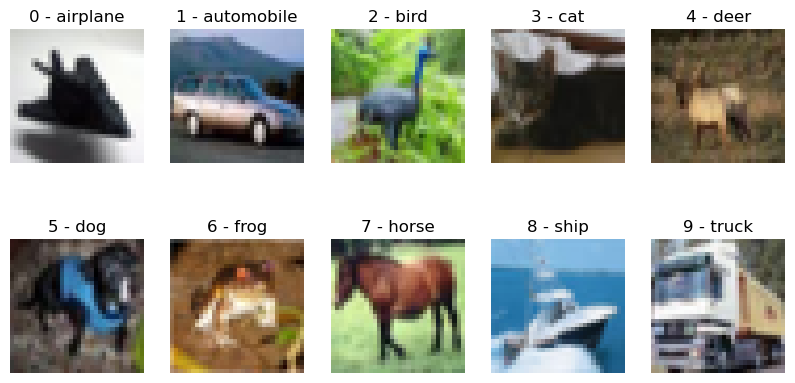

In [5]:
#From tutorial 1
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

#Plot a member of each class
for i, ax in enumerate(axes.flat):
    img = next(img for img, label in cifar10_train_val if label == i)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{i} - {cifar10_train_val.classes[i]}')
    ax.axis('off')

plt.show()

In [6]:
#Defining the validation accuracy.
validation_ratio = 0.1

## 3.1 : 1

In [7]:
def get_classes_indices(data : T.Tensor, classes : List[str]) -> T.Tensor:
    indices = {}
    #For every wanted class, get the target, and find indices with the same targets as the wanted class. Add the indices to the dict
    for target_class in classes:
        class_index = cifar10_train_val.class_to_idx[target_class]

        #Get the targets as a tensor
        data_targets = T.as_tensor(data.targets, dtype=T.int64)

        #Get the same indices
        data_class_indices = data_targets == class_index
        indices[target_class] = (class_index, data_class_indices)
    
    return indices

In [8]:
#Defining a defaultdict to map all targets to -1, and bird, airplane to 0, 1.
new_index_dict = defaultdict(lambda x : -1)
new_index_dict[0] = 0
new_index_dict[1] = 1

In [9]:
wanted_train_indices = get_classes_indices(cifar10_train_val, classes=['bird', 'airplane'])
wanted_test_indices = get_classes_indices(cifar10_test, classes=['bird', 'airplane'])

#Would be the same if we used test also
bird_index = wanted_train_indices['bird'][0]
airplane_index = wanted_train_indices['airplane'][0]

#Getting the indicies of the two wanted classes for the training_val
train_val_bird_indices = wanted_train_indices['bird'][1]
train_val_airplane_indices = wanted_train_indices['airplane'][1]

#Using this later to convert from CIFAR10 to CIFAR2
train_val_bird_airplane_indices = (train_val_bird_indices | train_val_airplane_indices).nonzero()[:, 0]

#Doing the same as above for the test 
test_bird_indices = wanted_test_indices['bird'][1]
test_airplane_indices = wanted_test_indices['airplane'][1]

#Convert later from CIFAR10 to CIFAR2 with theese indices
test_bird_airplane_indices = (test_bird_indices | test_airplane_indices).nonzero()[:, 0]

#Defining the size of train set and val set.
n_train_val = train_val_bird_airplane_indices.size(0)
n_train = floor((1 - validation_ratio) * train_val_bird_airplane_indices.size(0))

print(f"Bird index: {bird_index}")
print(f"Airplane index: {airplane_index}")
print()
print(f"Nuumber of train examples: {n_train}")
print(f"Nuumber of val examples: {n_train_val-n_train}")
print(f'Number of test example: {len(test_bird_airplane_indices)}')

Bird index: 2
Airplane index: 0

Nuumber of train examples: 9000
Nuumber of val examples: 1000
Number of test example: 2000


In [10]:
def transform_class_labels(data : T.Tensor, class_indices : T.Tensor, new_class_label : int) -> T.Tensor:
    #Transforms target class labels to new class labels
    data_labels = T.as_tensor(data.targets, dtype=T.int64)
    data_labels[class_indices] = T.full_like(data_labels[class_indices], new_class_label, dtype=T.int64)

    return data_labels

In [11]:
def select_class_indices(data : T.Tensor, old_labels : T.Tensor, indices : T.Tensor) -> Tuple[T.Tensor, T.Tensor]:
    #Selects target indices of image data and image labels
    data_labels = old_labels[indices]
    data = T.as_tensor(data.data, dtype=dtype)[indices]

    return data, data_labels

In [12]:
#Convert CIFAR10 to CIFAR2
cifar10_train_val_labels = transform_class_labels(cifar10_train_val, train_val_bird_indices, 1)
cifar2_train_val_data, cifar2_train_val_labels = select_class_indices(cifar10_train_val, cifar10_train_val_labels, train_val_bird_airplane_indices)

#Convert CIFAR10 to CIFAR2
cifar10_test_labels = transform_class_labels(cifar10_test, test_bird_indices, 1)
cifar2_test_data, cifar2_test_labels = select_class_indices(cifar10_test, cifar10_test_labels, test_bird_airplane_indices)

print("Bird NEW index: 1")
print("Airplane NEW index: 0")
print()
print("Train & Validation data shape:", cifar2_train_val_data.size())
print("Train & Validation labels shape:", cifar2_train_val_labels.size())
print("Test data shape:", cifar2_test_data.size())
print("Test labels shape:", cifar2_test_labels.size())

Bird NEW index: 1
Airplane NEW index: 0

Train & Validation data shape: torch.Size([10000, 32, 32, 3])
Train & Validation labels shape: torch.Size([10000])
Test data shape: torch.Size([2000, 32, 32, 3])
Test labels shape: torch.Size([2000])


In [13]:
#Splitting train and validation data & labels
T.manual_seed(seed)
train_val_indices = T.randperm(n_train_val, dtype=T.int64)

train_indices = train_val_indices[:n_train]
val_indices = train_val_indices[n_train:]

cifar2_train_data, cifar2_train_labels = select_class_indices(cifar2_train_val_data, cifar2_train_val_labels, train_indices)
cifar2_val_data, cifar2_val_labels = select_class_indices(cifar2_train_val_data, cifar2_train_val_labels, val_indices)

print(cifar2_train_data.size())
print(cifar2_val_data.size())

torch.Size([9000, 32, 32, 3])
torch.Size([1000, 32, 32, 3])


In [14]:
#Splitting to train and finding mean and standard deviation over RGB channels
cifar2_train_mean = (cifar2_train_data).mean(dim=(0, 1, 2), dtype=dtype)
cifar2_train_stdev = (cifar2_train_data).std(dim=(0, 1, 2))

print(cifar2_train_mean)
print(cifar2_train_stdev)

tensor([129.5769, 134.2931, 129.2937])
tensor([61.1349, 59.6247, 68.4269])


In [15]:
#Normalizing and reshaping data
cifar2_train_data_normalized = (cifar2_train_data - cifar2_train_mean) / cifar2_train_stdev
cifar2_train_data_normalized = cifar2_train_data_normalized.reshape(cifar2_train_labels.size(0), -1)

cifar2_val_data_normalized = (cifar2_val_data - cifar2_train_mean) / cifar2_train_stdev
cifar2_val_data_normalized = cifar2_val_data_normalized.reshape(cifar2_val_labels.size(0), -1)

cifar2_test_data_normalized = (cifar2_test_data - cifar2_train_mean) / cifar2_train_stdev
cifar2_test_data_normalized = cifar2_test_data_normalized.reshape(cifar2_test_labels.size(0), -1)

print(f"Train mean: {cifar2_train_data_normalized.mean()}\nTrain stdev: {cifar2_train_data_normalized.std()}")
print()
print(f"Validation mean: {cifar2_val_data_normalized.mean()}\nValidation stdev: {cifar2_val_data_normalized.std()}")
print()
print("Train data shape:", cifar2_train_data_normalized.size())
print("Train labels shape:", cifar2_train_labels.size())
print()
print("Validation data shape:", cifar2_val_data_normalized.size())
print("Validation labels shape:", cifar2_val_labels.size())
print()
print("Test data shape:", cifar2_test_data_normalized.size())
print("Test labels shape:", cifar2_test_labels.size())

Train mean: 1.5789838572446672e-18
Train stdev: 0.9999999638308676

Validation mean: -0.027054571500784816
Validation stdev: 0.9901668852368203

Train data shape: torch.Size([9000, 3072])
Train labels shape: torch.Size([9000])

Validation data shape: torch.Size([1000, 3072])
Validation labels shape: torch.Size([1000])

Test data shape: torch.Size([2000, 3072])
Test labels shape: torch.Size([2000])


In [16]:
cifar2_train = TensorDataset(cifar2_train_data_normalized, cifar2_train_labels)
cifar2_val = TensorDataset(cifar2_val_data_normalized, cifar2_val_labels)
cifar2_test = TensorDataset(cifar2_test_data_normalized, cifar2_test_labels)

In [17]:
criterion = CrossEntropyLoss().to(device)

3.1 : 2

In [18]:
class MyMLP(Module):
    def __init__(self, *layer_dims : int):
        super(MyMLP, self).__init__()
        
        self.n_layers = len(layer_dims) - 1

        #Setting layers
        for i in range(self.n_layers):
            setattr(self, f"fc-{i+1}", Linear(layer_dims[i], layer_dims[i+1]))

        self.relu = ReLU()
    
    def forward(self, X : T.Tensor) -> T.Tensor:
        for i in range(self.n_layers):
            X = getattr(self, f"fc-{i+1}")(X)

            #Not applying relu at output
            if(i != self.n_layers - 1):
                X = self.relu(X)

        return X

3.1 : 3

In [19]:
def train(n_epochs : int, model : Module, criterion : Module, optimizer : T.optim.Optimizer, train_loader : DataLoader, val_loader : DataLoader):
    training = model.training

    train_loss_log = []
    train_accuracy_log = []

    val_loss_log = []
    val_accuracy_log = []

    train_batch_size = train_loader.batch_size
    val_batch_size = val_loader.batch_size

    running_mean_train_window = len(train_loader)
    running_mean_val_window = len(val_loader)

    #We have implemented early stopping
    #We save the model parameters that produces the highest epoch vaidation accuracy
    best_epoch_val_accuracy = 0.0
    best_state_dict = model.state_dict().copy()

    for epoch in range(n_epochs):
        #Training
        model.train()
        train_progressbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch+1}/{n_epochs}, Train loss: -, Train accuracy: -")
        for X, y in train_loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()

            train_loss_log.append(loss)
            train_accuracy_log.append((T.argmax(y_pred, dim=-1) == y).count_nonzero() / train_batch_size)

            #Calculates the running mean loss in a context window equivalent of one epoch's worth of batch data
            running_mean_loss = sum(train_loss_log[-running_mean_train_window:]) / len(train_loss_log[-running_mean_train_window:])
            running_mean_accuracy = sum(train_accuracy_log[-running_mean_train_window:]) / len(train_accuracy_log[-running_mean_train_window:])

            #Updates progress bar description to show relevant information
            train_progressbar.set_description(f"Epoch: {epoch+1}/{n_epochs}, Train loss: {running_mean_loss : 0.3f}, Train accuracy: {100 * running_mean_accuracy : 0.1f}%")
            train_progressbar.update()

        train_progressbar.close()

        #Validation
        model.eval()
        val_progressbar = tqdm(total=len(val_loader), desc=f"Epoch: {epoch+1}/{n_epochs}, Val loss: -, Val accuracy: -")
        for X, y in val_loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device)

            with T.no_grad():
                y_pred = model(X)
                loss = criterion(y_pred, y)
                accuracy = (T.argmax(y_pred, dim=-1) == y).count_nonzero() / val_batch_size

            val_loss_log.append(loss)
            val_accuracy_log.append(accuracy)

            #Calculates the running mean loss in a context window equivalent of one epoch's worth of batch data
            running_mean_loss = sum(val_loss_log[-running_mean_val_window:]) / len(val_loss_log[-running_mean_val_window:])
            running_mean_accuracy = sum(val_accuracy_log[-running_mean_val_window:]) / len(val_accuracy_log[-running_mean_val_window:])
        
            #Updates progress bar description to show relevant information
            val_progressbar.set_description(f"Epoch: {epoch+1}/{n_epochs}, Val loss: {running_mean_loss : 0.3f}, Val accuracy: {100 * running_mean_accuracy : 0.1f}%")
            val_progressbar.update()

        val_progressbar.close()

        #running_mean_accuracy keeps track of mean accuracy of the last epochs' worth of batch accuracies
        #save the current model's state dict if the epoch validation accuracy is higher than previous best
        if(running_mean_accuracy > best_epoch_val_accuracy):
            best_state_dict = model.state_dict().copy()

        print()

    #Reverts to original training mode of the model
    if(training == True):
        model.train()

    return best_state_dict, (T.as_tensor(train_loss_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(val_loss_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(train_accuracy_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(val_accuracy_log, dtype=T.float64, device="cpu"))

3.1 : 4

In [20]:
def train_manual_update(n_epochs : int, lr : float, weight_decay : float, momentum : float, model : Module, criterion : Module, train_loader : DataLoader, val_loader : DataLoader):
    train_loss_log = []
    train_accuracy_log = []

    val_loss_log = []
    val_accuracy_log = []

    train_batch_size = train_loader.batch_size
    val_batch_size = val_loader.batch_size

    #We have implemented early stopping
    #We save the model parameters that produces the highest epoch vaidation accuracy
    best_epoch_val_accuracy = 0.0
    best_state_dict = model.state_dict().copy()

    running_mean_train_window = len(train_loader)
    running_mean_val_window = len(val_loader)

    #Stores momentum for all layers' parameters
    #Initialize as zero with same dimensionality as the network's layer-wise paramters
    b = {key : T.zeros_like(value) for key, value in model.named_parameters()}

    for epoch in range(n_epochs):
        #Training
        model.train()
        train_progressbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch+1}/{n_epochs}, Train loss: {'-'}")
        for X, y in train_loader:
            model.zero_grad()

            X = X.to(device=device, dtype=dtype)
            y = y.to(device)

            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()

            with T.no_grad():
                #Iterating over layers and updating parameters based on gradient
                #Logic described here: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
                for name, param in model.named_parameters():
                    g = param.grad

                    if(weight_decay != 0.0):
                        g += weight_decay * param.data

                    if(momentum != 0.0):
                        b[name] = momentum * b[name] + g.clone()
                        g = b[name].clone()

                    param -= lr * g

            train_loss_log.append(loss)
            train_accuracy_log.append((T.argmax(y_pred, dim=-1) == y).count_nonzero() / train_batch_size)
            
            #Calculates the running mean loss in a context window equivalent of one epoch's worth of batch data
            running_mean_loss = sum(train_loss_log[-running_mean_train_window:]) / len(train_loss_log[-running_mean_train_window:])
            running_mean_accuracy = sum(train_accuracy_log[-running_mean_train_window:]) / len(train_accuracy_log[-running_mean_train_window:])

            #Updates progress bar description to show relevant information
            train_progressbar.set_description(f"Epoch: {epoch+1}/{n_epochs}, Train loss: {running_mean_loss : 0.3f}, Train accuracy: {100 * running_mean_accuracy : 0.1f}%")
            train_progressbar.update()

        train_progressbar.close()

        #Validation
        model.eval()
        val_progressbar = tqdm(total=len(val_loader), desc=f"Epoch: {epoch+1}/{n_epochs}, Val loss: {'-'}")
        for X, y in val_loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device)

            with T.no_grad():
                y_pred = model(X)
                loss = criterion(y_pred, y)
                accuracy = (T.argmax(y_pred, dim=-1) == y).count_nonzero() / val_batch_size

            val_loss_log.append(loss)
            val_accuracy_log.append(accuracy)

            #Calculates the running mean loss in a context window equivalent of one epoch's worth of batch data
            running_mean_loss = sum(val_loss_log[-running_mean_val_window:]) / len(val_loss_log[-running_mean_val_window:])
            running_mean_accuracy = sum(val_accuracy_log[-running_mean_val_window:]) / len(val_accuracy_log[-running_mean_val_window:])

            #Updates progress bar description to show relevant information
            val_progressbar.set_description(f"Epoch: {epoch+1}/{n_epochs}, Val loss: {running_mean_loss : 0.3f}, Val accuracy: {100 * running_mean_accuracy : 0.1f}%")
            val_progressbar.update()

        val_progressbar.close()

        #running_mean_accuracy keeps track of mean accuracy of the last epochs' worth of batch accuracies
        #save the current model's state dict if the epoch validation accuracy is higher than previous best
        if(running_mean_accuracy > best_epoch_val_accuracy):
            best_state_dict = model.state_dict().copy()

        print()

    return best_state_dict, (T.as_tensor(train_loss_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(val_loss_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(train_accuracy_log, dtype=T.float64, device="cpu"), 
                             T.as_tensor(val_accuracy_log, dtype=T.float64, device="cpu"))

In [21]:
#Reduces local noise in training loss and accuracy logs
#Used for visualiztion purposes
def exponential_moving_average(log : T.Tensor, beta : float) -> T.Tensor:
    v = None
    ema_log = []

    for value in log:
        if(v is None):
            v = value
        else:
            v = beta * v + (1 - beta) * value
        ema_log.append(v)

    return ema_log

In [22]:
def plot_train_log(n_epochs : int, 
                   train_logs : Tuple[T.Tensor], 
                   axs : Optional[np.ndarray] = None, 
                   column_index : Optional[int] = None,
                   beta : float = 0.99, 
                   show : bool = True,
                   title : Optional[str] = None,
                   axes_title : Optional[str] = None,
                   figsize : Tuple[float, float] = (5, 5),
                   axes_fontsize : int = 10,
                   title_fontsize : int = 20):
    
    train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log = train_logs

    #If no axes are provided, create a two axis subplot, one for plotting accuracy and one for loss
    if(axs is None):
        _, axs = plt.subplots(2, 1, sharex='col', figsize=figsize)

    #If nclos of nrows in the subplot are 1, the axes expect one dimensional indices
    #If nclos of nrows in the subplot are 2, the axes expect two dimensional indices
    if(column_index is None):
        acc_axs = axs[0]
        loss_axs = axs[1]
    else:
        acc_axs = axs[0, column_index]
        loss_axs = axs[1, column_index]

    #Adding axes title shared across column if provided
    if(axes_title is not None):
        acc_axs.set_title(axes_title, fontsize=axes_fontsize)
    
    #Adding title for entire plot if provided
    if(title is not None):
            plt.suptitle(title, fontsize=title_fontsize)


    train_accuracy_xs = T.linspace(0, n_epochs, train_accuracy_log.size(0))
    train_accuracy_ys = exponential_moving_average(train_accuracy_log, beta)
    val_accuracy_xs = T.linspace(0, n_epochs, val_accuracy_log.size(0))
    val_accuracy_ys = exponential_moving_average(val_accuracy_log, beta)

    #Plotting train and validation accuracy
    acc_axs.plot(train_accuracy_xs, train_accuracy_ys, label="Train Accuracy")
    acc_axs.plot(val_accuracy_xs, val_accuracy_ys, label="Validation Accuracy")
    acc_axs.set_ylabel("Accuracy", fontsize=axes_fontsize)
    acc_axs.legend(loc="lower right", fontsize=axes_fontsize)

    train_loss_xs = T.linspace(0, n_epochs, train_loss_log.size(0))
    train_loss_ys = exponential_moving_average(train_loss_log, beta)
    val_loss_xs = T.linspace(0, n_epochs, val_loss_log.size(0))
    val_loss_ys = exponential_moving_average(val_loss_log, beta)

    #Plotting train and validation loss
    loss_axs.plot(train_loss_xs, train_loss_ys, label="Train Loss")
    loss_axs.plot(val_loss_xs, val_loss_ys, label="Validation Loss")
    loss_axs.set_ylabel("Loss", fontsize=axes_fontsize)
    loss_axs.legend(loc="upper right", fontsize=axes_fontsize)

    #Setting shared x-label to Epochs
    loss_axs.set_xlabel("Epochs", fontsize=axes_fontsize)
    
    #Show the plot
    if(show == True):
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.show()
        plt.close()

In [23]:
#Plots manual and stock train logs side by side for visualizing equivalense
def plot_train_log_comparison(n_epochs : int, stock_train_logs : Tuple[T.Tensor], manual_train_logs : Tuple[T.Tensor], beta : float = 0.99):
    _, axs = plt.subplots(2, 2, sharex='col', figsize=(20, 10))

    plot_train_log(n_epochs, stock_train_logs, axs=axs, column_index=0, beta=beta, show=False, axes_title="Stock", axes_fontsize=15)
    plot_train_log(n_epochs, manual_train_logs, axs=axs, column_index=1, beta=beta, axes_title="Manual", axes_fontsize=15, title="Stock and Manual Train Loop Comparison", title_fontsize=30)

In [24]:
#Returns True if all elements' difference in training logs is less than 0.00000000000001
def validate_train_loop_equivalence(stock_train_logs : Tuple[T.Tensor, T.Tensor, T.Tensor, T.Tensor], manual_train_logs : Tuple[T.Tensor, T.Tensor, T.Tensor, T.Tensor]) -> bool:
    for i in range(4):
        if(T.all(((stock_train_logs[i] - manual_train_logs[i]) < T.as_tensor(1e-15, dtype=dtype)), dim=0) == False):
            print(":     (")
            return False

    print(":> JIPPI")
    return True

In [25]:
#Trains the same model using both the stock optimizer and the manual function
#Tests if these methods produce the same results
def train_stock_and_manual(n_epochs : int, batch_size : int, learning_rate : float, weight_decay : float, momentum : float, plot : bool = True):
    train_loader = DataLoader(cifar2_train, batch_size, shuffle=False)
    val_loader = DataLoader(cifar2_val, batch_size, shuffle=False)

    #Stock
    T.manual_seed(seed)
    stock_model = MyMLP(*model_architecture).to(device)
    optimizer = SGD(stock_model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    _, stock_train_logs = train(n_epochs,
                                stock_model,
                                criterion,
                                optimizer,
                                train_loader,
                                val_loader)
    
    print()

    #Manual
    T.manual_seed(seed)
    manual_model = MyMLP(*model_architecture).to(device)

    _, manual_train_logs = train_manual_update(n_epochs,
                                            learning_rate,
                                            weight_decay,
                                            momentum,
                                            manual_model,
                                            criterion,
                                            train_loader,
                                            val_loader)

    if(plot == True):
        plot_train_log_comparison(n_epochs, stock_train_logs, manual_train_logs)

    #Testing
    training_loop_equivalent = validate_train_loop_equivalence(stock_train_logs, manual_train_logs)

    if(training_loop_equivalent == True):
        print("Manual and stock training loop produce same results :^)")

Epoch: 1/1, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 77.90it/s]
Epoch: 1/1, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 153.25it/s]


Epoch: 1/1, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 116.03it/s]
Epoch: 1/1, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 169.56it/s]



:> JIPPI
Manual and stock training loop produce same results :^)





Epoch: 1/1, Train loss:  0.618, Train accuracy:  64.5%: 100%|██████████| 36/36 [00:00<00:00, 112.83it/s]
Epoch: 1/1, Val loss:  0.522, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 177.11it/s]


Epoch: 1/1, Train loss:  0.618, Train accuracy:  64.5%: 100%|██████████| 36/36 [00:00<00:00, 111.13it/s]
Epoch: 1/1, Val loss:  0.522, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 173.61it/s]



:> JIPPI
Manual and stock training loop produce same results :^)





Epoch: 1/1, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 115.01it/s]
Epoch: 1/1, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 1/1, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 114.30it/s]
Epoch: 1/1, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 173.40it/s]



:> JIPPI
Manual and stock training loop produce same results :^)





Epoch: 1/10, Train loss:  0.608, Train accuracy:  65.6%: 100%|██████████| 36/36 [00:00<00:00, 113.96it/s]
Epoch: 1/10, Val loss:  0.529, Val accuracy:  72.1%: 100%|██████████| 4/4 [00:00<00:00, 181.52it/s]


Epoch: 2/10, Train loss:  0.524, Train accuracy:  74.7%: 100%|██████████| 36/36 [00:00<00:00, 110.02it/s]
Epoch: 2/10, Val loss:  0.484, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 173.30it/s]


Epoch: 3/10, Train loss:  0.483, Train accuracy:  76.9%: 100%|██████████| 36/36 [00:00<00:00, 110.55it/s]
Epoch: 3/10, Val loss:  0.460, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s]


Epoch: 4/10, Train loss:  0.455, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 110.90it/s]
Epoch: 4/10, Val loss:  0.456, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 172.83it/s]


Epoch: 5/10, Train loss:  0.433, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 111.04it/s]
Epoch: 5/10, Val loss:  0.439, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 6/10, Train loss:  0.410, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 92.50it/s]
Epoch: 6/10, Val loss:  0.443, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 7/10, Train loss:  0.383, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 111.37it/s]
Epoch: 7/10, Val loss:  0.422, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 176.39it/s]


Epoch: 8/10, Train loss:  0.347, Train accuracy:  83.3%: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s]
Epoch: 8/10, Val loss:  0.408, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 172.77it/s]


Epoch: 9/10, Train loss:  0.323, Train accuracy:  84.5%: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s]
Epoch: 9/10, Val loss:  0.416, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 176.95it/s]


Epoch: 10/10, Train loss:  0.299, Train accuracy:  85.1%: 100%|██████████| 36/36 [00:00<00:00, 111.14it/s]
Epoch: 10/10, Val loss:  0.409, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch: 1/10, Train loss:  0.608, Train accuracy:  65.6%: 100%|██████████| 36/36 [00:00<00:00, 107.88it/s]
Epoch: 1/10, Val loss:  0.529, Val accuracy:  72.1%: 100%|██████████| 4/4 [00:00<00:00, 177.42it/s]


Epoch: 2/10, Train loss:  0.524, Train accuracy:  74.7%: 100%|██████████| 36/36 [00:00<00:00, 107.39it/s]
Epoch: 2/10, Val loss:  0.484, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 177.40it/s]


Epoch: 3/10, Train loss:  0.483, Train accuracy:  76.9%: 100%|██████████| 36/36 [00:00<00:00, 106.42it/s]
Epoch: 3/10, Val loss:  0.460, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 169.92it/s]


Epoch: 4/10, Train loss:  0.455, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 106.80it/s]
Epoch: 4/10, Val loss:  0.456, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 170.01it/s]


Epoch: 5/10, Train loss:  0.433, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 106.36it/s]
Epoch: 5/10, Val loss:  0.439, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 180.82it/s]


Epoch: 6/10, Train loss:  0.410, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 106.56it/s]
Epoch: 6/10, Val loss:  0.443, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch: 7/10, Train loss:  0.383, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 107.35it/s]
Epoch: 7/10, Val loss:  0.422, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 177.05it/s]


Epoch: 8/10, Train loss:  0.347, Train accuracy:  83.3%: 100%|██████████| 36/36 [00:00<00:00, 106.65it/s]
Epoch: 8/10, Val loss:  0.408, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 177.14it/s]


Epoch: 9/10, Train loss:  0.323, Train accuracy:  84.5%: 100%|██████████| 36/36 [00:00<00:00, 106.70it/s]
Epoch: 9/10, Val loss:  0.416, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 173.51it/s]


Epoch: 10/10, Train loss:  0.299, Train accuracy:  85.1%: 100%|██████████| 36/36 [00:00<00:00, 107.32it/s]
Epoch: 10/10, Val loss:  0.409, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 169.59it/s]


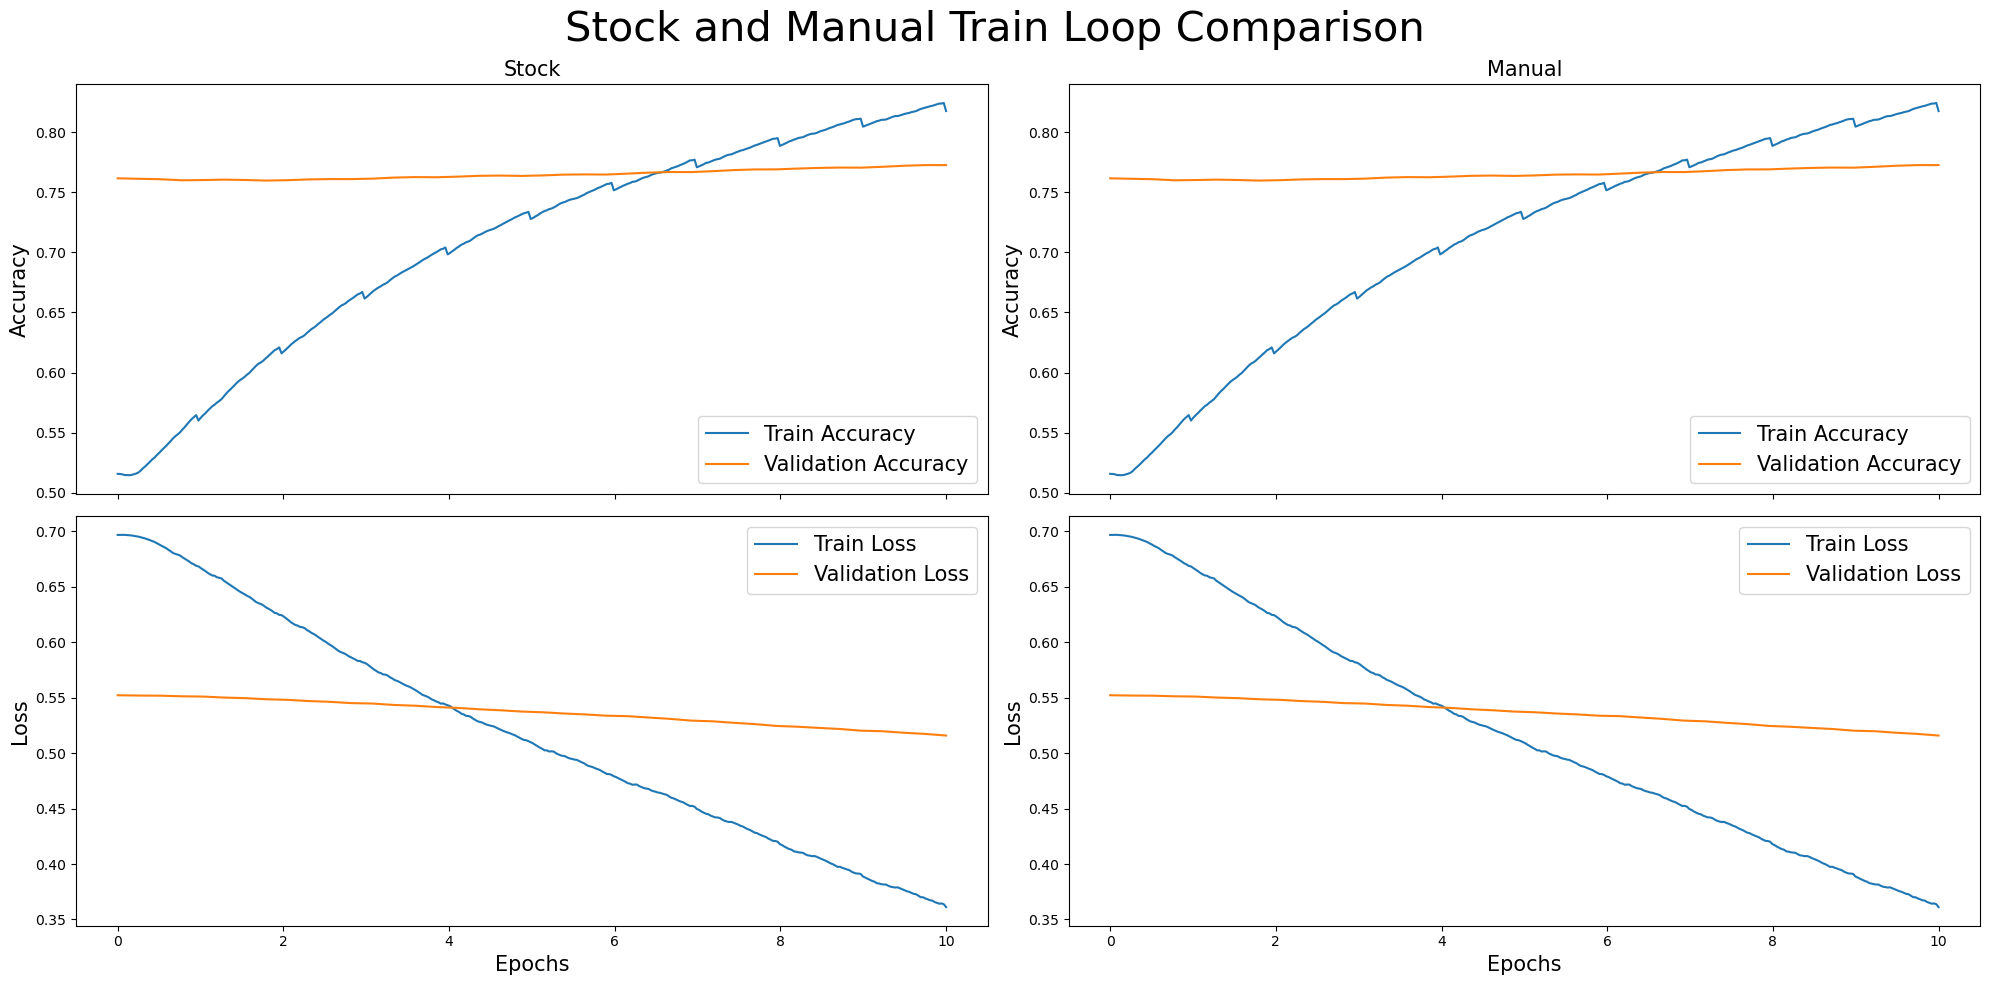

:> JIPPI
Manual and stock training loop produce same results :^)


In [25]:

train_stock_and_manual(1, 256, 0.01, 0.0, 0.0, plot=False)
print("\n\n")
train_stock_and_manual(1, 256, 0.01, 0.0, 0.9, plot=False)
print("\n\n")
train_stock_and_manual(1, 256, 0.01, 1e-3, 0.0, plot=False)
print("\n\n")
train_stock_and_manual(10, 256, 0.01, 1e-3, 0.99)

In [26]:
#Returns the accuracy of the model across all examples in the provided data loader
def get_accuracy(model : Module, data_loader : DataLoader) -> float:
    training = model.training

    right = 0
    wrong = 0

    #Sets model mode to eval
    if(training == True):
        model.eval()

    batch_size = data_loader.batch_size

    for X, y in data_loader:
        X = X.to(device, dtype)
        y = y.to(device)

        with T.no_grad():
            y_pred = model(X)

        right_ = (T.argmax(y_pred, dim=-1) == y).count_nonzero()

        right += right_
        wrong += batch_size - right_

    #Reverts back to original training mode
    if(training == True):
        model.train()

    accuracy = right / (right + wrong)

    return accuracy

In [27]:
#Returns a list of all combinations of provided keyword arguments
def grid_search(**kwargs) -> List[Dict[Any, Any]]:
    if not kwargs:
        return [{}]
    
    key, values = kwargs.popitem()
    sub_results = grid_search(**kwargs)
    
    results = []
    for val in values:
        for sub_result in sub_results:
            result = sub_result.copy()
            result[key] = val
            results.append(result)

    return results

Combination 1 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.0



Epoch: 1/6, Train loss:  0.519, Train accuracy:  76.0%: 100%|██████████| 563/563 [00:05<00:00, 95.16it/s] 
Epoch: 1/6, Val loss:  0.440, Val accuracy:  81.0%: 100%|██████████| 63/63 [00:00<00:00, 407.59it/s]


Epoch: 2/6, Train loss:  0.419, Train accuracy:  82.2%: 100%|██████████| 563/563 [00:09<00:00, 57.82it/s]
Epoch: 2/6, Val loss:  0.411, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 267.03it/s]


Epoch: 3/6, Train loss:  0.376, Train accuracy:  84.4%: 100%|██████████| 563/563 [00:09<00:00, 62.48it/s]
Epoch: 3/6, Val loss:  0.402, Val accuracy:  83.1%: 100%|██████████| 63/63 [00:00<00:00, 351.07it/s]


Epoch: 4/6, Train loss:  0.341, Train accuracy:  86.0%: 100%|██████████| 563/563 [00:08<00:00, 64.61it/s]
Epoch: 4/6, Val loss:  0.397, Val accuracy:  83.5%: 100%|██████████| 63/63 [00:00<00:00, 295.28it/s]


Epoch: 5/6, Train loss:  0.310, Train accuracy:  87.6%: 100%|██████████| 563/563 [00:08<00:00, 63.50it/s]
Epoch: 5/6, Val loss:  0.400, Val accuracy:  83.3%: 100%|██████████| 63/63 [00:00<00:00, 327.28it/s]


Epoch: 6/6, Train loss:  0.280, Train accuracy:  88.9%: 100%|██████████| 563/563 [00:08<00:00, 62.97it/s]
Epoch: 6/6, Val loss:  0.405, Val accuracy:  83.7%: 100%|██████████| 63/63 [00:00<00:00, 344.09it/s]


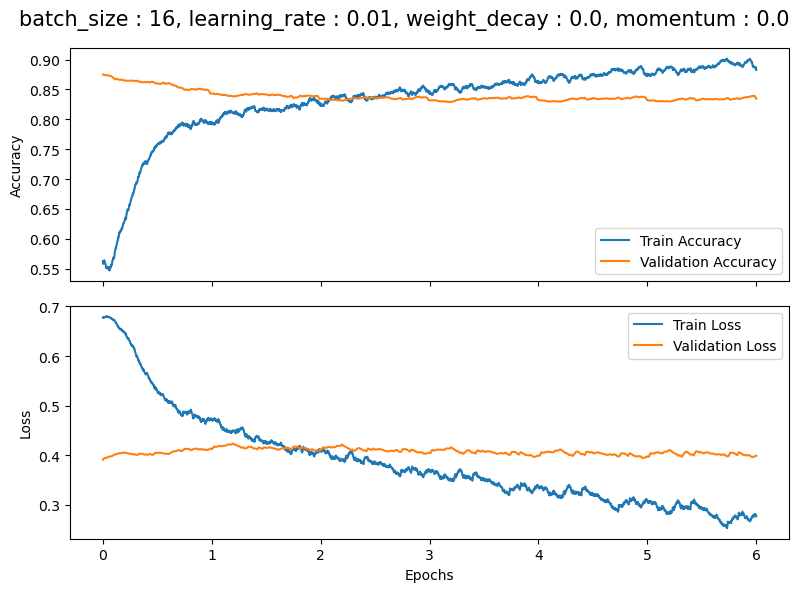

Train accuracy:  90.1
Validation accuracy:  83.7



Combination 2 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.0



Epoch: 1/24, Train loss:  0.625, Train accuracy:  66.3%: 100%|██████████| 141/141 [00:00<00:00, 210.46it/s]
Epoch: 1/24, Val loss:  0.558, Val accuracy:  74.0%: 100%|██████████| 16/16 [00:00<00:00, 389.63it/s]


Epoch: 2/24, Train loss:  0.507, Train accuracy:  78.0%: 100%|██████████| 141/141 [00:00<00:00, 153.74it/s]
Epoch: 2/24, Val loss:  0.478, Val accuracy:  77.9%: 100%|██████████| 16/16 [00:00<00:00, 390.00it/s]


Epoch: 3/24, Train loss:  0.462, Train accuracy:  80.2%: 100%|██████████| 141/141 [00:00<00:00, 151.75it/s]
Epoch: 3/24, Val loss:  0.454, Val accuracy:  79.7%: 100%|██████████| 16/16 [00:00<00:00, 346.20it/s]


Epoch: 4/24, Train loss:  0.433, Train accuracy:  81.6%: 100%|██████████| 141/141 [00:00<00:00, 153.28it/s]
Epoch: 4/24, Val loss:  0.438, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 378.25it/s]


Epoch: 5/24, Train loss:  0.407, Train accuracy:  82.8%: 100%|██████████| 141/141 [00:00<00:00, 147.40it/s]
Epoch: 5/24, Val loss:  0.426, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 354.34it/s]


Epoch: 6/24, Train loss:  0.385, Train accuracy:  83.7%: 100%|██████████| 141/141 [00:00<00:00, 148.94it/s]
Epoch: 6/24, Val loss:  0.417, Val accuracy:  80.7%: 100%|██████████| 16/16 [00:00<00:00, 362.57it/s]


Epoch: 7/24, Train loss:  0.364, Train accuracy:  84.8%: 100%|██████████| 141/141 [00:00<00:00, 150.15it/s]
Epoch: 7/24, Val loss:  0.410, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 300.82it/s]


Epoch: 8/24, Train loss:  0.345, Train accuracy:  85.7%: 100%|██████████| 141/141 [00:01<00:00, 137.40it/s]
Epoch: 8/24, Val loss:  0.403, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 393.41it/s]


Epoch: 9/24, Train loss:  0.326, Train accuracy:  86.4%: 100%|██████████| 141/141 [00:01<00:00, 135.04it/s]
Epoch: 9/24, Val loss:  0.397, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 362.01it/s]


Epoch: 10/24, Train loss:  0.308, Train accuracy:  87.5%: 100%|██████████| 141/141 [00:00<00:00, 149.82it/s]
Epoch: 10/24, Val loss:  0.393, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 392.36it/s]


Epoch: 11/24, Train loss:  0.292, Train accuracy:  88.5%: 100%|██████████| 141/141 [00:00<00:00, 153.58it/s]
Epoch: 11/24, Val loss:  0.389, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 387.81it/s]


Epoch: 12/24, Train loss:  0.276, Train accuracy:  89.4%: 100%|██████████| 141/141 [00:00<00:00, 144.41it/s]
Epoch: 12/24, Val loss:  0.388, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 329.35it/s]


Epoch: 13/24, Train loss:  0.263, Train accuracy:  90.0%: 100%|██████████| 141/141 [00:00<00:00, 157.48it/s]
Epoch: 13/24, Val loss:  0.390, Val accuracy:  83.4%: 100%|██████████| 16/16 [00:00<00:00, 336.03it/s]


Epoch: 14/24, Train loss:  0.249, Train accuracy:  90.8%: 100%|██████████| 141/141 [00:00<00:00, 155.92it/s]
Epoch: 14/24, Val loss:  0.392, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 384.23it/s]


Epoch: 15/24, Train loss:  0.235, Train accuracy:  91.3%: 100%|██████████| 141/141 [00:00<00:00, 155.00it/s]
Epoch: 15/24, Val loss:  0.392, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 389.04it/s]


Epoch: 16/24, Train loss:  0.228, Train accuracy:  91.7%: 100%|██████████| 141/141 [00:00<00:00, 158.77it/s]
Epoch: 16/24, Val loss:  0.403, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 384.02it/s]


Epoch: 17/24, Train loss:  0.206, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:00<00:00, 147.64it/s]
Epoch: 17/24, Val loss:  0.402, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 366.33it/s]


Epoch: 18/24, Train loss:  0.196, Train accuracy:  93.3%: 100%|██████████| 141/141 [00:00<00:00, 149.85it/s]
Epoch: 18/24, Val loss:  0.490, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 359.90it/s]


Epoch: 19/24, Train loss:  0.198, Train accuracy:  93.2%: 100%|██████████| 141/141 [00:00<00:00, 146.07it/s]
Epoch: 19/24, Val loss:  0.786, Val accuracy:  72.1%: 100%|██████████| 16/16 [00:00<00:00, 335.05it/s]


Epoch: 20/24, Train loss:  0.190, Train accuracy:  93.2%: 100%|██████████| 141/141 [00:00<00:00, 144.34it/s]
Epoch: 20/24, Val loss:  0.431, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 365.50it/s]


Epoch: 21/24, Train loss:  0.166, Train accuracy:  94.4%: 100%|██████████| 141/141 [00:00<00:00, 146.57it/s]
Epoch: 21/24, Val loss:  0.524, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 376.59it/s]


Epoch: 22/24, Train loss:  0.162, Train accuracy:  94.8%: 100%|██████████| 141/141 [00:00<00:00, 152.81it/s]
Epoch: 22/24, Val loss:  0.444, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 351.15it/s]


Epoch: 23/24, Train loss:  0.163, Train accuracy:  94.8%: 100%|██████████| 141/141 [00:00<00:00, 157.49it/s]
Epoch: 23/24, Val loss:  0.449, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 383.21it/s]


Epoch: 24/24, Train loss:  0.135, Train accuracy:  95.9%: 100%|██████████| 141/141 [00:00<00:00, 153.96it/s]
Epoch: 24/24, Val loss:  0.454, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 358.72it/s]


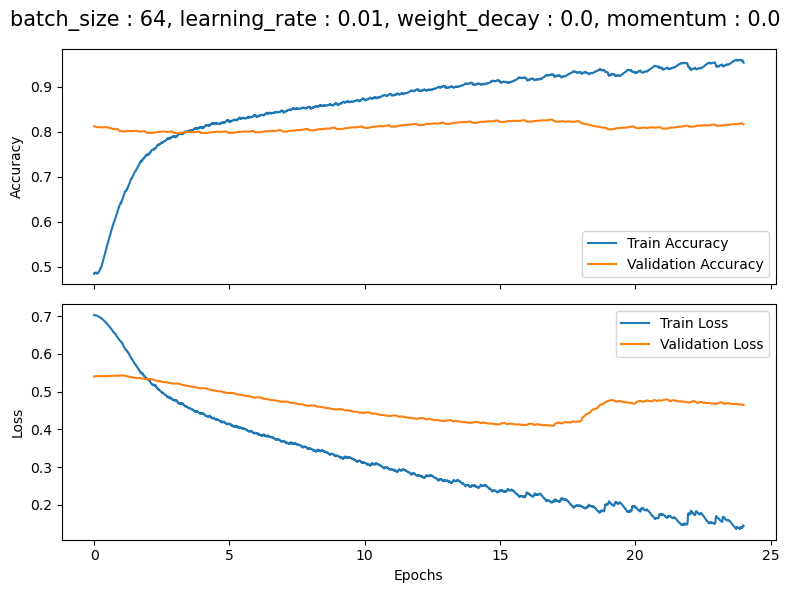

Train accuracy:  95.7
Validation accuracy:  83.3



Combination 3 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.0



Epoch: 1/96, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 116.34it/s]
Epoch: 1/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 153.12it/s]


Epoch: 2/96, Train loss:  0.643, Train accuracy:  65.4%: 100%|██████████| 36/36 [00:00<00:00, 113.04it/s]
Epoch: 2/96, Val loss:  0.623, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 169.05it/s]


Epoch: 3/96, Train loss:  0.605, Train accuracy:  70.7%: 100%|██████████| 36/36 [00:00<00:00, 111.37it/s]
Epoch: 3/96, Val loss:  0.588, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 165.99it/s]


Epoch: 4/96, Train loss:  0.568, Train accuracy:  73.3%: 100%|██████████| 36/36 [00:00<00:00, 112.34it/s]
Epoch: 4/96, Val loss:  0.554, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 156.03it/s]


Epoch: 5/96, Train loss:  0.535, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 110.20it/s]
Epoch: 5/96, Val loss:  0.523, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 166.27it/s]


Epoch: 6/96, Train loss:  0.509, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 111.15it/s]
Epoch: 6/96, Val loss:  0.500, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 166.32it/s]


Epoch: 7/96, Train loss:  0.491, Train accuracy:  77.2%: 100%|██████████| 36/36 [00:00<00:00, 112.54it/s]
Epoch: 7/96, Val loss:  0.485, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 166.32it/s]


Epoch: 8/96, Train loss:  0.479, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 113.22it/s]
Epoch: 8/96, Val loss:  0.474, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 173.67it/s]


Epoch: 9/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 92.25it/s] 
Epoch: 9/96, Val loss:  0.466, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 169.87it/s]


Epoch: 10/96, Train loss:  0.460, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 113.13it/s]
Epoch: 10/96, Val loss:  0.460, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 162.66it/s]


Epoch: 11/96, Train loss:  0.451, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 110.83it/s]
Epoch: 11/96, Val loss:  0.454, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 150.62it/s]


Epoch: 12/96, Train loss:  0.443, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 112.71it/s]
Epoch: 12/96, Val loss:  0.449, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 150.37it/s]


Epoch: 13/96, Train loss:  0.434, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 114.40it/s]
Epoch: 13/96, Val loss:  0.444, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 173.44it/s]


Epoch: 14/96, Train loss:  0.426, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 113.65it/s]
Epoch: 14/96, Val loss:  0.440, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 163.07it/s]


Epoch: 15/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 109.95it/s]
Epoch: 15/96, Val loss:  0.436, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 142.15it/s]


Epoch: 16/96, Train loss:  0.409, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 112.74it/s]
Epoch: 16/96, Val loss:  0.433, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 173.57it/s]


Epoch: 17/96, Train loss:  0.401, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 111.77it/s]
Epoch: 17/96, Val loss:  0.430, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 166.52it/s]


Epoch: 18/96, Train loss:  0.394, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 113.10it/s]
Epoch: 18/96, Val loss:  0.427, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 168.65it/s]


Epoch: 19/96, Train loss:  0.387, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 109.75it/s]
Epoch: 19/96, Val loss:  0.424, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 173.59it/s]


Epoch: 20/96, Train loss:  0.379, Train accuracy:  82.3%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 20/96, Val loss:  0.422, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 181.41it/s]


Epoch: 21/96, Train loss:  0.372, Train accuracy:  82.8%: 100%|██████████| 36/36 [00:00<00:00, 112.06it/s]
Epoch: 21/96, Val loss:  0.419, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 164.92it/s]


Epoch: 22/96, Train loss:  0.365, Train accuracy:  83.0%: 100%|██████████| 36/36 [00:00<00:00, 113.82it/s]
Epoch: 22/96, Val loss:  0.416, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 175.82it/s]


Epoch: 23/96, Train loss:  0.358, Train accuracy:  83.3%: 100%|██████████| 36/36 [00:00<00:00, 112.81it/s]
Epoch: 23/96, Val loss:  0.414, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 172.55it/s]


Epoch: 24/96, Train loss:  0.351, Train accuracy:  83.6%: 100%|██████████| 36/36 [00:00<00:00, 113.42it/s]
Epoch: 24/96, Val loss:  0.411, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 165.71it/s]


Epoch: 25/96, Train loss:  0.344, Train accuracy:  84.1%: 100%|██████████| 36/36 [00:00<00:00, 108.20it/s]
Epoch: 25/96, Val loss:  0.409, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 176.21it/s]


Epoch: 26/96, Train loss:  0.337, Train accuracy:  84.4%: 100%|██████████| 36/36 [00:00<00:00, 109.23it/s]
Epoch: 26/96, Val loss:  0.407, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 173.63it/s]


Epoch: 27/96, Train loss:  0.330, Train accuracy:  84.7%: 100%|██████████| 36/36 [00:00<00:00, 112.58it/s]
Epoch: 27/96, Val loss:  0.404, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 166.40it/s]


Epoch: 28/96, Train loss:  0.323, Train accuracy:  85.0%: 100%|██████████| 36/36 [00:00<00:00, 110.21it/s]
Epoch: 28/96, Val loss:  0.402, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 158.23it/s]


Epoch: 29/96, Train loss:  0.316, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 111.82it/s]
Epoch: 29/96, Val loss:  0.399, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 159.30it/s]


Epoch: 30/96, Train loss:  0.309, Train accuracy:  85.5%: 100%|██████████| 36/36 [00:00<00:00, 99.54it/s] 
Epoch: 30/96, Val loss:  0.397, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 145.61it/s]


Epoch: 31/96, Train loss:  0.302, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 112.53it/s]
Epoch: 31/96, Val loss:  0.395, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 158.46it/s]


Epoch: 32/96, Train loss:  0.295, Train accuracy:  86.2%: 100%|██████████| 36/36 [00:00<00:00, 112.10it/s]
Epoch: 32/96, Val loss:  0.392, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 150.20it/s]


Epoch: 33/96, Train loss:  0.289, Train accuracy:  86.5%: 100%|██████████| 36/36 [00:00<00:00, 110.20it/s]
Epoch: 33/96, Val loss:  0.390, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 166.00it/s]


Epoch: 34/96, Train loss:  0.282, Train accuracy:  86.9%: 100%|██████████| 36/36 [00:00<00:00, 110.82it/s]
Epoch: 34/96, Val loss:  0.388, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 166.39it/s]


Epoch: 35/96, Train loss:  0.276, Train accuracy:  87.3%: 100%|██████████| 36/36 [00:00<00:00, 91.71it/s]
Epoch: 35/96, Val loss:  0.386, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 158.90it/s]


Epoch: 36/96, Train loss:  0.270, Train accuracy:  87.6%: 100%|██████████| 36/36 [00:00<00:00, 111.95it/s]
Epoch: 36/96, Val loss:  0.386, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 165.77it/s]


Epoch: 37/96, Train loss:  0.264, Train accuracy:  87.9%: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s]
Epoch: 37/96, Val loss:  0.388, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 152.81it/s]


Epoch: 38/96, Train loss:  0.260, Train accuracy:  88.2%: 100%|██████████| 36/36 [00:00<00:00, 111.45it/s]
Epoch: 38/96, Val loss:  0.407, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 158.91it/s]


Epoch: 39/96, Train loss:  0.258, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 112.11it/s]
Epoch: 39/96, Val loss:  0.433, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 156.58it/s]


Epoch: 40/96, Train loss:  0.256, Train accuracy:  88.4%: 100%|██████████| 36/36 [00:00<00:00, 110.24it/s]
Epoch: 40/96, Val loss:  0.449, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 168.27it/s]


Epoch: 41/96, Train loss:  0.253, Train accuracy:  88.6%: 100%|██████████| 36/36 [00:00<00:00, 112.25it/s]
Epoch: 41/96, Val loss:  0.454, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 152.31it/s]


Epoch: 42/96, Train loss:  0.252, Train accuracy:  88.7%: 100%|██████████| 36/36 [00:00<00:00, 108.71it/s]
Epoch: 42/96, Val loss:  0.503, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 162.77it/s]


Epoch: 43/96, Train loss:  0.250, Train accuracy:  88.8%: 100%|██████████| 36/36 [00:00<00:00, 112.12it/s]
Epoch: 43/96, Val loss:  0.454, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 168.35it/s]


Epoch: 44/96, Train loss:  0.246, Train accuracy:  88.9%: 100%|██████████| 36/36 [00:00<00:00, 110.76it/s]
Epoch: 44/96, Val loss:  0.472, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 151.21it/s]


Epoch: 45/96, Train loss:  0.232, Train accuracy:  89.7%: 100%|██████████| 36/36 [00:00<00:00, 107.57it/s]
Epoch: 45/96, Val loss:  0.408, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 129.86it/s]


Epoch: 46/96, Train loss:  0.236, Train accuracy:  89.3%: 100%|██████████| 36/36 [00:00<00:00, 107.80it/s]
Epoch: 46/96, Val loss:  0.429, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 162.58it/s]


Epoch: 47/96, Train loss:  0.221, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 111.96it/s]
Epoch: 47/96, Val loss:  0.398, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 165.94it/s]


Epoch: 48/96, Train loss:  0.242, Train accuracy:  89.2%: 100%|██████████| 36/36 [00:00<00:00, 109.99it/s]
Epoch: 48/96, Val loss:  0.472, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 169.36it/s]


Epoch: 49/96, Train loss:  0.234, Train accuracy:  89.3%: 100%|██████████| 36/36 [00:00<00:00, 111.99it/s]
Epoch: 49/96, Val loss:  0.426, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 168.80it/s]


Epoch: 50/96, Train loss:  0.247, Train accuracy:  89.4%: 100%|██████████| 36/36 [00:00<00:00, 109.15it/s]
Epoch: 50/96, Val loss:  0.666, Val accuracy:  73.8%: 100%|██████████| 4/4 [00:00<00:00, 156.15it/s]


Epoch: 51/96, Train loss:  0.205, Train accuracy:  90.9%: 100%|██████████| 36/36 [00:00<00:00, 111.74it/s]
Epoch: 51/96, Val loss:  0.467, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 157.03it/s]


Epoch: 52/96, Train loss:  0.226, Train accuracy:  89.8%: 100%|██████████| 36/36 [00:00<00:00, 109.37it/s]
Epoch: 52/96, Val loss:  0.433, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 153.73it/s]


Epoch: 53/96, Train loss:  0.182, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 105.95it/s]
Epoch: 53/96, Val loss:  0.394, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 157.67it/s]


Epoch: 54/96, Train loss:  0.227, Train accuracy:  90.3%: 100%|██████████| 36/36 [00:00<00:00, 109.68it/s]
Epoch: 54/96, Val loss:  0.399, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 173.70it/s]


Epoch: 55/96, Train loss:  0.213, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 108.98it/s]
Epoch: 55/96, Val loss:  0.467, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 155.88it/s]


Epoch: 56/96, Train loss:  0.217, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 105.83it/s]
Epoch: 56/96, Val loss:  0.388, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 155.76it/s]


Epoch: 57/96, Train loss:  0.200, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 108.26it/s]
Epoch: 57/96, Val loss:  0.553, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 153.62it/s]


Epoch: 58/96, Train loss:  0.198, Train accuracy:  90.9%: 100%|██████████| 36/36 [00:00<00:00, 110.25it/s]
Epoch: 58/96, Val loss:  0.391, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 161.36it/s]


Epoch: 59/96, Train loss:  0.191, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 111.22it/s]
Epoch: 59/96, Val loss:  0.390, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 165.83it/s]


Epoch: 60/96, Train loss:  0.191, Train accuracy:  92.0%: 100%|██████████| 36/36 [00:00<00:00, 106.25it/s]
Epoch: 60/96, Val loss:  0.731, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 157.41it/s]


Epoch: 61/96, Train loss:  0.234, Train accuracy:  89.9%: 100%|██████████| 36/36 [00:00<00:00, 90.49it/s] 
Epoch: 61/96, Val loss:  0.497, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 169.26it/s]


Epoch: 62/96, Train loss:  0.171, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 99.21it/s] 
Epoch: 62/96, Val loss:  0.578, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 152.68it/s]


Epoch: 63/96, Train loss:  0.174, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 102.94it/s]
Epoch: 63/96, Val loss:  0.395, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 151.72it/s]


Epoch: 64/96, Train loss:  0.190, Train accuracy:  91.9%: 100%|██████████| 36/36 [00:00<00:00, 99.81it/s]
Epoch: 64/96, Val loss:  0.413, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 131.72it/s]


Epoch: 65/96, Train loss:  0.169, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 100.23it/s]
Epoch: 65/96, Val loss:  0.398, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 153.66it/s]


Epoch: 66/96, Train loss:  0.180, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 97.86it/s]
Epoch: 66/96, Val loss:  0.408, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 150.25it/s]


Epoch: 67/96, Train loss:  0.155, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 109.05it/s]
Epoch: 67/96, Val loss:  0.403, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 148.08it/s]


Epoch: 68/96, Train loss:  0.131, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 109.33it/s]
Epoch: 68/96, Val loss:  0.410, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 173.10it/s]


Epoch: 69/96, Train loss:  0.158, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 98.44it/s] 
Epoch: 69/96, Val loss:  0.408, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 158.96it/s]


Epoch: 70/96, Train loss:  0.167, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 104.16it/s]
Epoch: 70/96, Val loss:  0.426, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 159.63it/s]


Epoch: 71/96, Train loss:  0.143, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 109.09it/s]
Epoch: 71/96, Val loss:  0.407, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 150.52it/s]


Epoch: 72/96, Train loss:  0.227, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 110.92it/s]
Epoch: 72/96, Val loss:  0.657, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 163.53it/s]


Epoch: 73/96, Train loss:  0.169, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 106.53it/s]
Epoch: 73/96, Val loss:  0.559, Val accuracy:  79.0%: 100%|██████████| 4/4 [00:00<00:00, 157.00it/s]


Epoch: 74/96, Train loss:  0.116, Train accuracy:  94.6%: 100%|██████████| 36/36 [00:00<00:00, 106.31it/s]
Epoch: 74/96, Val loss:  0.405, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 162.27it/s]


Epoch: 75/96, Train loss:  0.154, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 103.05it/s]
Epoch: 75/96, Val loss:  0.576, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 151.18it/s]


Epoch: 76/96, Train loss:  0.126, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 108.88it/s]
Epoch: 76/96, Val loss:  0.722, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 145.89it/s]


Epoch: 77/96, Train loss:  0.154, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 107.52it/s]
Epoch: 77/96, Val loss:  0.413, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 161.91it/s]


Epoch: 78/96, Train loss:  0.099, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 103.47it/s]
Epoch: 78/96, Val loss:  0.421, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 158.84it/s]


Epoch: 79/96, Train loss:  0.129, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 109.25it/s]
Epoch: 79/96, Val loss:  0.436, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 160.71it/s]


Epoch: 80/96, Train loss:  0.174, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 102.25it/s]
Epoch: 80/96, Val loss:  0.509, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 139.98it/s]


Epoch: 81/96, Train loss:  0.105, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 106.74it/s]
Epoch: 81/96, Val loss:  0.576, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 153.59it/s]


Epoch: 82/96, Train loss:  0.160, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 107.81it/s]
Epoch: 82/96, Val loss:  0.630, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 159.55it/s]


Epoch: 83/96, Train loss:  0.105, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 106.56it/s]
Epoch: 83/96, Val loss:  0.470, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 156.47it/s]


Epoch: 84/96, Train loss:  0.078, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 108.72it/s]
Epoch: 84/96, Val loss:  0.442, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 159.10it/s]


Epoch: 85/96, Train loss:  0.162, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 106.91it/s]
Epoch: 85/96, Val loss:  0.427, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 173.28it/s]


Epoch: 86/96, Train loss:  0.116, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 108.90it/s]
Epoch: 86/96, Val loss:  0.466, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 166.03it/s]


Epoch: 87/96, Train loss:  0.135, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 91.22it/s] 
Epoch: 87/96, Val loss:  0.431, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 144.92it/s]


Epoch: 88/96, Train loss:  0.080, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 110.07it/s]
Epoch: 88/96, Val loss:  0.433, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 162.99it/s]


Epoch: 89/96, Train loss:  0.069, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 107.78it/s]
Epoch: 89/96, Val loss:  0.464, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 166.39it/s]


Epoch: 90/96, Train loss:  0.121, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 110.99it/s]
Epoch: 90/96, Val loss:  0.655, Val accuracy:  77.3%: 100%|██████████| 4/4 [00:00<00:00, 151.81it/s]


Epoch: 91/96, Train loss:  0.177, Train accuracy:  92.1%: 100%|██████████| 36/36 [00:00<00:00, 105.95it/s]
Epoch: 91/96, Val loss:  0.667, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 170.24it/s]


Epoch: 92/96, Train loss:  0.093, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 105.76it/s]
Epoch: 92/96, Val loss:  0.445, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 148.84it/s]


Epoch: 93/96, Train loss:  0.071, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 106.75it/s]
Epoch: 93/96, Val loss:  0.681, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 154.83it/s]


Epoch: 94/96, Train loss:  0.099, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 110.53it/s]
Epoch: 94/96, Val loss:  0.463, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 160.36it/s]


Epoch: 95/96, Train loss:  0.071, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 109.08it/s]
Epoch: 95/96, Val loss:  0.746, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 132.88it/s]


Epoch: 96/96, Train loss:  0.109, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 102.33it/s]
Epoch: 96/96, Val loss:  0.471, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 156.34it/s]


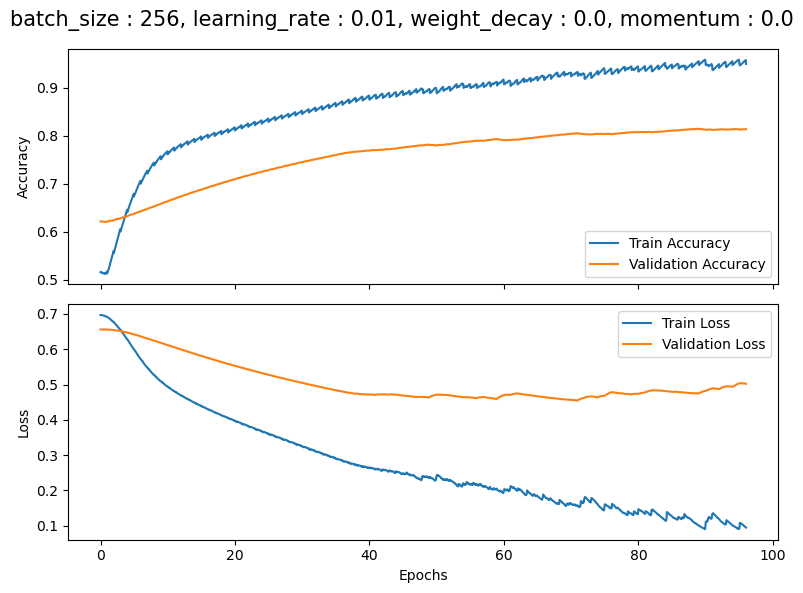

Train accuracy:  96.5
Validation accuracy:  83.1



Combination 4 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.0



Epoch: 1/6, Train loss:  0.669, Train accuracy:  56.7%: 100%|██████████| 563/563 [00:05<00:00, 102.33it/s]
Epoch: 1/6, Val loss:  0.637, Val accuracy:  68.6%: 100%|██████████| 63/63 [00:00<00:00, 342.51it/s]


Epoch: 2/6, Train loss:  0.608, Train accuracy:  72.0%: 100%|██████████| 563/563 [00:09<00:00, 61.57it/s]
Epoch: 2/6, Val loss:  0.583, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 300.65it/s]


Epoch: 3/6, Train loss:  0.552, Train accuracy:  75.8%: 100%|██████████| 563/563 [00:09<00:00, 61.44it/s]
Epoch: 3/6, Val loss:  0.532, Val accuracy:  76.7%: 100%|██████████| 63/63 [00:00<00:00, 285.20it/s]


Epoch: 4/6, Train loss:  0.508, Train accuracy:  78.2%: 100%|██████████| 563/563 [00:09<00:00, 56.50it/s]
Epoch: 4/6, Val loss:  0.497, Val accuracy:  78.0%: 100%|██████████| 63/63 [00:00<00:00, 265.65it/s]


Epoch: 5/6, Train loss:  0.484, Train accuracy:  79.3%: 100%|██████████| 563/563 [00:10<00:00, 55.89it/s]
Epoch: 5/6, Val loss:  0.478, Val accuracy:  78.8%: 100%|██████████| 63/63 [00:00<00:00, 280.68it/s]


Epoch: 6/6, Train loss:  0.468, Train accuracy:  80.2%: 100%|██████████| 563/563 [00:09<00:00, 60.68it/s]
Epoch: 6/6, Val loss:  0.466, Val accuracy:  79.9%: 100%|██████████| 63/63 [00:00<00:00, 272.55it/s]


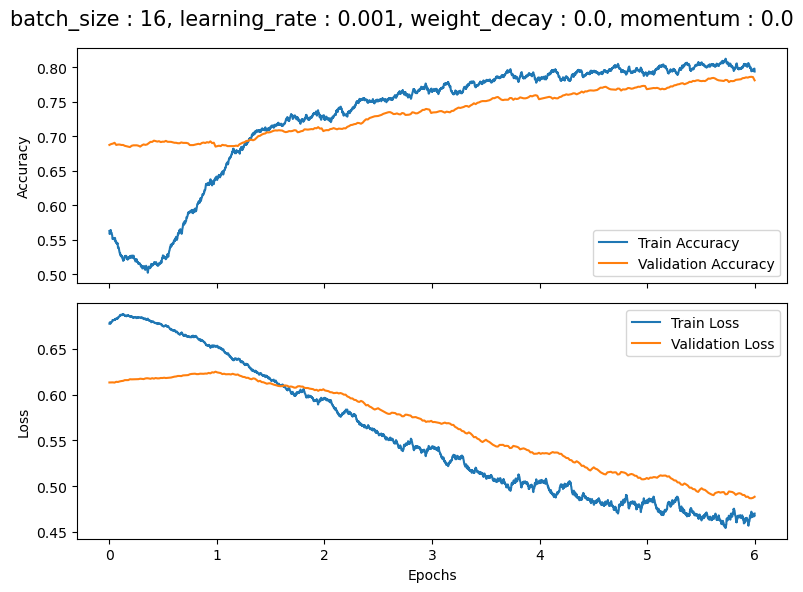

Train accuracy:  80.6
Validation accuracy:  79.9



Combination 5 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.0



Epoch: 1/24, Train loss:  0.691, Train accuracy:  49.6%: 100%|██████████| 141/141 [00:00<00:00, 200.22it/s]
Epoch: 1/24, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 16/16 [00:00<00:00, 389.40it/s]


Epoch: 2/24, Train loss:  0.676, Train accuracy:  51.0%: 100%|██████████| 141/141 [00:01<00:00, 138.98it/s]
Epoch: 2/24, Val loss:  0.665, Val accuracy:  55.8%: 100%|██████████| 16/16 [00:00<00:00, 359.84it/s]


Epoch: 3/24, Train loss:  0.661, Train accuracy:  60.2%: 100%|██████████| 141/141 [00:00<00:00, 155.35it/s]
Epoch: 3/24, Val loss:  0.651, Val accuracy:  62.7%: 100%|██████████| 16/16 [00:00<00:00, 339.88it/s]


Epoch: 4/24, Train loss:  0.646, Train accuracy:  66.4%: 100%|██████████| 141/141 [00:01<00:00, 137.53it/s]
Epoch: 4/24, Val loss:  0.638, Val accuracy:  67.2%: 100%|██████████| 16/16 [00:00<00:00, 360.05it/s]


Epoch: 5/24, Train loss:  0.631, Train accuracy:  69.6%: 100%|██████████| 141/141 [00:00<00:00, 157.78it/s]
Epoch: 5/24, Val loss:  0.624, Val accuracy:  69.3%: 100%|██████████| 16/16 [00:00<00:00, 370.82it/s]


Epoch: 6/24, Train loss:  0.615, Train accuracy:  71.7%: 100%|██████████| 141/141 [00:00<00:00, 153.88it/s]
Epoch: 6/24, Val loss:  0.611, Val accuracy:  70.4%: 100%|██████████| 16/16 [00:00<00:00, 380.20it/s]


Epoch: 7/24, Train loss:  0.600, Train accuracy:  72.5%: 100%|██████████| 141/141 [00:00<00:00, 153.69it/s]
Epoch: 7/24, Val loss:  0.597, Val accuracy:  71.0%: 100%|██████████| 16/16 [00:00<00:00, 338.73it/s]


Epoch: 8/24, Train loss:  0.585, Train accuracy:  73.6%: 100%|██████████| 141/141 [00:00<00:00, 146.53it/s]
Epoch: 8/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 383.54it/s]


Epoch: 9/24, Train loss:  0.571, Train accuracy:  74.8%: 100%|██████████| 141/141 [00:00<00:00, 154.06it/s]
Epoch: 9/24, Val loss:  0.570, Val accuracy:  72.9%: 100%|██████████| 16/16 [00:00<00:00, 370.69it/s]


Epoch: 10/24, Train loss:  0.557, Train accuracy:  75.5%: 100%|██████████| 141/141 [00:01<00:00, 137.67it/s]
Epoch: 10/24, Val loss:  0.557, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 370.92it/s]


Epoch: 11/24, Train loss:  0.544, Train accuracy:  76.3%: 100%|██████████| 141/141 [00:00<00:00, 145.58it/s]
Epoch: 11/24, Val loss:  0.544, Val accuracy:  74.4%: 100%|██████████| 16/16 [00:00<00:00, 379.63it/s]


Epoch: 12/24, Train loss:  0.531, Train accuracy:  76.9%: 100%|██████████| 141/141 [00:01<00:00, 140.98it/s]
Epoch: 12/24, Val loss:  0.532, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 355.54it/s]


Epoch: 13/24, Train loss:  0.520, Train accuracy:  77.5%: 100%|██████████| 141/141 [00:01<00:00, 138.33it/s]
Epoch: 13/24, Val loss:  0.521, Val accuracy:  75.7%: 100%|██████████| 16/16 [00:00<00:00, 361.52it/s]


Epoch: 14/24, Train loss:  0.511, Train accuracy:  78.1%: 100%|██████████| 141/141 [00:00<00:00, 144.59it/s]
Epoch: 14/24, Val loss:  0.512, Val accuracy:  76.1%: 100%|██████████| 16/16 [00:00<00:00, 378.57it/s]


Epoch: 15/24, Train loss:  0.502, Train accuracy:  78.2%: 100%|██████████| 141/141 [00:01<00:00, 140.85it/s]
Epoch: 15/24, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 16/16 [00:00<00:00, 355.46it/s]


Epoch: 16/24, Train loss:  0.495, Train accuracy:  78.6%: 100%|██████████| 141/141 [00:01<00:00, 137.40it/s]
Epoch: 16/24, Val loss:  0.497, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 319.62it/s]


Epoch: 17/24, Train loss:  0.489, Train accuracy:  78.9%: 100%|██████████| 141/141 [00:01<00:00, 124.61it/s]
Epoch: 17/24, Val loss:  0.491, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 318.91it/s]


Epoch: 18/24, Train loss:  0.484, Train accuracy:  79.4%: 100%|██████████| 141/141 [00:01<00:00, 139.00it/s]
Epoch: 18/24, Val loss:  0.486, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 350.09it/s]


Epoch: 19/24, Train loss:  0.479, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:01<00:00, 138.61it/s]
Epoch: 19/24, Val loss:  0.482, Val accuracy:  77.2%: 100%|██████████| 16/16 [00:00<00:00, 362.05it/s]


Epoch: 20/24, Train loss:  0.475, Train accuracy:  79.8%: 100%|██████████| 141/141 [00:01<00:00, 137.56it/s]
Epoch: 20/24, Val loss:  0.478, Val accuracy:  77.5%: 100%|██████████| 16/16 [00:00<00:00, 291.13it/s]


Epoch: 21/24, Train loss:  0.471, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:00<00:00, 149.61it/s]
Epoch: 21/24, Val loss:  0.475, Val accuracy:  77.9%: 100%|██████████| 16/16 [00:00<00:00, 382.53it/s]


Epoch: 22/24, Train loss:  0.467, Train accuracy:  80.1%: 100%|██████████| 141/141 [00:00<00:00, 148.60it/s]
Epoch: 22/24, Val loss:  0.471, Val accuracy:  78.0%: 100%|██████████| 16/16 [00:00<00:00, 385.64it/s]


Epoch: 23/24, Train loss:  0.464, Train accuracy:  80.3%: 100%|██████████| 141/141 [00:00<00:00, 150.01it/s]
Epoch: 23/24, Val loss:  0.469, Val accuracy:  78.4%: 100%|██████████| 16/16 [00:00<00:00, 389.43it/s]


Epoch: 24/24, Train loss:  0.460, Train accuracy:  80.5%: 100%|██████████| 141/141 [00:00<00:00, 149.53it/s]
Epoch: 24/24, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 362.15it/s]


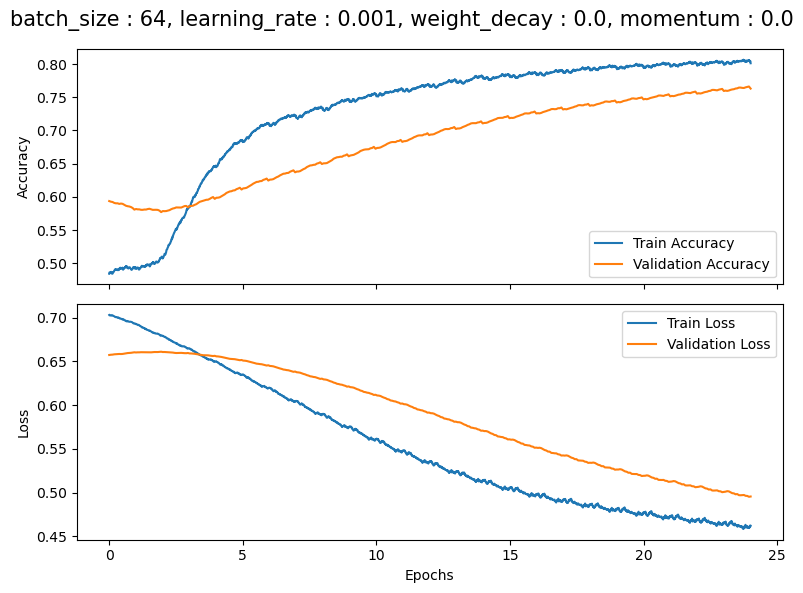

Train accuracy:  80.6
Validation accuracy:  78.5



Combination 6 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.0



Epoch: 1/96, Train loss:  0.698, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 112.56it/s]
Epoch: 1/96, Val loss:  0.689, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 162.53it/s]


Epoch: 2/96, Train loss:  0.693, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 109.09it/s]
Epoch: 2/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 168.94it/s]


Epoch: 3/96, Train loss:  0.689, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 113.18it/s]
Epoch: 3/96, Val loss:  0.681, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 159.48it/s]


Epoch: 4/96, Train loss:  0.685, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 109.97it/s]
Epoch: 4/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 162.22it/s]


Epoch: 5/96, Train loss:  0.681, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 111.32it/s]
Epoch: 5/96, Val loss:  0.674, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 166.80it/s]


Epoch: 6/96, Train loss:  0.678, Train accuracy:  48.9%: 100%|██████████| 36/36 [00:00<00:00, 109.14it/s]
Epoch: 6/96, Val loss:  0.671, Val accuracy:  50.7%: 100%|██████████| 4/4 [00:00<00:00, 134.16it/s]


Epoch: 7/96, Train loss:  0.674, Train accuracy:  50.1%: 100%|██████████| 36/36 [00:00<00:00, 105.31it/s]
Epoch: 7/96, Val loss:  0.667, Val accuracy:  53.0%: 100%|██████████| 4/4 [00:00<00:00, 161.71it/s]


Epoch: 8/96, Train loss:  0.670, Train accuracy:  52.6%: 100%|██████████| 36/36 [00:00<00:00, 106.48it/s]
Epoch: 8/96, Val loss:  0.664, Val accuracy:  56.2%: 100%|██████████| 4/4 [00:00<00:00, 156.09it/s]


Epoch: 9/96, Train loss:  0.666, Train accuracy:  56.0%: 100%|██████████| 36/36 [00:00<00:00, 91.58it/s]
Epoch: 9/96, Val loss:  0.660, Val accuracy:  58.7%: 100%|██████████| 4/4 [00:00<00:00, 163.96it/s]


Epoch: 10/96, Train loss:  0.663, Train accuracy:  58.3%: 100%|██████████| 36/36 [00:00<00:00, 112.39it/s]
Epoch: 10/96, Val loss:  0.657, Val accuracy:  59.3%: 100%|██████████| 4/4 [00:00<00:00, 159.64it/s]


Epoch: 11/96, Train loss:  0.659, Train accuracy:  60.4%: 100%|██████████| 36/36 [00:00<00:00, 114.01it/s]
Epoch: 11/96, Val loss:  0.653, Val accuracy:  61.6%: 100%|██████████| 4/4 [00:00<00:00, 166.26it/s]


Epoch: 12/96, Train loss:  0.655, Train accuracy:  62.2%: 100%|██████████| 36/36 [00:00<00:00, 111.79it/s]
Epoch: 12/96, Val loss:  0.650, Val accuracy:  63.1%: 100%|██████████| 4/4 [00:00<00:00, 159.35it/s]


Epoch: 13/96, Train loss:  0.651, Train accuracy:  63.7%: 100%|██████████| 36/36 [00:00<00:00, 114.53it/s]
Epoch: 13/96, Val loss:  0.646, Val accuracy:  65.2%: 100%|██████████| 4/4 [00:00<00:00, 169.63it/s]


Epoch: 14/96, Train loss:  0.647, Train accuracy:  64.9%: 100%|██████████| 36/36 [00:00<00:00, 113.96it/s]
Epoch: 14/96, Val loss:  0.643, Val accuracy:  66.4%: 100%|██████████| 4/4 [00:00<00:00, 167.81it/s]


Epoch: 15/96, Train loss:  0.644, Train accuracy:  65.9%: 100%|██████████| 36/36 [00:00<00:00, 109.16it/s]
Epoch: 15/96, Val loss:  0.639, Val accuracy:  67.0%: 100%|██████████| 4/4 [00:00<00:00, 145.24it/s]


Epoch: 16/96, Train loss:  0.640, Train accuracy:  66.7%: 100%|██████████| 36/36 [00:00<00:00, 108.18it/s]
Epoch: 16/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 139.97it/s]


Epoch: 17/96, Train loss:  0.636, Train accuracy:  67.5%: 100%|██████████| 36/36 [00:00<00:00, 109.30it/s]
Epoch: 17/96, Val loss:  0.632, Val accuracy:  68.1%: 100%|██████████| 4/4 [00:00<00:00, 166.43it/s]


Epoch: 18/96, Train loss:  0.632, Train accuracy:  68.1%: 100%|██████████| 36/36 [00:00<00:00, 110.92it/s]
Epoch: 18/96, Val loss:  0.629, Val accuracy:  68.8%: 100%|██████████| 4/4 [00:00<00:00, 169.46it/s]


Epoch: 19/96, Train loss:  0.628, Train accuracy:  68.6%: 100%|██████████| 36/36 [00:00<00:00, 107.87it/s]
Epoch: 19/96, Val loss:  0.625, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 175.82it/s]


Epoch: 20/96, Train loss:  0.624, Train accuracy:  69.4%: 100%|██████████| 36/36 [00:00<00:00, 111.05it/s]
Epoch: 20/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 150.48it/s]


Epoch: 21/96, Train loss:  0.621, Train accuracy:  69.8%: 100%|██████████| 36/36 [00:00<00:00, 105.62it/s]
Epoch: 21/96, Val loss:  0.618, Val accuracy:  69.6%: 100%|██████████| 4/4 [00:00<00:00, 169.26it/s]


Epoch: 22/96, Train loss:  0.617, Train accuracy:  70.1%: 100%|██████████| 36/36 [00:00<00:00, 110.15it/s]
Epoch: 22/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 173.39it/s]


Epoch: 23/96, Train loss:  0.613, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 112.46it/s]
Epoch: 23/96, Val loss:  0.611, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 160.01it/s]


Epoch: 24/96, Train loss:  0.609, Train accuracy:  70.6%: 100%|██████████| 36/36 [00:00<00:00, 113.19it/s]
Epoch: 24/96, Val loss:  0.608, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 169.17it/s]


Epoch: 25/96, Train loss:  0.605, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 108.26it/s]
Epoch: 25/96, Val loss:  0.604, Val accuracy:  70.4%: 100%|██████████| 4/4 [00:00<00:00, 164.45it/s]


Epoch: 26/96, Train loss:  0.601, Train accuracy:  71.1%: 100%|██████████| 36/36 [00:00<00:00, 107.35it/s]
Epoch: 26/96, Val loss:  0.601, Val accuracy:  70.5%: 100%|██████████| 4/4 [00:00<00:00, 173.03it/s]


Epoch: 27/96, Train loss:  0.598, Train accuracy:  71.2%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 27/96, Val loss:  0.597, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 156.08it/s]


Epoch: 28/96, Train loss:  0.594, Train accuracy:  71.5%: 100%|██████████| 36/36 [00:00<00:00, 108.58it/s]
Epoch: 28/96, Val loss:  0.594, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 165.32it/s]


Epoch: 29/96, Train loss:  0.590, Train accuracy:  71.9%: 100%|██████████| 36/36 [00:00<00:00, 110.34it/s]
Epoch: 29/96, Val loss:  0.590, Val accuracy:  71.2%: 100%|██████████| 4/4 [00:00<00:00, 166.03it/s]


Epoch: 30/96, Train loss:  0.586, Train accuracy:  72.2%: 100%|██████████| 36/36 [00:00<00:00, 106.87it/s]
Epoch: 30/96, Val loss:  0.587, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 153.27it/s]


Epoch: 31/96, Train loss:  0.583, Train accuracy:  72.5%: 100%|██████████| 36/36 [00:00<00:00, 109.02it/s]
Epoch: 31/96, Val loss:  0.584, Val accuracy:  71.9%: 100%|██████████| 4/4 [00:00<00:00, 166.03it/s]


Epoch: 32/96, Train loss:  0.579, Train accuracy:  72.7%: 100%|██████████| 36/36 [00:00<00:00, 106.04it/s]
Epoch: 32/96, Val loss:  0.580, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 169.86it/s]


Epoch: 33/96, Train loss:  0.575, Train accuracy:  73.0%: 100%|██████████| 36/36 [00:00<00:00, 109.72it/s]
Epoch: 33/96, Val loss:  0.577, Val accuracy:  72.6%: 100%|██████████| 4/4 [00:00<00:00, 164.77it/s]


Epoch: 34/96, Train loss:  0.572, Train accuracy:  73.2%: 100%|██████████| 36/36 [00:00<00:00, 112.21it/s]
Epoch: 34/96, Val loss:  0.573, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 44.25it/s]


Epoch: 35/96, Train loss:  0.568, Train accuracy:  73.4%: 100%|██████████| 36/36 [00:00<00:00, 113.70it/s]
Epoch: 35/96, Val loss:  0.570, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 162.24it/s]


Epoch: 36/96, Train loss:  0.565, Train accuracy:  73.7%: 100%|██████████| 36/36 [00:00<00:00, 109.02it/s]
Epoch: 36/96, Val loss:  0.566, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 169.45it/s]


Epoch: 37/96, Train loss:  0.561, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 110.53it/s]
Epoch: 37/96, Val loss:  0.563, Val accuracy:  73.2%: 100%|██████████| 4/4 [00:00<00:00, 165.87it/s]


Epoch: 38/96, Train loss:  0.558, Train accuracy:  74.2%: 100%|██████████| 36/36 [00:00<00:00, 112.38it/s]
Epoch: 38/96, Val loss:  0.560, Val accuracy:  73.8%: 100%|██████████| 4/4 [00:00<00:00, 155.22it/s]


Epoch: 39/96, Train loss:  0.554, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 110.72it/s]
Epoch: 39/96, Val loss:  0.556, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 173.23it/s]


Epoch: 40/96, Train loss:  0.551, Train accuracy:  74.4%: 100%|██████████| 36/36 [00:00<00:00, 109.02it/s]
Epoch: 40/96, Val loss:  0.553, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 165.97it/s]


Epoch: 41/96, Train loss:  0.547, Train accuracy:  74.6%: 100%|██████████| 36/36 [00:00<00:00, 110.09it/s]
Epoch: 41/96, Val loss:  0.550, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 156.56it/s]


Epoch: 42/96, Train loss:  0.544, Train accuracy:  74.8%: 100%|██████████| 36/36 [00:00<00:00, 111.23it/s]
Epoch: 42/96, Val loss:  0.546, Val accuracy:  74.2%: 100%|██████████| 4/4 [00:00<00:00, 160.37it/s]


Epoch: 43/96, Train loss:  0.541, Train accuracy:  75.0%: 100%|██████████| 36/36 [00:00<00:00, 111.86it/s]
Epoch: 43/96, Val loss:  0.543, Val accuracy:  74.3%: 100%|██████████| 4/4 [00:00<00:00, 163.18it/s]


Epoch: 44/96, Train loss:  0.538, Train accuracy:  75.1%: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s]
Epoch: 44/96, Val loss:  0.540, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 173.71it/s]


Epoch: 45/96, Train loss:  0.535, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 112.98it/s]
Epoch: 45/96, Val loss:  0.537, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 169.63it/s]


Epoch: 46/96, Train loss:  0.532, Train accuracy:  75.5%: 100%|██████████| 36/36 [00:00<00:00, 108.39it/s]
Epoch: 46/96, Val loss:  0.534, Val accuracy:  75.2%: 100%|██████████| 4/4 [00:00<00:00, 169.50it/s]


Epoch: 47/96, Train loss:  0.529, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 111.32it/s]
Epoch: 47/96, Val loss:  0.531, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 165.93it/s]


Epoch: 48/96, Train loss:  0.526, Train accuracy:  75.8%: 100%|██████████| 36/36 [00:00<00:00, 113.19it/s]
Epoch: 48/96, Val loss:  0.528, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 162.99it/s]


Epoch: 49/96, Train loss:  0.523, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 111.14it/s]
Epoch: 49/96, Val loss:  0.525, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 165.83it/s]


Epoch: 50/96, Train loss:  0.520, Train accuracy:  76.0%: 100%|██████████| 36/36 [00:00<00:00, 110.79it/s]
Epoch: 50/96, Val loss:  0.522, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 167.80it/s]


Epoch: 51/96, Train loss:  0.518, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 51/96, Val loss:  0.519, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 165.54it/s]


Epoch: 52/96, Train loss:  0.515, Train accuracy:  76.2%: 100%|██████████| 36/36 [00:00<00:00, 112.52it/s]
Epoch: 52/96, Val loss:  0.517, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 166.52it/s]


Epoch: 53/96, Train loss:  0.513, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 110.37it/s]
Epoch: 53/96, Val loss:  0.514, Val accuracy:  75.8%: 100%|██████████| 4/4 [00:00<00:00, 162.40it/s]


Epoch: 54/96, Train loss:  0.510, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 110.54it/s]
Epoch: 54/96, Val loss:  0.512, Val accuracy:  75.8%: 100%|██████████| 4/4 [00:00<00:00, 173.57it/s]


Epoch: 55/96, Train loss:  0.508, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 110.34it/s]
Epoch: 55/96, Val loss:  0.510, Val accuracy:  75.9%: 100%|██████████| 4/4 [00:00<00:00, 162.59it/s]


Epoch: 56/96, Train loss:  0.506, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 109.91it/s]
Epoch: 56/96, Val loss:  0.508, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 159.34it/s]


Epoch: 57/96, Train loss:  0.504, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 111.73it/s]
Epoch: 57/96, Val loss:  0.505, Val accuracy:  76.2%: 100%|██████████| 4/4 [00:00<00:00, 165.15it/s]


Epoch: 58/96, Train loss:  0.502, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 111.76it/s]
Epoch: 58/96, Val loss:  0.503, Val accuracy:  76.5%: 100%|██████████| 4/4 [00:00<00:00, 161.77it/s]


Epoch: 59/96, Train loss:  0.500, Train accuracy:  76.8%: 100%|██████████| 36/36 [00:00<00:00, 112.34it/s]
Epoch: 59/96, Val loss:  0.501, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 169.06it/s]


Epoch: 60/96, Train loss:  0.498, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 112.55it/s]
Epoch: 60/96, Val loss:  0.500, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 165.50it/s]


Epoch: 61/96, Train loss:  0.497, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 91.20it/s]
Epoch: 61/96, Val loss:  0.498, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 163.88it/s]


Epoch: 62/96, Train loss:  0.495, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s]
Epoch: 62/96, Val loss:  0.496, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 156.48it/s]


Epoch: 63/96, Train loss:  0.493, Train accuracy:  77.1%: 100%|██████████| 36/36 [00:00<00:00, 112.01it/s]
Epoch: 63/96, Val loss:  0.495, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 156.46it/s]


Epoch: 64/96, Train loss:  0.492, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 111.57it/s]
Epoch: 64/96, Val loss:  0.493, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 165.67it/s]


Epoch: 65/96, Train loss:  0.490, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 111.15it/s]
Epoch: 65/96, Val loss:  0.491, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 133.97it/s]


Epoch: 66/96, Train loss:  0.489, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 106.74it/s]
Epoch: 66/96, Val loss:  0.490, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 166.47it/s]


Epoch: 67/96, Train loss:  0.487, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 111.51it/s]
Epoch: 67/96, Val loss:  0.489, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 162.92it/s]


Epoch: 68/96, Train loss:  0.486, Train accuracy:  77.7%: 100%|██████████| 36/36 [00:00<00:00, 109.89it/s]
Epoch: 68/96, Val loss:  0.487, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 159.04it/s]


Epoch: 69/96, Train loss:  0.485, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 111.74it/s]
Epoch: 69/96, Val loss:  0.486, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 172.30it/s]


Epoch: 70/96, Train loss:  0.483, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 101.59it/s]
Epoch: 70/96, Val loss:  0.485, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 125.31it/s]


Epoch: 71/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 110.07it/s]
Epoch: 71/96, Val loss:  0.483, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 162.73it/s]


Epoch: 72/96, Train loss:  0.481, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 112.19it/s]
Epoch: 72/96, Val loss:  0.482, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 163.00it/s]


Epoch: 73/96, Train loss:  0.480, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 73/96, Val loss:  0.481, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 169.92it/s]


Epoch: 74/96, Train loss:  0.478, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 74/96, Val loss:  0.480, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 159.60it/s]


Epoch: 75/96, Train loss:  0.477, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 108.87it/s]
Epoch: 75/96, Val loss:  0.479, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 153.72it/s]


Epoch: 76/96, Train loss:  0.476, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 110.77it/s]
Epoch: 76/96, Val loss:  0.478, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 169.98it/s]


Epoch: 77/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 77/96, Val loss:  0.477, Val accuracy:  77.3%: 100%|██████████| 4/4 [00:00<00:00, 166.36it/s]


Epoch: 78/96, Train loss:  0.474, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 113.33it/s]
Epoch: 78/96, Val loss:  0.476, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 166.38it/s]


Epoch: 79/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 108.20it/s]
Epoch: 79/96, Val loss:  0.475, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 160.62it/s]


Epoch: 80/96, Train loss:  0.472, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 98.99it/s]
Epoch: 80/96, Val loss:  0.474, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 138.55it/s]


Epoch: 81/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 108.47it/s]
Epoch: 81/96, Val loss:  0.473, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 145.29it/s]


Epoch: 82/96, Train loss:  0.470, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 111.45it/s]
Epoch: 82/96, Val loss:  0.472, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 168.63it/s]


Epoch: 83/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 109.26it/s]
Epoch: 83/96, Val loss:  0.471, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 162.21it/s]


Epoch: 84/96, Train loss:  0.468, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 106.81it/s]
Epoch: 84/96, Val loss:  0.471, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 153.14it/s]


Epoch: 85/96, Train loss:  0.467, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 108.69it/s]
Epoch: 85/96, Val loss:  0.470, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 143.80it/s]


Epoch: 86/96, Train loss:  0.466, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 107.22it/s]
Epoch: 86/96, Val loss:  0.469, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 169.82it/s]


Epoch: 87/96, Train loss:  0.465, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 89.93it/s] 
Epoch: 87/96, Val loss:  0.468, Val accuracy:  78.0%: 100%|██████████| 4/4 [00:00<00:00, 159.75it/s]


Epoch: 88/96, Train loss:  0.464, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 111.14it/s]
Epoch: 88/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 162.67it/s]


Epoch: 89/96, Train loss:  0.463, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 107.13it/s]
Epoch: 89/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 169.87it/s]


Epoch: 90/96, Train loss:  0.462, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 111.27it/s]
Epoch: 90/96, Val loss:  0.466, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 166.43it/s]


Epoch: 91/96, Train loss:  0.461, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 113.13it/s]
Epoch: 91/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 162.20it/s]


Epoch: 92/96, Train loss:  0.460, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 111.52it/s]
Epoch: 92/96, Val loss:  0.464, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 166.70it/s]


Epoch: 93/96, Train loss:  0.459, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 108.71it/s]
Epoch: 93/96, Val loss:  0.464, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 171.76it/s]


Epoch: 94/96, Train loss:  0.459, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 110.38it/s]
Epoch: 94/96, Val loss:  0.463, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 161.12it/s]


Epoch: 95/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 115.47it/s]
Epoch: 95/96, Val loss:  0.462, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 165.81it/s]


Epoch: 96/96, Train loss:  0.457, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 111.48it/s]
Epoch: 96/96, Val loss:  0.462, Val accuracy:  78.8%: 100%|██████████| 4/4 [00:00<00:00, 173.60it/s]


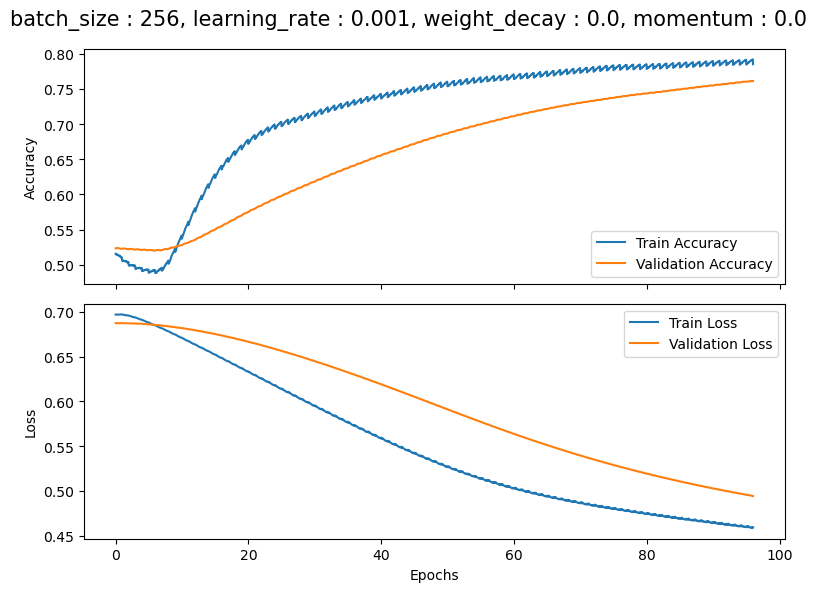

Train accuracy:  79.1
Validation accuracy:  78.8



Combination 7 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.0



Epoch: 1/6, Train loss:  0.519, Train accuracy:  76.1%: 100%|██████████| 563/563 [00:05<00:00, 103.33it/s]
Epoch: 1/6, Val loss:  0.440, Val accuracy:  81.2%: 100%|██████████| 63/63 [00:00<00:00, 420.18it/s]


Epoch: 2/6, Train loss:  0.419, Train accuracy:  82.1%: 100%|██████████| 563/563 [00:09<00:00, 62.29it/s]
Epoch: 2/6, Val loss:  0.411, Val accuracy:  82.3%: 100%|██████████| 63/63 [00:00<00:00, 319.70it/s]


Epoch: 3/6, Train loss:  0.376, Train accuracy:  84.3%: 100%|██████████| 563/563 [00:09<00:00, 60.49it/s]
Epoch: 3/6, Val loss:  0.401, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 228.87it/s]


Epoch: 4/6, Train loss:  0.342, Train accuracy:  86.0%: 100%|██████████| 563/563 [00:08<00:00, 65.15it/s]
Epoch: 4/6, Val loss:  0.393, Val accuracy:  83.7%: 100%|██████████| 63/63 [00:00<00:00, 393.13it/s]


Epoch: 5/6, Train loss:  0.312, Train accuracy:  87.4%: 100%|██████████| 563/563 [00:14<00:00, 39.53it/s]
Epoch: 5/6, Val loss:  0.395, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 174.16it/s]


Epoch: 6/6, Train loss:  0.283, Train accuracy:  89.0%: 100%|██████████| 563/563 [00:18<00:00, 30.78it/s]
Epoch: 6/6, Val loss:  0.404, Val accuracy:  84.2%: 100%|██████████| 63/63 [00:00<00:00, 177.12it/s]


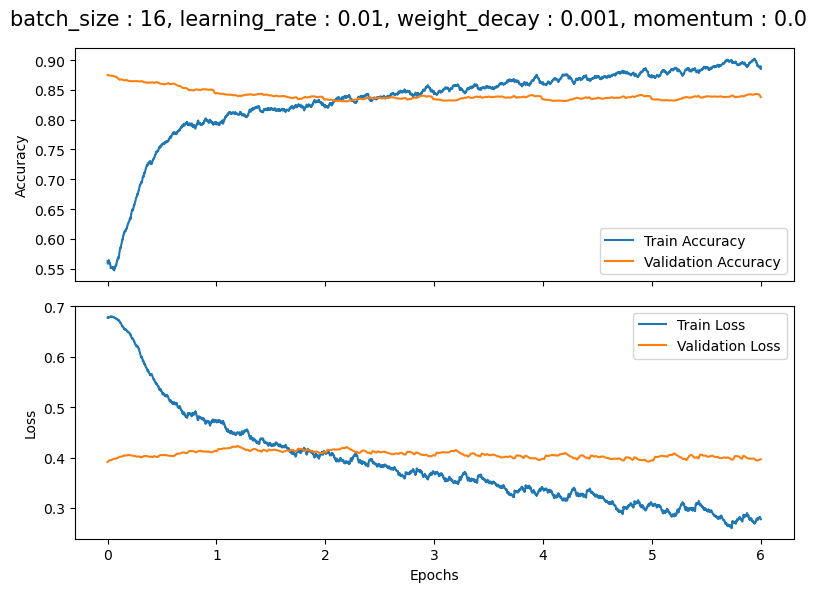

Train accuracy:  89.8
Validation accuracy:  84.2



Combination 8 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.0



Epoch: 1/24, Train loss:  0.625, Train accuracy:  66.3%: 100%|██████████| 141/141 [00:01<00:00, 109.11it/s]
Epoch: 1/24, Val loss:  0.558, Val accuracy:  74.0%: 100%|██████████| 16/16 [00:00<00:00, 272.25it/s]


Epoch: 2/24, Train loss:  0.507, Train accuracy:  78.1%: 100%|██████████| 141/141 [00:01<00:00, 80.35it/s]
Epoch: 2/24, Val loss:  0.479, Val accuracy:  77.8%: 100%|██████████| 16/16 [00:00<00:00, 217.93it/s]


Epoch: 3/24, Train loss:  0.462, Train accuracy:  80.2%: 100%|██████████| 141/141 [00:01<00:00, 78.37it/s]
Epoch: 3/24, Val loss:  0.454, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 175.94it/s]


Epoch: 4/24, Train loss:  0.434, Train accuracy:  81.6%: 100%|██████████| 141/141 [00:01<00:00, 78.59it/s]
Epoch: 4/24, Val loss:  0.438, Val accuracy:  79.6%: 100%|██████████| 16/16 [00:00<00:00, 224.81it/s]


Epoch: 5/24, Train loss:  0.408, Train accuracy:  82.7%: 100%|██████████| 141/141 [00:01<00:00, 87.21it/s]
Epoch: 5/24, Val loss:  0.426, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 225.99it/s]


Epoch: 6/24, Train loss:  0.385, Train accuracy:  83.7%: 100%|██████████| 141/141 [00:01<00:00, 80.79it/s]
Epoch: 6/24, Val loss:  0.418, Val accuracy:  80.7%: 100%|██████████| 16/16 [00:00<00:00, 200.36it/s]


Epoch: 7/24, Train loss:  0.365, Train accuracy:  84.7%: 100%|██████████| 141/141 [00:01<00:00, 80.40it/s]
Epoch: 7/24, Val loss:  0.410, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 218.90it/s]


Epoch: 8/24, Train loss:  0.346, Train accuracy:  85.7%: 100%|██████████| 141/141 [00:01<00:00, 80.67it/s]
Epoch: 8/24, Val loss:  0.404, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 237.48it/s]


Epoch: 9/24, Train loss:  0.328, Train accuracy:  86.3%: 100%|██████████| 141/141 [00:01<00:00, 78.83it/s]
Epoch: 9/24, Val loss:  0.398, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 230.45it/s]


Epoch: 10/24, Train loss:  0.310, Train accuracy:  87.4%: 100%|██████████| 141/141 [00:01<00:00, 81.34it/s]
Epoch: 10/24, Val loss:  0.393, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 195.58it/s]


Epoch: 11/24, Train loss:  0.294, Train accuracy:  88.3%: 100%|██████████| 141/141 [00:01<00:00, 77.17it/s]
Epoch: 11/24, Val loss:  0.390, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 238.37it/s]


Epoch: 12/24, Train loss:  0.278, Train accuracy:  89.3%: 100%|██████████| 141/141 [00:01<00:00, 77.97it/s]
Epoch: 12/24, Val loss:  0.389, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 222.63it/s]


Epoch: 13/24, Train loss:  0.264, Train accuracy:  90.0%: 100%|██████████| 141/141 [00:01<00:00, 78.03it/s]
Epoch: 13/24, Val loss:  0.389, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 217.13it/s]


Epoch: 14/24, Train loss:  0.251, Train accuracy:  90.7%: 100%|██████████| 141/141 [00:01<00:00, 76.37it/s]
Epoch: 14/24, Val loss:  0.391, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 248.71it/s]


Epoch: 15/24, Train loss:  0.240, Train accuracy:  91.2%: 100%|██████████| 141/141 [00:01<00:00, 79.33it/s]
Epoch: 15/24, Val loss:  0.394, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 219.49it/s]


Epoch: 16/24, Train loss:  0.229, Train accuracy:  91.7%: 100%|██████████| 141/141 [00:01<00:00, 75.77it/s]
Epoch: 16/24, Val loss:  0.397, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 238.29it/s]


Epoch: 17/24, Train loss:  0.211, Train accuracy:  92.5%: 100%|██████████| 141/141 [00:01<00:00, 81.44it/s]
Epoch: 17/24, Val loss:  0.398, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 230.84it/s]


Epoch: 18/24, Train loss:  0.208, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:01<00:00, 83.36it/s]
Epoch: 18/24, Val loss:  0.417, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 224.98it/s]


Epoch: 19/24, Train loss:  0.188, Train accuracy:  93.4%: 100%|██████████| 141/141 [00:01<00:00, 81.32it/s]
Epoch: 19/24, Val loss:  0.847, Val accuracy:  70.4%: 100%|██████████| 16/16 [00:00<00:00, 197.54it/s]


Epoch: 20/24, Train loss:  0.201, Train accuracy:  93.1%: 100%|██████████| 141/141 [00:01<00:00, 80.69it/s]
Epoch: 20/24, Val loss:  0.473, Val accuracy:  81.4%: 100%|██████████| 16/16 [00:00<00:00, 214.39it/s]


Epoch: 21/24, Train loss:  0.178, Train accuracy:  94.0%: 100%|██████████| 141/141 [00:01<00:00, 78.80it/s]
Epoch: 21/24, Val loss:  0.441, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 209.73it/s]


Epoch: 22/24, Train loss:  0.153, Train accuracy:  95.1%: 100%|██████████| 141/141 [00:01<00:00, 83.03it/s]
Epoch: 22/24, Val loss:  0.424, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 221.87it/s]


Epoch: 23/24, Train loss:  0.146, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:01<00:00, 79.43it/s]
Epoch: 23/24, Val loss:  0.851, Val accuracy:  71.8%: 100%|██████████| 16/16 [00:00<00:00, 199.78it/s]


Epoch: 24/24, Train loss:  0.158, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 77.41it/s]
Epoch: 24/24, Val loss:  0.447, Val accuracy:  83.1%: 100%|██████████| 16/16 [00:00<00:00, 243.61it/s]


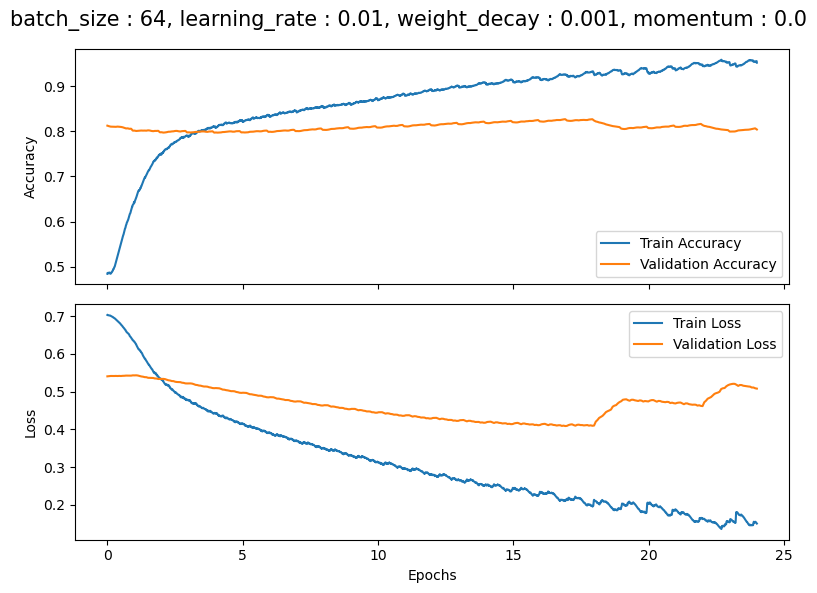

Train accuracy:  95.6
Validation accuracy:  83.1



Combination 9 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.0



Epoch: 1/96, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 83.25it/s]
Epoch: 1/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 116.68it/s]


Epoch: 2/96, Train loss:  0.643, Train accuracy:  65.4%: 100%|██████████| 36/36 [00:00<00:00, 82.13it/s]
Epoch: 2/96, Val loss:  0.623, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 117.37it/s]


Epoch: 3/96, Train loss:  0.605, Train accuracy:  70.7%: 100%|██████████| 36/36 [00:00<00:00, 84.99it/s]
Epoch: 3/96, Val loss:  0.588, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


Epoch: 4/96, Train loss:  0.569, Train accuracy:  73.3%: 100%|██████████| 36/36 [00:00<00:00, 89.04it/s]
Epoch: 4/96, Val loss:  0.554, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 116.71it/s]


Epoch: 5/96, Train loss:  0.536, Train accuracy:  75.2%: 100%|██████████| 36/36 [00:00<00:00, 84.37it/s]
Epoch: 5/96, Val loss:  0.523, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 109.84it/s]


Epoch: 6/96, Train loss:  0.510, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 82.65it/s]
Epoch: 6/96, Val loss:  0.500, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 117.43it/s]


Epoch: 7/96, Train loss:  0.492, Train accuracy:  77.1%: 100%|██████████| 36/36 [00:00<00:00, 83.76it/s]
Epoch: 7/96, Val loss:  0.485, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 99.73it/s]


Epoch: 8/96, Train loss:  0.479, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 82.45it/s]
Epoch: 8/96, Val loss:  0.475, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 122.89it/s]


Epoch: 9/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 80.05it/s]
Epoch: 9/96, Val loss:  0.467, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 123.73it/s]


Epoch: 10/96, Train loss:  0.460, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 83.50it/s]
Epoch: 10/96, Val loss:  0.460, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 110.82it/s]


Epoch: 11/96, Train loss:  0.452, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 69.71it/s]
Epoch: 11/96, Val loss:  0.454, Val accuracy:  79.0%: 100%|██████████| 4/4 [00:00<00:00, 112.19it/s]


Epoch: 12/96, Train loss:  0.443, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 86.59it/s]
Epoch: 12/96, Val loss:  0.449, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 90.65it/s]


Epoch: 13/96, Train loss:  0.435, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 81.23it/s]
Epoch: 13/96, Val loss:  0.445, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 117.17it/s]


Epoch: 14/96, Train loss:  0.426, Train accuracy:  80.2%: 100%|██████████| 36/36 [00:00<00:00, 81.01it/s]
Epoch: 14/96, Val loss:  0.441, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 120.76it/s]


Epoch: 15/96, Train loss:  0.418, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 80.89it/s]
Epoch: 15/96, Val loss:  0.437, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 95.74it/s]


Epoch: 16/96, Train loss:  0.410, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 82.80it/s]
Epoch: 16/96, Val loss:  0.433, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 115.76it/s]


Epoch: 17/96, Train loss:  0.402, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 79.75it/s]
Epoch: 17/96, Val loss:  0.430, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 115.79it/s]


Epoch: 18/96, Train loss:  0.395, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 81.03it/s]
Epoch: 18/96, Val loss:  0.427, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 113.79it/s]


Epoch: 19/96, Train loss:  0.388, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 80.05it/s]
Epoch: 19/96, Val loss:  0.425, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 120.99it/s]


Epoch: 20/96, Train loss:  0.380, Train accuracy:  82.3%: 100%|██████████| 36/36 [00:00<00:00, 84.09it/s]
Epoch: 20/96, Val loss:  0.422, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 116.69it/s]


Epoch: 21/96, Train loss:  0.373, Train accuracy:  82.7%: 100%|██████████| 36/36 [00:00<00:00, 81.50it/s]
Epoch: 21/96, Val loss:  0.419, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 95.82it/s]


Epoch: 22/96, Train loss:  0.366, Train accuracy:  83.0%: 100%|██████████| 36/36 [00:00<00:00, 84.05it/s]
Epoch: 22/96, Val loss:  0.417, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 118.55it/s]


Epoch: 23/96, Train loss:  0.359, Train accuracy:  83.3%: 100%|██████████| 36/36 [00:00<00:00, 81.43it/s]
Epoch: 23/96, Val loss:  0.414, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 119.22it/s]


Epoch: 24/96, Train loss:  0.352, Train accuracy:  83.6%: 100%|██████████| 36/36 [00:00<00:00, 80.42it/s]
Epoch: 24/96, Val loss:  0.412, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 113.74it/s]


Epoch: 25/96, Train loss:  0.345, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 89.93it/s]
Epoch: 25/96, Val loss:  0.410, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 119.23it/s]


Epoch: 26/96, Train loss:  0.339, Train accuracy:  84.3%: 100%|██████████| 36/36 [00:00<00:00, 79.66it/s]
Epoch: 26/96, Val loss:  0.407, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 115.92it/s]


Epoch: 27/96, Train loss:  0.332, Train accuracy:  84.6%: 100%|██████████| 36/36 [00:00<00:00, 81.16it/s]
Epoch: 27/96, Val loss:  0.405, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 117.76it/s]


Epoch: 28/96, Train loss:  0.325, Train accuracy:  85.0%: 100%|██████████| 36/36 [00:00<00:00, 79.51it/s]
Epoch: 28/96, Val loss:  0.402, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 115.29it/s]


Epoch: 29/96, Train loss:  0.318, Train accuracy:  85.2%: 100%|██████████| 36/36 [00:00<00:00, 81.06it/s]
Epoch: 29/96, Val loss:  0.400, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 115.81it/s]


Epoch: 30/96, Train loss:  0.311, Train accuracy:  85.4%: 100%|██████████| 36/36 [00:00<00:00, 80.36it/s]
Epoch: 30/96, Val loss:  0.398, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 113.62it/s]


Epoch: 31/96, Train loss:  0.304, Train accuracy:  85.8%: 100%|██████████| 36/36 [00:00<00:00, 79.98it/s]
Epoch: 31/96, Val loss:  0.395, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 109.46it/s]


Epoch: 32/96, Train loss:  0.297, Train accuracy:  86.1%: 100%|██████████| 36/36 [00:00<00:00, 80.69it/s]
Epoch: 32/96, Val loss:  0.393, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 112.36it/s]


Epoch: 33/96, Train loss:  0.291, Train accuracy:  86.3%: 100%|██████████| 36/36 [00:00<00:00, 80.96it/s]
Epoch: 33/96, Val loss:  0.391, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 119.60it/s]


Epoch: 34/96, Train loss:  0.284, Train accuracy:  86.8%: 100%|██████████| 36/36 [00:00<00:00, 78.89it/s]
Epoch: 34/96, Val loss:  0.389, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 115.69it/s]


Epoch: 35/96, Train loss:  0.278, Train accuracy:  87.1%: 100%|██████████| 36/36 [00:00<00:00, 84.19it/s]
Epoch: 35/96, Val loss:  0.387, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 117.40it/s]


Epoch: 36/96, Train loss:  0.272, Train accuracy:  87.5%: 100%|██████████| 36/36 [00:00<00:00, 83.97it/s]
Epoch: 36/96, Val loss:  0.385, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 112.89it/s]


Epoch: 37/96, Train loss:  0.266, Train accuracy:  87.8%: 100%|██████████| 36/36 [00:00<00:00, 80.60it/s]
Epoch: 37/96, Val loss:  0.386, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 117.31it/s]


Epoch: 38/96, Train loss:  0.261, Train accuracy:  88.2%: 100%|██████████| 36/36 [00:00<00:00, 68.02it/s]
Epoch: 38/96, Val loss:  0.394, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 119.14it/s]


Epoch: 39/96, Train loss:  0.258, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 81.04it/s]
Epoch: 39/96, Val loss:  0.423, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 114.04it/s]


Epoch: 40/96, Train loss:  0.256, Train accuracy:  88.4%: 100%|██████████| 36/36 [00:00<00:00, 80.07it/s]
Epoch: 40/96, Val loss:  0.446, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 116.73it/s]


Epoch: 41/96, Train loss:  0.256, Train accuracy:  88.4%: 100%|██████████| 36/36 [00:00<00:00, 79.25it/s]
Epoch: 41/96, Val loss:  0.487, Val accuracy:  78.8%: 100%|██████████| 4/4 [00:00<00:00, 115.78it/s]


Epoch: 42/96, Train loss:  0.253, Train accuracy:  88.6%: 100%|██████████| 36/36 [00:00<00:00, 81.42it/s]
Epoch: 42/96, Val loss:  0.441, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 109.21it/s]


Epoch: 43/96, Train loss:  0.248, Train accuracy:  88.9%: 100%|██████████| 36/36 [00:00<00:00, 80.58it/s]
Epoch: 43/96, Val loss:  0.475, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 119.14it/s]


Epoch: 44/96, Train loss:  0.247, Train accuracy:  88.8%: 100%|██████████| 36/36 [00:00<00:00, 78.93it/s]
Epoch: 44/96, Val loss:  0.462, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 117.46it/s]


Epoch: 45/96, Train loss:  0.244, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 80.37it/s]
Epoch: 45/96, Val loss:  0.467, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 114.04it/s]


Epoch: 46/96, Train loss:  0.225, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 81.65it/s]
Epoch: 46/96, Val loss:  0.460, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 116.38it/s]


Epoch: 47/96, Train loss:  0.241, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 82.01it/s]
Epoch: 47/96, Val loss:  0.406, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 110.82it/s]


Epoch: 48/96, Train loss:  0.226, Train accuracy:  89.6%: 100%|██████████| 36/36 [00:00<00:00, 80.20it/s]
Epoch: 48/96, Val loss:  0.409, Val accuracy:  81.9%: 100%|██████████| 4/4 [00:00<00:00, 102.30it/s]


Epoch: 49/96, Train loss:  0.217, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 80.95it/s]
Epoch: 49/96, Val loss:  0.541, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 102.37it/s]


Epoch: 50/96, Train loss:  0.269, Train accuracy:  87.9%: 100%|██████████| 36/36 [00:00<00:00, 78.34it/s]
Epoch: 50/96, Val loss:  0.650, Val accuracy:  74.3%: 100%|██████████| 4/4 [00:00<00:00, 103.36it/s]


Epoch: 51/96, Train loss:  0.205, Train accuracy:  90.8%: 100%|██████████| 36/36 [00:00<00:00, 82.44it/s]
Epoch: 51/96, Val loss:  0.392, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 112.66it/s]


Epoch: 52/96, Train loss:  0.215, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 83.76it/s]
Epoch: 52/96, Val loss:  0.400, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 102.98it/s]


Epoch: 53/96, Train loss:  0.223, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 81.41it/s]
Epoch: 53/96, Val loss:  0.389, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 114.09it/s]


Epoch: 54/96, Train loss:  0.247, Train accuracy:  89.4%: 100%|██████████| 36/36 [00:00<00:00, 81.96it/s]
Epoch: 54/96, Val loss:  0.599, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 113.53it/s]


Epoch: 55/96, Train loss:  0.199, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 80.78it/s]
Epoch: 55/96, Val loss:  0.391, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 122.86it/s]


Epoch: 56/96, Train loss:  0.199, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 81.59it/s]
Epoch: 56/96, Val loss:  0.389, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 119.48it/s]


Epoch: 57/96, Train loss:  0.232, Train accuracy:  89.8%: 100%|██████████| 36/36 [00:00<00:00, 82.55it/s]
Epoch: 57/96, Val loss:  0.630, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 106.42it/s]


Epoch: 58/96, Train loss:  0.196, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 81.19it/s]
Epoch: 58/96, Val loss:  0.391, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 114.96it/s]


Epoch: 59/96, Train loss:  0.180, Train accuracy:  91.9%: 100%|██████████| 36/36 [00:00<00:00, 83.05it/s]
Epoch: 59/96, Val loss:  0.392, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 90.60it/s]


Epoch: 60/96, Train loss:  0.187, Train accuracy:  92.5%: 100%|██████████| 36/36 [00:00<00:00, 81.21it/s]
Epoch: 60/96, Val loss:  0.574, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 114.57it/s]


Epoch: 61/96, Train loss:  0.197, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 80.24it/s]
Epoch: 61/96, Val loss:  0.442, Val accuracy:  81.9%: 100%|██████████| 4/4 [00:00<00:00, 121.00it/s]


Epoch: 62/96, Train loss:  0.202, Train accuracy:  90.9%: 100%|██████████| 36/36 [00:00<00:00, 79.27it/s]
Epoch: 62/96, Val loss:  0.410, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 118.65it/s]


Epoch: 63/96, Train loss:  0.168, Train accuracy:  92.5%: 100%|██████████| 36/36 [00:00<00:00, 81.94it/s]
Epoch: 63/96, Val loss:  0.394, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 114.11it/s]


Epoch: 64/96, Train loss:  0.218, Train accuracy:  90.6%: 100%|██████████| 36/36 [00:00<00:00, 66.43it/s]
Epoch: 64/96, Val loss:  0.510, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


Epoch: 65/96, Train loss:  0.167, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 82.09it/s]
Epoch: 65/96, Val loss:  0.398, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 114.03it/s]


Epoch: 66/96, Train loss:  0.197, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 83.27it/s]
Epoch: 66/96, Val loss:  0.515, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 109.42it/s]


Epoch: 67/96, Train loss:  0.161, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 81.91it/s]
Epoch: 67/96, Val loss:  0.400, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 110.87it/s]


Epoch: 68/96, Train loss:  0.135, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 84.02it/s]
Epoch: 68/96, Val loss:  0.403, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 103.42it/s]


Epoch: 69/96, Train loss:  0.183, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 82.61it/s]
Epoch: 69/96, Val loss:  0.396, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 118.80it/s]


Epoch: 70/96, Train loss:  0.150, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 81.54it/s]
Epoch: 70/96, Val loss:  0.398, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 119.35it/s]


Epoch: 71/96, Train loss:  0.167, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 81.14it/s]
Epoch: 71/96, Val loss:  0.640, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 116.09it/s]


Epoch: 72/96, Train loss:  0.190, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 82.23it/s]
Epoch: 72/96, Val loss:  0.407, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 115.79it/s]


Epoch: 73/96, Train loss:  0.130, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 82.21it/s]
Epoch: 73/96, Val loss:  0.404, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 117.41it/s]


Epoch: 74/96, Train loss:  0.154, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 80.08it/s]
Epoch: 74/96, Val loss:  0.573, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 105.75it/s]


Epoch: 75/96, Train loss:  0.149, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 79.21it/s]
Epoch: 75/96, Val loss:  0.410, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 109.97it/s]


Epoch: 76/96, Train loss:  0.138, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 80.73it/s]
Epoch: 76/96, Val loss:  0.410, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 108.36it/s]


Epoch: 77/96, Train loss:  0.169, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 81.62it/s]
Epoch: 77/96, Val loss:  0.413, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 105.05it/s]


Epoch: 78/96, Train loss:  0.100, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 82.92it/s]
Epoch: 78/96, Val loss:  0.414, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 110.95it/s]


Epoch: 79/96, Train loss:  0.126, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 79.16it/s]
Epoch: 79/96, Val loss:  0.418, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 113.66it/s]


Epoch: 80/96, Train loss:  0.173, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 81.57it/s]
Epoch: 80/96, Val loss:  0.493, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 115.80it/s]


Epoch: 81/96, Train loss:  0.139, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 82.54it/s]
Epoch: 81/96, Val loss:  0.680, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 110.33it/s]


Epoch: 82/96, Train loss:  0.132, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 77.94it/s]
Epoch: 82/96, Val loss:  0.497, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 106.46it/s]


Epoch: 83/96, Train loss:  0.113, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 81.93it/s]
Epoch: 83/96, Val loss:  0.414, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 112.47it/s]


Epoch: 84/96, Train loss:  0.165, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 81.76it/s]
Epoch: 84/96, Val loss:  0.477, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 110.89it/s]


Epoch: 85/96, Train loss:  0.138, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 81.87it/s]
Epoch: 85/96, Val loss:  0.482, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 114.42it/s]


Epoch: 86/96, Train loss:  0.086, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 81.19it/s]
Epoch: 86/96, Val loss:  0.424, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 110.85it/s]


Epoch: 87/96, Train loss:  0.167, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 84.19it/s]
Epoch: 87/96, Val loss:  0.430, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 113.32it/s]


Epoch: 88/96, Train loss:  0.085, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 81.50it/s]
Epoch: 88/96, Val loss:  0.428, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 117.42it/s]


Epoch: 89/96, Train loss:  0.076, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 83.50it/s]
Epoch: 89/96, Val loss:  0.440, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 115.68it/s]


Epoch: 90/96, Train loss:  0.118, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 68.91it/s]
Epoch: 90/96, Val loss:  0.639, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 119.58it/s]


Epoch: 91/96, Train loss:  0.131, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 83.54it/s]
Epoch: 91/96, Val loss:  0.523, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 104.99it/s]


Epoch: 92/96, Train loss:  0.117, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 83.74it/s]
Epoch: 92/96, Val loss:  0.426, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 102.32it/s]


Epoch: 93/96, Train loss:  0.147, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 80.21it/s]
Epoch: 93/96, Val loss:  0.493, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 118.80it/s]


Epoch: 94/96, Train loss:  0.070, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 80.63it/s]
Epoch: 94/96, Val loss:  0.444, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 115.74it/s]


Epoch: 95/96, Train loss:  0.105, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 80.59it/s]
Epoch: 95/96, Val loss:  0.442, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 114.08it/s]


Epoch: 96/96, Train loss:  0.061, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 80.27it/s]
Epoch: 96/96, Val loss:  0.444, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


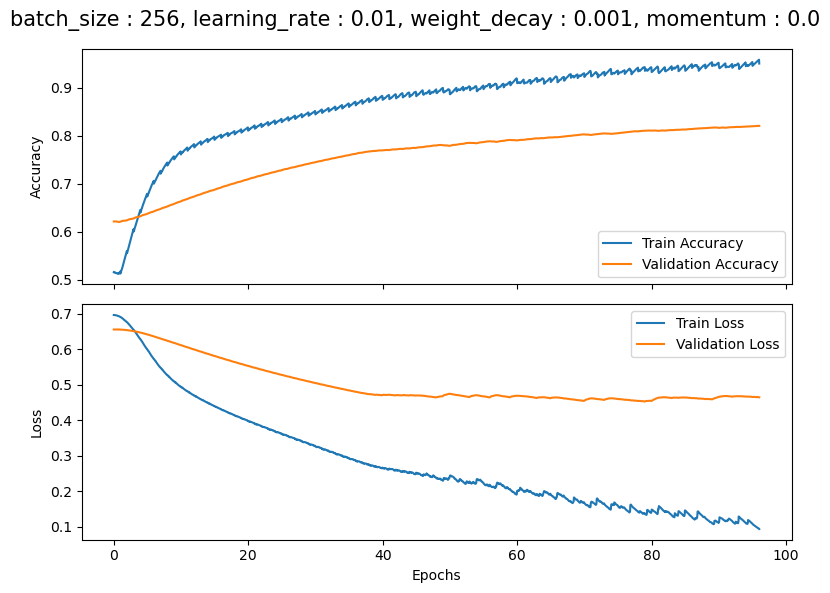

Train accuracy:  96.6
Validation accuracy:  84.3



Combination 10 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.0



Epoch: 1/6, Train loss:  0.669, Train accuracy:  56.7%: 100%|██████████| 563/563 [00:10<00:00, 52.10it/s] 
Epoch: 1/6, Val loss:  0.638, Val accuracy:  68.6%: 100%|██████████| 63/63 [00:00<00:00, 211.78it/s]


Epoch: 2/6, Train loss:  0.609, Train accuracy:  71.9%: 100%|██████████| 563/563 [00:18<00:00, 30.36it/s]
Epoch: 2/6, Val loss:  0.584, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 158.63it/s]


Epoch: 3/6, Train loss:  0.552, Train accuracy:  75.8%: 100%|██████████| 563/563 [00:18<00:00, 30.59it/s]
Epoch: 3/6, Val loss:  0.532, Val accuracy:  76.7%: 100%|██████████| 63/63 [00:00<00:00, 179.89it/s]


Epoch: 4/6, Train loss:  0.509, Train accuracy:  78.2%: 100%|██████████| 563/563 [00:18<00:00, 30.64it/s]
Epoch: 4/6, Val loss:  0.497, Val accuracy:  78.0%: 100%|██████████| 63/63 [00:00<00:00, 189.71it/s]


Epoch: 5/6, Train loss:  0.484, Train accuracy:  79.3%: 100%|██████████| 563/563 [00:18<00:00, 30.08it/s]
Epoch: 5/6, Val loss:  0.478, Val accuracy:  78.6%: 100%|██████████| 63/63 [00:00<00:00, 166.60it/s]


Epoch: 6/6, Train loss:  0.468, Train accuracy:  80.1%: 100%|██████████| 563/563 [00:18<00:00, 30.11it/s]
Epoch: 6/6, Val loss:  0.466, Val accuracy:  80.0%: 100%|██████████| 63/63 [00:00<00:00, 164.62it/s]


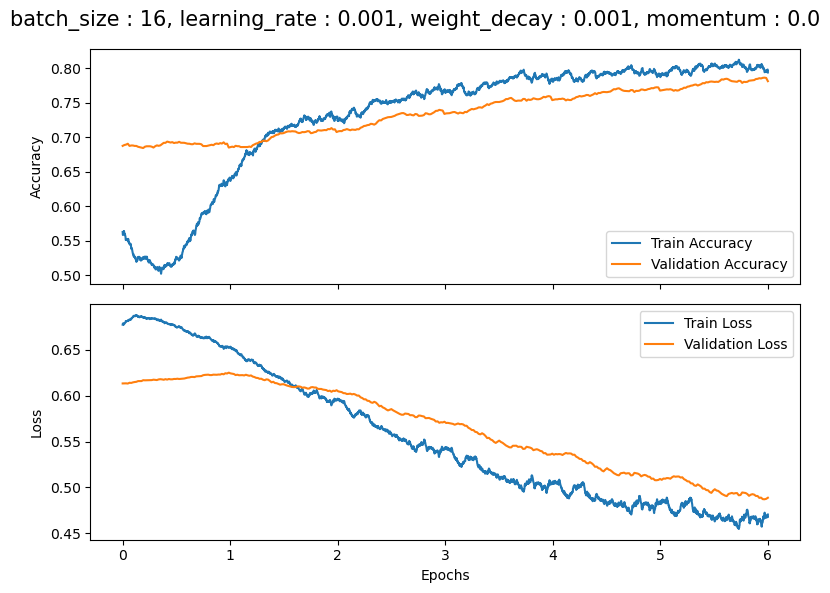

Train accuracy:  80.7
Validation accuracy:  80.0



Combination 11 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.0



Epoch: 1/24, Train loss:  0.691, Train accuracy:  49.6%: 100%|██████████| 141/141 [00:01<00:00, 112.35it/s]
Epoch: 1/24, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 16/16 [00:00<00:00, 244.40it/s]


Epoch: 2/24, Train loss:  0.676, Train accuracy:  51.0%: 100%|██████████| 141/141 [00:01<00:00, 81.49it/s]
Epoch: 2/24, Val loss:  0.665, Val accuracy:  55.8%: 100%|██████████| 16/16 [00:00<00:00, 206.54it/s]


Epoch: 3/24, Train loss:  0.661, Train accuracy:  60.2%: 100%|██████████| 141/141 [00:01<00:00, 79.85it/s]
Epoch: 3/24, Val loss:  0.651, Val accuracy:  62.7%: 100%|██████████| 16/16 [00:00<00:00, 215.71it/s]


Epoch: 4/24, Train loss:  0.646, Train accuracy:  66.4%: 100%|██████████| 141/141 [00:01<00:00, 79.93it/s]
Epoch: 4/24, Val loss:  0.638, Val accuracy:  67.2%: 100%|██████████| 16/16 [00:00<00:00, 221.79it/s]


Epoch: 5/24, Train loss:  0.631, Train accuracy:  69.6%: 100%|██████████| 141/141 [00:01<00:00, 80.29it/s]
Epoch: 5/24, Val loss:  0.624, Val accuracy:  69.3%: 100%|██████████| 16/16 [00:00<00:00, 206.08it/s]


Epoch: 6/24, Train loss:  0.616, Train accuracy:  71.7%: 100%|██████████| 141/141 [00:01<00:00, 78.22it/s]
Epoch: 6/24, Val loss:  0.611, Val accuracy:  70.5%: 100%|██████████| 16/16 [00:00<00:00, 222.52it/s]


Epoch: 7/24, Train loss:  0.600, Train accuracy:  72.5%: 100%|██████████| 141/141 [00:01<00:00, 79.78it/s]
Epoch: 7/24, Val loss:  0.597, Val accuracy:  71.0%: 100%|██████████| 16/16 [00:00<00:00, 226.18it/s]


Epoch: 8/24, Train loss:  0.586, Train accuracy:  73.6%: 100%|██████████| 141/141 [00:01<00:00, 78.24it/s]
Epoch: 8/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 240.03it/s]


Epoch: 9/24, Train loss:  0.571, Train accuracy:  74.8%: 100%|██████████| 141/141 [00:01<00:00, 78.47it/s]
Epoch: 9/24, Val loss:  0.571, Val accuracy:  72.9%: 100%|██████████| 16/16 [00:00<00:00, 228.03it/s]


Epoch: 10/24, Train loss:  0.557, Train accuracy:  75.5%: 100%|██████████| 141/141 [00:01<00:00, 79.67it/s]
Epoch: 10/24, Val loss:  0.557, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 200.82it/s]


Epoch: 11/24, Train loss:  0.544, Train accuracy:  76.2%: 100%|██████████| 141/141 [00:01<00:00, 77.80it/s]
Epoch: 11/24, Val loss:  0.545, Val accuracy:  74.4%: 100%|██████████| 16/16 [00:00<00:00, 222.75it/s]


Epoch: 12/24, Train loss:  0.532, Train accuracy:  76.9%: 100%|██████████| 141/141 [00:01<00:00, 77.38it/s]
Epoch: 12/24, Val loss:  0.533, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 240.01it/s]


Epoch: 13/24, Train loss:  0.521, Train accuracy:  77.5%: 100%|██████████| 141/141 [00:01<00:00, 79.97it/s]
Epoch: 13/24, Val loss:  0.522, Val accuracy:  75.6%: 100%|██████████| 16/16 [00:00<00:00, 232.86it/s]


Epoch: 14/24, Train loss:  0.511, Train accuracy:  78.0%: 100%|██████████| 141/141 [00:01<00:00, 77.59it/s]
Epoch: 14/24, Val loss:  0.512, Val accuracy:  76.1%: 100%|██████████| 16/16 [00:00<00:00, 242.38it/s]


Epoch: 15/24, Train loss:  0.503, Train accuracy:  78.2%: 100%|██████████| 141/141 [00:01<00:00, 79.54it/s]
Epoch: 15/24, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 16/16 [00:00<00:00, 215.26it/s]


Epoch: 16/24, Train loss:  0.496, Train accuracy:  78.6%: 100%|██████████| 141/141 [00:01<00:00, 78.96it/s]
Epoch: 16/24, Val loss:  0.498, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 239.29it/s]


Epoch: 17/24, Train loss:  0.490, Train accuracy:  78.9%: 100%|██████████| 141/141 [00:01<00:00, 82.81it/s]
Epoch: 17/24, Val loss:  0.492, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 236.63it/s]


Epoch: 18/24, Train loss:  0.484, Train accuracy:  79.3%: 100%|██████████| 141/141 [00:01<00:00, 80.97it/s]
Epoch: 18/24, Val loss:  0.487, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 228.14it/s]


Epoch: 19/24, Train loss:  0.480, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:01<00:00, 79.70it/s]
Epoch: 19/24, Val loss:  0.482, Val accuracy:  77.2%: 100%|██████████| 16/16 [00:00<00:00, 241.97it/s]


Epoch: 20/24, Train loss:  0.475, Train accuracy:  79.8%: 100%|██████████| 141/141 [00:01<00:00, 81.21it/s]
Epoch: 20/24, Val loss:  0.478, Val accuracy:  77.4%: 100%|██████████| 16/16 [00:00<00:00, 228.17it/s]


Epoch: 21/24, Train loss:  0.471, Train accuracy:  79.9%: 100%|██████████| 141/141 [00:01<00:00, 79.52it/s]
Epoch: 21/24, Val loss:  0.475, Val accuracy:  77.7%: 100%|██████████| 16/16 [00:00<00:00, 235.61it/s]


Epoch: 22/24, Train loss:  0.468, Train accuracy:  80.1%: 100%|██████████| 141/141 [00:01<00:00, 78.64it/s]
Epoch: 22/24, Val loss:  0.472, Val accuracy:  77.9%: 100%|██████████| 16/16 [00:00<00:00, 240.13it/s]


Epoch: 23/24, Train loss:  0.464, Train accuracy:  80.2%: 100%|██████████| 141/141 [00:01<00:00, 80.23it/s]
Epoch: 23/24, Val loss:  0.469, Val accuracy:  78.4%: 100%|██████████| 16/16 [00:00<00:00, 231.53it/s]


Epoch: 24/24, Train loss:  0.461, Train accuracy:  80.5%: 100%|██████████| 141/141 [00:01<00:00, 79.90it/s]
Epoch: 24/24, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 249.52it/s]


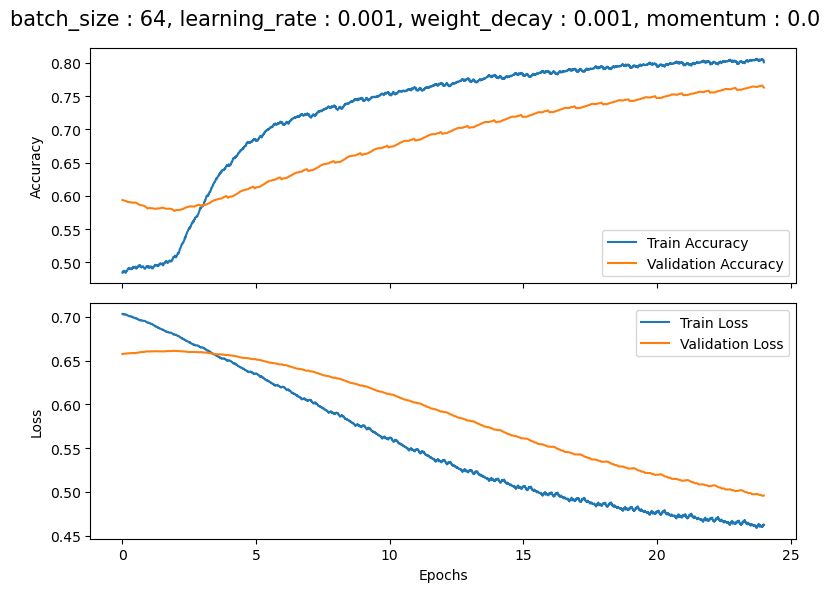

Train accuracy:  80.6
Validation accuracy:  78.5



Combination 12 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.0



Epoch: 1/96, Train loss:  0.698, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 85.64it/s]
Epoch: 1/96, Val loss:  0.689, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 112.51it/s]


Epoch: 2/96, Train loss:  0.693, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 85.19it/s]
Epoch: 2/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 120.57it/s]


Epoch: 3/96, Train loss:  0.689, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 85.01it/s]
Epoch: 3/96, Val loss:  0.681, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 118.52it/s]


Epoch: 4/96, Train loss:  0.685, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 84.76it/s]
Epoch: 4/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 116.42it/s]


Epoch: 5/96, Train loss:  0.681, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 82.46it/s]
Epoch: 5/96, Val loss:  0.674, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 119.27it/s]


Epoch: 6/96, Train loss:  0.678, Train accuracy:  48.9%: 100%|██████████| 36/36 [00:00<00:00, 82.57it/s]
Epoch: 6/96, Val loss:  0.671, Val accuracy:  50.7%: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


Epoch: 7/96, Train loss:  0.674, Train accuracy:  50.1%: 100%|██████████| 36/36 [00:00<00:00, 84.59it/s]
Epoch: 7/96, Val loss:  0.667, Val accuracy:  53.0%: 100%|██████████| 4/4 [00:00<00:00, 103.66it/s]


Epoch: 8/96, Train loss:  0.670, Train accuracy:  52.6%: 100%|██████████| 36/36 [00:00<00:00, 81.85it/s]
Epoch: 8/96, Val loss:  0.664, Val accuracy:  56.2%: 100%|██████████| 4/4 [00:00<00:00, 117.00it/s]


Epoch: 9/96, Train loss:  0.666, Train accuracy:  55.9%: 100%|██████████| 36/36 [00:00<00:00, 85.11it/s]
Epoch: 9/96, Val loss:  0.660, Val accuracy:  58.7%: 100%|██████████| 4/4 [00:00<00:00, 121.23it/s]


Epoch: 10/96, Train loss:  0.663, Train accuracy:  58.2%: 100%|██████████| 36/36 [00:00<00:00, 82.31it/s]
Epoch: 10/96, Val loss:  0.657, Val accuracy:  59.2%: 100%|██████████| 4/4 [00:00<00:00, 111.72it/s]


Epoch: 11/96, Train loss:  0.659, Train accuracy:  60.4%: 100%|██████████| 36/36 [00:00<00:00, 84.86it/s]
Epoch: 11/96, Val loss:  0.653, Val accuracy:  61.6%: 100%|██████████| 4/4 [00:00<00:00, 119.23it/s]


Epoch: 12/96, Train loss:  0.655, Train accuracy:  62.3%: 100%|██████████| 36/36 [00:00<00:00, 84.13it/s]
Epoch: 12/96, Val loss:  0.650, Val accuracy:  63.1%: 100%|██████████| 4/4 [00:00<00:00, 118.70it/s]


Epoch: 13/96, Train loss:  0.651, Train accuracy:  63.7%: 100%|██████████| 36/36 [00:00<00:00, 69.49it/s]
Epoch: 13/96, Val loss:  0.646, Val accuracy:  65.2%: 100%|██████████| 4/4 [00:00<00:00, 115.78it/s]


Epoch: 14/96, Train loss:  0.647, Train accuracy:  64.9%: 100%|██████████| 36/36 [00:00<00:00, 83.11it/s]
Epoch: 14/96, Val loss:  0.643, Val accuracy:  66.4%: 100%|██████████| 4/4 [00:00<00:00, 105.60it/s]


Epoch: 15/96, Train loss:  0.644, Train accuracy:  65.9%: 100%|██████████| 36/36 [00:00<00:00, 82.53it/s]
Epoch: 15/96, Val loss:  0.639, Val accuracy:  67.1%: 100%|██████████| 4/4 [00:00<00:00, 96.16it/s]


Epoch: 16/96, Train loss:  0.640, Train accuracy:  66.7%: 100%|██████████| 36/36 [00:00<00:00, 84.91it/s]
Epoch: 16/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 115.65it/s]


Epoch: 17/96, Train loss:  0.636, Train accuracy:  67.4%: 100%|██████████| 36/36 [00:00<00:00, 84.51it/s]
Epoch: 17/96, Val loss:  0.632, Val accuracy:  68.1%: 100%|██████████| 4/4 [00:00<00:00, 118.68it/s]


Epoch: 18/96, Train loss:  0.632, Train accuracy:  68.1%: 100%|██████████| 36/36 [00:00<00:00, 83.61it/s]
Epoch: 18/96, Val loss:  0.629, Val accuracy:  68.8%: 100%|██████████| 4/4 [00:00<00:00, 118.48it/s]


Epoch: 19/96, Train loss:  0.628, Train accuracy:  68.6%: 100%|██████████| 36/36 [00:00<00:00, 84.81it/s]
Epoch: 19/96, Val loss:  0.625, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 109.47it/s]


Epoch: 20/96, Train loss:  0.625, Train accuracy:  69.3%: 100%|██████████| 36/36 [00:00<00:00, 84.91it/s]
Epoch: 20/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 121.00it/s]


Epoch: 21/96, Train loss:  0.621, Train accuracy:  69.8%: 100%|██████████| 36/36 [00:00<00:00, 81.33it/s]
Epoch: 21/96, Val loss:  0.618, Val accuracy:  69.6%: 100%|██████████| 4/4 [00:00<00:00, 112.56it/s]


Epoch: 22/96, Train loss:  0.617, Train accuracy:  70.1%: 100%|██████████| 36/36 [00:00<00:00, 83.21it/s]
Epoch: 22/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 110.82it/s]


Epoch: 23/96, Train loss:  0.613, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 80.28it/s]
Epoch: 23/96, Val loss:  0.612, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 126.66it/s]


Epoch: 24/96, Train loss:  0.609, Train accuracy:  70.6%: 100%|██████████| 36/36 [00:00<00:00, 83.05it/s]
Epoch: 24/96, Val loss:  0.608, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 112.44it/s]


Epoch: 25/96, Train loss:  0.605, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 82.56it/s]
Epoch: 25/96, Val loss:  0.605, Val accuracy:  70.4%: 100%|██████████| 4/4 [00:00<00:00, 100.67it/s]


Epoch: 26/96, Train loss:  0.602, Train accuracy:  71.1%: 100%|██████████| 36/36 [00:00<00:00, 85.92it/s]
Epoch: 26/96, Val loss:  0.601, Val accuracy:  70.5%: 100%|██████████| 4/4 [00:00<00:00, 120.26it/s]


Epoch: 27/96, Train loss:  0.598, Train accuracy:  71.2%: 100%|██████████| 36/36 [00:00<00:00, 85.10it/s]
Epoch: 27/96, Val loss:  0.598, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


Epoch: 28/96, Train loss:  0.594, Train accuracy:  71.5%: 100%|██████████| 36/36 [00:00<00:00, 80.16it/s]
Epoch: 28/96, Val loss:  0.594, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 111.79it/s]


Epoch: 29/96, Train loss:  0.590, Train accuracy:  71.8%: 100%|██████████| 36/36 [00:00<00:00, 83.87it/s]
Epoch: 29/96, Val loss:  0.591, Val accuracy:  71.2%: 100%|██████████| 4/4 [00:00<00:00, 107.88it/s]


Epoch: 30/96, Train loss:  0.587, Train accuracy:  72.1%: 100%|██████████| 36/36 [00:00<00:00, 81.94it/s]
Epoch: 30/96, Val loss:  0.587, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 106.56it/s]


Epoch: 31/96, Train loss:  0.583, Train accuracy:  72.4%: 100%|██████████| 36/36 [00:00<00:00, 83.86it/s]
Epoch: 31/96, Val loss:  0.584, Val accuracy:  71.9%: 100%|██████████| 4/4 [00:00<00:00, 107.89it/s]


Epoch: 32/96, Train loss:  0.579, Train accuracy:  72.7%: 100%|██████████| 36/36 [00:00<00:00, 82.56it/s]
Epoch: 32/96, Val loss:  0.580, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 106.53it/s]


Epoch: 33/96, Train loss:  0.576, Train accuracy:  72.9%: 100%|██████████| 36/36 [00:00<00:00, 83.35it/s]
Epoch: 33/96, Val loss:  0.577, Val accuracy:  72.6%: 100%|██████████| 4/4 [00:00<00:00, 121.00it/s]


Epoch: 34/96, Train loss:  0.572, Train accuracy:  73.1%: 100%|██████████| 36/36 [00:00<00:00, 80.64it/s]
Epoch: 34/96, Val loss:  0.574, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 113.99it/s]


Epoch: 35/96, Train loss:  0.569, Train accuracy:  73.4%: 100%|██████████| 36/36 [00:00<00:00, 79.11it/s]
Epoch: 35/96, Val loss:  0.570, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 99.73it/s]


Epoch: 36/96, Train loss:  0.565, Train accuracy:  73.6%: 100%|██████████| 36/36 [00:00<00:00, 83.66it/s]
Epoch: 36/96, Val loss:  0.567, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 109.38it/s]


Epoch: 37/96, Train loss:  0.562, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 83.56it/s]
Epoch: 37/96, Val loss:  0.563, Val accuracy:  73.0%: 100%|██████████| 4/4 [00:00<00:00, 107.70it/s]


Epoch: 38/96, Train loss:  0.558, Train accuracy:  74.1%: 100%|██████████| 36/36 [00:00<00:00, 84.12it/s]
Epoch: 38/96, Val loss:  0.560, Val accuracy:  73.7%: 100%|██████████| 4/4 [00:00<00:00, 115.68it/s]


Epoch: 39/96, Train loss:  0.555, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 68.39it/s]
Epoch: 39/96, Val loss:  0.557, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 102.27it/s]


Epoch: 40/96, Train loss:  0.551, Train accuracy:  74.4%: 100%|██████████| 36/36 [00:00<00:00, 80.99it/s]
Epoch: 40/96, Val loss:  0.553, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 110.93it/s]


Epoch: 41/96, Train loss:  0.548, Train accuracy:  74.6%: 100%|██████████| 36/36 [00:00<00:00, 81.39it/s]
Epoch: 41/96, Val loss:  0.550, Val accuracy:  74.1%: 100%|██████████| 4/4 [00:00<00:00, 105.90it/s]


Epoch: 42/96, Train loss:  0.545, Train accuracy:  74.8%: 100%|██████████| 36/36 [00:00<00:00, 82.55it/s]
Epoch: 42/96, Val loss:  0.547, Val accuracy:  74.1%: 100%|██████████| 4/4 [00:00<00:00, 112.54it/s]


Epoch: 43/96, Train loss:  0.541, Train accuracy:  75.0%: 100%|██████████| 36/36 [00:00<00:00, 88.62it/s]
Epoch: 43/96, Val loss:  0.544, Val accuracy:  74.2%: 100%|██████████| 4/4 [00:00<00:00, 119.85it/s]


Epoch: 44/96, Train loss:  0.538, Train accuracy:  75.1%: 100%|██████████| 36/36 [00:00<00:00, 84.46it/s]
Epoch: 44/96, Val loss:  0.540, Val accuracy:  74.9%: 100%|██████████| 4/4 [00:00<00:00, 117.42it/s]


Epoch: 45/96, Train loss:  0.535, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 80.87it/s]
Epoch: 45/96, Val loss:  0.537, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 116.81it/s]


Epoch: 46/96, Train loss:  0.532, Train accuracy:  75.4%: 100%|██████████| 36/36 [00:00<00:00, 82.79it/s]
Epoch: 46/96, Val loss:  0.534, Val accuracy:  75.2%: 100%|██████████| 4/4 [00:00<00:00, 103.35it/s]


Epoch: 47/96, Train loss:  0.529, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 82.89it/s]
Epoch: 47/96, Val loss:  0.531, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 117.17it/s]


Epoch: 48/96, Train loss:  0.526, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 82.61it/s]
Epoch: 48/96, Val loss:  0.528, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 115.81it/s]


Epoch: 49/96, Train loss:  0.523, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 80.23it/s]
Epoch: 49/96, Val loss:  0.525, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 113.59it/s]


Epoch: 50/96, Train loss:  0.521, Train accuracy:  76.0%: 100%|██████████| 36/36 [00:00<00:00, 82.10it/s]
Epoch: 50/96, Val loss:  0.523, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 119.03it/s]


Epoch: 51/96, Train loss:  0.518, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 81.52it/s]
Epoch: 51/96, Val loss:  0.520, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 113.44it/s]


Epoch: 52/96, Train loss:  0.516, Train accuracy:  76.2%: 100%|██████████| 36/36 [00:00<00:00, 82.32it/s]
Epoch: 52/96, Val loss:  0.517, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 119.21it/s]


Epoch: 53/96, Train loss:  0.513, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 81.74it/s]
Epoch: 53/96, Val loss:  0.515, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 105.06it/s]


Epoch: 54/96, Train loss:  0.511, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 83.02it/s]
Epoch: 54/96, Val loss:  0.512, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 112.54it/s]


Epoch: 55/96, Train loss:  0.509, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 82.77it/s]
Epoch: 55/96, Val loss:  0.510, Val accuracy:  75.9%: 100%|██████████| 4/4 [00:00<00:00, 107.91it/s]


Epoch: 56/96, Train loss:  0.506, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 83.42it/s]
Epoch: 56/96, Val loss:  0.508, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 107.76it/s]


Epoch: 57/96, Train loss:  0.504, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 85.33it/s]
Epoch: 57/96, Val loss:  0.506, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 119.27it/s]


Epoch: 58/96, Train loss:  0.502, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 84.02it/s]
Epoch: 58/96, Val loss:  0.504, Val accuracy:  76.4%: 100%|██████████| 4/4 [00:00<00:00, 103.34it/s]


Epoch: 59/96, Train loss:  0.501, Train accuracy:  76.8%: 100%|██████████| 36/36 [00:00<00:00, 74.01it/s]
Epoch: 59/96, Val loss:  0.502, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 105.08it/s]


Epoch: 60/96, Train loss:  0.499, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 74.76it/s]
Epoch: 60/96, Val loss:  0.500, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 108.76it/s]


Epoch: 61/96, Train loss:  0.497, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 78.45it/s]
Epoch: 61/96, Val loss:  0.498, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 86.66it/s]


Epoch: 62/96, Train loss:  0.495, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 76.78it/s]
Epoch: 62/96, Val loss:  0.497, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 88.60it/s]


Epoch: 63/96, Train loss:  0.494, Train accuracy:  77.1%: 100%|██████████| 36/36 [00:00<00:00, 70.93it/s]
Epoch: 63/96, Val loss:  0.495, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 114.49it/s]


Epoch: 64/96, Train loss:  0.492, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 77.06it/s]
Epoch: 64/96, Val loss:  0.493, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 110.90it/s]


Epoch: 65/96, Train loss:  0.491, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 64.58it/s]
Epoch: 65/96, Val loss:  0.492, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 106.12it/s]


Epoch: 66/96, Train loss:  0.489, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 69.61it/s]
Epoch: 66/96, Val loss:  0.490, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 86.68it/s]


Epoch: 67/96, Train loss:  0.488, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 68.24it/s]
Epoch: 67/96, Val loss:  0.489, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 98.01it/s]


Epoch: 68/96, Train loss:  0.486, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 92.98it/s]
Epoch: 68/96, Val loss:  0.488, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 171.50it/s]


Epoch: 69/96, Train loss:  0.485, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 115.57it/s]
Epoch: 69/96, Val loss:  0.486, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 176.43it/s]


Epoch: 70/96, Train loss:  0.484, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 110.74it/s]
Epoch: 70/96, Val loss:  0.485, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 184.65it/s]


Epoch: 71/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 112.69it/s]
Epoch: 71/96, Val loss:  0.484, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 177.26it/s]


Epoch: 72/96, Train loss:  0.481, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 113.59it/s]
Epoch: 72/96, Val loss:  0.483, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 189.81it/s]


Epoch: 73/96, Train loss:  0.480, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 111.30it/s]
Epoch: 73/96, Val loss:  0.481, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 74/96, Train loss:  0.479, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 111.93it/s]
Epoch: 74/96, Val loss:  0.480, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 166.18it/s]


Epoch: 75/96, Train loss:  0.478, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 114.72it/s]
Epoch: 75/96, Val loss:  0.479, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 181.04it/s]


Epoch: 76/96, Train loss:  0.477, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 114.54it/s]
Epoch: 76/96, Val loss:  0.478, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 162.31it/s]


Epoch: 77/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 113.82it/s]
Epoch: 77/96, Val loss:  0.477, Val accuracy:  77.3%: 100%|██████████| 4/4 [00:00<00:00, 177.11it/s]


Epoch: 78/96, Train loss:  0.474, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 112.45it/s]
Epoch: 78/96, Val loss:  0.476, Val accuracy:  77.3%: 100%|██████████| 4/4 [00:00<00:00, 169.37it/s]


Epoch: 79/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 113.04it/s]
Epoch: 79/96, Val loss:  0.475, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 80/96, Train loss:  0.472, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 113.34it/s]
Epoch: 80/96, Val loss:  0.474, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 181.32it/s]


Epoch: 81/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 112.18it/s]
Epoch: 81/96, Val loss:  0.473, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 173.43it/s]


Epoch: 82/96, Train loss:  0.470, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 112.56it/s]
Epoch: 82/96, Val loss:  0.473, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 174.70it/s]


Epoch: 83/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 111.84it/s]
Epoch: 83/96, Val loss:  0.472, Val accuracy:  77.4%: 100%|██████████| 4/4 [00:00<00:00, 177.03it/s]


Epoch: 84/96, Train loss:  0.468, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 112.33it/s]
Epoch: 84/96, Val loss:  0.471, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 159.59it/s]


Epoch: 85/96, Train loss:  0.467, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 110.65it/s]
Epoch: 85/96, Val loss:  0.470, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 181.34it/s]


Epoch: 86/96, Train loss:  0.466, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 113.85it/s]
Epoch: 86/96, Val loss:  0.469, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 171.69it/s]


Epoch: 87/96, Train loss:  0.465, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 114.32it/s]
Epoch: 87/96, Val loss:  0.468, Val accuracy:  77.9%: 100%|██████████| 4/4 [00:00<00:00, 177.02it/s]


Epoch: 88/96, Train loss:  0.464, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 111.77it/s]
Epoch: 88/96, Val loss:  0.468, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 171.84it/s]


Epoch: 89/96, Train loss:  0.464, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 112.12it/s]
Epoch: 89/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 165.26it/s]


Epoch: 90/96, Train loss:  0.463, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 112.25it/s]
Epoch: 90/96, Val loss:  0.466, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 91/96, Train loss:  0.462, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 112.56it/s]
Epoch: 91/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 176.85it/s]


Epoch: 92/96, Train loss:  0.461, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 93.33it/s] 
Epoch: 92/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 177.12it/s]


Epoch: 93/96, Train loss:  0.460, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 113.87it/s]
Epoch: 93/96, Val loss:  0.464, Val accuracy:  78.4%: 100%|██████████| 4/4 [00:00<00:00, 173.72it/s]


Epoch: 94/96, Train loss:  0.459, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 112.60it/s]
Epoch: 94/96, Val loss:  0.463, Val accuracy:  78.4%: 100%|██████████| 4/4 [00:00<00:00, 177.47it/s]


Epoch: 95/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 109.34it/s]
Epoch: 95/96, Val loss:  0.463, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 153.32it/s]


Epoch: 96/96, Train loss:  0.457, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 113.91it/s]
Epoch: 96/96, Val loss:  0.462, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


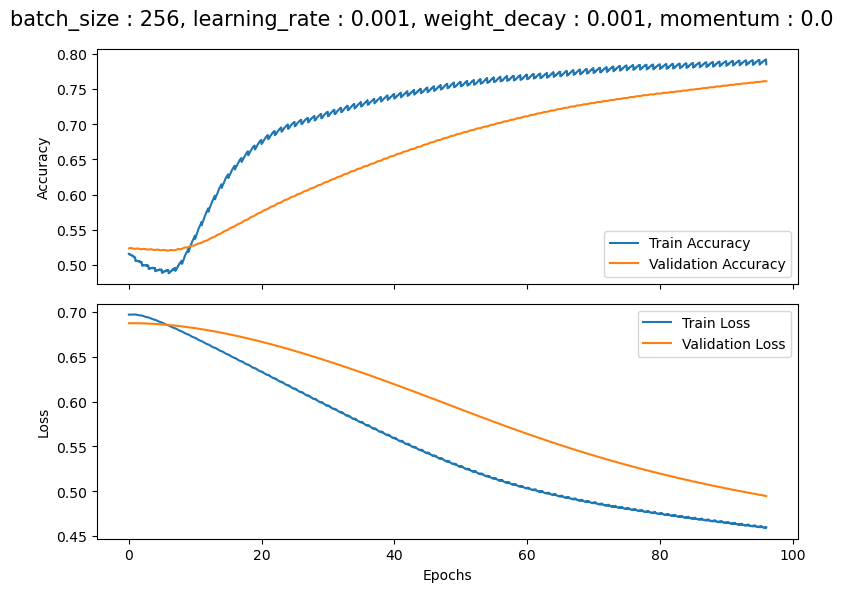

Train accuracy:  79.0
Validation accuracy:  78.6



Combination 13 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/6, Train loss:  0.519, Train accuracy:  76.0%: 100%|██████████| 563/563 [00:05<00:00, 105.37it/s]
Epoch: 1/6, Val loss:  0.440, Val accuracy:  81.1%: 100%|██████████| 63/63 [00:00<00:00, 464.74it/s]


Epoch: 2/6, Train loss:  0.419, Train accuracy:  82.1%: 100%|██████████| 563/563 [00:08<00:00, 62.66it/s]
Epoch: 2/6, Val loss:  0.411, Val accuracy:  82.3%: 100%|██████████| 63/63 [00:00<00:00, 343.38it/s]


Epoch: 3/6, Train loss:  0.376, Train accuracy:  84.4%: 100%|██████████| 563/563 [00:08<00:00, 64.26it/s]
Epoch: 3/6, Val loss:  0.400, Val accuracy:  83.4%: 100%|██████████| 63/63 [00:00<00:00, 324.62it/s]


Epoch: 4/6, Train loss:  0.342, Train accuracy:  86.0%: 100%|██████████| 563/563 [00:09<00:00, 62.14it/s]
Epoch: 4/6, Val loss:  0.398, Val accuracy:  83.1%: 100%|██████████| 63/63 [00:00<00:00, 335.45it/s]


Epoch: 5/6, Train loss:  0.311, Train accuracy:  87.4%: 100%|██████████| 563/563 [00:09<00:00, 60.77it/s]
Epoch: 5/6, Val loss:  0.397, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 322.09it/s]


Epoch: 6/6, Train loss:  0.280, Train accuracy:  89.1%: 100%|██████████| 563/563 [00:09<00:00, 58.39it/s]
Epoch: 6/6, Val loss:  0.402, Val accuracy:  84.0%: 100%|██████████| 63/63 [00:00<00:00, 320.15it/s]


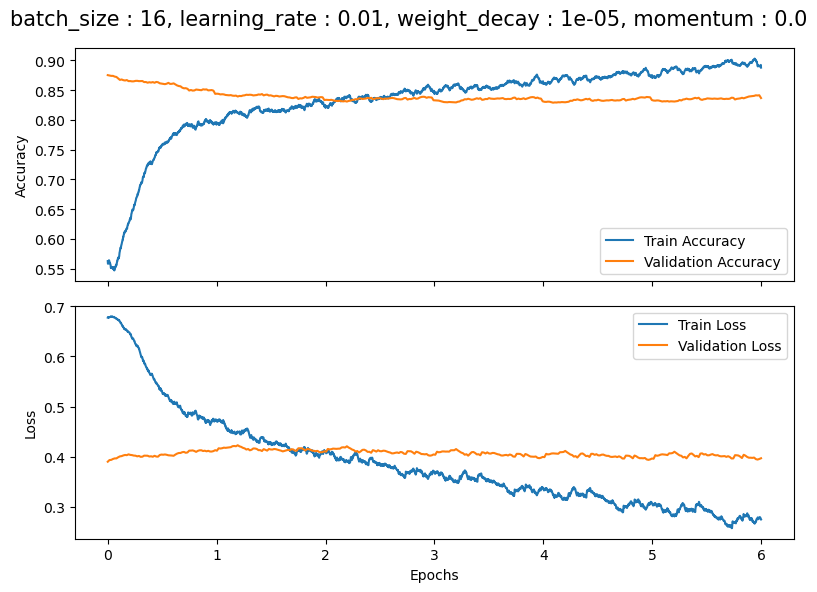

Train accuracy:  90.1
Validation accuracy:  84.0



Combination 14 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/24, Train loss:  0.625, Train accuracy:  66.3%: 100%|██████████| 141/141 [00:00<00:00, 210.74it/s]
Epoch: 1/24, Val loss:  0.558, Val accuracy:  74.0%: 100%|██████████| 16/16 [00:00<00:00, 322.37it/s]


Epoch: 2/24, Train loss:  0.507, Train accuracy:  78.1%: 100%|██████████| 141/141 [00:00<00:00, 144.11it/s]
Epoch: 2/24, Val loss:  0.478, Val accuracy:  77.9%: 100%|██████████| 16/16 [00:00<00:00, 404.87it/s]


Epoch: 3/24, Train loss:  0.462, Train accuracy:  80.2%: 100%|██████████| 141/141 [00:00<00:00, 152.56it/s]
Epoch: 3/24, Val loss:  0.454, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 396.98it/s]


Epoch: 4/24, Train loss:  0.433, Train accuracy:  81.6%: 100%|██████████| 141/141 [00:00<00:00, 154.40it/s]
Epoch: 4/24, Val loss:  0.438, Val accuracy:  79.7%: 100%|██████████| 16/16 [00:00<00:00, 420.13it/s]


Epoch: 5/24, Train loss:  0.407, Train accuracy:  82.8%: 100%|██████████| 141/141 [00:00<00:00, 150.92it/s]
Epoch: 5/24, Val loss:  0.426, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 389.00it/s]


Epoch: 6/24, Train loss:  0.385, Train accuracy:  83.6%: 100%|██████████| 141/141 [00:01<00:00, 130.58it/s]
Epoch: 6/24, Val loss:  0.417, Val accuracy:  80.8%: 100%|██████████| 16/16 [00:00<00:00, 379.64it/s]


Epoch: 7/24, Train loss:  0.364, Train accuracy:  84.7%: 100%|██████████| 141/141 [00:01<00:00, 133.29it/s]
Epoch: 7/24, Val loss:  0.410, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 403.64it/s]


Epoch: 8/24, Train loss:  0.345, Train accuracy:  85.7%: 100%|██████████| 141/141 [00:01<00:00, 126.39it/s]
Epoch: 8/24, Val loss:  0.404, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 379.82it/s]


Epoch: 9/24, Train loss:  0.327, Train accuracy:  86.5%: 100%|██████████| 141/141 [00:01<00:00, 134.49it/s]
Epoch: 9/24, Val loss:  0.397, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 379.73it/s]


Epoch: 10/24, Train loss:  0.309, Train accuracy:  87.4%: 100%|██████████| 141/141 [00:01<00:00, 135.06it/s]
Epoch: 10/24, Val loss:  0.393, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 402.65it/s]


Epoch: 11/24, Train loss:  0.292, Train accuracy:  88.4%: 100%|██████████| 141/141 [00:01<00:00, 137.92it/s]
Epoch: 11/24, Val loss:  0.390, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 367.12it/s]


Epoch: 12/24, Train loss:  0.277, Train accuracy:  89.4%: 100%|██████████| 141/141 [00:00<00:00, 156.04it/s]
Epoch: 12/24, Val loss:  0.388, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 388.12it/s]


Epoch: 13/24, Train loss:  0.262, Train accuracy:  90.1%: 100%|██████████| 141/141 [00:00<00:00, 143.48it/s]
Epoch: 13/24, Val loss:  0.389, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 379.84it/s]


Epoch: 14/24, Train loss:  0.250, Train accuracy:  90.7%: 100%|██████████| 141/141 [00:01<00:00, 137.40it/s]
Epoch: 14/24, Val loss:  0.391, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 408.72it/s]


Epoch: 15/24, Train loss:  0.238, Train accuracy:  91.3%: 100%|██████████| 141/141 [00:01<00:00, 134.89it/s]
Epoch: 15/24, Val loss:  0.394, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 354.47it/s]


Epoch: 16/24, Train loss:  0.231, Train accuracy:  91.7%: 100%|██████████| 141/141 [00:00<00:00, 147.70it/s]
Epoch: 16/24, Val loss:  0.405, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 422.67it/s]


Epoch: 17/24, Train loss:  0.206, Train accuracy:  92.8%: 100%|██████████| 141/141 [00:00<00:00, 147.56it/s]
Epoch: 17/24, Val loss:  0.415, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 419.57it/s]


Epoch: 18/24, Train loss:  0.207, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:00<00:00, 161.86it/s]
Epoch: 18/24, Val loss:  0.689, Val accuracy:  73.7%: 100%|██████████| 16/16 [00:00<00:00, 430.72it/s]


Epoch: 19/24, Train loss:  0.201, Train accuracy:  92.8%: 100%|██████████| 141/141 [00:00<00:00, 145.66it/s]
Epoch: 19/24, Val loss:  0.420, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 419.39it/s]


Epoch: 20/24, Train loss:  0.179, Train accuracy:  93.8%: 100%|██████████| 141/141 [00:01<00:00, 138.99it/s]
Epoch: 20/24, Val loss:  0.475, Val accuracy:  81.0%: 100%|██████████| 16/16 [00:00<00:00, 413.95it/s]


Epoch: 21/24, Train loss:  0.163, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:00<00:00, 147.32it/s]
Epoch: 21/24, Val loss:  0.685, Val accuracy:  74.4%: 100%|██████████| 16/16 [00:00<00:00, 403.54it/s]


Epoch: 22/24, Train loss:  0.164, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:00<00:00, 142.09it/s]
Epoch: 22/24, Val loss:  0.450, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 398.69it/s]


Epoch: 23/24, Train loss:  0.165, Train accuracy:  95.1%: 100%|██████████| 141/141 [00:00<00:00, 153.33it/s]
Epoch: 23/24, Val loss:  0.441, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 419.33it/s]


Epoch: 24/24, Train loss:  0.133, Train accuracy:  96.1%: 100%|██████████| 141/141 [00:00<00:00, 160.09it/s]
Epoch: 24/24, Val loss:  0.440, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 419.37it/s]


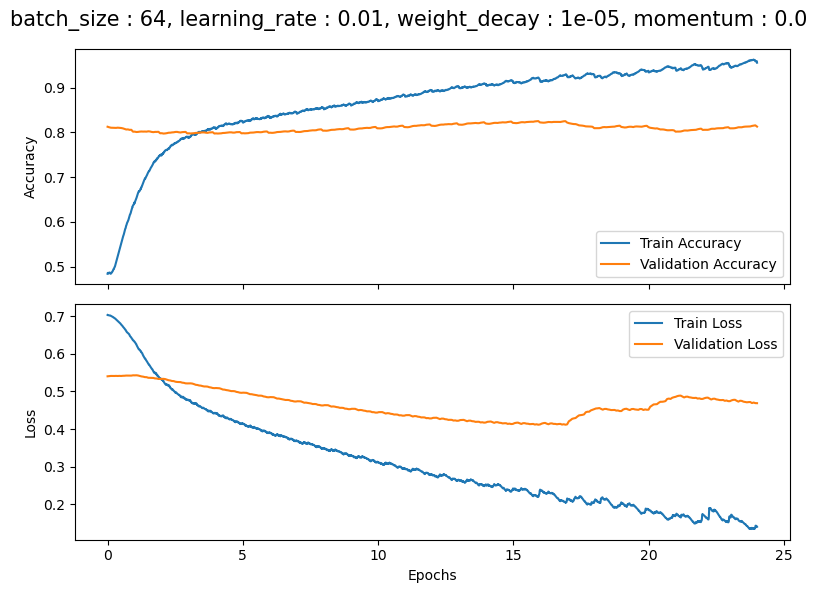

Train accuracy:  96.2
Validation accuracy:  83.6



Combination 15 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/96, Train loss:  0.680, Train accuracy:  50.5%: 100%|██████████| 36/36 [00:00<00:00, 113.71it/s]
Epoch: 1/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 162.63it/s]


Epoch: 2/96, Train loss:  0.643, Train accuracy:  65.4%: 100%|██████████| 36/36 [00:00<00:00, 114.09it/s]
Epoch: 2/96, Val loss:  0.623, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 177.36it/s]


Epoch: 3/96, Train loss:  0.605, Train accuracy:  70.7%: 100%|██████████| 36/36 [00:00<00:00, 102.17it/s]
Epoch: 3/96, Val loss:  0.588, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 126.27it/s]


Epoch: 4/96, Train loss:  0.568, Train accuracy:  73.3%: 100%|██████████| 36/36 [00:00<00:00, 98.34it/s] 
Epoch: 4/96, Val loss:  0.554, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 141.62it/s]


Epoch: 5/96, Train loss:  0.535, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 115.74it/s]
Epoch: 5/96, Val loss:  0.523, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 173.54it/s]


Epoch: 6/96, Train loss:  0.509, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 112.16it/s]
Epoch: 6/96, Val loss:  0.500, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 162.92it/s]


Epoch: 7/96, Train loss:  0.491, Train accuracy:  77.2%: 100%|██████████| 36/36 [00:00<00:00, 111.08it/s]
Epoch: 7/96, Val loss:  0.485, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 155.88it/s]


Epoch: 8/96, Train loss:  0.479, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 108.65it/s]
Epoch: 8/96, Val loss:  0.474, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 176.91it/s]


Epoch: 9/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 107.21it/s]
Epoch: 9/96, Val loss:  0.466, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 185.07it/s]


Epoch: 10/96, Train loss:  0.460, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 102.66it/s]
Epoch: 10/96, Val loss:  0.460, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 157.89it/s]


Epoch: 11/96, Train loss:  0.451, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 104.78it/s]
Epoch: 11/96, Val loss:  0.454, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 156.14it/s]


Epoch: 12/96, Train loss:  0.443, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 113.03it/s]
Epoch: 12/96, Val loss:  0.449, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 185.25it/s]


Epoch: 13/96, Train loss:  0.434, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 86.20it/s]
Epoch: 13/96, Val loss:  0.444, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 173.39it/s]


Epoch: 14/96, Train loss:  0.426, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 117.41it/s]
Epoch: 14/96, Val loss:  0.440, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 150.53it/s]


Epoch: 15/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 112.90it/s]
Epoch: 15/96, Val loss:  0.436, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 16/96, Train loss:  0.409, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 106.57it/s]
Epoch: 16/96, Val loss:  0.433, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 162.81it/s]


Epoch: 17/96, Train loss:  0.401, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 116.19it/s]
Epoch: 17/96, Val loss:  0.430, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 18/96, Train loss:  0.394, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 109.19it/s]
Epoch: 18/96, Val loss:  0.427, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 162.37it/s]


Epoch: 19/96, Train loss:  0.387, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 109.84it/s]
Epoch: 19/96, Val loss:  0.424, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 144.72it/s]


Epoch: 20/96, Train loss:  0.379, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 105.46it/s]
Epoch: 20/96, Val loss:  0.422, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 172.99it/s]


Epoch: 21/96, Train loss:  0.372, Train accuracy:  82.7%: 100%|██████████| 36/36 [00:00<00:00, 107.90it/s]
Epoch: 21/96, Val loss:  0.419, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 22/96, Train loss:  0.365, Train accuracy:  83.0%: 100%|██████████| 36/36 [00:00<00:00, 95.66it/s]
Epoch: 22/96, Val loss:  0.416, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 140.06it/s]


Epoch: 23/96, Train loss:  0.358, Train accuracy:  83.4%: 100%|██████████| 36/36 [00:00<00:00, 94.17it/s]
Epoch: 23/96, Val loss:  0.414, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 145.11it/s]


Epoch: 24/96, Train loss:  0.351, Train accuracy:  83.6%: 100%|██████████| 36/36 [00:00<00:00, 103.30it/s]
Epoch: 24/96, Val loss:  0.411, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 156.90it/s]


Epoch: 25/96, Train loss:  0.344, Train accuracy:  84.1%: 100%|██████████| 36/36 [00:00<00:00, 105.98it/s]
Epoch: 25/96, Val loss:  0.409, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 162.72it/s]


Epoch: 26/96, Train loss:  0.337, Train accuracy:  84.4%: 100%|██████████| 36/36 [00:00<00:00, 107.40it/s]
Epoch: 26/96, Val loss:  0.407, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 161.38it/s]


Epoch: 27/96, Train loss:  0.330, Train accuracy:  84.7%: 100%|██████████| 36/36 [00:00<00:00, 111.67it/s]
Epoch: 27/96, Val loss:  0.404, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 166.00it/s]


Epoch: 28/96, Train loss:  0.323, Train accuracy:  85.0%: 100%|██████████| 36/36 [00:00<00:00, 107.03it/s]
Epoch: 28/96, Val loss:  0.402, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 165.84it/s]


Epoch: 29/96, Train loss:  0.316, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 111.72it/s]
Epoch: 29/96, Val loss:  0.399, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 174.85it/s]


Epoch: 30/96, Train loss:  0.309, Train accuracy:  85.6%: 100%|██████████| 36/36 [00:00<00:00, 113.42it/s]
Epoch: 30/96, Val loss:  0.397, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 170.68it/s]


Epoch: 31/96, Train loss:  0.302, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 107.54it/s]
Epoch: 31/96, Val loss:  0.394, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 158.52it/s]


Epoch: 32/96, Train loss:  0.295, Train accuracy:  86.2%: 100%|██████████| 36/36 [00:00<00:00, 105.71it/s]
Epoch: 32/96, Val loss:  0.392, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 167.31it/s]


Epoch: 33/96, Train loss:  0.289, Train accuracy:  86.5%: 100%|██████████| 36/36 [00:00<00:00, 106.41it/s]
Epoch: 33/96, Val loss:  0.390, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 168.98it/s]


Epoch: 34/96, Train loss:  0.282, Train accuracy:  86.9%: 100%|██████████| 36/36 [00:00<00:00, 105.09it/s]
Epoch: 34/96, Val loss:  0.388, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 153.13it/s]


Epoch: 35/96, Train loss:  0.276, Train accuracy:  87.3%: 100%|██████████| 36/36 [00:00<00:00, 106.94it/s]
Epoch: 35/96, Val loss:  0.386, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 155.88it/s]


Epoch: 36/96, Train loss:  0.270, Train accuracy:  87.6%: 100%|██████████| 36/36 [00:00<00:00, 106.64it/s]
Epoch: 36/96, Val loss:  0.386, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 177.16it/s]


Epoch: 37/96, Train loss:  0.264, Train accuracy:  88.0%: 100%|██████████| 36/36 [00:00<00:00, 109.82it/s]
Epoch: 37/96, Val loss:  0.389, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 173.69it/s]


Epoch: 38/96, Train loss:  0.260, Train accuracy:  88.2%: 100%|██████████| 36/36 [00:00<00:00, 109.76it/s]
Epoch: 38/96, Val loss:  0.404, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 159.13it/s]


Epoch: 39/96, Train loss:  0.258, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 87.05it/s] 
Epoch: 39/96, Val loss:  0.430, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 160.24it/s]


Epoch: 40/96, Train loss:  0.257, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 104.79it/s]
Epoch: 40/96, Val loss:  0.457, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 162.74it/s]


Epoch: 41/96, Train loss:  0.254, Train accuracy:  88.4%: 100%|██████████| 36/36 [00:00<00:00, 106.55it/s]
Epoch: 41/96, Val loss:  0.459, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s]


Epoch: 42/96, Train loss:  0.251, Train accuracy:  88.8%: 100%|██████████| 36/36 [00:00<00:00, 106.54it/s]
Epoch: 42/96, Val loss:  0.465, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 157.05it/s]


Epoch: 43/96, Train loss:  0.250, Train accuracy:  88.7%: 100%|██████████| 36/36 [00:00<00:00, 106.62it/s]
Epoch: 43/96, Val loss:  0.479, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 152.48it/s]


Epoch: 44/96, Train loss:  0.237, Train accuracy:  89.3%: 100%|██████████| 36/36 [00:00<00:00, 105.60it/s]
Epoch: 44/96, Val loss:  0.393, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 161.10it/s]


Epoch: 45/96, Train loss:  0.227, Train accuracy:  89.8%: 100%|██████████| 36/36 [00:00<00:00, 105.77it/s]
Epoch: 45/96, Val loss:  0.435, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 161.81it/s]


Epoch: 46/96, Train loss:  0.255, Train accuracy:  88.8%: 100%|██████████| 36/36 [00:00<00:00, 103.43it/s]
Epoch: 46/96, Val loss:  0.627, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 159.67it/s]


Epoch: 47/96, Train loss:  0.260, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 106.28it/s]
Epoch: 47/96, Val loss:  0.407, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 177.22it/s]


Epoch: 48/96, Train loss:  0.215, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 104.35it/s]
Epoch: 48/96, Val loss:  0.445, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 151.01it/s]


Epoch: 49/96, Train loss:  0.226, Train accuracy:  89.7%: 100%|██████████| 36/36 [00:00<00:00, 105.39it/s]
Epoch: 49/96, Val loss:  0.392, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 158.88it/s]


Epoch: 50/96, Train loss:  0.220, Train accuracy:  89.7%: 100%|██████████| 36/36 [00:00<00:00, 107.64it/s]
Epoch: 50/96, Val loss:  0.397, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 158.57it/s]


Epoch: 51/96, Train loss:  0.227, Train accuracy:  89.7%: 100%|██████████| 36/36 [00:00<00:00, 107.63it/s]
Epoch: 51/96, Val loss:  0.474, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 168.39it/s]


Epoch: 52/96, Train loss:  0.246, Train accuracy:  89.4%: 100%|██████████| 36/36 [00:00<00:00, 110.01it/s]
Epoch: 52/96, Val loss:  0.630, Val accuracy:  74.4%: 100%|██████████| 4/4 [00:00<00:00, 169.94it/s]


Epoch: 53/96, Train loss:  0.235, Train accuracy:  89.6%: 100%|██████████| 36/36 [00:00<00:00, 114.09it/s]
Epoch: 53/96, Val loss:  0.448, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 180.31it/s]


Epoch: 54/96, Train loss:  0.188, Train accuracy:  91.5%: 100%|██████████| 36/36 [00:00<00:00, 111.24it/s]
Epoch: 54/96, Val loss:  0.475, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 55/96, Train loss:  0.213, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 113.69it/s]
Epoch: 55/96, Val loss:  0.414, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 173.53it/s]


Epoch: 56/96, Train loss:  0.228, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 111.67it/s]
Epoch: 56/96, Val loss:  0.561, Val accuracy:  78.0%: 100%|██████████| 4/4 [00:00<00:00, 182.36it/s]


Epoch: 57/96, Train loss:  0.196, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 110.04it/s]
Epoch: 57/96, Val loss:  0.392, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 165.07it/s]


Epoch: 58/96, Train loss:  0.194, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 112.60it/s]
Epoch: 58/96, Val loss:  0.390, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 154.97it/s]


Epoch: 59/96, Train loss:  0.162, Train accuracy:  92.5%: 100%|██████████| 36/36 [00:00<00:00, 113.09it/s]
Epoch: 59/96, Val loss:  0.392, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 168.33it/s]


Epoch: 60/96, Train loss:  0.192, Train accuracy:  91.5%: 100%|██████████| 36/36 [00:00<00:00, 111.40it/s]
Epoch: 60/96, Val loss:  0.399, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 162.69it/s]


Epoch: 61/96, Train loss:  0.193, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 106.62it/s]
Epoch: 61/96, Val loss:  0.396, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 160.92it/s]


Epoch: 62/96, Train loss:  0.225, Train accuracy:  90.5%: 100%|██████████| 36/36 [00:00<00:00, 109.42it/s]
Epoch: 62/96, Val loss:  0.606, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 168.79it/s]


Epoch: 63/96, Train loss:  0.169, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 106.53it/s]
Epoch: 63/96, Val loss:  0.393, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 165.78it/s]


Epoch: 64/96, Train loss:  0.162, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 107.72it/s]
Epoch: 64/96, Val loss:  0.395, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 147.54it/s]


Epoch: 65/96, Train loss:  0.148, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 89.28it/s] 
Epoch: 65/96, Val loss:  0.400, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 147.60it/s]


Epoch: 66/96, Train loss:  0.228, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 110.86it/s]
Epoch: 66/96, Val loss:  0.580, Val accuracy:  78.8%: 100%|██████████| 4/4 [00:00<00:00, 168.89it/s]


Epoch: 67/96, Train loss:  0.157, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 111.15it/s]
Epoch: 67/96, Val loss:  0.537, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 169.70it/s]


Epoch: 68/96, Train loss:  0.160, Train accuracy:  92.7%: 100%|██████████| 36/36 [00:00<00:00, 108.03it/s]
Epoch: 68/96, Val loss:  0.426, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 173.58it/s]


Epoch: 69/96, Train loss:  0.161, Train accuracy:  92.5%: 100%|██████████| 36/36 [00:00<00:00, 108.03it/s]
Epoch: 69/96, Val loss:  0.401, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 155.06it/s]


Epoch: 70/96, Train loss:  0.178, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 108.81it/s]
Epoch: 70/96, Val loss:  0.490, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 71/96, Train loss:  0.150, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 112.53it/s]
Epoch: 71/96, Val loss:  0.406, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 72/96, Train loss:  0.141, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 113.32it/s]
Epoch: 72/96, Val loss:  0.402, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 177.00it/s]


Epoch: 73/96, Train loss:  0.109, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 107.48it/s]
Epoch: 73/96, Val loss:  0.415, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 163.11it/s]


Epoch: 74/96, Train loss:  0.216, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 108.47it/s]
Epoch: 74/96, Val loss:  0.408, Val accuracy:  84.9%: 100%|██████████| 4/4 [00:00<00:00, 159.43it/s]


Epoch: 75/96, Train loss:  0.108, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 103.72it/s]
Epoch: 75/96, Val loss:  0.573, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 153.50it/s]


Epoch: 76/96, Train loss:  0.153, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 107.43it/s]
Epoch: 76/96, Val loss:  0.413, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 159.65it/s]


Epoch: 77/96, Train loss:  0.101, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 109.91it/s]
Epoch: 77/96, Val loss:  0.426, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 167.17it/s]


Epoch: 78/96, Train loss:  0.154, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 107.39it/s]
Epoch: 78/96, Val loss:  0.413, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 157.92it/s]


Epoch: 79/96, Train loss:  0.169, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 109.42it/s]
Epoch: 79/96, Val loss:  0.641, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 174.80it/s]


Epoch: 80/96, Train loss:  0.160, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 109.61it/s]
Epoch: 80/96, Val loss:  0.608, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 175.52it/s]


Epoch: 81/96, Train loss:  0.119, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 109.20it/s]
Epoch: 81/96, Val loss:  0.547, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 162.61it/s]


Epoch: 82/96, Train loss:  0.115, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 108.28it/s]
Epoch: 82/96, Val loss:  0.508, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 163.02it/s]


Epoch: 83/96, Train loss:  0.139, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 111.09it/s]
Epoch: 83/96, Val loss:  0.650, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 172.23it/s]


Epoch: 84/96, Train loss:  0.112, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 109.21it/s]
Epoch: 84/96, Val loss:  0.619, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 153.65it/s]


Epoch: 85/96, Train loss:  0.100, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 103.79it/s]
Epoch: 85/96, Val loss:  0.672, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 153.52it/s]


Epoch: 86/96, Train loss:  0.123, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 109.83it/s]
Epoch: 86/96, Val loss:  0.762, Val accuracy:  75.2%: 100%|██████████| 4/4 [00:00<00:00, 163.49it/s]


Epoch: 87/96, Train loss:  0.135, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 105.87it/s]
Epoch: 87/96, Val loss:  0.433, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 162.64it/s]


Epoch: 88/96, Train loss:  0.083, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 108.14it/s]
Epoch: 88/96, Val loss:  0.751, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 153.75it/s]


Epoch: 89/96, Train loss:  0.111, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 108.34it/s]
Epoch: 89/96, Val loss:  0.451, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 161.95it/s]


Epoch: 90/96, Train loss:  0.142, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 103.93it/s]
Epoch: 90/96, Val loss:  0.445, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 166.40it/s]


Epoch: 91/96, Train loss:  0.091, Train accuracy:  95.6%: 100%|██████████| 36/36 [00:00<00:00, 101.43it/s]
Epoch: 91/96, Val loss:  0.826, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 150.62it/s]


Epoch: 92/96, Train loss:  0.085, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 80.69it/s]
Epoch: 92/96, Val loss:  0.462, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 145.20it/s]


Epoch: 93/96, Train loss:  0.118, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 95.46it/s]
Epoch: 93/96, Val loss:  0.755, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 159.68it/s]


Epoch: 94/96, Train loss:  0.086, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 102.43it/s]
Epoch: 94/96, Val loss:  0.468, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 147.83it/s]


Epoch: 95/96, Train loss:  0.148, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 109.06it/s]
Epoch: 95/96, Val loss:  0.493, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 159.63it/s]


Epoch: 96/96, Train loss:  0.069, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 103.47it/s]
Epoch: 96/96, Val loss:  0.477, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 169.75it/s]


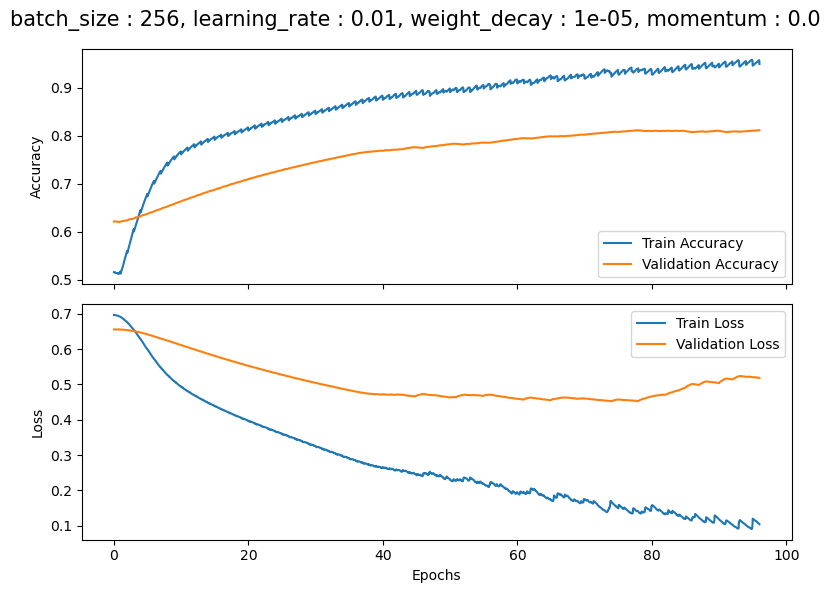

Train accuracy:  96.3
Validation accuracy:  83.5



Combination 16 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/6, Train loss:  0.669, Train accuracy:  56.7%: 100%|██████████| 563/563 [00:05<00:00, 95.55it/s] 
Epoch: 1/6, Val loss:  0.637, Val accuracy:  68.6%: 100%|██████████| 63/63 [00:00<00:00, 329.67it/s]


Epoch: 2/6, Train loss:  0.608, Train accuracy:  72.0%: 100%|██████████| 563/563 [00:09<00:00, 60.43it/s]
Epoch: 2/6, Val loss:  0.583, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 287.19it/s]


Epoch: 3/6, Train loss:  0.552, Train accuracy:  75.8%: 100%|██████████| 563/563 [00:09<00:00, 59.67it/s]
Epoch: 3/6, Val loss:  0.532, Val accuracy:  76.7%: 100%|██████████| 63/63 [00:00<00:00, 320.70it/s]


Epoch: 4/6, Train loss:  0.508, Train accuracy:  78.2%: 100%|██████████| 563/563 [00:09<00:00, 60.76it/s]
Epoch: 4/6, Val loss:  0.497, Val accuracy:  78.0%: 100%|██████████| 63/63 [00:00<00:00, 321.66it/s]


Epoch: 5/6, Train loss:  0.484, Train accuracy:  79.3%: 100%|██████████| 563/563 [00:09<00:00, 61.81it/s]
Epoch: 5/6, Val loss:  0.478, Val accuracy:  78.8%: 100%|██████████| 63/63 [00:00<00:00, 337.45it/s]


Epoch: 6/6, Train loss:  0.468, Train accuracy:  80.1%: 100%|██████████| 563/563 [00:09<00:00, 62.09it/s]
Epoch: 6/6, Val loss:  0.466, Val accuracy:  79.9%: 100%|██████████| 63/63 [00:00<00:00, 350.53it/s]


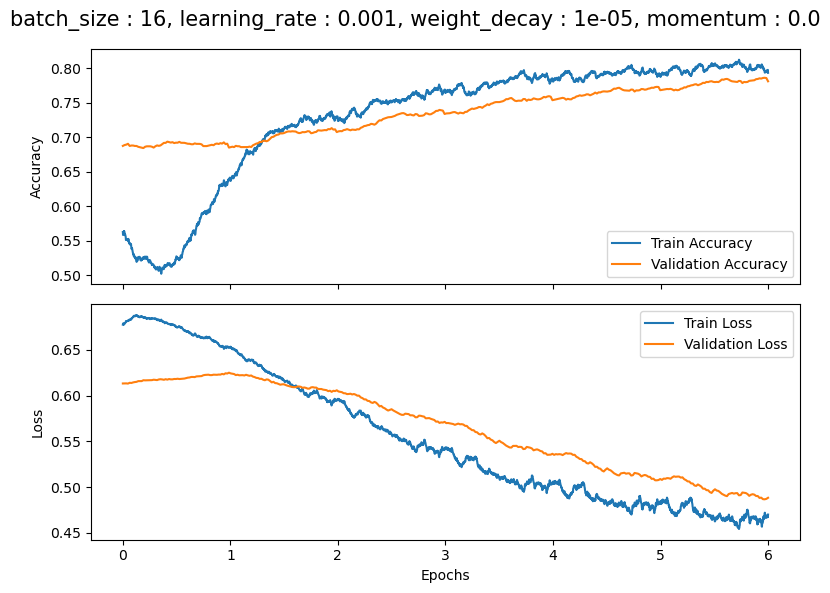

Train accuracy:  80.7
Validation accuracy:  79.9



Combination 17 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/24, Train loss:  0.691, Train accuracy:  49.6%: 100%|██████████| 141/141 [00:00<00:00, 213.46it/s]
Epoch: 1/24, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 16/16 [00:00<00:00, 417.69it/s]


Epoch: 2/24, Train loss:  0.676, Train accuracy:  51.0%: 100%|██████████| 141/141 [00:00<00:00, 157.52it/s]
Epoch: 2/24, Val loss:  0.665, Val accuracy:  55.8%: 100%|██████████| 16/16 [00:00<00:00, 388.90it/s]


Epoch: 3/24, Train loss:  0.661, Train accuracy:  60.2%: 100%|██████████| 141/141 [00:00<00:00, 155.02it/s]
Epoch: 3/24, Val loss:  0.651, Val accuracy:  62.7%: 100%|██████████| 16/16 [00:00<00:00, 408.73it/s]


Epoch: 4/24, Train loss:  0.646, Train accuracy:  66.4%: 100%|██████████| 141/141 [00:00<00:00, 159.89it/s]
Epoch: 4/24, Val loss:  0.638, Val accuracy:  67.2%: 100%|██████████| 16/16 [00:00<00:00, 342.61it/s]


Epoch: 5/24, Train loss:  0.631, Train accuracy:  69.6%: 100%|██████████| 141/141 [00:00<00:00, 150.11it/s]
Epoch: 5/24, Val loss:  0.624, Val accuracy:  69.3%: 100%|██████████| 16/16 [00:00<00:00, 408.66it/s]


Epoch: 6/24, Train loss:  0.615, Train accuracy:  71.7%: 100%|██████████| 141/141 [00:00<00:00, 154.19it/s]
Epoch: 6/24, Val loss:  0.611, Val accuracy:  70.4%: 100%|██████████| 16/16 [00:00<00:00, 388.30it/s]


Epoch: 7/24, Train loss:  0.600, Train accuracy:  72.5%: 100%|██████████| 141/141 [00:00<00:00, 154.49it/s]
Epoch: 7/24, Val loss:  0.597, Val accuracy:  71.0%: 100%|██████████| 16/16 [00:00<00:00, 403.83it/s]


Epoch: 8/24, Train loss:  0.585, Train accuracy:  73.6%: 100%|██████████| 141/141 [00:00<00:00, 153.04it/s]
Epoch: 8/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 424.85it/s]


Epoch: 9/24, Train loss:  0.571, Train accuracy:  74.8%: 100%|██████████| 141/141 [00:00<00:00, 150.47it/s]
Epoch: 9/24, Val loss:  0.570, Val accuracy:  72.9%: 100%|██████████| 16/16 [00:00<00:00, 355.87it/s]


Epoch: 10/24, Train loss:  0.557, Train accuracy:  75.5%: 100%|██████████| 141/141 [00:00<00:00, 148.69it/s]
Epoch: 10/24, Val loss:  0.557, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 370.15it/s]


Epoch: 11/24, Train loss:  0.544, Train accuracy:  76.3%: 100%|██████████| 141/141 [00:00<00:00, 142.55it/s]
Epoch: 11/24, Val loss:  0.544, Val accuracy:  74.4%: 100%|██████████| 16/16 [00:00<00:00, 420.62it/s]


Epoch: 12/24, Train loss:  0.531, Train accuracy:  76.9%: 100%|██████████| 141/141 [00:00<00:00, 143.01it/s]
Epoch: 12/24, Val loss:  0.532, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 420.23it/s]


Epoch: 13/24, Train loss:  0.520, Train accuracy:  77.5%: 100%|██████████| 141/141 [00:00<00:00, 151.21it/s]
Epoch: 13/24, Val loss:  0.521, Val accuracy:  75.7%: 100%|██████████| 16/16 [00:00<00:00, 409.03it/s]


Epoch: 14/24, Train loss:  0.511, Train accuracy:  78.1%: 100%|██████████| 141/141 [00:00<00:00, 151.03it/s]
Epoch: 14/24, Val loss:  0.512, Val accuracy:  76.1%: 100%|██████████| 16/16 [00:00<00:00, 403.14it/s]


Epoch: 15/24, Train loss:  0.502, Train accuracy:  78.2%: 100%|██████████| 141/141 [00:00<00:00, 147.07it/s]
Epoch: 15/24, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 16/16 [00:00<00:00, 413.66it/s]


Epoch: 16/24, Train loss:  0.495, Train accuracy:  78.6%: 100%|██████████| 141/141 [00:00<00:00, 152.08it/s]
Epoch: 16/24, Val loss:  0.497, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 398.51it/s]


Epoch: 17/24, Train loss:  0.489, Train accuracy:  79.0%: 100%|██████████| 141/141 [00:00<00:00, 152.02it/s]
Epoch: 17/24, Val loss:  0.491, Val accuracy:  76.9%: 100%|██████████| 16/16 [00:00<00:00, 346.87it/s]


Epoch: 18/24, Train loss:  0.484, Train accuracy:  79.4%: 100%|██████████| 141/141 [00:00<00:00, 151.14it/s]
Epoch: 18/24, Val loss:  0.486, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 398.67it/s]


Epoch: 19/24, Train loss:  0.479, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:00<00:00, 143.02it/s]
Epoch: 19/24, Val loss:  0.482, Val accuracy:  77.2%: 100%|██████████| 16/16 [00:00<00:00, 419.38it/s]


Epoch: 20/24, Train loss:  0.475, Train accuracy:  79.8%: 100%|██████████| 141/141 [00:00<00:00, 145.51it/s]
Epoch: 20/24, Val loss:  0.478, Val accuracy:  77.5%: 100%|██████████| 16/16 [00:00<00:00, 388.64it/s]


Epoch: 21/24, Train loss:  0.471, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:00<00:00, 151.49it/s]
Epoch: 21/24, Val loss:  0.475, Val accuracy:  77.9%: 100%|██████████| 16/16 [00:00<00:00, 419.37it/s]


Epoch: 22/24, Train loss:  0.467, Train accuracy:  80.1%: 100%|██████████| 141/141 [00:00<00:00, 147.51it/s]
Epoch: 22/24, Val loss:  0.471, Val accuracy:  78.0%: 100%|██████████| 16/16 [00:00<00:00, 419.66it/s]


Epoch: 23/24, Train loss:  0.464, Train accuracy:  80.3%: 100%|██████████| 141/141 [00:00<00:00, 150.68it/s]
Epoch: 23/24, Val loss:  0.469, Val accuracy:  78.4%: 100%|██████████| 16/16 [00:00<00:00, 393.45it/s]


Epoch: 24/24, Train loss:  0.460, Train accuracy:  80.5%: 100%|██████████| 141/141 [00:00<00:00, 147.25it/s]
Epoch: 24/24, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 408.38it/s]


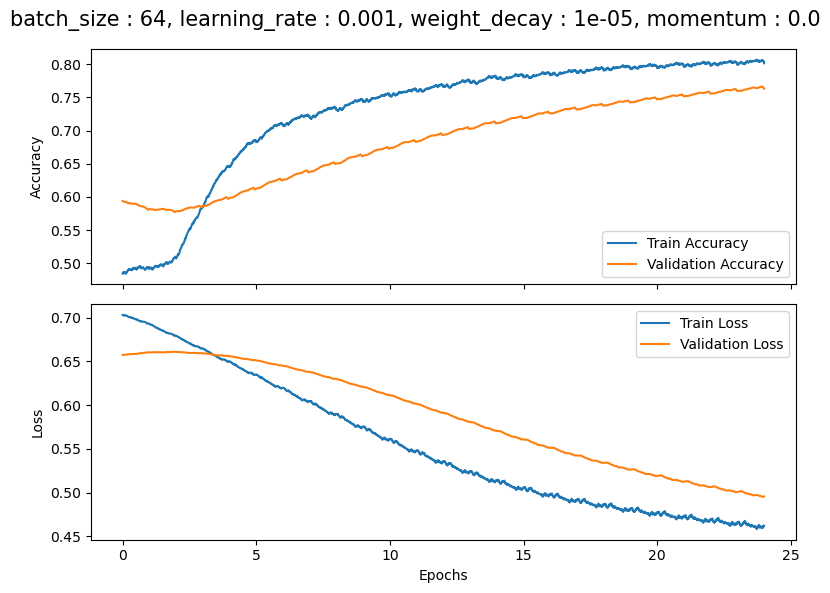

Train accuracy:  80.6
Validation accuracy:  78.5



Combination 18 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.0



Epoch: 1/96, Train loss:  0.698, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 109.28it/s]
Epoch: 1/96, Val loss:  0.689, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 161.74it/s]


Epoch: 2/96, Train loss:  0.693, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 114.20it/s]
Epoch: 2/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 185.75it/s]


Epoch: 3/96, Train loss:  0.689, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 112.30it/s]
Epoch: 3/96, Val loss:  0.681, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 183.77it/s]


Epoch: 4/96, Train loss:  0.685, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 111.48it/s]
Epoch: 4/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 166.24it/s]


Epoch: 5/96, Train loss:  0.681, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 109.86it/s]
Epoch: 5/96, Val loss:  0.674, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 177.31it/s]


Epoch: 6/96, Train loss:  0.678, Train accuracy:  48.9%: 100%|██████████| 36/36 [00:00<00:00, 111.94it/s]
Epoch: 6/96, Val loss:  0.671, Val accuracy:  50.7%: 100%|██████████| 4/4 [00:00<00:00, 181.15it/s]


Epoch: 7/96, Train loss:  0.674, Train accuracy:  50.1%: 100%|██████████| 36/36 [00:00<00:00, 107.52it/s]
Epoch: 7/96, Val loss:  0.667, Val accuracy:  53.0%: 100%|██████████| 4/4 [00:00<00:00, 180.90it/s]


Epoch: 8/96, Train loss:  0.670, Train accuracy:  52.6%: 100%|██████████| 36/36 [00:00<00:00, 114.37it/s]
Epoch: 8/96, Val loss:  0.664, Val accuracy:  56.2%: 100%|██████████| 4/4 [00:00<00:00, 170.62it/s]


Epoch: 9/96, Train loss:  0.666, Train accuracy:  55.9%: 100%|██████████| 36/36 [00:00<00:00, 109.97it/s]
Epoch: 9/96, Val loss:  0.660, Val accuracy:  58.7%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 10/96, Train loss:  0.663, Train accuracy:  58.3%: 100%|██████████| 36/36 [00:00<00:00, 112.91it/s]
Epoch: 10/96, Val loss:  0.657, Val accuracy:  59.3%: 100%|██████████| 4/4 [00:00<00:00, 150.39it/s]


Epoch: 11/96, Train loss:  0.659, Train accuracy:  60.4%: 100%|██████████| 36/36 [00:00<00:00, 109.91it/s]
Epoch: 11/96, Val loss:  0.653, Val accuracy:  61.6%: 100%|██████████| 4/4 [00:00<00:00, 177.19it/s]


Epoch: 12/96, Train loss:  0.655, Train accuracy:  62.2%: 100%|██████████| 36/36 [00:00<00:00, 110.84it/s]
Epoch: 12/96, Val loss:  0.650, Val accuracy:  63.1%: 100%|██████████| 4/4 [00:00<00:00, 162.67it/s]


Epoch: 13/96, Train loss:  0.651, Train accuracy:  63.7%: 100%|██████████| 36/36 [00:00<00:00, 102.36it/s]
Epoch: 13/96, Val loss:  0.646, Val accuracy:  65.2%: 100%|██████████| 4/4 [00:00<00:00, 156.34it/s]


Epoch: 14/96, Train loss:  0.647, Train accuracy:  64.9%: 100%|██████████| 36/36 [00:00<00:00, 109.46it/s]
Epoch: 14/96, Val loss:  0.643, Val accuracy:  66.4%: 100%|██████████| 4/4 [00:00<00:00, 181.54it/s]


Epoch: 15/96, Train loss:  0.644, Train accuracy:  65.9%: 100%|██████████| 36/36 [00:00<00:00, 91.02it/s]
Epoch: 15/96, Val loss:  0.639, Val accuracy:  67.0%: 100%|██████████| 4/4 [00:00<00:00, 156.30it/s]


Epoch: 16/96, Train loss:  0.640, Train accuracy:  66.7%: 100%|██████████| 36/36 [00:00<00:00, 113.17it/s]
Epoch: 16/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 173.52it/s]


Epoch: 17/96, Train loss:  0.636, Train accuracy:  67.5%: 100%|██████████| 36/36 [00:00<00:00, 110.04it/s]
Epoch: 17/96, Val loss:  0.632, Val accuracy:  68.1%: 100%|██████████| 4/4 [00:00<00:00, 172.89it/s]


Epoch: 18/96, Train loss:  0.632, Train accuracy:  68.1%: 100%|██████████| 36/36 [00:00<00:00, 112.68it/s]
Epoch: 18/96, Val loss:  0.629, Val accuracy:  68.8%: 100%|██████████| 4/4 [00:00<00:00, 182.88it/s]


Epoch: 19/96, Train loss:  0.628, Train accuracy:  68.6%: 100%|██████████| 36/36 [00:00<00:00, 107.20it/s]
Epoch: 19/96, Val loss:  0.625, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 175.15it/s]


Epoch: 20/96, Train loss:  0.624, Train accuracy:  69.4%: 100%|██████████| 36/36 [00:00<00:00, 103.98it/s]
Epoch: 20/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 149.24it/s]


Epoch: 21/96, Train loss:  0.621, Train accuracy:  69.8%: 100%|██████████| 36/36 [00:00<00:00, 113.56it/s]
Epoch: 21/96, Val loss:  0.618, Val accuracy:  69.6%: 100%|██████████| 4/4 [00:00<00:00, 180.99it/s]


Epoch: 22/96, Train loss:  0.617, Train accuracy:  70.1%: 100%|██████████| 36/36 [00:00<00:00, 112.16it/s]
Epoch: 22/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 159.44it/s]


Epoch: 23/96, Train loss:  0.613, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 107.71it/s]
Epoch: 23/96, Val loss:  0.611, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 169.67it/s]


Epoch: 24/96, Train loss:  0.609, Train accuracy:  70.6%: 100%|██████████| 36/36 [00:00<00:00, 104.87it/s]
Epoch: 24/96, Val loss:  0.608, Val accuracy:  70.2%: 100%|██████████| 4/4 [00:00<00:00, 153.38it/s]


Epoch: 25/96, Train loss:  0.605, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 107.30it/s]
Epoch: 25/96, Val loss:  0.604, Val accuracy:  70.4%: 100%|██████████| 4/4 [00:00<00:00, 145.70it/s]


Epoch: 26/96, Train loss:  0.601, Train accuracy:  71.1%: 100%|██████████| 36/36 [00:00<00:00, 103.32it/s]
Epoch: 26/96, Val loss:  0.601, Val accuracy:  70.5%: 100%|██████████| 4/4 [00:00<00:00, 166.06it/s]


Epoch: 27/96, Train loss:  0.598, Train accuracy:  71.2%: 100%|██████████| 36/36 [00:00<00:00, 105.47it/s]
Epoch: 27/96, Val loss:  0.597, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 166.83it/s]


Epoch: 28/96, Train loss:  0.594, Train accuracy:  71.5%: 100%|██████████| 36/36 [00:00<00:00, 108.55it/s]
Epoch: 28/96, Val loss:  0.594, Val accuracy:  70.9%: 100%|██████████| 4/4 [00:00<00:00, 166.30it/s]


Epoch: 29/96, Train loss:  0.590, Train accuracy:  71.9%: 100%|██████████| 36/36 [00:00<00:00, 102.48it/s]
Epoch: 29/96, Val loss:  0.590, Val accuracy:  71.2%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 30/96, Train loss:  0.586, Train accuracy:  72.2%: 100%|██████████| 36/36 [00:00<00:00, 107.21it/s]
Epoch: 30/96, Val loss:  0.587, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 31/96, Train loss:  0.583, Train accuracy:  72.5%: 100%|██████████| 36/36 [00:00<00:00, 109.52it/s]
Epoch: 31/96, Val loss:  0.584, Val accuracy:  71.9%: 100%|██████████| 4/4 [00:00<00:00, 169.66it/s]


Epoch: 32/96, Train loss:  0.579, Train accuracy:  72.7%: 100%|██████████| 36/36 [00:00<00:00, 109.06it/s]
Epoch: 32/96, Val loss:  0.580, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 119.08it/s]


Epoch: 33/96, Train loss:  0.575, Train accuracy:  73.0%: 100%|██████████| 36/36 [00:00<00:00, 104.80it/s]
Epoch: 33/96, Val loss:  0.577, Val accuracy:  72.6%: 100%|██████████| 4/4 [00:00<00:00, 174.89it/s]


Epoch: 34/96, Train loss:  0.572, Train accuracy:  73.2%: 100%|██████████| 36/36 [00:00<00:00, 112.19it/s]
Epoch: 34/96, Val loss:  0.573, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 35/96, Train loss:  0.568, Train accuracy:  73.4%: 100%|██████████| 36/36 [00:00<00:00, 107.62it/s]
Epoch: 35/96, Val loss:  0.570, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 166.28it/s]


Epoch: 36/96, Train loss:  0.565, Train accuracy:  73.7%: 100%|██████████| 36/36 [00:00<00:00, 106.45it/s]
Epoch: 36/96, Val loss:  0.566, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 166.17it/s]


Epoch: 37/96, Train loss:  0.561, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 111.18it/s]
Epoch: 37/96, Val loss:  0.563, Val accuracy:  73.2%: 100%|██████████| 4/4 [00:00<00:00, 173.21it/s]


Epoch: 38/96, Train loss:  0.558, Train accuracy:  74.2%: 100%|██████████| 36/36 [00:00<00:00, 110.39it/s]
Epoch: 38/96, Val loss:  0.560, Val accuracy:  73.8%: 100%|██████████| 4/4 [00:00<00:00, 165.63it/s]


Epoch: 39/96, Train loss:  0.554, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 110.74it/s]
Epoch: 39/96, Val loss:  0.556, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 142.25it/s]


Epoch: 40/96, Train loss:  0.551, Train accuracy:  74.4%: 100%|██████████| 36/36 [00:00<00:00, 109.77it/s]
Epoch: 40/96, Val loss:  0.553, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 168.99it/s]


Epoch: 41/96, Train loss:  0.547, Train accuracy:  74.6%: 100%|██████████| 36/36 [00:00<00:00, 89.19it/s]
Epoch: 41/96, Val loss:  0.550, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 169.20it/s]


Epoch: 42/96, Train loss:  0.544, Train accuracy:  74.8%: 100%|██████████| 36/36 [00:00<00:00, 109.63it/s]
Epoch: 42/96, Val loss:  0.546, Val accuracy:  74.2%: 100%|██████████| 4/4 [00:00<00:00, 162.57it/s]


Epoch: 43/96, Train loss:  0.541, Train accuracy:  75.0%: 100%|██████████| 36/36 [00:00<00:00, 113.13it/s]
Epoch: 43/96, Val loss:  0.543, Val accuracy:  74.3%: 100%|██████████| 4/4 [00:00<00:00, 162.52it/s]


Epoch: 44/96, Train loss:  0.538, Train accuracy:  75.1%: 100%|██████████| 36/36 [00:00<00:00, 110.81it/s]
Epoch: 44/96, Val loss:  0.540, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 166.18it/s]


Epoch: 45/96, Train loss:  0.535, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 109.85it/s]
Epoch: 45/96, Val loss:  0.537, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 181.11it/s]


Epoch: 46/96, Train loss:  0.532, Train accuracy:  75.5%: 100%|██████████| 36/36 [00:00<00:00, 113.29it/s]
Epoch: 46/96, Val loss:  0.534, Val accuracy:  75.2%: 100%|██████████| 4/4 [00:00<00:00, 156.39it/s]


Epoch: 47/96, Train loss:  0.529, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 106.62it/s]
Epoch: 47/96, Val loss:  0.531, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 150.76it/s]


Epoch: 48/96, Train loss:  0.526, Train accuracy:  75.8%: 100%|██████████| 36/36 [00:00<00:00, 105.10it/s]
Epoch: 48/96, Val loss:  0.528, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 172.75it/s]


Epoch: 49/96, Train loss:  0.523, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 110.53it/s]
Epoch: 49/96, Val loss:  0.525, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 166.24it/s]


Epoch: 50/96, Train loss:  0.520, Train accuracy:  76.0%: 100%|██████████| 36/36 [00:00<00:00, 111.21it/s]
Epoch: 50/96, Val loss:  0.522, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 159.42it/s]


Epoch: 51/96, Train loss:  0.518, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 110.44it/s]
Epoch: 51/96, Val loss:  0.519, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 176.81it/s]


Epoch: 52/96, Train loss:  0.515, Train accuracy:  76.2%: 100%|██████████| 36/36 [00:00<00:00, 115.74it/s]
Epoch: 52/96, Val loss:  0.517, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 191.44it/s]


Epoch: 53/96, Train loss:  0.513, Train accuracy:  76.3%: 100%|██████████| 36/36 [00:00<00:00, 116.37it/s]
Epoch: 53/96, Val loss:  0.514, Val accuracy:  75.8%: 100%|██████████| 4/4 [00:00<00:00, 173.17it/s]


Epoch: 54/96, Train loss:  0.510, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 114.89it/s]
Epoch: 54/96, Val loss:  0.512, Val accuracy:  75.8%: 100%|██████████| 4/4 [00:00<00:00, 185.29it/s]


Epoch: 55/96, Train loss:  0.508, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 116.38it/s]
Epoch: 55/96, Val loss:  0.510, Val accuracy:  75.9%: 100%|██████████| 4/4 [00:00<00:00, 184.00it/s]


Epoch: 56/96, Train loss:  0.506, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 118.03it/s]
Epoch: 56/96, Val loss:  0.508, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 184.88it/s]


Epoch: 57/96, Train loss:  0.504, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 115.72it/s]
Epoch: 57/96, Val loss:  0.505, Val accuracy:  76.2%: 100%|██████████| 4/4 [00:00<00:00, 159.50it/s]


Epoch: 58/96, Train loss:  0.502, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 117.26it/s]
Epoch: 58/96, Val loss:  0.503, Val accuracy:  76.5%: 100%|██████████| 4/4 [00:00<00:00, 190.02it/s]


Epoch: 59/96, Train loss:  0.500, Train accuracy:  76.8%: 100%|██████████| 36/36 [00:00<00:00, 117.61it/s]
Epoch: 59/96, Val loss:  0.501, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 175.85it/s]


Epoch: 60/96, Train loss:  0.498, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 113.95it/s]
Epoch: 60/96, Val loss:  0.500, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 177.42it/s]


Epoch: 61/96, Train loss:  0.497, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 117.39it/s]
Epoch: 61/96, Val loss:  0.498, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 62/96, Train loss:  0.495, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 114.74it/s]
Epoch: 62/96, Val loss:  0.496, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 169.84it/s]


Epoch: 63/96, Train loss:  0.493, Train accuracy:  77.1%: 100%|██████████| 36/36 [00:00<00:00, 112.96it/s]
Epoch: 63/96, Val loss:  0.495, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 169.38it/s]


Epoch: 64/96, Train loss:  0.492, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 109.85it/s]
Epoch: 64/96, Val loss:  0.493, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 165.07it/s]


Epoch: 65/96, Train loss:  0.490, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 112.01it/s]
Epoch: 65/96, Val loss:  0.491, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 163.09it/s]


Epoch: 66/96, Train loss:  0.489, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 112.13it/s]
Epoch: 66/96, Val loss:  0.490, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 168.28it/s]


Epoch: 67/96, Train loss:  0.487, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 93.20it/s] 
Epoch: 67/96, Val loss:  0.489, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 135.37it/s]


Epoch: 68/96, Train loss:  0.486, Train accuracy:  77.7%: 100%|██████████| 36/36 [00:00<00:00, 113.96it/s]
Epoch: 68/96, Val loss:  0.487, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 172.69it/s]


Epoch: 69/96, Train loss:  0.485, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 113.55it/s]
Epoch: 69/96, Val loss:  0.486, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 176.13it/s]


Epoch: 70/96, Train loss:  0.483, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 112.02it/s]
Epoch: 70/96, Val loss:  0.485, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 162.77it/s]


Epoch: 71/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 111.03it/s]
Epoch: 71/96, Val loss:  0.483, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 72/96, Train loss:  0.481, Train accuracy:  78.0%: 100%|██████████| 36/36 [00:00<00:00, 113.11it/s]
Epoch: 72/96, Val loss:  0.482, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 73/96, Train loss:  0.480, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 115.03it/s]
Epoch: 73/96, Val loss:  0.481, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 182.94it/s]


Epoch: 74/96, Train loss:  0.478, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 107.44it/s]
Epoch: 74/96, Val loss:  0.480, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 171.81it/s]


Epoch: 75/96, Train loss:  0.477, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 115.86it/s]
Epoch: 75/96, Val loss:  0.479, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 181.34it/s]


Epoch: 76/96, Train loss:  0.476, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 113.36it/s]
Epoch: 76/96, Val loss:  0.478, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 170.18it/s]


Epoch: 77/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 112.53it/s]
Epoch: 77/96, Val loss:  0.477, Val accuracy:  77.3%: 100%|██████████| 4/4 [00:00<00:00, 170.39it/s]


Epoch: 78/96, Train loss:  0.474, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 112.06it/s]
Epoch: 78/96, Val loss:  0.476, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 179.63it/s]


Epoch: 79/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 113.30it/s]
Epoch: 79/96, Val loss:  0.475, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 169.49it/s]


Epoch: 80/96, Train loss:  0.472, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 111.82it/s]
Epoch: 80/96, Val loss:  0.474, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 147.16it/s]


Epoch: 81/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 110.13it/s]
Epoch: 81/96, Val loss:  0.473, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 162.57it/s]


Epoch: 82/96, Train loss:  0.470, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 108.69it/s]
Epoch: 82/96, Val loss:  0.472, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 180.83it/s]


Epoch: 83/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 105.26it/s]
Epoch: 83/96, Val loss:  0.471, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 84/96, Train loss:  0.468, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 114.39it/s]
Epoch: 84/96, Val loss:  0.471, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 181.14it/s]


Epoch: 85/96, Train loss:  0.467, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 113.85it/s]
Epoch: 85/96, Val loss:  0.470, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 181.69it/s]


Epoch: 86/96, Train loss:  0.466, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 115.35it/s]
Epoch: 86/96, Val loss:  0.469, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 177.07it/s]


Epoch: 87/96, Train loss:  0.465, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 110.39it/s]
Epoch: 87/96, Val loss:  0.468, Val accuracy:  78.0%: 100%|██████████| 4/4 [00:00<00:00, 173.40it/s]


Epoch: 88/96, Train loss:  0.464, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 112.59it/s]
Epoch: 88/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 155.79it/s]


Epoch: 89/96, Train loss:  0.463, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 115.30it/s]
Epoch: 89/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 181.40it/s]


Epoch: 90/96, Train loss:  0.462, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 107.47it/s]
Epoch: 90/96, Val loss:  0.466, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 139.28it/s]


Epoch: 91/96, Train loss:  0.461, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 111.13it/s]
Epoch: 91/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 92/96, Train loss:  0.460, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 115.91it/s]
Epoch: 92/96, Val loss:  0.464, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 166.97it/s]


Epoch: 93/96, Train loss:  0.459, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 103.97it/s]
Epoch: 93/96, Val loss:  0.464, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 176.98it/s]


Epoch: 94/96, Train loss:  0.459, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 94.25it/s]
Epoch: 94/96, Val loss:  0.463, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 181.57it/s]


Epoch: 95/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 115.41it/s]
Epoch: 95/96, Val loss:  0.462, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s]


Epoch: 96/96, Train loss:  0.457, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 111.16it/s]
Epoch: 96/96, Val loss:  0.462, Val accuracy:  78.8%: 100%|██████████| 4/4 [00:00<00:00, 182.74it/s]


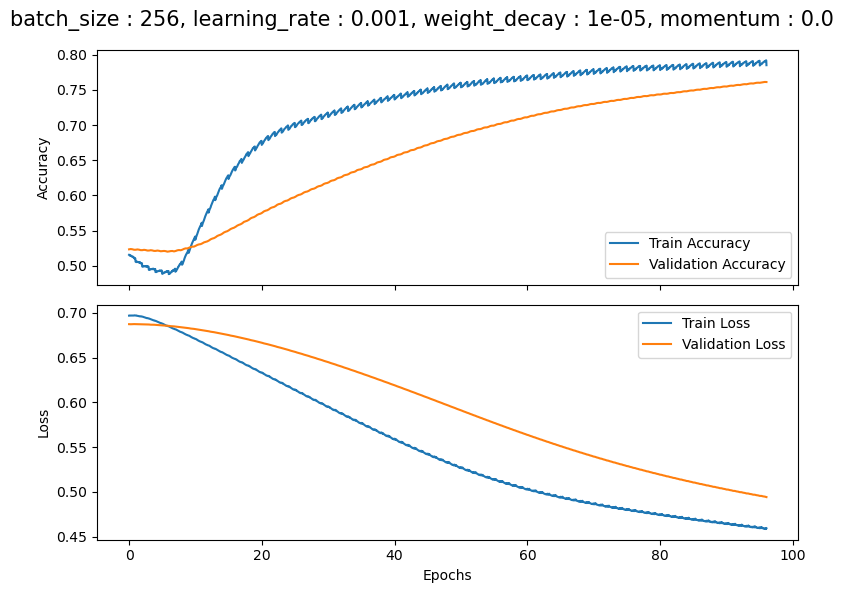

Train accuracy:  79.1
Validation accuracy:  78.8



Combination 19 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.5



Epoch: 1/6, Train loss:  0.488, Train accuracy:  77.7%: 100%|██████████| 563/563 [00:05<00:00, 107.78it/s]
Epoch: 1/6, Val loss:  0.424, Val accuracy:  81.8%: 100%|██████████| 63/63 [00:00<00:00, 410.29it/s]


Epoch: 2/6, Train loss:  0.399, Train accuracy:  83.2%: 100%|██████████| 563/563 [00:09<00:00, 62.28it/s]
Epoch: 2/6, Val loss:  0.404, Val accuracy:  82.9%: 100%|██████████| 63/63 [00:00<00:00, 252.85it/s]


Epoch: 3/6, Train loss:  0.355, Train accuracy:  85.6%: 100%|██████████| 563/563 [00:09<00:00, 61.26it/s]
Epoch: 3/6, Val loss:  0.394, Val accuracy:  83.4%: 100%|██████████| 63/63 [00:00<00:00, 319.21it/s]


Epoch: 4/6, Train loss:  0.318, Train accuracy:  87.3%: 100%|██████████| 563/563 [00:09<00:00, 61.45it/s]
Epoch: 4/6, Val loss:  0.392, Val accuracy:  83.5%: 100%|██████████| 63/63 [00:00<00:00, 280.31it/s]


Epoch: 5/6, Train loss:  0.283, Train accuracy:  89.3%: 100%|██████████| 563/563 [00:08<00:00, 65.46it/s]
Epoch: 5/6, Val loss:  0.407, Val accuracy:  83.4%: 100%|██████████| 63/63 [00:00<00:00, 326.95it/s]


Epoch: 6/6, Train loss:  0.246, Train accuracy:  91.1%: 100%|██████████| 563/563 [00:09<00:00, 59.17it/s]
Epoch: 6/6, Val loss:  0.412, Val accuracy:  84.7%: 100%|██████████| 63/63 [00:00<00:00, 329.79it/s]


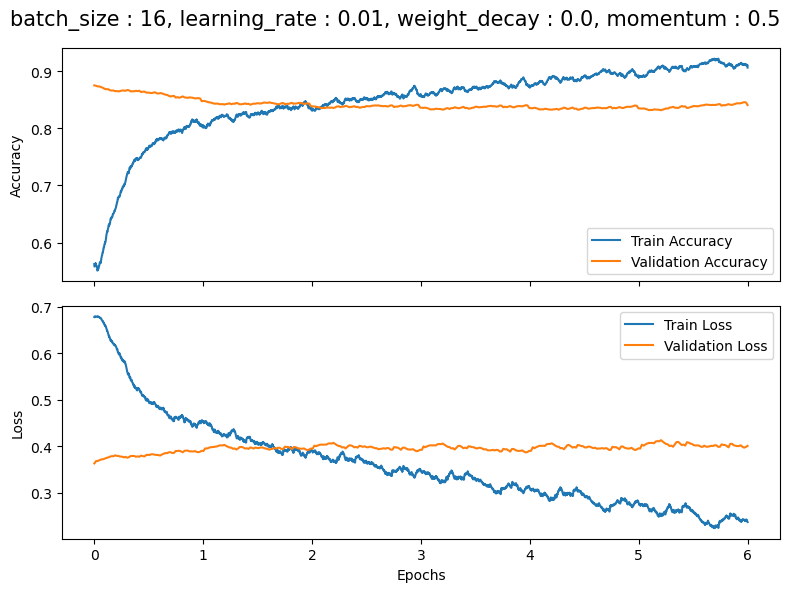

Train accuracy:  91.2
Validation accuracy:  84.7



Combination 20 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.5



Epoch: 1/24, Train loss:  0.572, Train accuracy:  71.1%: 100%|██████████| 141/141 [00:00<00:00, 181.71it/s]
Epoch: 1/24, Val loss:  0.482, Val accuracy:  77.6%: 100%|██████████| 16/16 [00:00<00:00, 430.85it/s]


Epoch: 2/24, Train loss:  0.457, Train accuracy:  80.4%: 100%|██████████| 141/141 [00:00<00:00, 143.77it/s]
Epoch: 2/24, Val loss:  0.439, Val accuracy:  80.1%: 100%|██████████| 16/16 [00:00<00:00, 394.02it/s]


Epoch: 3/24, Train loss:  0.412, Train accuracy:  82.2%: 100%|██████████| 141/141 [00:01<00:00, 137.70it/s]
Epoch: 3/24, Val loss:  0.419, Val accuracy:  80.9%: 100%|██████████| 16/16 [00:00<00:00, 409.54it/s]


Epoch: 4/24, Train loss:  0.378, Train accuracy:  84.1%: 100%|██████████| 141/141 [00:01<00:00, 131.45it/s]
Epoch: 4/24, Val loss:  0.410, Val accuracy:  81.7%: 100%|██████████| 16/16 [00:00<00:00, 408.98it/s]


Epoch: 5/24, Train loss:  0.348, Train accuracy:  85.6%: 100%|██████████| 141/141 [00:01<00:00, 140.12it/s]
Epoch: 5/24, Val loss:  0.405, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 403.49it/s]


Epoch: 6/24, Train loss:  0.321, Train accuracy:  86.9%: 100%|██████████| 141/141 [00:01<00:00, 137.93it/s]
Epoch: 6/24, Val loss:  0.402, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 355.77it/s]


Epoch: 7/24, Train loss:  0.296, Train accuracy:  88.4%: 100%|██████████| 141/141 [00:00<00:00, 141.54it/s]
Epoch: 7/24, Val loss:  0.402, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 355.64it/s]


Epoch: 8/24, Train loss:  0.270, Train accuracy:  89.5%: 100%|██████████| 141/141 [00:00<00:00, 148.72it/s]
Epoch: 8/24, Val loss:  0.405, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 383.40it/s]


Epoch: 9/24, Train loss:  0.245, Train accuracy:  90.7%: 100%|██████████| 141/141 [00:00<00:00, 143.17it/s]
Epoch: 9/24, Val loss:  0.416, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 419.79it/s]


Epoch: 10/24, Train loss:  0.223, Train accuracy:  91.7%: 100%|██████████| 141/141 [00:00<00:00, 144.45it/s]
Epoch: 10/24, Val loss:  0.425, Val accuracy:  81.7%: 100%|██████████| 16/16 [00:00<00:00, 408.78it/s]


Epoch: 11/24, Train loss:  0.199, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:01<00:00, 136.08it/s]
Epoch: 11/24, Val loss:  0.435, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 382.55it/s]


Epoch: 12/24, Train loss:  0.178, Train accuracy:  93.6%: 100%|██████████| 141/141 [00:00<00:00, 146.01it/s]
Epoch: 12/24, Val loss:  0.468, Val accuracy:  81.4%: 100%|██████████| 16/16 [00:00<00:00, 408.79it/s]


Epoch: 13/24, Train loss:  0.169, Train accuracy:  93.9%: 100%|██████████| 141/141 [00:01<00:00, 133.22it/s]
Epoch: 13/24, Val loss:  0.468, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 379.79it/s]


Epoch: 14/24, Train loss:  0.156, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:01<00:00, 140.00it/s]
Epoch: 14/24, Val loss:  0.692, Val accuracy:  76.1%: 100%|██████████| 16/16 [00:00<00:00, 398.54it/s]


Epoch: 15/24, Train loss:  0.135, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:01<00:00, 136.72it/s]
Epoch: 15/24, Val loss:  0.544, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 403.13it/s]


Epoch: 16/24, Train loss:  0.132, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 136.20it/s]
Epoch: 16/24, Val loss:  0.571, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 398.45it/s]


Epoch: 17/24, Train loss:  0.131, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 140.75it/s]
Epoch: 17/24, Val loss:  0.537, Val accuracy:  80.8%: 100%|██████████| 16/16 [00:00<00:00, 403.00it/s]


Epoch: 18/24, Train loss:  0.114, Train accuracy:  96.2%: 100%|██████████| 141/141 [00:01<00:00, 135.97it/s]
Epoch: 18/24, Val loss:  0.557, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 385.83it/s]


Epoch: 19/24, Train loss:  0.088, Train accuracy:  97.2%: 100%|██████████| 141/141 [00:01<00:00, 134.28it/s]
Epoch: 19/24, Val loss:  0.526, Val accuracy:  84.7%: 100%|██████████| 16/16 [00:00<00:00, 414.15it/s]


Epoch: 20/24, Train loss:  0.079, Train accuracy:  97.5%: 100%|██████████| 141/141 [00:01<00:00, 131.93it/s]
Epoch: 20/24, Val loss:  0.544, Val accuracy:  84.3%: 100%|██████████| 16/16 [00:00<00:00, 343.95it/s]


Epoch: 21/24, Train loss:  0.095, Train accuracy:  96.8%: 100%|██████████| 141/141 [00:01<00:00, 135.72it/s]
Epoch: 21/24, Val loss:  0.584, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 294.65it/s]


Epoch: 22/24, Train loss:  0.098, Train accuracy:  96.7%: 100%|██████████| 141/141 [00:01<00:00, 130.93it/s]
Epoch: 22/24, Val loss:  0.509, Val accuracy:  84.8%: 100%|██████████| 16/16 [00:00<00:00, 365.63it/s]


Epoch: 23/24, Train loss:  0.077, Train accuracy:  97.5%: 100%|██████████| 141/141 [00:01<00:00, 133.98it/s]
Epoch: 23/24, Val loss:  0.549, Val accuracy:  84.4%: 100%|██████████| 16/16 [00:00<00:00, 411.74it/s]


Epoch: 24/24, Train loss:  0.056, Train accuracy:  98.0%: 100%|██████████| 141/141 [00:01<00:00, 138.20it/s]
Epoch: 24/24, Val loss:  0.620, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 408.75it/s]


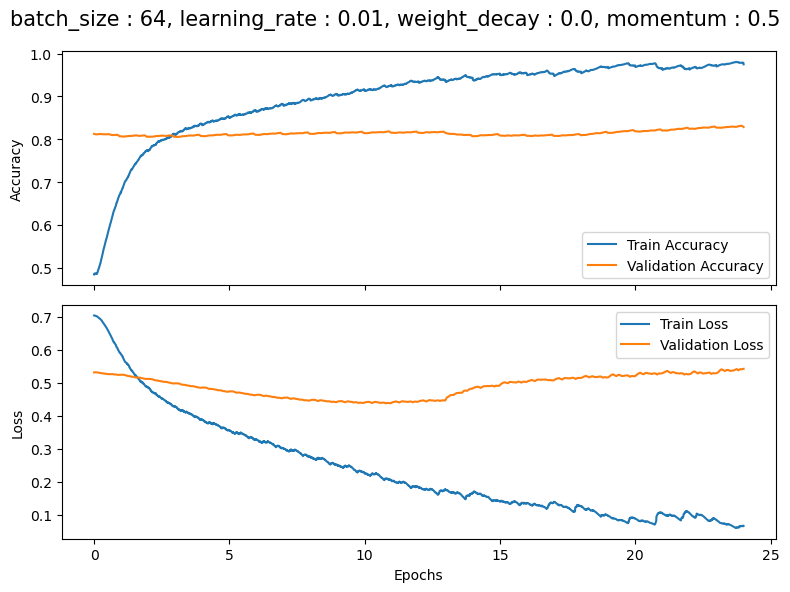

Train accuracy:  96.5
Validation accuracy:  83.9



Combination 21 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.5



Epoch: 1/96, Train loss:  0.665, Train accuracy:  56.6%: 100%|██████████| 36/36 [00:00<00:00, 114.32it/s]
Epoch: 1/96, Val loss:  0.626, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 165.99it/s]


Epoch: 2/96, Train loss:  0.592, Train accuracy:  71.6%: 100%|██████████| 36/36 [00:00<00:00, 107.43it/s]
Epoch: 2/96, Val loss:  0.559, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 172.34it/s]


Epoch: 3/96, Train loss:  0.528, Train accuracy:  75.5%: 100%|██████████| 36/36 [00:00<00:00, 110.78it/s]
Epoch: 3/96, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 173.32it/s]


Epoch: 4/96, Train loss:  0.489, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 110.46it/s]
Epoch: 4/96, Val loss:  0.477, Val accuracy:  77.5%: 100%|██████████| 4/4 [00:00<00:00, 161.82it/s]


Epoch: 5/96, Train loss:  0.468, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 109.39it/s]
Epoch: 5/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 173.56it/s]


Epoch: 6/96, Train loss:  0.451, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 107.74it/s]
Epoch: 6/96, Val loss:  0.451, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 166.20it/s]


Epoch: 7/96, Train loss:  0.435, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 113.09it/s]
Epoch: 7/96, Val loss:  0.442, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 181.66it/s]


Epoch: 8/96, Train loss:  0.419, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 108.87it/s]
Epoch: 8/96, Val loss:  0.435, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 9/96, Train loss:  0.405, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 108.99it/s]
Epoch: 9/96, Val loss:  0.430, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 10/96, Train loss:  0.391, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 107.77it/s]
Epoch: 10/96, Val loss:  0.426, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 185.88it/s]


Epoch: 11/96, Train loss:  0.378, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 109.61it/s]
Epoch: 11/96, Val loss:  0.422, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 180.46it/s]


Epoch: 12/96, Train loss:  0.365, Train accuracy:  82.8%: 100%|██████████| 36/36 [00:00<00:00, 109.80it/s]
Epoch: 12/96, Val loss:  0.417, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 181.34it/s]


Epoch: 13/96, Train loss:  0.353, Train accuracy:  83.4%: 100%|██████████| 36/36 [00:00<00:00, 111.19it/s]
Epoch: 13/96, Val loss:  0.412, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 184.82it/s]


Epoch: 14/96, Train loss:  0.340, Train accuracy:  84.1%: 100%|██████████| 36/36 [00:00<00:00, 112.05it/s]
Epoch: 14/96, Val loss:  0.407, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 189.77it/s]


Epoch: 15/96, Train loss:  0.328, Train accuracy:  84.8%: 100%|██████████| 36/36 [00:00<00:00, 106.34it/s]
Epoch: 15/96, Val loss:  0.402, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 172.55it/s]


Epoch: 16/96, Train loss:  0.315, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 111.72it/s]
Epoch: 16/96, Val loss:  0.399, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 177.21it/s]


Epoch: 17/96, Train loss:  0.303, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 115.02it/s]
Epoch: 17/96, Val loss:  0.395, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 191.22it/s]


Epoch: 18/96, Train loss:  0.291, Train accuracy:  86.4%: 100%|██████████| 36/36 [00:00<00:00, 112.25it/s]
Epoch: 18/96, Val loss:  0.392, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 19/96, Train loss:  0.278, Train accuracy:  87.1%: 100%|██████████| 36/36 [00:00<00:00, 107.83it/s]
Epoch: 19/96, Val loss:  0.390, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.11it/s]


Epoch: 20/96, Train loss:  0.266, Train accuracy:  87.8%: 100%|██████████| 36/36 [00:00<00:00, 110.49it/s]
Epoch: 20/96, Val loss:  0.389, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 173.76it/s]


Epoch: 21/96, Train loss:  0.254, Train accuracy:  88.5%: 100%|██████████| 36/36 [00:00<00:00, 91.66it/s]
Epoch: 21/96, Val loss:  0.390, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 159.89it/s]


Epoch: 22/96, Train loss:  0.242, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 110.65it/s]
Epoch: 22/96, Val loss:  0.394, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 172.36it/s]


Epoch: 23/96, Train loss:  0.231, Train accuracy:  89.6%: 100%|██████████| 36/36 [00:00<00:00, 108.17it/s]
Epoch: 23/96, Val loss:  0.398, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 156.19it/s]


Epoch: 24/96, Train loss:  0.221, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 109.80it/s]
Epoch: 24/96, Val loss:  0.397, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 178.43it/s]


Epoch: 25/96, Train loss:  0.211, Train accuracy:  90.1%: 100%|██████████| 36/36 [00:00<00:00, 112.96it/s]
Epoch: 25/96, Val loss:  0.406, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 172.24it/s]


Epoch: 26/96, Train loss:  0.204, Train accuracy:  90.5%: 100%|██████████| 36/36 [00:00<00:00, 112.90it/s]
Epoch: 26/96, Val loss:  0.408, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 181.43it/s]


Epoch: 27/96, Train loss:  0.199, Train accuracy:  90.9%: 100%|██████████| 36/36 [00:00<00:00, 110.35it/s]
Epoch: 27/96, Val loss:  0.489, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 185.11it/s]


Epoch: 28/96, Train loss:  0.189, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 106.67it/s]
Epoch: 28/96, Val loss:  0.424, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 159.82it/s]


Epoch: 29/96, Train loss:  0.215, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 105.46it/s]
Epoch: 29/96, Val loss:  0.458, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 153.97it/s]


Epoch: 30/96, Train loss:  0.239, Train accuracy:  89.5%: 100%|██████████| 36/36 [00:00<00:00, 103.94it/s]
Epoch: 30/96, Val loss:  0.408, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 141.16it/s]


Epoch: 31/96, Train loss:  0.209, Train accuracy:  90.7%: 100%|██████████| 36/36 [00:00<00:00, 103.41it/s]
Epoch: 31/96, Val loss:  0.399, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 165.52it/s]


Epoch: 32/96, Train loss:  0.167, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 102.57it/s]
Epoch: 32/96, Val loss:  0.405, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 153.97it/s]


Epoch: 33/96, Train loss:  0.153, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 100.16it/s]
Epoch: 33/96, Val loss:  0.408, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 163.23it/s]


Epoch: 34/96, Train loss:  0.136, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 108.33it/s]
Epoch: 34/96, Val loss:  0.420, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 161.31it/s]


Epoch: 35/96, Train loss:  0.131, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 106.92it/s]
Epoch: 35/96, Val loss:  0.566, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 162.06it/s]


Epoch: 36/96, Train loss:  0.250, Train accuracy:  89.6%: 100%|██████████| 36/36 [00:00<00:00, 106.85it/s]
Epoch: 36/96, Val loss:  0.427, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 169.80it/s]


Epoch: 37/96, Train loss:  0.134, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 106.81it/s]
Epoch: 37/96, Val loss:  0.440, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 38/96, Train loss:  0.127, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 107.08it/s]
Epoch: 38/96, Val loss:  0.478, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 163.77it/s]


Epoch: 39/96, Train loss:  0.120, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 106.76it/s]
Epoch: 39/96, Val loss:  0.443, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 117.38it/s]


Epoch: 40/96, Train loss:  0.110, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 104.79it/s]
Epoch: 40/96, Val loss:  0.460, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 158.98it/s]


Epoch: 41/96, Train loss:  0.163, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 106.63it/s]
Epoch: 41/96, Val loss:  0.608, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 157.71it/s]


Epoch: 42/96, Train loss:  0.200, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 102.84it/s]
Epoch: 42/96, Val loss:  0.684, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 150.73it/s]


Epoch: 43/96, Train loss:  0.148, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 102.44it/s]
Epoch: 43/96, Val loss:  0.594, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 147.04it/s]


Epoch: 44/96, Train loss:  0.122, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 106.28it/s]
Epoch: 44/96, Val loss:  0.545, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 162.17it/s]


Epoch: 45/96, Train loss:  0.098, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 104.40it/s]
Epoch: 45/96, Val loss:  0.494, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 166.46it/s]


Epoch: 46/96, Train loss:  0.085, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 104.07it/s]
Epoch: 46/96, Val loss:  0.561, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 156.29it/s]


Epoch: 47/96, Train loss:  0.081, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 90.22it/s]
Epoch: 47/96, Val loss:  0.586, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 162.90it/s]


Epoch: 48/96, Train loss:  0.093, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 107.68it/s]
Epoch: 48/96, Val loss:  0.577, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 162.79it/s]


Epoch: 49/96, Train loss:  0.124, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 108.16it/s]
Epoch: 49/96, Val loss:  0.468, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 153.45it/s]


Epoch: 50/96, Train loss:  0.078, Train accuracy:  95.6%: 100%|██████████| 36/36 [00:00<00:00, 107.64it/s]
Epoch: 50/96, Val loss:  0.676, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 167.92it/s]


Epoch: 51/96, Train loss:  0.093, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 110.16it/s]
Epoch: 51/96, Val loss:  0.857, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 166.30it/s]


Epoch: 52/96, Train loss:  0.116, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 105.30it/s]
Epoch: 52/96, Val loss:  0.926, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 159.56it/s]


Epoch: 53/96, Train loss:  0.151, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 110.55it/s]
Epoch: 53/96, Val loss:  0.597, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 178.14it/s]


Epoch: 54/96, Train loss:  0.084, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 108.99it/s]
Epoch: 54/96, Val loss:  0.507, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 166.15it/s]


Epoch: 55/96, Train loss:  0.069, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 103.67it/s]
Epoch: 55/96, Val loss:  0.495, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 56/96, Train loss:  0.070, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 110.03it/s]
Epoch: 56/96, Val loss:  0.490, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 163.82it/s]


Epoch: 57/96, Train loss:  0.055, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 104.71it/s]
Epoch: 57/96, Val loss:  0.500, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 165.89it/s]


Epoch: 58/96, Train loss:  0.044, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 105.91it/s]
Epoch: 58/96, Val loss:  0.520, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 176.91it/s]


Epoch: 59/96, Train loss:  0.037, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 110.59it/s]
Epoch: 59/96, Val loss:  0.526, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 176.54it/s]


Epoch: 60/96, Train loss:  0.119, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 106.31it/s]
Epoch: 60/96, Val loss:  0.632, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 166.23it/s]


Epoch: 61/96, Train loss:  0.054, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 102.68it/s]
Epoch: 61/96, Val loss:  0.522, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 159.82it/s]


Epoch: 62/96, Train loss:  0.036, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 106.36it/s]
Epoch: 62/96, Val loss:  0.535, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 172.86it/s]


Epoch: 63/96, Train loss:  0.032, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 108.58it/s]
Epoch: 63/96, Val loss:  0.544, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 176.81it/s]


Epoch: 64/96, Train loss:  0.028, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 106.91it/s]
Epoch: 64/96, Val loss:  0.664, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 181.12it/s]


Epoch: 65/96, Train loss:  0.027, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 107.81it/s]
Epoch: 65/96, Val loss:  0.567, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 180.89it/s]


Epoch: 66/96, Train loss:  0.027, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 66/96, Val loss:  1.280, Val accuracy:  71.3%: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s]


Epoch: 67/96, Train loss:  0.166, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 98.96it/s] 
Epoch: 67/96, Val loss:  0.562, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 173.32it/s]


Epoch: 68/96, Train loss:  0.030, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 110.19it/s]
Epoch: 68/96, Val loss:  0.577, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.11it/s]


Epoch: 69/96, Train loss:  0.030, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 108.30it/s]
Epoch: 69/96, Val loss:  0.634, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 165.37it/s]


Epoch: 70/96, Train loss:  0.025, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 98.18it/s] 
Epoch: 70/96, Val loss:  0.685, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 143.70it/s]


Epoch: 71/96, Train loss:  0.024, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 108.80it/s]
Epoch: 71/96, Val loss:  0.691, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 169.52it/s]


Epoch: 72/96, Train loss:  0.024, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 105.96it/s]
Epoch: 72/96, Val loss:  0.632, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 176.96it/s]


Epoch: 73/96, Train loss:  0.023, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 89.13it/s] 
Epoch: 73/96, Val loss:  0.626, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 172.65it/s]


Epoch: 74/96, Train loss:  0.020, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.16it/s]
Epoch: 74/96, Val loss:  0.618, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 156.18it/s]


Epoch: 75/96, Train loss:  0.019, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.94it/s]
Epoch: 75/96, Val loss:  0.613, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 176.75it/s]


Epoch: 76/96, Train loss:  0.017, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 76/96, Val loss:  0.617, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 181.14it/s]


Epoch: 77/96, Train loss:  0.200, Train accuracy:  93.5%: 100%|██████████| 36/36 [00:00<00:00, 101.25it/s]
Epoch: 77/96, Val loss:  0.527, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 177.56it/s]


Epoch: 78/96, Train loss:  0.024, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 109.74it/s]
Epoch: 78/96, Val loss:  0.543, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 164.57it/s]


Epoch: 79/96, Train loss:  0.019, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 109.66it/s]
Epoch: 79/96, Val loss:  0.569, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 180.91it/s]


Epoch: 80/96, Train loss:  0.018, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 108.05it/s]
Epoch: 80/96, Val loss:  0.587, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 185.37it/s]


Epoch: 81/96, Train loss:  0.017, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 108.20it/s]
Epoch: 81/96, Val loss:  0.596, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 173.47it/s]


Epoch: 82/96, Train loss:  0.016, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 110.16it/s]
Epoch: 82/96, Val loss:  0.604, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 177.14it/s]


Epoch: 83/96, Train loss:  0.014, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 101.04it/s]
Epoch: 83/96, Val loss:  0.615, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 170.18it/s]


Epoch: 84/96, Train loss:  0.014, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 111.30it/s]
Epoch: 84/96, Val loss:  0.622, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 166.63it/s]


Epoch: 85/96, Train loss:  0.016, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 110.10it/s]
Epoch: 85/96, Val loss:  0.628, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 170.00it/s]


Epoch: 86/96, Train loss:  0.246, Train accuracy:  92.7%: 100%|██████████| 36/36 [00:00<00:00, 109.34it/s]
Epoch: 86/96, Val loss:  0.525, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 162.26it/s]


Epoch: 87/96, Train loss:  0.027, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 109.22it/s]
Epoch: 87/96, Val loss:  0.526, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 177.38it/s]


Epoch: 88/96, Train loss:  0.019, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 110.06it/s]
Epoch: 88/96, Val loss:  0.560, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 176.12it/s]


Epoch: 89/96, Train loss:  0.017, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 110.62it/s]
Epoch: 89/96, Val loss:  0.573, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 173.30it/s]


Epoch: 90/96, Train loss:  0.015, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.22it/s]
Epoch: 90/96, Val loss:  0.595, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 165.25it/s]


Epoch: 91/96, Train loss:  0.014, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 109.90it/s]
Epoch: 91/96, Val loss:  0.610, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 173.46it/s]


Epoch: 92/96, Train loss:  0.013, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 110.38it/s]
Epoch: 92/96, Val loss:  0.621, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 174.54it/s]


Epoch: 93/96, Train loss:  0.012, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.94it/s]
Epoch: 93/96, Val loss:  0.631, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 169.51it/s]


Epoch: 94/96, Train loss:  0.011, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 111.07it/s]
Epoch: 94/96, Val loss:  0.642, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 174.42it/s]


Epoch: 95/96, Train loss:  0.010, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 110.83it/s]
Epoch: 95/96, Val loss:  0.652, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 173.59it/s]


Epoch: 96/96, Train loss:  0.009, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.92it/s]
Epoch: 96/96, Val loss:  0.661, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 163.08it/s]


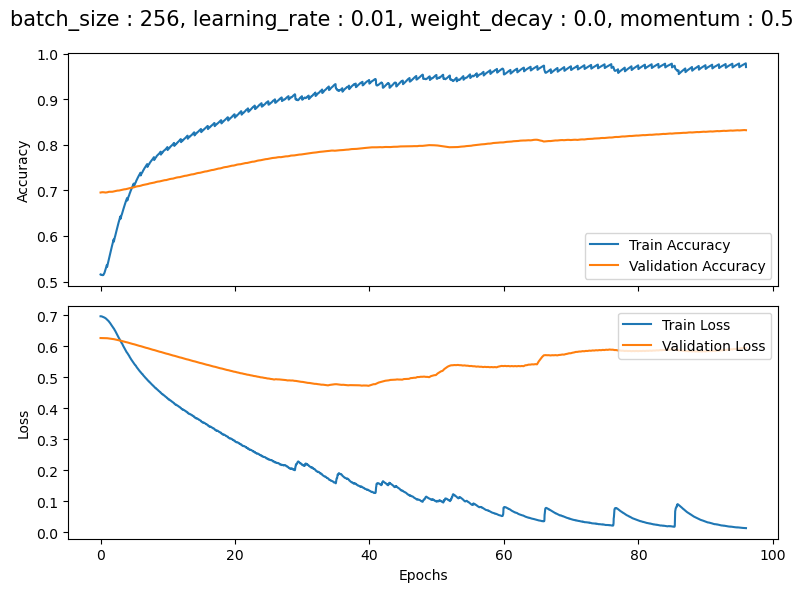

Train accuracy:  97.5
Validation accuracy:  84.5



Combination 22 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.5



Epoch: 1/6, Train loss:  0.639, Train accuracy:  64.6%: 100%|██████████| 563/563 [00:05<00:00, 100.14it/s]
Epoch: 1/6, Val loss:  0.584, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 420.48it/s]


Epoch: 2/6, Train loss:  0.531, Train accuracy:  76.9%: 100%|██████████| 563/563 [00:09<00:00, 58.94it/s]
Epoch: 2/6, Val loss:  0.497, Val accuracy:  77.9%: 100%|██████████| 63/63 [00:00<00:00, 346.59it/s]


Epoch: 3/6, Train loss:  0.478, Train accuracy:  79.7%: 100%|██████████| 563/563 [00:09<00:00, 60.31it/s]
Epoch: 3/6, Val loss:  0.466, Val accuracy:  79.8%: 100%|██████████| 63/63 [00:00<00:00, 326.33it/s]


Epoch: 4/6, Train loss:  0.452, Train accuracy:  80.7%: 100%|██████████| 563/563 [00:09<00:00, 58.96it/s]
Epoch: 4/6, Val loss:  0.450, Val accuracy:  81.2%: 100%|██████████| 63/63 [00:00<00:00, 356.36it/s]


Epoch: 5/6, Train loss:  0.429, Train accuracy:  82.0%: 100%|██████████| 563/563 [00:09<00:00, 61.67it/s]
Epoch: 5/6, Val loss:  0.438, Val accuracy:  81.3%: 100%|██████████| 63/63 [00:00<00:00, 305.84it/s]


Epoch: 6/6, Train loss:  0.407, Train accuracy:  83.1%: 100%|██████████| 563/563 [00:08<00:00, 64.18it/s]
Epoch: 6/6, Val loss:  0.428, Val accuracy:  81.5%: 100%|██████████| 63/63 [00:00<00:00, 341.21it/s]


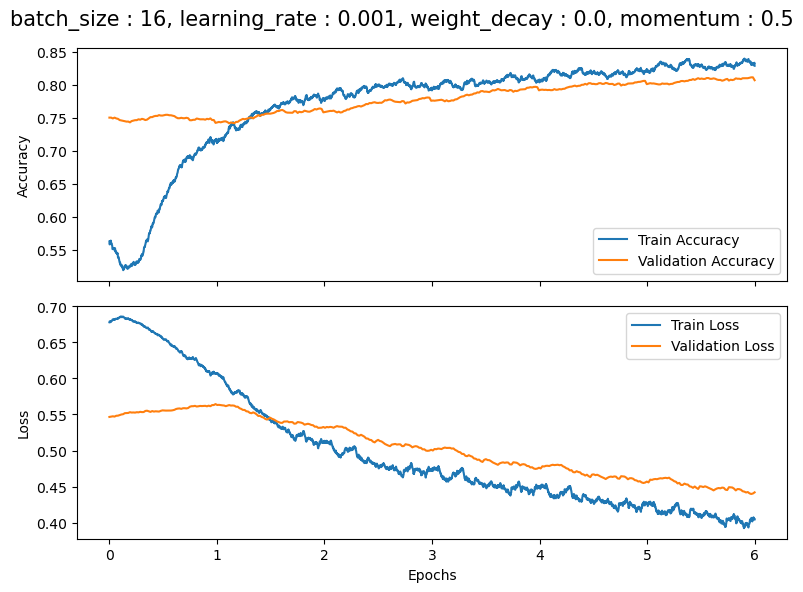

Train accuracy:  83.9
Validation accuracy:  81.5



Combination 23 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.5



Epoch: 1/24, Train loss:  0.684, Train accuracy:  50.2%: 100%|██████████| 141/141 [00:00<00:00, 182.78it/s]
Epoch: 1/24, Val loss:  0.665, Val accuracy:  55.9%: 100%|██████████| 16/16 [00:00<00:00, 391.46it/s]


Epoch: 2/24, Train loss:  0.654, Train accuracy:  62.9%: 100%|██████████| 141/141 [00:00<00:00, 141.39it/s]
Epoch: 2/24, Val loss:  0.638, Val accuracy:  67.3%: 100%|██████████| 16/16 [00:00<00:00, 393.63it/s]


Epoch: 3/24, Train loss:  0.624, Train accuracy:  70.7%: 100%|██████████| 141/141 [00:01<00:00, 137.46it/s]
Epoch: 3/24, Val loss:  0.611, Val accuracy:  70.4%: 100%|██████████| 16/16 [00:00<00:00, 424.84it/s]


Epoch: 4/24, Train loss:  0.593, Train accuracy:  72.9%: 100%|██████████| 141/141 [00:01<00:00, 133.69it/s]
Epoch: 4/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 347.85it/s]


Epoch: 5/24, Train loss:  0.565, Train accuracy:  75.1%: 100%|██████████| 141/141 [00:01<00:00, 134.66it/s]
Epoch: 5/24, Val loss:  0.558, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 374.41it/s]


Epoch: 6/24, Train loss:  0.538, Train accuracy:  76.6%: 100%|██████████| 141/141 [00:01<00:00, 137.68it/s]
Epoch: 6/24, Val loss:  0.533, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 358.76it/s]


Epoch: 7/24, Train loss:  0.516, Train accuracy:  77.7%: 100%|██████████| 141/141 [00:00<00:00, 142.76it/s]
Epoch: 7/24, Val loss:  0.513, Val accuracy:  76.2%: 100%|██████████| 16/16 [00:00<00:00, 401.39it/s]


Epoch: 8/24, Train loss:  0.500, Train accuracy:  78.3%: 100%|██████████| 141/141 [00:01<00:00, 133.84it/s]
Epoch: 8/24, Val loss:  0.498, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 396.87it/s]


Epoch: 9/24, Train loss:  0.487, Train accuracy:  79.1%: 100%|██████████| 141/141 [00:00<00:00, 145.18it/s]
Epoch: 9/24, Val loss:  0.487, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 370.98it/s]


Epoch: 10/24, Train loss:  0.478, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:00<00:00, 147.27it/s]
Epoch: 10/24, Val loss:  0.479, Val accuracy:  77.6%: 100%|██████████| 16/16 [00:00<00:00, 331.31it/s]


Epoch: 11/24, Train loss:  0.470, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:00<00:00, 155.72it/s]
Epoch: 11/24, Val loss:  0.472, Val accuracy:  78.1%: 100%|██████████| 16/16 [00:00<00:00, 336.12it/s]


Epoch: 12/24, Train loss:  0.463, Train accuracy:  80.3%: 100%|██████████| 141/141 [00:00<00:00, 141.00it/s]
Epoch: 12/24, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 395.37it/s]


Epoch: 13/24, Train loss:  0.456, Train accuracy:  80.7%: 100%|██████████| 141/141 [00:01<00:00, 136.21it/s]
Epoch: 13/24, Val loss:  0.462, Val accuracy:  79.0%: 100%|██████████| 16/16 [00:00<00:00, 386.54it/s]


Epoch: 14/24, Train loss:  0.450, Train accuracy:  80.9%: 100%|██████████| 141/141 [00:01<00:00, 138.30it/s]
Epoch: 14/24, Val loss:  0.457, Val accuracy:  79.4%: 100%|██████████| 16/16 [00:00<00:00, 414.40it/s]


Epoch: 15/24, Train loss:  0.443, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:01<00:00, 132.01it/s]
Epoch: 15/24, Val loss:  0.453, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 412.14it/s]


Epoch: 16/24, Train loss:  0.437, Train accuracy:  81.6%: 100%|██████████| 141/141 [00:00<00:00, 151.73it/s]
Epoch: 16/24, Val loss:  0.449, Val accuracy:  79.2%: 100%|██████████| 16/16 [00:00<00:00, 430.91it/s]


Epoch: 17/24, Train loss:  0.431, Train accuracy:  81.9%: 100%|██████████| 141/141 [00:00<00:00, 152.24it/s]
Epoch: 17/24, Val loss:  0.446, Val accuracy:  79.6%: 100%|██████████| 16/16 [00:00<00:00, 408.92it/s]


Epoch: 18/24, Train loss:  0.424, Train accuracy:  82.0%: 100%|██████████| 141/141 [00:00<00:00, 146.03it/s]
Epoch: 18/24, Val loss:  0.442, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 419.70it/s]


Epoch: 19/24, Train loss:  0.418, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:00<00:00, 149.35it/s]
Epoch: 19/24, Val loss:  0.440, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 424.83it/s]


Epoch: 20/24, Train loss:  0.412, Train accuracy:  82.6%: 100%|██████████| 141/141 [00:00<00:00, 150.94it/s]
Epoch: 20/24, Val loss:  0.437, Val accuracy:  80.6%: 100%|██████████| 16/16 [00:00<00:00, 415.80it/s]


Epoch: 21/24, Train loss:  0.406, Train accuracy:  82.9%: 100%|██████████| 141/141 [00:01<00:00, 135.89it/s]
Epoch: 21/24, Val loss:  0.434, Val accuracy:  80.5%: 100%|██████████| 16/16 [00:00<00:00, 429.67it/s]


Epoch: 22/24, Train loss:  0.400, Train accuracy:  83.2%: 100%|██████████| 141/141 [00:00<00:00, 144.73it/s]
Epoch: 22/24, Val loss:  0.432, Val accuracy:  80.4%: 100%|██████████| 16/16 [00:00<00:00, 392.36it/s]


Epoch: 23/24, Train loss:  0.394, Train accuracy:  83.4%: 100%|██████████| 141/141 [00:00<00:00, 151.11it/s]
Epoch: 23/24, Val loss:  0.430, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 414.09it/s]


Epoch: 24/24, Train loss:  0.389, Train accuracy:  83.5%: 100%|██████████| 141/141 [00:00<00:00, 142.43it/s]
Epoch: 24/24, Val loss:  0.427, Val accuracy:  80.5%: 100%|██████████| 16/16 [00:00<00:00, 420.30it/s]


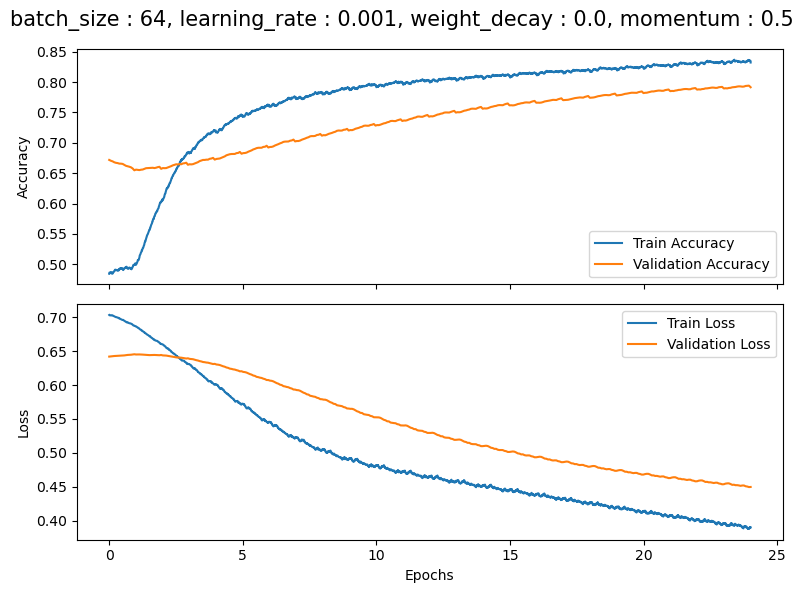

Train accuracy:  84.0
Validation accuracy:  80.5



Combination 24 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.5



Epoch: 1/96, Train loss:  0.696, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 114.65it/s]
Epoch: 1/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 159.69it/s]


Epoch: 2/96, Train loss:  0.687, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 108.85it/s]
Epoch: 2/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 165.84it/s]


Epoch: 3/96, Train loss:  0.680, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 110.08it/s]
Epoch: 3/96, Val loss:  0.671, Val accuracy:  50.8%: 100%|██████████| 4/4 [00:00<00:00, 177.25it/s]


Epoch: 4/96, Train loss:  0.673, Train accuracy:  50.9%: 100%|██████████| 36/36 [00:00<00:00, 111.42it/s]
Epoch: 4/96, Val loss:  0.664, Val accuracy:  55.9%: 100%|██████████| 4/4 [00:00<00:00, 162.84it/s]


Epoch: 5/96, Train loss:  0.665, Train accuracy:  56.8%: 100%|██████████| 36/36 [00:00<00:00, 112.10it/s]
Epoch: 5/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 6/96, Train loss:  0.657, Train accuracy:  61.2%: 100%|██████████| 36/36 [00:00<00:00, 110.69it/s]
Epoch: 6/96, Val loss:  0.650, Val accuracy:  63.1%: 100%|██████████| 4/4 [00:00<00:00, 176.71it/s]


Epoch: 7/96, Train loss:  0.650, Train accuracy:  64.1%: 100%|██████████| 36/36 [00:00<00:00, 111.11it/s]
Epoch: 7/96, Val loss:  0.643, Val accuracy:  66.2%: 100%|██████████| 4/4 [00:00<00:00, 166.55it/s]


Epoch: 8/96, Train loss:  0.642, Train accuracy:  66.2%: 100%|██████████| 36/36 [00:00<00:00, 109.29it/s]
Epoch: 8/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 162.09it/s]


Epoch: 9/96, Train loss:  0.635, Train accuracy:  67.6%: 100%|██████████| 36/36 [00:00<00:00, 109.59it/s]
Epoch: 9/96, Val loss:  0.629, Val accuracy:  68.7%: 100%|██████████| 4/4 [00:00<00:00, 183.11it/s]


Epoch: 10/96, Train loss:  0.627, Train accuracy:  68.9%: 100%|██████████| 36/36 [00:00<00:00, 109.90it/s]
Epoch: 10/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 181.58it/s]


Epoch: 11/96, Train loss:  0.619, Train accuracy:  69.9%: 100%|██████████| 36/36 [00:00<00:00, 112.20it/s]
Epoch: 11/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 145.08it/s]


Epoch: 12/96, Train loss:  0.612, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 109.76it/s]
Epoch: 12/96, Val loss:  0.608, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 177.36it/s]


Epoch: 13/96, Train loss:  0.604, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 110.65it/s]
Epoch: 13/96, Val loss:  0.601, Val accuracy:  70.6%: 100%|██████████| 4/4 [00:00<00:00, 181.33it/s]


Epoch: 14/96, Train loss:  0.596, Train accuracy:  71.3%: 100%|██████████| 36/36 [00:00<00:00, 110.34it/s]
Epoch: 14/96, Val loss:  0.594, Val accuracy:  71.0%: 100%|██████████| 4/4 [00:00<00:00, 163.74it/s]


Epoch: 15/96, Train loss:  0.589, Train accuracy:  72.0%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 15/96, Val loss:  0.587, Val accuracy:  71.8%: 100%|██████████| 4/4 [00:00<00:00, 189.79it/s]


Epoch: 16/96, Train loss:  0.582, Train accuracy:  72.5%: 100%|██████████| 36/36 [00:00<00:00, 110.13it/s]
Epoch: 16/96, Val loss:  0.581, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 185.18it/s]


Epoch: 17/96, Train loss:  0.574, Train accuracy:  73.0%: 100%|██████████| 36/36 [00:00<00:00, 109.97it/s]
Epoch: 17/96, Val loss:  0.574, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 176.77it/s]


Epoch: 18/96, Train loss:  0.567, Train accuracy:  73.5%: 100%|██████████| 36/36 [00:00<00:00, 112.17it/s]
Epoch: 18/96, Val loss:  0.567, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 175.62it/s]


Epoch: 19/96, Train loss:  0.560, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 106.34it/s]
Epoch: 19/96, Val loss:  0.560, Val accuracy:  73.5%: 100%|██████████| 4/4 [00:00<00:00, 169.95it/s]


Epoch: 20/96, Train loss:  0.553, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 109.60it/s]
Epoch: 20/96, Val loss:  0.554, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 183.83it/s]


Epoch: 21/96, Train loss:  0.547, Train accuracy:  74.7%: 100%|██████████| 36/36 [00:00<00:00, 113.32it/s]
Epoch: 21/96, Val loss:  0.547, Val accuracy:  74.1%: 100%|██████████| 4/4 [00:00<00:00, 162.79it/s]


Epoch: 22/96, Train loss:  0.540, Train accuracy:  75.1%: 100%|██████████| 36/36 [00:00<00:00, 109.27it/s]
Epoch: 22/96, Val loss:  0.541, Val accuracy:  74.9%: 100%|██████████| 4/4 [00:00<00:00, 169.73it/s]


Epoch: 23/96, Train loss:  0.534, Train accuracy:  75.4%: 100%|██████████| 36/36 [00:00<00:00, 111.51it/s]
Epoch: 23/96, Val loss:  0.534, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 176.89it/s]


Epoch: 24/96, Train loss:  0.528, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 110.73it/s]
Epoch: 24/96, Val loss:  0.528, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 173.80it/s]


Epoch: 25/96, Train loss:  0.522, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 111.82it/s]
Epoch: 25/96, Val loss:  0.523, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 171.58it/s]


Epoch: 26/96, Train loss:  0.517, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 90.78it/s]
Epoch: 26/96, Val loss:  0.518, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 176.10it/s]


Epoch: 27/96, Train loss:  0.512, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 27/96, Val loss:  0.513, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 173.73it/s]


Epoch: 28/96, Train loss:  0.508, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 28/96, Val loss:  0.508, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 172.17it/s]


Epoch: 29/96, Train loss:  0.504, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 112.51it/s]
Epoch: 29/96, Val loss:  0.504, Val accuracy:  76.5%: 100%|██████████| 4/4 [00:00<00:00, 181.25it/s]


Epoch: 30/96, Train loss:  0.500, Train accuracy:  76.8%: 100%|██████████| 36/36 [00:00<00:00, 107.46it/s]
Epoch: 30/96, Val loss:  0.500, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 178.86it/s]


Epoch: 31/96, Train loss:  0.496, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 108.47it/s]
Epoch: 31/96, Val loss:  0.497, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 172.07it/s]


Epoch: 32/96, Train loss:  0.493, Train accuracy:  77.2%: 100%|██████████| 36/36 [00:00<00:00, 111.96it/s]
Epoch: 32/96, Val loss:  0.493, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 159.53it/s]


Epoch: 33/96, Train loss:  0.490, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 109.17it/s]
Epoch: 33/96, Val loss:  0.490, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 162.64it/s]


Epoch: 34/96, Train loss:  0.487, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 106.90it/s]
Epoch: 34/96, Val loss:  0.488, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 181.67it/s]


Epoch: 35/96, Train loss:  0.484, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 111.27it/s]
Epoch: 35/96, Val loss:  0.485, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 156.14it/s]


Epoch: 36/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 110.04it/s]
Epoch: 36/96, Val loss:  0.483, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 181.69it/s]


Epoch: 37/96, Train loss:  0.479, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 108.56it/s]
Epoch: 37/96, Val loss:  0.480, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 175.68it/s]


Epoch: 38/96, Train loss:  0.477, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 109.07it/s]
Epoch: 38/96, Val loss:  0.478, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 176.50it/s]


Epoch: 39/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 112.44it/s]
Epoch: 39/96, Val loss:  0.476, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 176.30it/s]


Epoch: 40/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 106.50it/s]
Epoch: 40/96, Val loss:  0.474, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 41/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 41/96, Val loss:  0.473, Val accuracy:  77.4%: 100%|██████████| 4/4 [00:00<00:00, 174.43it/s]


Epoch: 42/96, Train loss:  0.469, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 110.72it/s]
Epoch: 42/96, Val loss:  0.471, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 168.69it/s]


Epoch: 43/96, Train loss:  0.467, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 109.02it/s]
Epoch: 43/96, Val loss:  0.469, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 155.88it/s]


Epoch: 44/96, Train loss:  0.465, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 109.21it/s]
Epoch: 44/96, Val loss:  0.468, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 177.52it/s]


Epoch: 45/96, Train loss:  0.463, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 109.72it/s]
Epoch: 45/96, Val loss:  0.466, Val accuracy:  78.2%: 100%|██████████| 4/4 [00:00<00:00, 181.14it/s]


Epoch: 46/96, Train loss:  0.461, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 113.25it/s]
Epoch: 46/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 172.94it/s]


Epoch: 47/96, Train loss:  0.460, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 107.74it/s]
Epoch: 47/96, Val loss:  0.463, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 176.44it/s]


Epoch: 48/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 109.60it/s]
Epoch: 48/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 170.01it/s]


Epoch: 49/96, Train loss:  0.456, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 113.21it/s]
Epoch: 49/96, Val loss:  0.461, Val accuracy:  79.0%: 100%|██████████| 4/4 [00:00<00:00, 171.21it/s]


Epoch: 50/96, Train loss:  0.454, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 111.74it/s]
Epoch: 50/96, Val loss:  0.460, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 142.56it/s]


Epoch: 51/96, Train loss:  0.452, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 108.23it/s]
Epoch: 51/96, Val loss:  0.458, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch: 52/96, Train loss:  0.451, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 89.83it/s] 
Epoch: 52/96, Val loss:  0.457, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 179.27it/s]


Epoch: 53/96, Train loss:  0.449, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 111.95it/s]
Epoch: 53/96, Val loss:  0.456, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 169.69it/s]


Epoch: 54/96, Train loss:  0.447, Train accuracy:  79.4%: 100%|██████████| 36/36 [00:00<00:00, 109.14it/s]
Epoch: 54/96, Val loss:  0.455, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 171.91it/s]


Epoch: 55/96, Train loss:  0.445, Train accuracy:  79.4%: 100%|██████████| 36/36 [00:00<00:00, 110.02it/s]
Epoch: 55/96, Val loss:  0.454, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 169.73it/s]


Epoch: 56/96, Train loss:  0.444, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 110.77it/s]
Epoch: 56/96, Val loss:  0.453, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 161.13it/s]


Epoch: 57/96, Train loss:  0.442, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 109.99it/s]
Epoch: 57/96, Val loss:  0.452, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 181.53it/s]


Epoch: 58/96, Train loss:  0.440, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 108.48it/s]
Epoch: 58/96, Val loss:  0.451, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 173.43it/s]


Epoch: 59/96, Train loss:  0.438, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 109.78it/s]
Epoch: 59/96, Val loss:  0.450, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 169.65it/s]


Epoch: 60/96, Train loss:  0.437, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 111.96it/s]
Epoch: 60/96, Val loss:  0.449, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 166.23it/s]


Epoch: 61/96, Train loss:  0.435, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 108.41it/s]
Epoch: 61/96, Val loss:  0.448, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 62/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 109.41it/s]
Epoch: 62/96, Val loss:  0.447, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 173.27it/s]


Epoch: 63/96, Train loss:  0.431, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 111.58it/s]
Epoch: 63/96, Val loss:  0.446, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 166.19it/s]


Epoch: 64/96, Train loss:  0.430, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 108.40it/s]
Epoch: 64/96, Val loss:  0.445, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 161.17it/s]


Epoch: 65/96, Train loss:  0.428, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 106.57it/s]
Epoch: 65/96, Val loss:  0.444, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 180.96it/s]


Epoch: 66/96, Train loss:  0.426, Train accuracy:  80.2%: 100%|██████████| 36/36 [00:00<00:00, 109.38it/s]
Epoch: 66/96, Val loss:  0.443, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s]


Epoch: 67/96, Train loss:  0.424, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s]
Epoch: 67/96, Val loss:  0.442, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 68/96, Train loss:  0.423, Train accuracy:  80.4%: 100%|██████████| 36/36 [00:00<00:00, 105.93it/s]
Epoch: 68/96, Val loss:  0.441, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 169.53it/s]


Epoch: 69/96, Train loss:  0.421, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 108.73it/s]
Epoch: 69/96, Val loss:  0.440, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 70/96, Train loss:  0.419, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 110.76it/s]
Epoch: 70/96, Val loss:  0.440, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 164.67it/s]


Epoch: 71/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 107.90it/s]
Epoch: 71/96, Val loss:  0.439, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 184.15it/s]


Epoch: 72/96, Train loss:  0.416, Train accuracy:  80.7%: 100%|██████████| 36/36 [00:00<00:00, 108.98it/s]
Epoch: 72/96, Val loss:  0.438, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 176.97it/s]


Epoch: 73/96, Train loss:  0.414, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 108.45it/s]
Epoch: 73/96, Val loss:  0.437, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 181.56it/s]


Epoch: 74/96, Train loss:  0.412, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 111.74it/s]
Epoch: 74/96, Val loss:  0.437, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 175.35it/s]


Epoch: 75/96, Train loss:  0.411, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 107.42it/s]
Epoch: 75/96, Val loss:  0.436, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 76/96, Train loss:  0.409, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 109.18it/s]
Epoch: 76/96, Val loss:  0.435, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 176.50it/s]


Epoch: 77/96, Train loss:  0.407, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 77/96, Val loss:  0.434, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 166.12it/s]


Epoch: 78/96, Train loss:  0.406, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 89.84it/s] 
Epoch: 78/96, Val loss:  0.434, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 169.96it/s]


Epoch: 79/96, Train loss:  0.404, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 109.75it/s]
Epoch: 79/96, Val loss:  0.433, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.57it/s]


Epoch: 80/96, Train loss:  0.402, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 108.83it/s]
Epoch: 80/96, Val loss:  0.432, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]


Epoch: 81/96, Train loss:  0.401, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 111.34it/s]
Epoch: 81/96, Val loss:  0.432, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 162.65it/s]


Epoch: 82/96, Train loss:  0.399, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 108.45it/s]
Epoch: 82/96, Val loss:  0.431, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 176.66it/s]


Epoch: 83/96, Train loss:  0.397, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 105.89it/s]
Epoch: 83/96, Val loss:  0.430, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 84/96, Train loss:  0.396, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 107.28it/s]
Epoch: 84/96, Val loss:  0.430, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 190.12it/s]


Epoch: 85/96, Train loss:  0.394, Train accuracy:  81.6%: 100%|██████████| 36/36 [00:00<00:00, 103.92it/s]
Epoch: 85/96, Val loss:  0.429, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 169.44it/s]


Epoch: 86/96, Train loss:  0.393, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 105.11it/s]
Epoch: 86/96, Val loss:  0.429, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 172.88it/s]


Epoch: 87/96, Train loss:  0.391, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 102.35it/s]
Epoch: 87/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 150.45it/s]


Epoch: 88/96, Train loss:  0.390, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 104.95it/s]
Epoch: 88/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 173.16it/s]


Epoch: 89/96, Train loss:  0.388, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 113.03it/s]
Epoch: 89/96, Val loss:  0.427, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 185.10it/s]


Epoch: 90/96, Train loss:  0.386, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 109.82it/s]
Epoch: 90/96, Val loss:  0.426, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 185.00it/s]


Epoch: 91/96, Train loss:  0.385, Train accuracy:  82.0%: 100%|██████████| 36/36 [00:00<00:00, 107.31it/s]
Epoch: 91/96, Val loss:  0.426, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 169.37it/s]


Epoch: 92/96, Train loss:  0.383, Train accuracy:  82.1%: 100%|██████████| 36/36 [00:00<00:00, 112.47it/s]
Epoch: 92/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 173.30it/s]


Epoch: 93/96, Train loss:  0.382, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 111.51it/s]
Epoch: 93/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 180.72it/s]


Epoch: 94/96, Train loss:  0.380, Train accuracy:  82.3%: 100%|██████████| 36/36 [00:00<00:00, 111.04it/s]
Epoch: 94/96, Val loss:  0.424, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 181.54it/s]


Epoch: 95/96, Train loss:  0.379, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 108.04it/s]
Epoch: 95/96, Val loss:  0.424, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 167.97it/s]


Epoch: 96/96, Train loss:  0.377, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 111.88it/s]
Epoch: 96/96, Val loss:  0.423, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 181.23it/s]


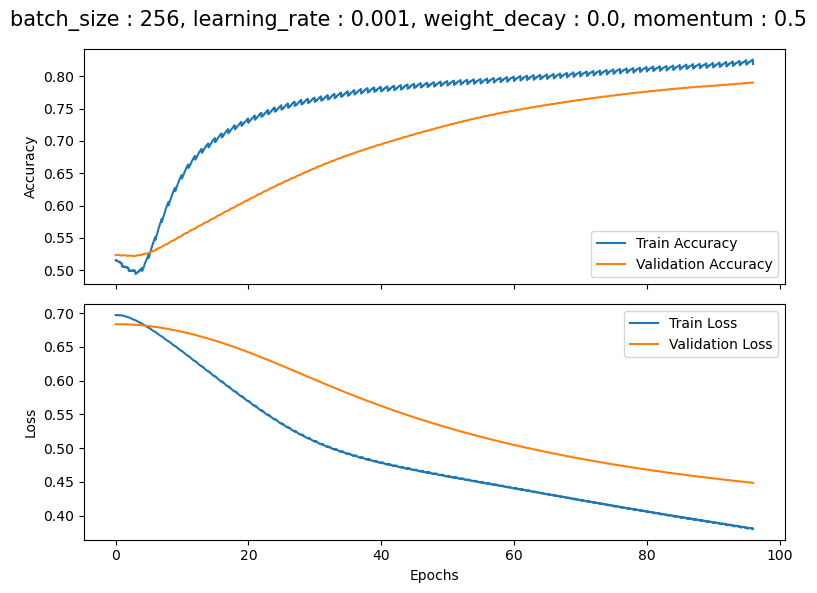

Train accuracy:  82.5
Validation accuracy:  81.0



Combination 25 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.5



Epoch: 1/6, Train loss:  0.488, Train accuracy:  77.7%: 100%|██████████| 563/563 [00:06<00:00, 92.71it/s] 
Epoch: 1/6, Val loss:  0.423, Val accuracy:  81.9%: 100%|██████████| 63/63 [00:00<00:00, 434.37it/s]


Epoch: 2/6, Train loss:  0.399, Train accuracy:  82.9%: 100%|██████████| 563/563 [00:09<00:00, 56.32it/s]
Epoch: 2/6, Val loss:  0.403, Val accuracy:  83.1%: 100%|██████████| 63/63 [00:00<00:00, 335.47it/s]


Epoch: 3/6, Train loss:  0.357, Train accuracy:  85.4%: 100%|██████████| 563/563 [00:08<00:00, 63.28it/s]
Epoch: 3/6, Val loss:  0.391, Val accuracy:  83.4%: 100%|██████████| 63/63 [00:00<00:00, 339.96it/s]


Epoch: 4/6, Train loss:  0.321, Train accuracy:  87.2%: 100%|██████████| 563/563 [00:09<00:00, 60.12it/s]
Epoch: 4/6, Val loss:  0.396, Val accuracy:  83.2%: 100%|██████████| 63/63 [00:00<00:00, 332.26it/s]


Epoch: 5/6, Train loss:  0.288, Train accuracy:  88.9%: 100%|██████████| 563/563 [00:09<00:00, 58.46it/s]
Epoch: 5/6, Val loss:  0.400, Val accuracy:  84.1%: 100%|██████████| 63/63 [00:00<00:00, 320.38it/s]


Epoch: 6/6, Train loss:  0.254, Train accuracy:  90.8%: 100%|██████████| 563/563 [00:09<00:00, 58.76it/s]
Epoch: 6/6, Val loss:  0.406, Val accuracy:  85.2%: 100%|██████████| 63/63 [00:00<00:00, 299.91it/s]


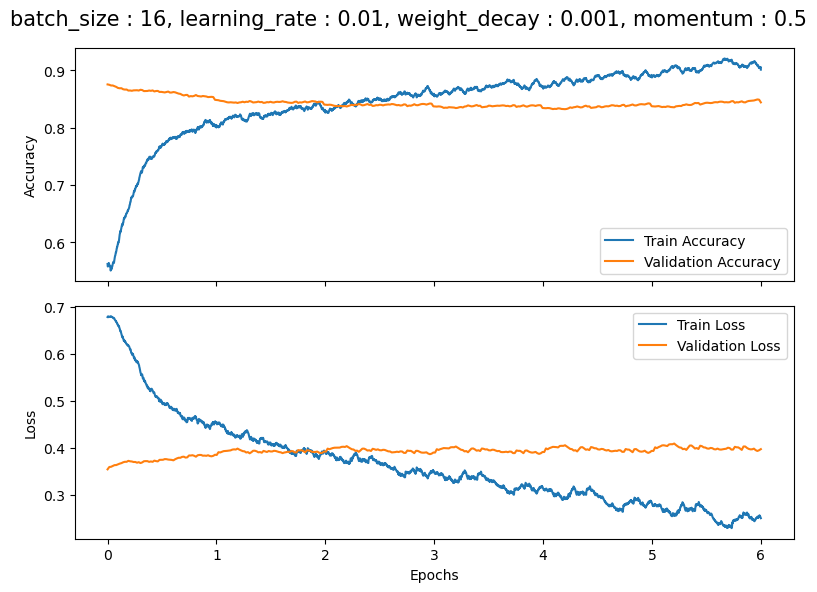

Train accuracy:  90.9
Validation accuracy:  85.2



Combination 26 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.5



Epoch: 1/24, Train loss:  0.572, Train accuracy:  71.1%: 100%|██████████| 141/141 [00:00<00:00, 177.58it/s]
Epoch: 1/24, Val loss:  0.482, Val accuracy:  77.7%: 100%|██████████| 16/16 [00:00<00:00, 419.09it/s]


Epoch: 2/24, Train loss:  0.458, Train accuracy:  80.4%: 100%|██████████| 141/141 [00:01<00:00, 137.18it/s]
Epoch: 2/24, Val loss:  0.440, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 424.91it/s]


Epoch: 3/24, Train loss:  0.413, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:00<00:00, 146.11it/s]
Epoch: 3/24, Val loss:  0.420, Val accuracy:  80.6%: 100%|██████████| 16/16 [00:00<00:00, 413.57it/s]


Epoch: 4/24, Train loss:  0.379, Train accuracy:  84.1%: 100%|██████████| 141/141 [00:01<00:00, 137.67it/s]
Epoch: 4/24, Val loss:  0.412, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 419.47it/s]


Epoch: 5/24, Train loss:  0.349, Train accuracy:  85.5%: 100%|██████████| 141/141 [00:00<00:00, 147.15it/s]
Epoch: 5/24, Val loss:  0.407, Val accuracy:  81.5%: 100%|██████████| 16/16 [00:00<00:00, 430.57it/s]


Epoch: 6/24, Train loss:  0.323, Train accuracy:  86.8%: 100%|██████████| 141/141 [00:00<00:00, 149.20it/s]
Epoch: 6/24, Val loss:  0.403, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 419.60it/s]


Epoch: 7/24, Train loss:  0.298, Train accuracy:  88.1%: 100%|██████████| 141/141 [00:01<00:00, 140.01it/s]
Epoch: 7/24, Val loss:  0.403, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 430.47it/s]


Epoch: 8/24, Train loss:  0.274, Train accuracy:  89.5%: 100%|██████████| 141/141 [00:01<00:00, 138.07it/s]
Epoch: 8/24, Val loss:  0.411, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 409.37it/s]


Epoch: 9/24, Train loss:  0.250, Train accuracy:  90.6%: 100%|██████████| 141/141 [00:01<00:00, 133.28it/s]
Epoch: 9/24, Val loss:  0.417, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 401.56it/s]


Epoch: 10/24, Train loss:  0.227, Train accuracy:  91.6%: 100%|██████████| 141/141 [00:00<00:00, 142.37it/s]
Epoch: 10/24, Val loss:  0.424, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 430.72it/s]


Epoch: 11/24, Train loss:  0.204, Train accuracy:  92.6%: 100%|██████████| 141/141 [00:01<00:00, 137.92it/s]
Epoch: 11/24, Val loss:  0.444, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 381.76it/s]


Epoch: 12/24, Train loss:  0.188, Train accuracy:  93.4%: 100%|██████████| 141/141 [00:00<00:00, 145.81it/s]
Epoch: 12/24, Val loss:  0.446, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 401.11it/s]


Epoch: 13/24, Train loss:  0.168, Train accuracy:  94.1%: 100%|██████████| 141/141 [00:01<00:00, 134.92it/s]
Epoch: 13/24, Val loss:  0.477, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 401.17it/s]


Epoch: 14/24, Train loss:  0.157, Train accuracy:  94.6%: 100%|██████████| 141/141 [00:01<00:00, 135.52it/s]
Epoch: 14/24, Val loss:  0.462, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 389.43it/s]


Epoch: 15/24, Train loss:  0.145, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 133.73it/s]
Epoch: 15/24, Val loss:  0.465, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 425.95it/s]


Epoch: 16/24, Train loss:  0.133, Train accuracy:  95.5%: 100%|██████████| 141/141 [00:01<00:00, 131.74it/s]
Epoch: 16/24, Val loss:  0.493, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 436.92it/s]


Epoch: 17/24, Train loss:  0.132, Train accuracy:  95.6%: 100%|██████████| 141/141 [00:01<00:00, 133.04it/s]
Epoch: 17/24, Val loss:  0.588, Val accuracy:  80.7%: 100%|██████████| 16/16 [00:00<00:00, 379.76it/s]


Epoch: 18/24, Train loss:  0.111, Train accuracy:  96.2%: 100%|██████████| 141/141 [00:00<00:00, 144.60it/s]
Epoch: 18/24, Val loss:  0.601, Val accuracy:  80.7%: 100%|██████████| 16/16 [00:00<00:00, 373.14it/s]


Epoch: 19/24, Train loss:  0.106, Train accuracy:  96.5%: 100%|██████████| 141/141 [00:00<00:00, 152.43it/s]
Epoch: 19/24, Val loss:  0.525, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 373.03it/s]


Epoch: 20/24, Train loss:  0.120, Train accuracy:  96.3%: 100%|██████████| 141/141 [00:00<00:00, 147.20it/s]
Epoch: 20/24, Val loss:  0.456, Val accuracy:  84.4%: 100%|██████████| 16/16 [00:00<00:00, 388.84it/s]


Epoch: 21/24, Train loss:  0.078, Train accuracy:  97.5%: 100%|██████████| 141/141 [00:00<00:00, 152.80it/s]
Epoch: 21/24, Val loss:  0.598, Val accuracy:  82.5%: 100%|██████████| 16/16 [00:00<00:00, 371.00it/s]


Epoch: 22/24, Train loss:  0.084, Train accuracy:  97.1%: 100%|██████████| 141/141 [00:00<00:00, 141.17it/s]
Epoch: 22/24, Val loss:  0.554, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 436.93it/s]


Epoch: 23/24, Train loss:  0.077, Train accuracy:  97.5%: 100%|██████████| 141/141 [00:00<00:00, 144.02it/s]
Epoch: 23/24, Val loss:  0.584, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 399.37it/s]


Epoch: 24/24, Train loss:  0.089, Train accuracy:  96.9%: 100%|██████████| 141/141 [00:00<00:00, 142.20it/s]
Epoch: 24/24, Val loss:  0.565, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 425.49it/s]


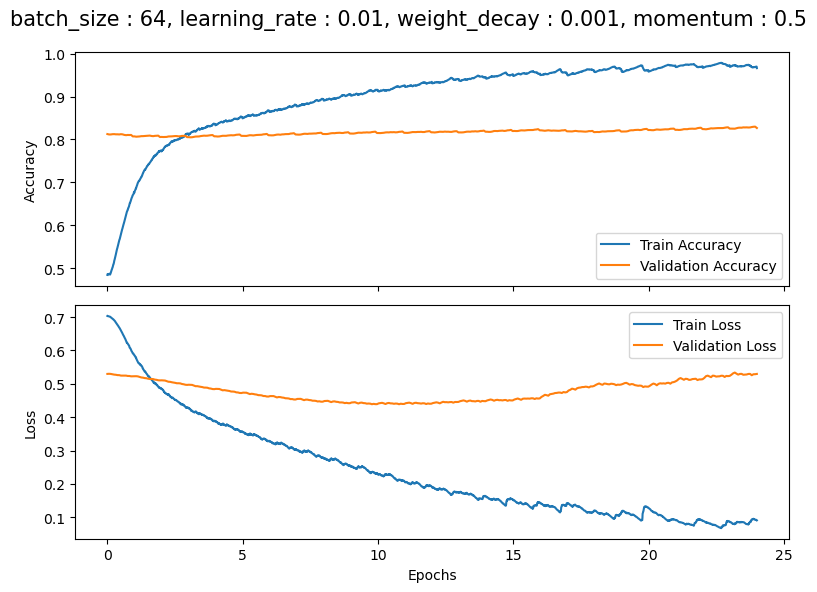

Train accuracy:  96.4
Validation accuracy:  83.6



Combination 27 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.5



Epoch: 1/96, Train loss:  0.665, Train accuracy:  56.6%: 100%|██████████| 36/36 [00:00<00:00, 93.98it/s] 
Epoch: 1/96, Val loss:  0.626, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 170.19it/s]


Epoch: 2/96, Train loss:  0.593, Train accuracy:  71.6%: 100%|██████████| 36/36 [00:00<00:00, 112.39it/s]
Epoch: 2/96, Val loss:  0.559, Val accuracy:  73.8%: 100%|██████████| 4/4 [00:00<00:00, 185.12it/s]


Epoch: 3/96, Train loss:  0.528, Train accuracy:  75.5%: 100%|██████████| 36/36 [00:00<00:00, 109.69it/s]
Epoch: 3/96, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 182.72it/s]


Epoch: 4/96, Train loss:  0.489, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 113.15it/s]
Epoch: 4/96, Val loss:  0.477, Val accuracy:  77.4%: 100%|██████████| 4/4 [00:00<00:00, 177.41it/s]


Epoch: 5/96, Train loss:  0.468, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 112.72it/s]
Epoch: 5/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s]


Epoch: 6/96, Train loss:  0.452, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 112.25it/s]
Epoch: 6/96, Val loss:  0.451, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 177.39it/s]


Epoch: 7/96, Train loss:  0.436, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 110.32it/s]
Epoch: 7/96, Val loss:  0.442, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 191.91it/s]


Epoch: 8/96, Train loss:  0.420, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 113.48it/s]
Epoch: 8/96, Val loss:  0.436, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch: 9/96, Train loss:  0.405, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 113.49it/s]
Epoch: 9/96, Val loss:  0.431, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 185.44it/s]


Epoch: 10/96, Train loss:  0.392, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 109.60it/s]
Epoch: 10/96, Val loss:  0.426, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 181.11it/s]


Epoch: 11/96, Train loss:  0.379, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 111.42it/s]
Epoch: 11/96, Val loss:  0.422, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 180.67it/s]


Epoch: 12/96, Train loss:  0.366, Train accuracy:  82.8%: 100%|██████████| 36/36 [00:00<00:00, 108.07it/s]
Epoch: 12/96, Val loss:  0.417, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 181.49it/s]


Epoch: 13/96, Train loss:  0.354, Train accuracy:  83.4%: 100%|██████████| 36/36 [00:00<00:00, 112.52it/s]
Epoch: 13/96, Val loss:  0.412, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 190.15it/s]


Epoch: 14/96, Train loss:  0.342, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 110.43it/s]
Epoch: 14/96, Val loss:  0.407, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 140.05it/s]


Epoch: 15/96, Train loss:  0.329, Train accuracy:  84.7%: 100%|██████████| 36/36 [00:00<00:00, 111.20it/s]
Epoch: 15/96, Val loss:  0.403, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 181.54it/s]


Epoch: 16/96, Train loss:  0.317, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 112.38it/s]
Epoch: 16/96, Val loss:  0.399, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 17/96, Train loss:  0.305, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 105.05it/s]
Epoch: 17/96, Val loss:  0.395, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 18/96, Train loss:  0.293, Train accuracy:  86.4%: 100%|██████████| 36/36 [00:00<00:00, 109.88it/s]
Epoch: 18/96, Val loss:  0.392, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 162.76it/s]


Epoch: 19/96, Train loss:  0.281, Train accuracy:  87.0%: 100%|██████████| 36/36 [00:00<00:00, 109.71it/s]
Epoch: 19/96, Val loss:  0.390, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 176.31it/s]


Epoch: 20/96, Train loss:  0.269, Train accuracy:  87.7%: 100%|██████████| 36/36 [00:00<00:00, 105.18it/s]
Epoch: 20/96, Val loss:  0.389, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 165.84it/s]


Epoch: 21/96, Train loss:  0.257, Train accuracy:  88.4%: 100%|██████████| 36/36 [00:00<00:00, 107.98it/s]
Epoch: 21/96, Val loss:  0.389, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 159.56it/s]


Epoch: 22/96, Train loss:  0.245, Train accuracy:  88.9%: 100%|██████████| 36/36 [00:00<00:00, 110.89it/s]
Epoch: 22/96, Val loss:  0.391, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 23/96, Train loss:  0.234, Train accuracy:  89.5%: 100%|██████████| 36/36 [00:00<00:00, 107.97it/s]
Epoch: 23/96, Val loss:  0.395, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 182.03it/s]


Epoch: 24/96, Train loss:  0.223, Train accuracy:  89.9%: 100%|██████████| 36/36 [00:00<00:00, 106.75it/s]
Epoch: 24/96, Val loss:  0.397, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 182.37it/s]


Epoch: 25/96, Train loss:  0.214, Train accuracy:  90.1%: 100%|██████████| 36/36 [00:00<00:00, 109.93it/s]
Epoch: 25/96, Val loss:  0.401, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 171.21it/s]


Epoch: 26/96, Train loss:  0.206, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 109.37it/s]
Epoch: 26/96, Val loss:  0.410, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 176.73it/s]


Epoch: 27/96, Train loss:  0.199, Train accuracy:  90.7%: 100%|██████████| 36/36 [00:00<00:00, 86.75it/s]
Epoch: 27/96, Val loss:  0.447, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 183.58it/s]


Epoch: 28/96, Train loss:  0.202, Train accuracy:  90.6%: 100%|██████████| 36/36 [00:00<00:00, 107.90it/s]
Epoch: 28/96, Val loss:  0.482, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 177.08it/s]


Epoch: 29/96, Train loss:  0.201, Train accuracy:  90.7%: 100%|██████████| 36/36 [00:00<00:00, 107.64it/s]
Epoch: 29/96, Val loss:  0.487, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 162.47it/s]


Epoch: 30/96, Train loss:  0.243, Train accuracy:  89.1%: 100%|██████████| 36/36 [00:00<00:00, 108.37it/s]
Epoch: 30/96, Val loss:  0.498, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 173.15it/s]


Epoch: 31/96, Train loss:  0.196, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 106.31it/s]
Epoch: 31/96, Val loss:  0.442, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 181.25it/s]


Epoch: 32/96, Train loss:  0.188, Train accuracy:  91.5%: 100%|██████████| 36/36 [00:00<00:00, 106.77it/s]
Epoch: 32/96, Val loss:  0.412, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 154.99it/s]


Epoch: 33/96, Train loss:  0.193, Train accuracy:  91.3%: 100%|██████████| 36/36 [00:00<00:00, 108.21it/s]
Epoch: 33/96, Val loss:  0.418, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 173.18it/s]


Epoch: 34/96, Train loss:  0.176, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 110.57it/s]
Epoch: 34/96, Val loss:  0.473, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


Epoch: 35/96, Train loss:  0.170, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 107.88it/s]
Epoch: 35/96, Val loss:  0.458, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 36/96, Train loss:  0.157, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 105.79it/s]
Epoch: 36/96, Val loss:  0.416, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 156.57it/s]


Epoch: 37/96, Train loss:  0.143, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 110.91it/s]
Epoch: 37/96, Val loss:  0.452, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 169.58it/s]


Epoch: 38/96, Train loss:  0.133, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 105.76it/s]
Epoch: 38/96, Val loss:  0.477, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 166.35it/s]


Epoch: 39/96, Train loss:  0.127, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 105.38it/s]
Epoch: 39/96, Val loss:  0.482, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 173.34it/s]


Epoch: 40/96, Train loss:  0.140, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 109.44it/s]
Epoch: 40/96, Val loss:  0.823, Val accuracy:  74.5%: 100%|██████████| 4/4 [00:00<00:00, 166.11it/s]


Epoch: 41/96, Train loss:  0.154, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 109.71it/s]
Epoch: 41/96, Val loss:  0.523, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 185.38it/s]


Epoch: 42/96, Train loss:  0.126, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 105.83it/s]
Epoch: 42/96, Val loss:  0.526, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 173.25it/s]


Epoch: 43/96, Train loss:  0.189, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 107.40it/s]
Epoch: 43/96, Val loss:  0.878, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 176.72it/s]


Epoch: 44/96, Train loss:  0.164, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 108.69it/s]
Epoch: 44/96, Val loss:  0.481, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 169.72it/s]


Epoch: 45/96, Train loss:  0.115, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 108.22it/s]
Epoch: 45/96, Val loss:  0.483, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 177.02it/s]


Epoch: 46/96, Train loss:  0.104, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 106.91it/s]
Epoch: 46/96, Val loss:  0.500, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 179.60it/s]


Epoch: 47/96, Train loss:  0.093, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 108.05it/s]
Epoch: 47/96, Val loss:  0.483, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 168.10it/s]


Epoch: 48/96, Train loss:  0.087, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 108.62it/s]
Epoch: 48/96, Val loss:  0.702, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 169.49it/s]


Epoch: 49/96, Train loss:  0.157, Train accuracy:  92.7%: 100%|██████████| 36/36 [00:00<00:00, 108.44it/s]
Epoch: 49/96, Val loss:  0.467, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 169.52it/s]


Epoch: 50/96, Train loss:  0.085, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 106.16it/s]
Epoch: 50/96, Val loss:  0.491, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 177.54it/s]


Epoch: 51/96, Train loss:  0.077, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 110.97it/s]
Epoch: 51/96, Val loss:  0.540, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch: 52/96, Train loss:  0.073, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 105.53it/s]
Epoch: 52/96, Val loss:  0.935, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 177.56it/s]


Epoch: 53/96, Train loss:  0.132, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 87.93it/s] 
Epoch: 53/96, Val loss:  0.820, Val accuracy:  76.0%: 100%|██████████| 4/4 [00:00<00:00, 173.76it/s]


Epoch: 54/96, Train loss:  0.088, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 108.18it/s]
Epoch: 54/96, Val loss:  0.675, Val accuracy:  78.8%: 100%|██████████| 4/4 [00:00<00:00, 177.59it/s]


Epoch: 55/96, Train loss:  0.061, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 110.12it/s]
Epoch: 55/96, Val loss:  0.489, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 162.95it/s]


Epoch: 56/96, Train loss:  0.063, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 107.06it/s]
Epoch: 56/96, Val loss:  0.491, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 172.02it/s]


Epoch: 57/96, Train loss:  0.078, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 108.18it/s]
Epoch: 57/96, Val loss:  0.493, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 173.44it/s]


Epoch: 58/96, Train loss:  0.063, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 107.47it/s]
Epoch: 58/96, Val loss:  0.487, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 165.85it/s]


Epoch: 59/96, Train loss:  0.090, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 109.05it/s]
Epoch: 59/96, Val loss:  0.504, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 176.89it/s]


Epoch: 60/96, Train loss:  0.052, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 107.39it/s]
Epoch: 60/96, Val loss:  0.502, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 173.10it/s]


Epoch: 61/96, Train loss:  0.044, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 106.69it/s]
Epoch: 61/96, Val loss:  0.516, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 172.12it/s]


Epoch: 62/96, Train loss:  0.039, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 104.94it/s]
Epoch: 62/96, Val loss:  0.567, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 170.72it/s]


Epoch: 63/96, Train loss:  0.039, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 110.22it/s]
Epoch: 63/96, Val loss:  0.764, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 181.53it/s]


Epoch: 64/96, Train loss:  0.246, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 105.07it/s]
Epoch: 64/96, Val loss:  0.587, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.66it/s]


Epoch: 65/96, Train loss:  0.048, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 105.67it/s]
Epoch: 65/96, Val loss:  0.567, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 180.60it/s]


Epoch: 66/96, Train loss:  0.036, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 110.04it/s]
Epoch: 66/96, Val loss:  0.504, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 167.39it/s]


Epoch: 67/96, Train loss:  0.033, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 107.24it/s]
Epoch: 67/96, Val loss:  0.523, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 185.56it/s]


Epoch: 68/96, Train loss:  0.043, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 108.16it/s]
Epoch: 68/96, Val loss:  0.553, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 177.33it/s]


Epoch: 69/96, Train loss:  0.029, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 108.33it/s]
Epoch: 69/96, Val loss:  0.538, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 159.63it/s]


Epoch: 70/96, Train loss:  0.028, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 110.22it/s]
Epoch: 70/96, Val loss:  0.709, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 181.46it/s]


Epoch: 71/96, Train loss:  0.025, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 109.56it/s]
Epoch: 71/96, Val loss:  0.620, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.62it/s]


Epoch: 72/96, Train loss:  0.024, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 107.68it/s]
Epoch: 72/96, Val loss:  0.666, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 177.24it/s]


Epoch: 73/96, Train loss:  0.026, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 105.41it/s]
Epoch: 73/96, Val loss:  0.671, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 167.60it/s]


Epoch: 74/96, Train loss:  0.044, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 109.57it/s]
Epoch: 74/96, Val loss:  0.615, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 176.95it/s]


Epoch: 75/96, Train loss:  0.023, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 107.44it/s]
Epoch: 75/96, Val loss:  0.608, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.64it/s]


Epoch: 76/96, Train loss:  0.021, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 107.13it/s]
Epoch: 76/96, Val loss:  0.601, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 162.81it/s]


Epoch: 77/96, Train loss:  0.020, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 110.58it/s]
Epoch: 77/96, Val loss:  0.604, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.58it/s]


Epoch: 78/96, Train loss:  0.018, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.07it/s]
Epoch: 78/96, Val loss:  0.599, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 137.65it/s]


Epoch: 79/96, Train loss:  0.017, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 88.72it/s] 
Epoch: 79/96, Val loss:  0.601, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 180.55it/s]


Epoch: 80/96, Train loss:  0.215, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 108.05it/s]
Epoch: 80/96, Val loss:  0.520, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 166.45it/s]


Epoch: 81/96, Train loss:  0.024, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.83it/s]
Epoch: 81/96, Val loss:  0.527, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 164.56it/s]


Epoch: 82/96, Train loss:  0.020, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.71it/s]
Epoch: 82/96, Val loss:  0.547, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 190.23it/s]


Epoch: 83/96, Train loss:  0.018, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 105.96it/s]
Epoch: 83/96, Val loss:  0.563, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 168.60it/s]


Epoch: 84/96, Train loss:  0.017, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 109.58it/s]
Epoch: 84/96, Val loss:  0.577, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 163.99it/s]


Epoch: 85/96, Train loss:  0.016, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.15it/s]
Epoch: 85/96, Val loss:  0.588, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 177.22it/s]


Epoch: 86/96, Train loss:  0.015, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 108.88it/s]
Epoch: 86/96, Val loss:  0.596, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 87/96, Train loss:  0.017, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 104.95it/s]
Epoch: 87/96, Val loss:  0.600, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 88/96, Train loss:  0.016, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 111.78it/s]
Epoch: 88/96, Val loss:  0.600, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 89/96, Train loss:  0.014, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 106.68it/s]
Epoch: 89/96, Val loss:  0.610, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 90/96, Train loss:  0.014, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 105.22it/s]
Epoch: 90/96, Val loss:  0.617, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 183.28it/s]


Epoch: 91/96, Train loss:  0.013, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 109.48it/s]
Epoch: 91/96, Val loss:  0.626, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 161.73it/s]


Epoch: 92/96, Train loss:  0.012, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 109.81it/s]
Epoch: 92/96, Val loss:  0.638, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 185.76it/s]


Epoch: 93/96, Train loss:  0.012, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 105.63it/s]
Epoch: 93/96, Val loss:  0.646, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 94/96, Train loss:  0.011, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 106.15it/s]
Epoch: 94/96, Val loss:  0.654, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 185.23it/s]


Epoch: 95/96, Train loss:  0.010, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 112.95it/s]
Epoch: 95/96, Val loss:  0.660, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 173.33it/s]


Epoch: 96/96, Train loss:  0.009, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 108.16it/s]
Epoch: 96/96, Val loss:  0.666, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 189.78it/s]


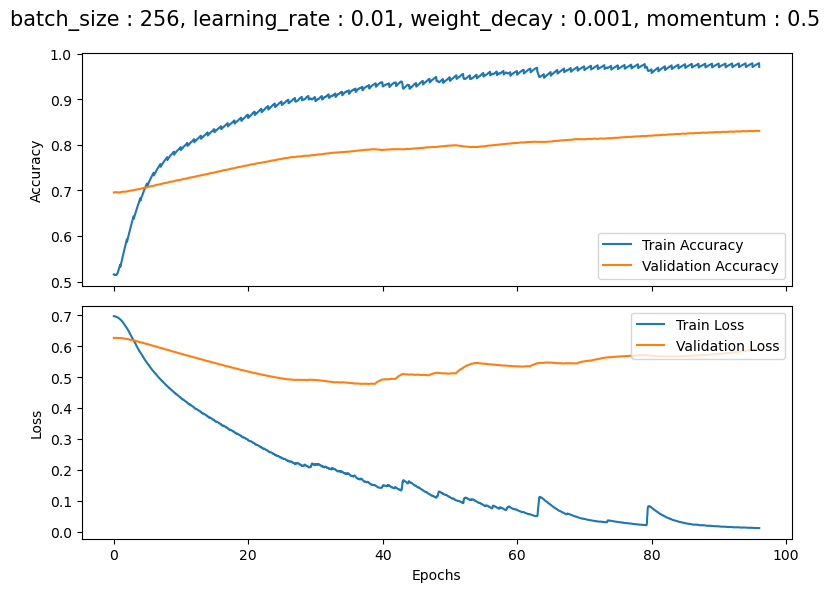

Train accuracy:  97.5
Validation accuracy:  84.0



Combination 28 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.5



Epoch: 1/6, Train loss:  0.639, Train accuracy:  64.6%: 100%|██████████| 563/563 [00:05<00:00, 103.64it/s]
Epoch: 1/6, Val loss:  0.584, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 421.76it/s]


Epoch: 2/6, Train loss:  0.532, Train accuracy:  76.9%: 100%|██████████| 563/563 [00:09<00:00, 59.25it/s]
Epoch: 2/6, Val loss:  0.497, Val accuracy:  77.8%: 100%|██████████| 63/63 [00:00<00:00, 334.78it/s]


Epoch: 3/6, Train loss:  0.478, Train accuracy:  79.7%: 100%|██████████| 563/563 [00:08<00:00, 63.76it/s]
Epoch: 3/6, Val loss:  0.466, Val accuracy:  79.9%: 100%|██████████| 63/63 [00:00<00:00, 309.31it/s]


Epoch: 4/6, Train loss:  0.452, Train accuracy:  80.6%: 100%|██████████| 563/563 [00:08<00:00, 63.92it/s]
Epoch: 4/6, Val loss:  0.450, Val accuracy:  81.4%: 100%|██████████| 63/63 [00:00<00:00, 343.47it/s]


Epoch: 5/6, Train loss:  0.429, Train accuracy:  81.9%: 100%|██████████| 563/563 [00:09<00:00, 59.61it/s]
Epoch: 5/6, Val loss:  0.438, Val accuracy:  81.3%: 100%|██████████| 63/63 [00:00<00:00, 278.68it/s]


Epoch: 6/6, Train loss:  0.408, Train accuracy:  83.0%: 100%|██████████| 563/563 [00:09<00:00, 59.91it/s]
Epoch: 6/6, Val loss:  0.428, Val accuracy:  81.5%: 100%|██████████| 63/63 [00:00<00:00, 293.86it/s]


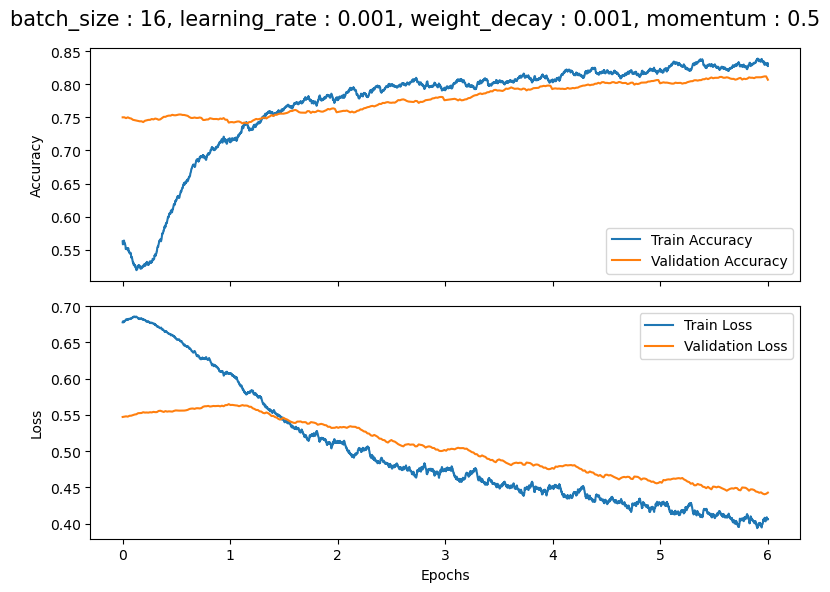

Train accuracy:  83.8
Validation accuracy:  81.5



Combination 29 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.5



Epoch: 1/24, Train loss:  0.684, Train accuracy:  50.2%: 100%|██████████| 141/141 [00:00<00:00, 165.38it/s]
Epoch: 1/24, Val loss:  0.665, Val accuracy:  55.9%: 100%|██████████| 16/16 [00:00<00:00, 419.89it/s]


Epoch: 2/24, Train loss:  0.654, Train accuracy:  62.9%: 100%|██████████| 141/141 [00:01<00:00, 128.56it/s]
Epoch: 2/24, Val loss:  0.638, Val accuracy:  67.3%: 100%|██████████| 16/16 [00:00<00:00, 419.68it/s]


Epoch: 3/24, Train loss:  0.624, Train accuracy:  70.7%: 100%|██████████| 141/141 [00:01<00:00, 126.68it/s]
Epoch: 3/24, Val loss:  0.611, Val accuracy:  70.5%: 100%|██████████| 16/16 [00:00<00:00, 389.82it/s]


Epoch: 4/24, Train loss:  0.594, Train accuracy:  73.0%: 100%|██████████| 141/141 [00:01<00:00, 129.09it/s]
Epoch: 4/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 408.25it/s]


Epoch: 5/24, Train loss:  0.565, Train accuracy:  75.1%: 100%|██████████| 141/141 [00:01<00:00, 124.05it/s]
Epoch: 5/24, Val loss:  0.558, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 420.33it/s]


Epoch: 6/24, Train loss:  0.539, Train accuracy:  76.5%: 100%|██████████| 141/141 [00:01<00:00, 129.20it/s]
Epoch: 6/24, Val loss:  0.533, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 409.30it/s]


Epoch: 7/24, Train loss:  0.517, Train accuracy:  77.7%: 100%|██████████| 141/141 [00:01<00:00, 131.24it/s]
Epoch: 7/24, Val loss:  0.513, Val accuracy:  76.2%: 100%|██████████| 16/16 [00:00<00:00, 399.56it/s]


Epoch: 8/24, Train loss:  0.500, Train accuracy:  78.3%: 100%|██████████| 141/141 [00:01<00:00, 131.89it/s]
Epoch: 8/24, Val loss:  0.498, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 402.24it/s]


Epoch: 9/24, Train loss:  0.488, Train accuracy:  79.1%: 100%|██████████| 141/141 [00:01<00:00, 127.33it/s]
Epoch: 9/24, Val loss:  0.487, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 383.58it/s]


Epoch: 10/24, Train loss:  0.478, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:01<00:00, 134.23it/s]
Epoch: 10/24, Val loss:  0.479, Val accuracy:  77.6%: 100%|██████████| 16/16 [00:00<00:00, 374.70it/s]


Epoch: 11/24, Train loss:  0.470, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:01<00:00, 134.19it/s]
Epoch: 11/24, Val loss:  0.472, Val accuracy:  78.1%: 100%|██████████| 16/16 [00:00<00:00, 420.81it/s]


Epoch: 12/24, Train loss:  0.463, Train accuracy:  80.3%: 100%|██████████| 141/141 [00:01<00:00, 139.92it/s]
Epoch: 12/24, Val loss:  0.467, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 425.69it/s]


Epoch: 13/24, Train loss:  0.457, Train accuracy:  80.6%: 100%|██████████| 141/141 [00:01<00:00, 138.28it/s]
Epoch: 13/24, Val loss:  0.462, Val accuracy:  78.9%: 100%|██████████| 16/16 [00:00<00:00, 357.48it/s]


Epoch: 14/24, Train loss:  0.450, Train accuracy:  81.0%: 100%|██████████| 141/141 [00:01<00:00, 135.18it/s]
Epoch: 14/24, Val loss:  0.457, Val accuracy:  79.4%: 100%|██████████| 16/16 [00:00<00:00, 415.38it/s]


Epoch: 15/24, Train loss:  0.444, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:01<00:00, 136.44it/s]
Epoch: 15/24, Val loss:  0.453, Val accuracy:  79.6%: 100%|██████████| 16/16 [00:00<00:00, 419.65it/s]


Epoch: 16/24, Train loss:  0.438, Train accuracy:  81.5%: 100%|██████████| 141/141 [00:01<00:00, 138.79it/s]
Epoch: 16/24, Val loss:  0.450, Val accuracy:  79.4%: 100%|██████████| 16/16 [00:00<00:00, 388.54it/s]


Epoch: 17/24, Train loss:  0.431, Train accuracy:  81.8%: 100%|██████████| 141/141 [00:01<00:00, 137.97it/s]
Epoch: 17/24, Val loss:  0.446, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 396.77it/s]


Epoch: 18/24, Train loss:  0.425, Train accuracy:  82.0%: 100%|██████████| 141/141 [00:01<00:00, 139.97it/s]
Epoch: 18/24, Val loss:  0.443, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 416.30it/s]


Epoch: 19/24, Train loss:  0.419, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:01<00:00, 121.21it/s]
Epoch: 19/24, Val loss:  0.440, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 287.84it/s]


Epoch: 20/24, Train loss:  0.413, Train accuracy:  82.6%: 100%|██████████| 141/141 [00:01<00:00, 93.64it/s]
Epoch: 20/24, Val loss:  0.437, Val accuracy:  80.5%: 100%|██████████| 16/16 [00:00<00:00, 230.33it/s]


Epoch: 21/24, Train loss:  0.407, Train accuracy:  82.9%: 100%|██████████| 141/141 [00:01<00:00, 86.20it/s]
Epoch: 21/24, Val loss:  0.435, Val accuracy:  80.4%: 100%|██████████| 16/16 [00:00<00:00, 379.69it/s]


Epoch: 22/24, Train loss:  0.401, Train accuracy:  83.1%: 100%|██████████| 141/141 [00:01<00:00, 120.17it/s]
Epoch: 22/24, Val loss:  0.432, Val accuracy:  80.6%: 100%|██████████| 16/16 [00:00<00:00, 384.95it/s]


Epoch: 23/24, Train loss:  0.395, Train accuracy:  83.4%: 100%|██████████| 141/141 [00:01<00:00, 104.60it/s]
Epoch: 23/24, Val loss:  0.430, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 297.62it/s]


Epoch: 24/24, Train loss:  0.390, Train accuracy:  83.5%: 100%|██████████| 141/141 [00:01<00:00, 112.77it/s]
Epoch: 24/24, Val loss:  0.428, Val accuracy:  80.3%: 100%|██████████| 16/16 [00:00<00:00, 393.88it/s]


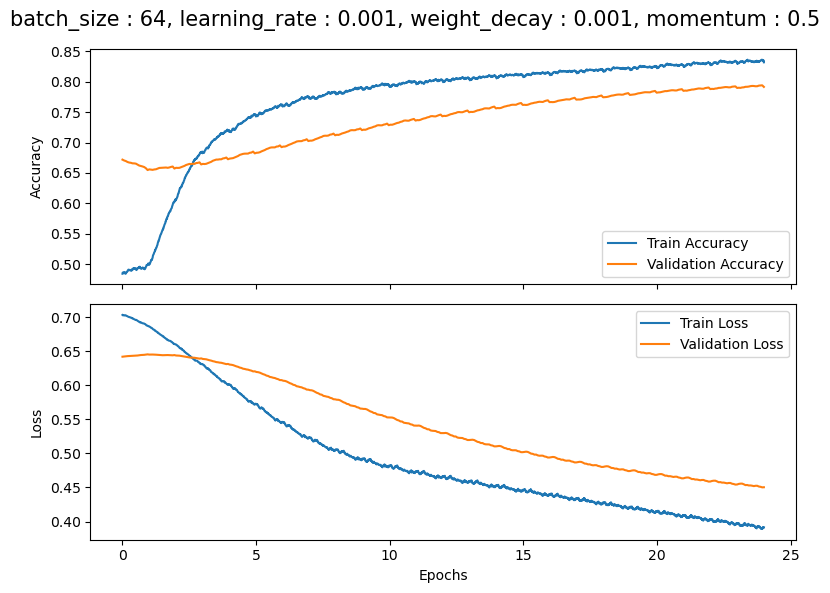

Train accuracy:  84.0
Validation accuracy:  80.3



Combination 30 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.5



Epoch: 1/96, Train loss:  0.696, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 108.33it/s]
Epoch: 1/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 130.87it/s]


Epoch: 2/96, Train loss:  0.687, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 104.72it/s]
Epoch: 2/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 184.89it/s]


Epoch: 3/96, Train loss:  0.680, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 104.63it/s]
Epoch: 3/96, Val loss:  0.671, Val accuracy:  50.8%: 100%|██████████| 4/4 [00:00<00:00, 159.61it/s]


Epoch: 4/96, Train loss:  0.673, Train accuracy:  50.9%: 100%|██████████| 36/36 [00:00<00:00, 108.00it/s]
Epoch: 4/96, Val loss:  0.664, Val accuracy:  56.0%: 100%|██████████| 4/4 [00:00<00:00, 181.08it/s]


Epoch: 5/96, Train loss:  0.665, Train accuracy:  56.8%: 100%|██████████| 36/36 [00:00<00:00, 83.88it/s] 
Epoch: 5/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 165.98it/s]


Epoch: 6/96, Train loss:  0.657, Train accuracy:  61.2%: 100%|██████████| 36/36 [00:00<00:00, 106.55it/s]
Epoch: 6/96, Val loss:  0.650, Val accuracy:  63.0%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 7/96, Train loss:  0.650, Train accuracy:  64.1%: 100%|██████████| 36/36 [00:00<00:00, 107.28it/s]
Epoch: 7/96, Val loss:  0.643, Val accuracy:  66.2%: 100%|██████████| 4/4 [00:00<00:00, 165.62it/s]


Epoch: 8/96, Train loss:  0.642, Train accuracy:  66.2%: 100%|██████████| 36/36 [00:00<00:00, 103.23it/s]
Epoch: 8/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 114.03it/s]


Epoch: 9/96, Train loss:  0.635, Train accuracy:  67.6%: 100%|██████████| 36/36 [00:00<00:00, 100.65it/s]
Epoch: 9/96, Val loss:  0.629, Val accuracy:  68.7%: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s]


Epoch: 10/96, Train loss:  0.627, Train accuracy:  68.9%: 100%|██████████| 36/36 [00:00<00:00, 106.39it/s]
Epoch: 10/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 188.76it/s]


Epoch: 11/96, Train loss:  0.619, Train accuracy:  69.9%: 100%|██████████| 36/36 [00:00<00:00, 107.35it/s]
Epoch: 11/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 169.31it/s]


Epoch: 12/96, Train loss:  0.612, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 106.73it/s]
Epoch: 12/96, Val loss:  0.608, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 189.81it/s]


Epoch: 13/96, Train loss:  0.604, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 111.33it/s]
Epoch: 13/96, Val loss:  0.602, Val accuracy:  70.6%: 100%|██████████| 4/4 [00:00<00:00, 181.03it/s]


Epoch: 14/96, Train loss:  0.597, Train accuracy:  71.3%: 100%|██████████| 36/36 [00:00<00:00, 107.80it/s]
Epoch: 14/96, Val loss:  0.595, Val accuracy:  71.1%: 100%|██████████| 4/4 [00:00<00:00, 176.86it/s]


Epoch: 15/96, Train loss:  0.589, Train accuracy:  71.9%: 100%|██████████| 36/36 [00:00<00:00, 109.03it/s]
Epoch: 15/96, Val loss:  0.588, Val accuracy:  71.7%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 16/96, Train loss:  0.582, Train accuracy:  72.5%: 100%|██████████| 36/36 [00:00<00:00, 110.11it/s]
Epoch: 16/96, Val loss:  0.581, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 181.57it/s]


Epoch: 17/96, Train loss:  0.575, Train accuracy:  73.0%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 17/96, Val loss:  0.574, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 169.73it/s]


Epoch: 18/96, Train loss:  0.568, Train accuracy:  73.5%: 100%|██████████| 36/36 [00:00<00:00, 108.60it/s]
Epoch: 18/96, Val loss:  0.567, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 188.12it/s]


Epoch: 19/96, Train loss:  0.561, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 111.51it/s]
Epoch: 19/96, Val loss:  0.561, Val accuracy:  73.4%: 100%|██████████| 4/4 [00:00<00:00, 181.63it/s]


Epoch: 20/96, Train loss:  0.554, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 105.48it/s]
Epoch: 20/96, Val loss:  0.554, Val accuracy:  74.1%: 100%|██████████| 4/4 [00:00<00:00, 173.31it/s]


Epoch: 21/96, Train loss:  0.547, Train accuracy:  74.6%: 100%|██████████| 36/36 [00:00<00:00, 110.13it/s]
Epoch: 21/96, Val loss:  0.547, Val accuracy:  74.2%: 100%|██████████| 4/4 [00:00<00:00, 159.85it/s]


Epoch: 22/96, Train loss:  0.541, Train accuracy:  75.0%: 100%|██████████| 36/36 [00:00<00:00, 104.83it/s]
Epoch: 22/96, Val loss:  0.541, Val accuracy:  74.8%: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s]


Epoch: 23/96, Train loss:  0.534, Train accuracy:  75.3%: 100%|██████████| 36/36 [00:00<00:00, 107.77it/s]
Epoch: 23/96, Val loss:  0.535, Val accuracy:  75.2%: 100%|██████████| 4/4 [00:00<00:00, 169.42it/s]


Epoch: 24/96, Train loss:  0.528, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 107.13it/s]
Epoch: 24/96, Val loss:  0.529, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 176.78it/s]


Epoch: 25/96, Train loss:  0.523, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 110.07it/s]
Epoch: 25/96, Val loss:  0.523, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 187.10it/s]


Epoch: 26/96, Train loss:  0.518, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 107.40it/s]
Epoch: 26/96, Val loss:  0.518, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 27/96, Train loss:  0.513, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 109.78it/s]
Epoch: 27/96, Val loss:  0.513, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 157.70it/s]


Epoch: 28/96, Train loss:  0.508, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 108.30it/s]
Epoch: 28/96, Val loss:  0.509, Val accuracy:  76.2%: 100%|██████████| 4/4 [00:00<00:00, 166.19it/s]


Epoch: 29/96, Train loss:  0.504, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 109.04it/s]
Epoch: 29/96, Val loss:  0.504, Val accuracy:  76.4%: 100%|██████████| 4/4 [00:00<00:00, 172.89it/s]


Epoch: 30/96, Train loss:  0.500, Train accuracy:  76.7%: 100%|██████████| 36/36 [00:00<00:00, 108.03it/s]
Epoch: 30/96, Val loss:  0.501, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 173.11it/s]


Epoch: 31/96, Train loss:  0.497, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 91.39it/s] 
Epoch: 31/96, Val loss:  0.497, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s]


Epoch: 32/96, Train loss:  0.493, Train accuracy:  77.1%: 100%|██████████| 36/36 [00:00<00:00, 107.37it/s]
Epoch: 32/96, Val loss:  0.494, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 181.25it/s]


Epoch: 33/96, Train loss:  0.490, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 112.37it/s]
Epoch: 33/96, Val loss:  0.491, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 190.31it/s]


Epoch: 34/96, Train loss:  0.487, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 104.91it/s]
Epoch: 34/96, Val loss:  0.488, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 172.49it/s]


Epoch: 35/96, Train loss:  0.485, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 108.59it/s]
Epoch: 35/96, Val loss:  0.485, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 159.51it/s]


Epoch: 36/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 107.26it/s]
Epoch: 36/96, Val loss:  0.483, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 169.67it/s]


Epoch: 37/96, Train loss:  0.480, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 107.02it/s]
Epoch: 37/96, Val loss:  0.481, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s]


Epoch: 38/96, Train loss:  0.478, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 104.55it/s]
Epoch: 38/96, Val loss:  0.479, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 181.52it/s]


Epoch: 39/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 109.48it/s]
Epoch: 39/96, Val loss:  0.477, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 153.16it/s]


Epoch: 40/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 104.07it/s]
Epoch: 40/96, Val loss:  0.475, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 41/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 106.86it/s]
Epoch: 41/96, Val loss:  0.473, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 42/96, Train loss:  0.469, Train accuracy:  78.4%: 100%|██████████| 36/36 [00:00<00:00, 104.77it/s]
Epoch: 42/96, Val loss:  0.471, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 152.55it/s]


Epoch: 43/96, Train loss:  0.467, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 109.14it/s]
Epoch: 43/96, Val loss:  0.470, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 169.57it/s]


Epoch: 44/96, Train loss:  0.465, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 105.25it/s]
Epoch: 44/96, Val loss:  0.468, Val accuracy:  78.2%: 100%|██████████| 4/4 [00:00<00:00, 173.49it/s]


Epoch: 45/96, Train loss:  0.464, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 104.75it/s]
Epoch: 45/96, Val loss:  0.467, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 171.53it/s]


Epoch: 46/96, Train loss:  0.462, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 106.26it/s]
Epoch: 46/96, Val loss:  0.465, Val accuracy:  78.2%: 100%|██████████| 4/4 [00:00<00:00, 169.10it/s]


Epoch: 47/96, Train loss:  0.460, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 105.88it/s]
Epoch: 47/96, Val loss:  0.464, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 179.51it/s]


Epoch: 48/96, Train loss:  0.458, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 106.15it/s]
Epoch: 48/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 181.38it/s]


Epoch: 49/96, Train loss:  0.456, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 104.85it/s]
Epoch: 49/96, Val loss:  0.461, Val accuracy:  79.0%: 100%|██████████| 4/4 [00:00<00:00, 173.80it/s]


Epoch: 50/96, Train loss:  0.455, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 107.98it/s]
Epoch: 50/96, Val loss:  0.460, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 164.02it/s]


Epoch: 51/96, Train loss:  0.453, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 105.34it/s]
Epoch: 51/96, Val loss:  0.459, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 172.50it/s]


Epoch: 52/96, Train loss:  0.451, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 106.26it/s]
Epoch: 52/96, Val loss:  0.458, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 173.71it/s]


Epoch: 53/96, Train loss:  0.449, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 104.01it/s]
Epoch: 53/96, Val loss:  0.456, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 162.30it/s]


Epoch: 54/96, Train loss:  0.448, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 108.94it/s]
Epoch: 54/96, Val loss:  0.455, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 159.70it/s]


Epoch: 55/96, Train loss:  0.446, Train accuracy:  79.4%: 100%|██████████| 36/36 [00:00<00:00, 105.73it/s]
Epoch: 55/96, Val loss:  0.454, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 171.27it/s]


Epoch: 56/96, Train loss:  0.444, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 106.58it/s]
Epoch: 56/96, Val loss:  0.453, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 177.20it/s]


Epoch: 57/96, Train loss:  0.443, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 104.75it/s]
Epoch: 57/96, Val loss:  0.452, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 42.91it/s]


Epoch: 58/96, Train loss:  0.441, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 107.48it/s]
Epoch: 58/96, Val loss:  0.451, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 162.99it/s]


Epoch: 59/96, Train loss:  0.439, Train accuracy:  79.7%: 100%|██████████| 36/36 [00:00<00:00, 103.88it/s]
Epoch: 59/96, Val loss:  0.450, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 60/96, Train loss:  0.437, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 107.00it/s]
Epoch: 60/96, Val loss:  0.449, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 184.91it/s]


Epoch: 61/96, Train loss:  0.436, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 103.11it/s]
Epoch: 61/96, Val loss:  0.448, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 176.08it/s]


Epoch: 62/96, Train loss:  0.434, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 109.76it/s]
Epoch: 62/96, Val loss:  0.447, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 167.12it/s]


Epoch: 63/96, Train loss:  0.432, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 105.56it/s]
Epoch: 63/96, Val loss:  0.446, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 166.16it/s]


Epoch: 64/96, Train loss:  0.430, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 106.89it/s]
Epoch: 64/96, Val loss:  0.445, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 180.71it/s]


Epoch: 65/96, Train loss:  0.429, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 107.14it/s]
Epoch: 65/96, Val loss:  0.444, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 169.17it/s]


Epoch: 66/96, Train loss:  0.427, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 107.69it/s]
Epoch: 66/96, Val loss:  0.443, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 173.63it/s]


Epoch: 67/96, Train loss:  0.425, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 104.44it/s]
Epoch: 67/96, Val loss:  0.442, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 173.55it/s]


Epoch: 68/96, Train loss:  0.423, Train accuracy:  80.4%: 100%|██████████| 36/36 [00:00<00:00, 105.07it/s]
Epoch: 68/96, Val loss:  0.442, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 169.26it/s]


Epoch: 69/96, Train loss:  0.422, Train accuracy:  80.4%: 100%|██████████| 36/36 [00:00<00:00, 106.21it/s]
Epoch: 69/96, Val loss:  0.441, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 165.30it/s]


Epoch: 70/96, Train loss:  0.420, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 107.07it/s]
Epoch: 70/96, Val loss:  0.440, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 175.32it/s]


Epoch: 71/96, Train loss:  0.418, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 103.98it/s]
Epoch: 71/96, Val loss:  0.439, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 169.62it/s]


Epoch: 72/96, Train loss:  0.416, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 107.03it/s]
Epoch: 72/96, Val loss:  0.438, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 166.25it/s]


Epoch: 73/96, Train loss:  0.415, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 107.15it/s]
Epoch: 73/96, Val loss:  0.438, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 169.24it/s]


Epoch: 74/96, Train loss:  0.413, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 110.98it/s]
Epoch: 74/96, Val loss:  0.437, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 168.18it/s]


Epoch: 75/96, Train loss:  0.411, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 106.97it/s]
Epoch: 75/96, Val loss:  0.436, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]


Epoch: 76/96, Train loss:  0.410, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 109.10it/s]
Epoch: 76/96, Val loss:  0.436, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 172.99it/s]


Epoch: 77/96, Train loss:  0.408, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 108.24it/s]
Epoch: 77/96, Val loss:  0.435, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 169.56it/s]


Epoch: 78/96, Train loss:  0.406, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 110.56it/s]
Epoch: 78/96, Val loss:  0.434, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 173.32it/s]


Epoch: 79/96, Train loss:  0.405, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 107.65it/s]
Epoch: 79/96, Val loss:  0.434, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 166.30it/s]


Epoch: 80/96, Train loss:  0.403, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 110.60it/s]
Epoch: 80/96, Val loss:  0.433, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 166.23it/s]


Epoch: 81/96, Train loss:  0.402, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 109.13it/s]
Epoch: 81/96, Val loss:  0.432, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch: 82/96, Train loss:  0.400, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 108.89it/s]
Epoch: 82/96, Val loss:  0.432, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 83/96, Train loss:  0.398, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 105.88it/s]
Epoch: 83/96, Val loss:  0.431, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.48it/s]


Epoch: 84/96, Train loss:  0.397, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 91.43it/s] 
Epoch: 84/96, Val loss:  0.430, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 166.31it/s]


Epoch: 85/96, Train loss:  0.395, Train accuracy:  81.6%: 100%|██████████| 36/36 [00:00<00:00, 108.12it/s]
Epoch: 85/96, Val loss:  0.430, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 181.48it/s]


Epoch: 86/96, Train loss:  0.394, Train accuracy:  81.6%: 100%|██████████| 36/36 [00:00<00:00, 110.15it/s]
Epoch: 86/96, Val loss:  0.429, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 185.43it/s]


Epoch: 87/96, Train loss:  0.392, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 109.16it/s]
Epoch: 87/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 178.14it/s]


Epoch: 88/96, Train loss:  0.391, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 110.10it/s]
Epoch: 88/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 181.43it/s]


Epoch: 89/96, Train loss:  0.389, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 107.34it/s]
Epoch: 89/96, Val loss:  0.427, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 185.14it/s]


Epoch: 90/96, Train loss:  0.387, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 108.29it/s]
Epoch: 90/96, Val loss:  0.427, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 166.12it/s]


Epoch: 91/96, Train loss:  0.386, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 110.56it/s]
Epoch: 91/96, Val loss:  0.426, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.57it/s]


Epoch: 92/96, Train loss:  0.384, Train accuracy:  82.0%: 100%|██████████| 36/36 [00:00<00:00, 108.52it/s]
Epoch: 92/96, Val loss:  0.426, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 181.24it/s]


Epoch: 93/96, Train loss:  0.383, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 107.67it/s]
Epoch: 93/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 94/96, Train loss:  0.381, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 103.27it/s]
Epoch: 94/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s]


Epoch: 95/96, Train loss:  0.380, Train accuracy:  82.3%: 100%|██████████| 36/36 [00:00<00:00, 106.99it/s]
Epoch: 95/96, Val loss:  0.424, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 162.60it/s]


Epoch: 96/96, Train loss:  0.378, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 109.27it/s]
Epoch: 96/96, Val loss:  0.423, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 173.40it/s]


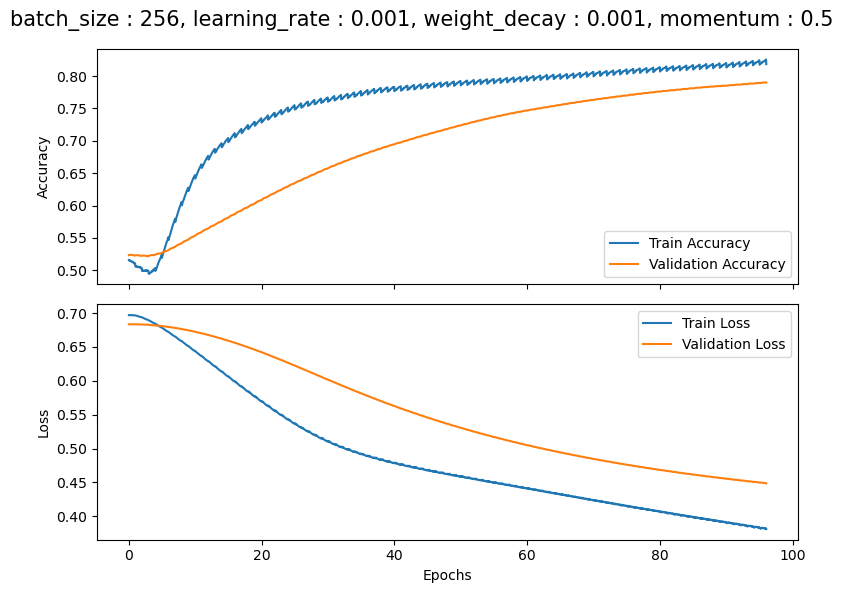

Train accuracy:  82.4
Validation accuracy:  81.0



Combination 31 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/6, Train loss:  0.488, Train accuracy:  77.7%: 100%|██████████| 563/563 [00:05<00:00, 96.90it/s] 
Epoch: 1/6, Val loss:  0.424, Val accuracy:  81.8%: 100%|██████████| 63/63 [00:00<00:00, 450.06it/s]


Epoch: 2/6, Train loss:  0.399, Train accuracy:  83.1%: 100%|██████████| 563/563 [00:09<00:00, 61.85it/s]
Epoch: 2/6, Val loss:  0.406, Val accuracy:  83.0%: 100%|██████████| 63/63 [00:00<00:00, 344.12it/s]


Epoch: 3/6, Train loss:  0.356, Train accuracy:  85.6%: 100%|██████████| 563/563 [00:09<00:00, 62.30it/s]
Epoch: 3/6, Val loss:  0.395, Val accuracy:  83.8%: 100%|██████████| 63/63 [00:00<00:00, 348.11it/s]


Epoch: 4/6, Train loss:  0.319, Train accuracy:  87.4%: 100%|██████████| 563/563 [00:09<00:00, 60.59it/s]
Epoch: 4/6, Val loss:  0.399, Val accuracy:  82.9%: 100%|██████████| 63/63 [00:00<00:00, 342.81it/s]


Epoch: 5/6, Train loss:  0.284, Train accuracy:  89.2%: 100%|██████████| 563/563 [00:08<00:00, 63.61it/s]
Epoch: 5/6, Val loss:  0.406, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 310.49it/s]


Epoch: 6/6, Train loss:  0.249, Train accuracy:  90.9%: 100%|██████████| 563/563 [00:09<00:00, 59.44it/s]
Epoch: 6/6, Val loss:  0.437, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 352.28it/s]


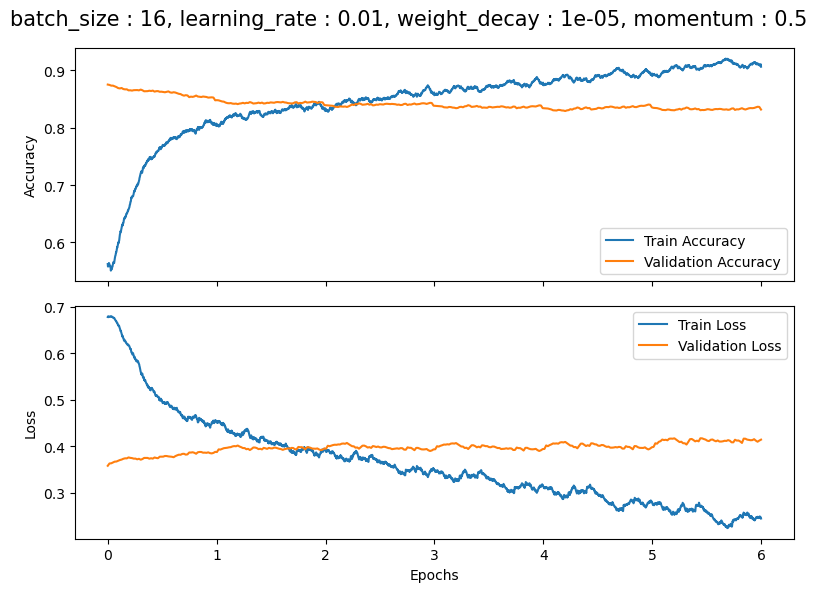

Train accuracy:  90.4
Validation accuracy:  82.6



Combination 32 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/24, Train loss:  0.572, Train accuracy:  71.1%: 100%|██████████| 141/141 [00:00<00:00, 179.78it/s]
Epoch: 1/24, Val loss:  0.482, Val accuracy:  77.6%: 100%|██████████| 16/16 [00:00<00:00, 417.80it/s]


Epoch: 2/24, Train loss:  0.457, Train accuracy:  80.4%: 100%|██████████| 141/141 [00:01<00:00, 130.26it/s]
Epoch: 2/24, Val loss:  0.440, Val accuracy:  80.1%: 100%|██████████| 16/16 [00:00<00:00, 389.75it/s]


Epoch: 3/24, Train loss:  0.412, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:01<00:00, 137.16it/s]
Epoch: 3/24, Val loss:  0.420, Val accuracy:  80.9%: 100%|██████████| 16/16 [00:00<00:00, 390.85it/s]


Epoch: 4/24, Train loss:  0.378, Train accuracy:  84.2%: 100%|██████████| 141/141 [00:01<00:00, 137.83it/s]
Epoch: 4/24, Val loss:  0.411, Val accuracy:  81.4%: 100%|██████████| 16/16 [00:00<00:00, 382.98it/s]


Epoch: 5/24, Train loss:  0.348, Train accuracy:  85.6%: 100%|██████████| 141/141 [00:01<00:00, 131.33it/s]
Epoch: 5/24, Val loss:  0.407, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 399.89it/s]


Epoch: 6/24, Train loss:  0.321, Train accuracy:  86.8%: 100%|██████████| 141/141 [00:01<00:00, 136.12it/s]
Epoch: 6/24, Val loss:  0.402, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 410.07it/s]


Epoch: 7/24, Train loss:  0.295, Train accuracy:  88.3%: 100%|██████████| 141/141 [00:01<00:00, 127.94it/s]
Epoch: 7/24, Val loss:  0.402, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 420.86it/s]


Epoch: 8/24, Train loss:  0.270, Train accuracy:  89.6%: 100%|██████████| 141/141 [00:01<00:00, 132.80it/s]
Epoch: 8/24, Val loss:  0.409, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 423.87it/s]


Epoch: 9/24, Train loss:  0.246, Train accuracy:  90.7%: 100%|██████████| 141/141 [00:01<00:00, 132.91it/s]
Epoch: 9/24, Val loss:  0.414, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 377.67it/s]


Epoch: 10/24, Train loss:  0.225, Train accuracy:  91.6%: 100%|██████████| 141/141 [00:01<00:00, 140.48it/s]
Epoch: 10/24, Val loss:  0.422, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 388.63it/s]


Epoch: 11/24, Train loss:  0.204, Train accuracy:  92.5%: 100%|██████████| 141/141 [00:01<00:00, 140.00it/s]
Epoch: 11/24, Val loss:  0.442, Val accuracy:  82.5%: 100%|██████████| 16/16 [00:00<00:00, 413.73it/s]


Epoch: 12/24, Train loss:  0.181, Train accuracy:  93.5%: 100%|██████████| 141/141 [00:00<00:00, 143.00it/s]
Epoch: 12/24, Val loss:  0.468, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 413.35it/s]


Epoch: 13/24, Train loss:  0.170, Train accuracy:  94.3%: 100%|██████████| 141/141 [00:00<00:00, 143.13it/s]
Epoch: 13/24, Val loss:  0.513, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 424.59it/s]


Epoch: 14/24, Train loss:  0.148, Train accuracy:  94.9%: 100%|██████████| 141/141 [00:00<00:00, 146.53it/s]
Epoch: 14/24, Val loss:  0.643, Val accuracy:  78.8%: 100%|██████████| 16/16 [00:00<00:00, 334.35it/s]


Epoch: 15/24, Train loss:  0.136, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 130.50it/s]
Epoch: 15/24, Val loss:  0.508, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 409.45it/s]


Epoch: 16/24, Train loss:  0.144, Train accuracy:  94.9%: 100%|██████████| 141/141 [00:01<00:00, 119.33it/s]
Epoch: 16/24, Val loss:  0.582, Val accuracy:  80.6%: 100%|██████████| 16/16 [00:00<00:00, 379.32it/s]


Epoch: 17/24, Train loss:  0.123, Train accuracy:  95.8%: 100%|██████████| 141/141 [00:01<00:00, 130.17it/s]
Epoch: 17/24, Val loss:  0.567, Val accuracy:  80.4%: 100%|██████████| 16/16 [00:00<00:00, 402.48it/s]


Epoch: 18/24, Train loss:  0.115, Train accuracy:  96.2%: 100%|██████████| 141/141 [00:01<00:00, 130.33it/s]
Epoch: 18/24, Val loss:  0.495, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 419.88it/s]


Epoch: 19/24, Train loss:  0.120, Train accuracy:  96.3%: 100%|██████████| 141/141 [00:01<00:00, 126.55it/s]
Epoch: 19/24, Val loss:  0.481, Val accuracy:  84.0%: 100%|██████████| 16/16 [00:00<00:00, 393.34it/s]


Epoch: 20/24, Train loss:  0.080, Train accuracy:  97.6%: 100%|██████████| 141/141 [00:01<00:00, 136.97it/s]
Epoch: 20/24, Val loss:  0.548, Val accuracy:  84.2%: 100%|██████████| 16/16 [00:00<00:00, 393.31it/s]


Epoch: 21/24, Train loss:  0.085, Train accuracy:  97.2%: 100%|██████████| 141/141 [00:01<00:00, 126.82it/s]
Epoch: 21/24, Val loss:  0.558, Val accuracy:  84.3%: 100%|██████████| 16/16 [00:00<00:00, 409.90it/s]


Epoch: 22/24, Train loss:  0.089, Train accuracy:  96.9%: 100%|██████████| 141/141 [00:01<00:00, 133.21it/s]
Epoch: 22/24, Val loss:  0.566, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 399.01it/s]


Epoch: 23/24, Train loss:  0.078, Train accuracy:  97.2%: 100%|██████████| 141/141 [00:01<00:00, 137.26it/s]
Epoch: 23/24, Val loss:  0.584, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 431.25it/s]


Epoch: 24/24, Train loss:  0.069, Train accuracy:  97.6%: 100%|██████████| 141/141 [00:01<00:00, 125.37it/s]
Epoch: 24/24, Val loss:  0.626, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 383.97it/s]


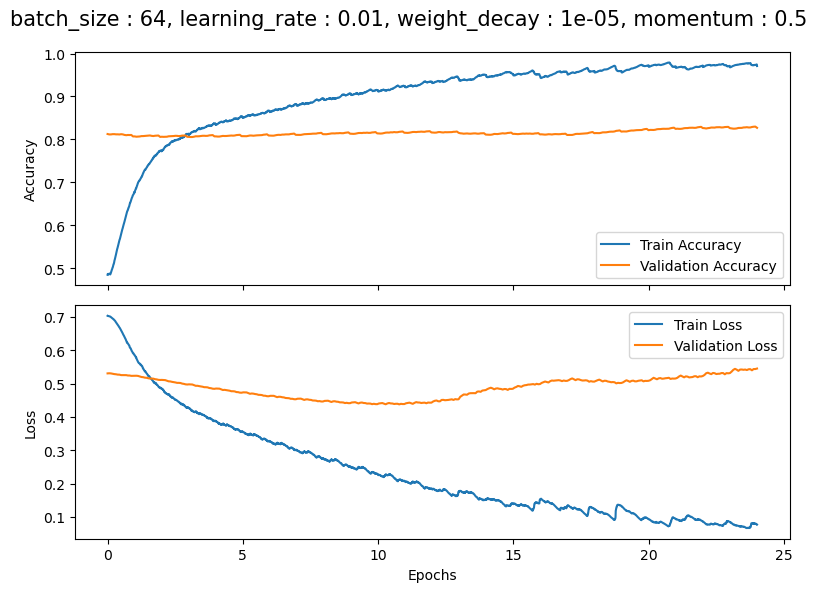

Train accuracy:  95.6
Validation accuracy:  83.2



Combination 33 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/96, Train loss:  0.665, Train accuracy:  56.6%: 100%|██████████| 36/36 [00:00<00:00, 106.24it/s]
Epoch: 1/96, Val loss:  0.626, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 166.53it/s]


Epoch: 2/96, Train loss:  0.592, Train accuracy:  71.6%: 100%|██████████| 36/36 [00:00<00:00, 109.80it/s]
Epoch: 2/96, Val loss:  0.559, Val accuracy:  73.9%: 100%|██████████| 4/4 [00:00<00:00, 179.83it/s]


Epoch: 3/96, Train loss:  0.528, Train accuracy:  75.5%: 100%|██████████| 36/36 [00:00<00:00, 104.60it/s]
Epoch: 3/96, Val loss:  0.504, Val accuracy:  76.6%: 100%|██████████| 4/4 [00:00<00:00, 192.37it/s]


Epoch: 4/96, Train loss:  0.489, Train accuracy:  77.3%: 100%|██████████| 36/36 [00:00<00:00, 105.82it/s]
Epoch: 4/96, Val loss:  0.477, Val accuracy:  77.5%: 100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch: 5/96, Train loss:  0.468, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 106.24it/s]
Epoch: 5/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 166.31it/s]


Epoch: 6/96, Train loss:  0.451, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 109.18it/s]
Epoch: 6/96, Val loss:  0.451, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 181.59it/s]


Epoch: 7/96, Train loss:  0.435, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 105.80it/s]
Epoch: 7/96, Val loss:  0.442, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 173.59it/s]


Epoch: 8/96, Train loss:  0.419, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 88.25it/s] 
Epoch: 8/96, Val loss:  0.435, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 181.55it/s]


Epoch: 9/96, Train loss:  0.405, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 106.55it/s]
Epoch: 9/96, Val loss:  0.430, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 160.67it/s]


Epoch: 10/96, Train loss:  0.391, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 109.26it/s]
Epoch: 10/96, Val loss:  0.426, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 165.77it/s]


Epoch: 11/96, Train loss:  0.378, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 105.44it/s]
Epoch: 11/96, Val loss:  0.421, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 12/96, Train loss:  0.365, Train accuracy:  82.8%: 100%|██████████| 36/36 [00:00<00:00, 107.42it/s]
Epoch: 12/96, Val loss:  0.416, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 173.32it/s]


Epoch: 13/96, Train loss:  0.353, Train accuracy:  83.4%: 100%|██████████| 36/36 [00:00<00:00, 106.32it/s]
Epoch: 13/96, Val loss:  0.411, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 162.77it/s]


Epoch: 14/96, Train loss:  0.340, Train accuracy:  84.1%: 100%|██████████| 36/36 [00:00<00:00, 106.69it/s]
Epoch: 14/96, Val loss:  0.406, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 177.03it/s]


Epoch: 15/96, Train loss:  0.328, Train accuracy:  84.8%: 100%|██████████| 36/36 [00:00<00:00, 105.46it/s]
Epoch: 15/96, Val loss:  0.402, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s]


Epoch: 16/96, Train loss:  0.315, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 107.55it/s]
Epoch: 16/96, Val loss:  0.398, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 159.14it/s]


Epoch: 17/96, Train loss:  0.303, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 107.56it/s]
Epoch: 17/96, Val loss:  0.395, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 165.10it/s]


Epoch: 18/96, Train loss:  0.291, Train accuracy:  86.5%: 100%|██████████| 36/36 [00:00<00:00, 107.58it/s]
Epoch: 18/96, Val loss:  0.392, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 19/96, Train loss:  0.278, Train accuracy:  87.2%: 100%|██████████| 36/36 [00:00<00:00, 106.07it/s]
Epoch: 19/96, Val loss:  0.389, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 154.92it/s]


Epoch: 20/96, Train loss:  0.266, Train accuracy:  87.8%: 100%|██████████| 36/36 [00:00<00:00, 107.29it/s]
Epoch: 20/96, Val loss:  0.388, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 173.27it/s]


Epoch: 21/96, Train loss:  0.254, Train accuracy:  88.5%: 100%|██████████| 36/36 [00:00<00:00, 107.11it/s]
Epoch: 21/96, Val loss:  0.389, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 22/96, Train loss:  0.242, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 108.11it/s]
Epoch: 22/96, Val loss:  0.392, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 181.65it/s]


Epoch: 23/96, Train loss:  0.231, Train accuracy:  89.7%: 100%|██████████| 36/36 [00:00<00:00, 101.73it/s]
Epoch: 23/96, Val loss:  0.397, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 139.79it/s]


Epoch: 24/96, Train loss:  0.221, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 110.58it/s]
Epoch: 24/96, Val loss:  0.400, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 162.57it/s]


Epoch: 25/96, Train loss:  0.212, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 107.28it/s]
Epoch: 25/96, Val loss:  0.404, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 26/96, Train loss:  0.204, Train accuracy:  90.6%: 100%|██████████| 36/36 [00:00<00:00, 105.73it/s]
Epoch: 26/96, Val loss:  0.405, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 180.99it/s]


Epoch: 27/96, Train loss:  0.196, Train accuracy:  90.9%: 100%|██████████| 36/36 [00:00<00:00, 105.85it/s]
Epoch: 27/96, Val loss:  0.416, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 177.36it/s]


Epoch: 28/96, Train loss:  0.188, Train accuracy:  91.3%: 100%|██████████| 36/36 [00:00<00:00, 109.90it/s]
Epoch: 28/96, Val loss:  0.492, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 173.23it/s]


Epoch: 29/96, Train loss:  0.194, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 104.72it/s]
Epoch: 29/96, Val loss:  0.446, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 30/96, Train loss:  0.257, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 107.66it/s]
Epoch: 30/96, Val loss:  0.494, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 31/96, Train loss:  0.185, Train accuracy:  91.6%: 100%|██████████| 36/36 [00:00<00:00, 106.31it/s]
Epoch: 31/96, Val loss:  0.682, Val accuracy:  78.9%: 100%|██████████| 4/4 [00:00<00:00, 166.28it/s]


Epoch: 32/96, Train loss:  0.186, Train accuracy:  91.5%: 100%|██████████| 36/36 [00:00<00:00, 110.23it/s]
Epoch: 32/96, Val loss:  0.425, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 177.34it/s]


Epoch: 33/96, Train loss:  0.187, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 106.90it/s]
Epoch: 33/96, Val loss:  0.427, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 34/96, Train loss:  0.173, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 89.21it/s] 
Epoch: 34/96, Val loss:  0.481, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s]


Epoch: 35/96, Train loss:  0.166, Train accuracy:  92.5%: 100%|██████████| 36/36 [00:00<00:00, 105.52it/s]
Epoch: 35/96, Val loss:  0.476, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 162.75it/s]


Epoch: 36/96, Train loss:  0.186, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 109.05it/s]
Epoch: 36/96, Val loss:  0.431, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 175.15it/s]


Epoch: 37/96, Train loss:  0.169, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 104.84it/s]
Epoch: 37/96, Val loss:  0.431, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 189.88it/s]


Epoch: 38/96, Train loss:  0.165, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 106.34it/s]
Epoch: 38/96, Val loss:  0.439, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 176.64it/s]


Epoch: 39/96, Train loss:  0.156, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 107.76it/s]
Epoch: 39/96, Val loss:  0.879, Val accuracy:  78.0%: 100%|██████████| 4/4 [00:00<00:00, 160.52it/s]


Epoch: 40/96, Train loss:  0.155, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 106.91it/s]
Epoch: 40/96, Val loss:  0.571, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 173.58it/s]


Epoch: 41/96, Train loss:  0.121, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 105.33it/s]
Epoch: 41/96, Val loss:  0.475, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 173.47it/s]


Epoch: 42/96, Train loss:  0.103, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 106.87it/s]
Epoch: 42/96, Val loss:  0.467, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 173.33it/s]


Epoch: 43/96, Train loss:  0.093, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 108.33it/s]
Epoch: 43/96, Val loss:  0.479, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 172.63it/s]


Epoch: 44/96, Train loss:  0.108, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 105.85it/s]
Epoch: 44/96, Val loss:  0.671, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 173.47it/s]


Epoch: 45/96, Train loss:  0.100, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 105.65it/s]
Epoch: 45/96, Val loss:  0.471, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 154.00it/s]


Epoch: 46/96, Train loss:  0.120, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 107.77it/s]
Epoch: 46/96, Val loss:  0.625, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 161.58it/s]


Epoch: 47/96, Train loss:  0.169, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 107.05it/s]
Epoch: 47/96, Val loss:  0.472, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 163.57it/s]


Epoch: 48/96, Train loss:  0.085, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 105.14it/s]
Epoch: 48/96, Val loss:  0.536, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 181.40it/s]


Epoch: 49/96, Train loss:  0.078, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 105.37it/s]
Epoch: 49/96, Val loss:  0.800, Val accuracy:  75.6%: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]


Epoch: 50/96, Train loss:  0.128, Train accuracy:  94.0%: 100%|██████████| 36/36 [00:00<00:00, 109.88it/s]
Epoch: 50/96, Val loss:  0.953, Val accuracy:  73.2%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 51/96, Train loss:  0.192, Train accuracy:  92.2%: 100%|██████████| 36/36 [00:00<00:00, 108.38it/s]
Epoch: 51/96, Val loss:  0.479, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 181.01it/s]


Epoch: 52/96, Train loss:  0.074, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 107.47it/s]
Epoch: 52/96, Val loss:  0.498, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 175.22it/s]


Epoch: 53/96, Train loss:  0.061, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 105.67it/s]
Epoch: 53/96, Val loss:  0.500, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 159.84it/s]


Epoch: 54/96, Train loss:  0.055, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 109.70it/s]
Epoch: 54/96, Val loss:  0.501, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 175.96it/s]


Epoch: 55/96, Train loss:  0.051, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 101.55it/s]
Epoch: 55/96, Val loss:  0.499, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 56/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 106.75it/s]
Epoch: 56/96, Val loss:  0.509, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 172.72it/s]


Epoch: 57/96, Train loss:  0.038, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 106.82it/s]
Epoch: 57/96, Val loss:  0.528, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 166.30it/s]


Epoch: 58/96, Train loss:  0.034, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 110.72it/s]
Epoch: 58/96, Val loss:  0.528, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 173.23it/s]


Epoch: 59/96, Train loss:  0.032, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 106.86it/s]
Epoch: 59/96, Val loss:  0.537, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 175.05it/s]


Epoch: 60/96, Train loss:  0.031, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 89.11it/s] 
Epoch: 60/96, Val loss:  0.569, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 169.85it/s]


Epoch: 61/96, Train loss:  0.269, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 106.19it/s]
Epoch: 61/96, Val loss:  1.101, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 167.18it/s]


Epoch: 62/96, Train loss:  0.099, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 107.53it/s]
Epoch: 62/96, Val loss:  0.468, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 173.77it/s]


Epoch: 63/96, Train loss:  0.039, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 105.14it/s]
Epoch: 63/96, Val loss:  0.498, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 172.13it/s]


Epoch: 64/96, Train loss:  0.032, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 103.26it/s]
Epoch: 64/96, Val loss:  0.510, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 65/96, Train loss:  0.028, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 106.88it/s]
Epoch: 65/96, Val loss:  0.531, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 161.88it/s]


Epoch: 66/96, Train loss:  0.026, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 107.66it/s]
Epoch: 66/96, Val loss:  0.571, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 173.14it/s]


Epoch: 67/96, Train loss:  0.028, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 104.37it/s]
Epoch: 67/96, Val loss:  0.849, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 162.86it/s]


Epoch: 68/96, Train loss:  0.033, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 104.76it/s]
Epoch: 68/96, Val loss:  0.658, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 180.49it/s]


Epoch: 69/96, Train loss:  0.142, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 107.66it/s]
Epoch: 69/96, Val loss:  0.514, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 135.05it/s]


Epoch: 70/96, Train loss:  0.027, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 105.84it/s]
Epoch: 70/96, Val loss:  0.572, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 173.19it/s]


Epoch: 71/96, Train loss:  0.024, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 105.46it/s]
Epoch: 71/96, Val loss:  0.602, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 168.17it/s]


Epoch: 72/96, Train loss:  0.022, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 104.95it/s]
Epoch: 72/96, Val loss:  0.673, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 176.99it/s]


Epoch: 73/96, Train loss:  0.024, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 105.03it/s]
Epoch: 73/96, Val loss:  0.643, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 165.67it/s]


Epoch: 74/96, Train loss:  0.020, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 103.33it/s]
Epoch: 74/96, Val loss:  0.611, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 75/96, Train loss:  0.020, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 105.15it/s]
Epoch: 75/96, Val loss:  0.591, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 181.14it/s]


Epoch: 76/96, Train loss:  0.018, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 103.51it/s]
Epoch: 76/96, Val loss:  0.603, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 168.48it/s]


Epoch: 77/96, Train loss:  0.215, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 110.08it/s]
Epoch: 77/96, Val loss:  0.505, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 159.37it/s]


Epoch: 78/96, Train loss:  0.027, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 106.02it/s]
Epoch: 78/96, Val loss:  0.518, Val accuracy:  84.9%: 100%|██████████| 4/4 [00:00<00:00, 181.58it/s]


Epoch: 79/96, Train loss:  0.021, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 106.80it/s]
Epoch: 79/96, Val loss:  0.547, Val accuracy:  85.0%: 100%|██████████| 4/4 [00:00<00:00, 159.32it/s]


Epoch: 80/96, Train loss:  0.018, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 100.81it/s]
Epoch: 80/96, Val loss:  0.577, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 145.05it/s]


Epoch: 81/96, Train loss:  0.017, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 109.61it/s]
Epoch: 81/96, Val loss:  0.584, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 173.75it/s]


Epoch: 82/96, Train loss:  0.016, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 105.41it/s]
Epoch: 82/96, Val loss:  0.589, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 169.90it/s]


Epoch: 83/96, Train loss:  0.029, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 106.67it/s]
Epoch: 83/96, Val loss:  0.616, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 166.17it/s]


Epoch: 84/96, Train loss:  0.015, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 104.69it/s]
Epoch: 84/96, Val loss:  0.600, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 162.64it/s]


Epoch: 85/96, Train loss:  0.015, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.65it/s]
Epoch: 85/96, Val loss:  0.615, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 176.24it/s]


Epoch: 86/96, Train loss:  0.014, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 103.92it/s]
Epoch: 86/96, Val loss:  0.618, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 169.50it/s]


Epoch: 87/96, Train loss:  0.015, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 88.32it/s]
Epoch: 87/96, Val loss:  0.620, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 173.26it/s]


Epoch: 88/96, Train loss:  0.013, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 104.34it/s]
Epoch: 88/96, Val loss:  0.627, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 166.35it/s]


Epoch: 89/96, Train loss:  0.038, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 107.69it/s]
Epoch: 89/96, Val loss:  0.617, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch: 90/96, Train loss:  0.015, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 104.60it/s]
Epoch: 90/96, Val loss:  0.624, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 164.71it/s]


Epoch: 91/96, Train loss:  0.012, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 106.04it/s]
Epoch: 91/96, Val loss:  0.634, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch: 92/96, Train loss:  0.011, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 108.68it/s]
Epoch: 92/96, Val loss:  0.646, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 159.64it/s]


Epoch: 93/96, Train loss:  0.011, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 103.57it/s]
Epoch: 93/96, Val loss:  0.664, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 172.31it/s]


Epoch: 94/96, Train loss:  0.010, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 104.46it/s]
Epoch: 94/96, Val loss:  0.676, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 144.52it/s]


Epoch: 95/96, Train loss:  0.010, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.18it/s]
Epoch: 95/96, Val loss:  0.685, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 177.17it/s]


Epoch: 96/96, Train loss:  0.009, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.04it/s]
Epoch: 96/96, Val loss:  0.688, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 153.40it/s]


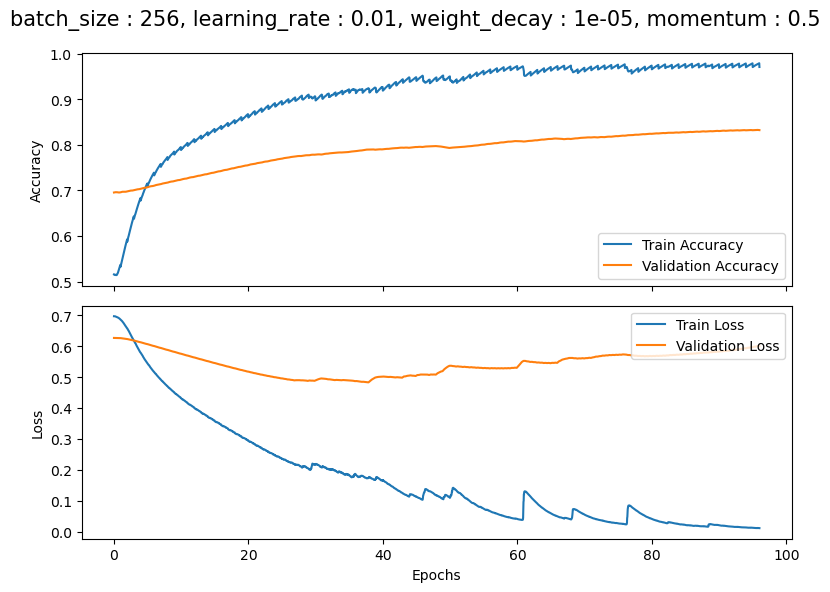

Train accuracy:  97.5
Validation accuracy:  83.8



Combination 34 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/6, Train loss:  0.639, Train accuracy:  64.6%: 100%|██████████| 563/563 [00:05<00:00, 94.98it/s] 
Epoch: 1/6, Val loss:  0.584, Val accuracy:  73.6%: 100%|██████████| 63/63 [00:00<00:00, 378.31it/s]


Epoch: 2/6, Train loss:  0.531, Train accuracy:  77.0%: 100%|██████████| 563/563 [00:09<00:00, 61.26it/s]
Epoch: 2/6, Val loss:  0.497, Val accuracy:  77.9%: 100%|██████████| 63/63 [00:00<00:00, 300.62it/s]


Epoch: 3/6, Train loss:  0.478, Train accuracy:  79.7%: 100%|██████████| 563/563 [00:09<00:00, 60.05it/s]
Epoch: 3/6, Val loss:  0.466, Val accuracy:  79.9%: 100%|██████████| 63/63 [00:00<00:00, 320.77it/s]


Epoch: 4/6, Train loss:  0.452, Train accuracy:  80.6%: 100%|██████████| 563/563 [00:09<00:00, 60.12it/s]
Epoch: 4/6, Val loss:  0.450, Val accuracy:  81.2%: 100%|██████████| 63/63 [00:00<00:00, 336.29it/s]


Epoch: 5/6, Train loss:  0.429, Train accuracy:  82.0%: 100%|██████████| 563/563 [00:09<00:00, 59.80it/s]
Epoch: 5/6, Val loss:  0.437, Val accuracy:  81.3%: 100%|██████████| 63/63 [00:00<00:00, 365.91it/s]


Epoch: 6/6, Train loss:  0.407, Train accuracy:  83.0%: 100%|██████████| 563/563 [00:09<00:00, 60.45it/s]
Epoch: 6/6, Val loss:  0.428, Val accuracy:  81.6%: 100%|██████████| 63/63 [00:00<00:00, 312.56it/s]


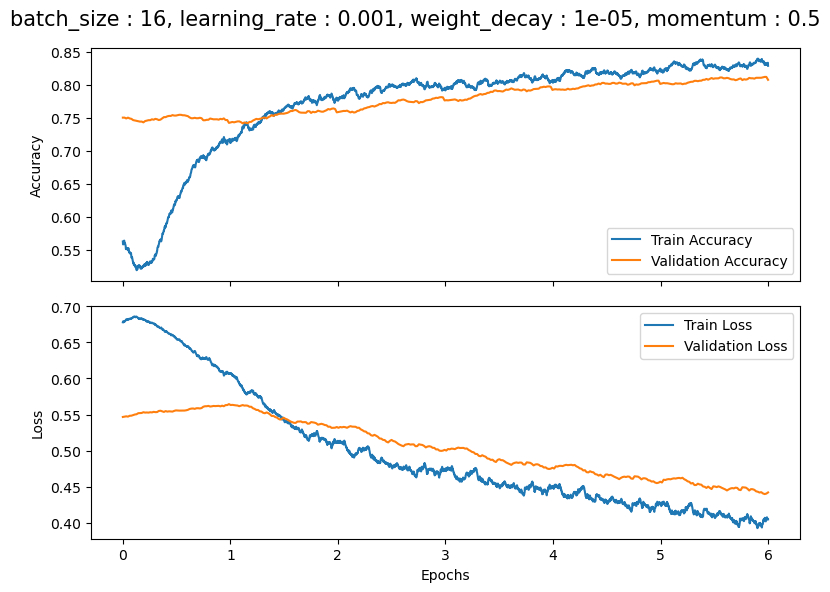

Train accuracy:  83.9
Validation accuracy:  81.6



Combination 35 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/24, Train loss:  0.684, Train accuracy:  50.2%: 100%|██████████| 141/141 [00:00<00:00, 165.80it/s]
Epoch: 1/24, Val loss:  0.665, Val accuracy:  55.9%: 100%|██████████| 16/16 [00:00<00:00, 422.55it/s]


Epoch: 2/24, Train loss:  0.654, Train accuracy:  62.9%: 100%|██████████| 141/141 [00:01<00:00, 131.75it/s]
Epoch: 2/24, Val loss:  0.638, Val accuracy:  67.3%: 100%|██████████| 16/16 [00:00<00:00, 398.88it/s]


Epoch: 3/24, Train loss:  0.624, Train accuracy:  70.7%: 100%|██████████| 141/141 [00:01<00:00, 131.10it/s]
Epoch: 3/24, Val loss:  0.611, Val accuracy:  70.4%: 100%|██████████| 16/16 [00:00<00:00, 384.53it/s]


Epoch: 4/24, Train loss:  0.593, Train accuracy:  72.9%: 100%|██████████| 141/141 [00:01<00:00, 134.47it/s]
Epoch: 4/24, Val loss:  0.584, Val accuracy:  72.3%: 100%|██████████| 16/16 [00:00<00:00, 393.33it/s]


Epoch: 5/24, Train loss:  0.565, Train accuracy:  75.1%: 100%|██████████| 141/141 [00:00<00:00, 142.34it/s]
Epoch: 5/24, Val loss:  0.558, Val accuracy:  73.9%: 100%|██████████| 16/16 [00:00<00:00, 404.17it/s]


Epoch: 6/24, Train loss:  0.538, Train accuracy:  76.6%: 100%|██████████| 141/141 [00:01<00:00, 139.39it/s]
Epoch: 6/24, Val loss:  0.533, Val accuracy:  75.3%: 100%|██████████| 16/16 [00:00<00:00, 366.94it/s]


Epoch: 7/24, Train loss:  0.516, Train accuracy:  77.7%: 100%|██████████| 141/141 [00:01<00:00, 135.11it/s]
Epoch: 7/24, Val loss:  0.513, Val accuracy:  76.2%: 100%|██████████| 16/16 [00:00<00:00, 409.00it/s]


Epoch: 8/24, Train loss:  0.500, Train accuracy:  78.3%: 100%|██████████| 141/141 [00:01<00:00, 129.61it/s]
Epoch: 8/24, Val loss:  0.498, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 413.77it/s]


Epoch: 9/24, Train loss:  0.487, Train accuracy:  79.1%: 100%|██████████| 141/141 [00:01<00:00, 128.32it/s]
Epoch: 9/24, Val loss:  0.487, Val accuracy:  77.1%: 100%|██████████| 16/16 [00:00<00:00, 373.97it/s]


Epoch: 10/24, Train loss:  0.478, Train accuracy:  79.6%: 100%|██████████| 141/141 [00:01<00:00, 136.65it/s]
Epoch: 10/24, Val loss:  0.479, Val accuracy:  77.6%: 100%|██████████| 16/16 [00:00<00:00, 402.57it/s]


Epoch: 11/24, Train loss:  0.470, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:01<00:00, 129.54it/s]
Epoch: 11/24, Val loss:  0.472, Val accuracy:  78.1%: 100%|██████████| 16/16 [00:00<00:00, 408.67it/s]


Epoch: 12/24, Train loss:  0.463, Train accuracy:  80.4%: 100%|██████████| 141/141 [00:01<00:00, 134.04it/s]
Epoch: 12/24, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 414.20it/s]


Epoch: 13/24, Train loss:  0.456, Train accuracy:  80.7%: 100%|██████████| 141/141 [00:01<00:00, 135.96it/s]
Epoch: 13/24, Val loss:  0.462, Val accuracy:  79.0%: 100%|██████████| 16/16 [00:00<00:00, 401.58it/s]


Epoch: 14/24, Train loss:  0.450, Train accuracy:  80.9%: 100%|██████████| 141/141 [00:01<00:00, 135.06it/s]
Epoch: 14/24, Val loss:  0.457, Val accuracy:  79.4%: 100%|██████████| 16/16 [00:00<00:00, 374.85it/s]


Epoch: 15/24, Train loss:  0.443, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:00<00:00, 143.36it/s]
Epoch: 15/24, Val loss:  0.453, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 398.25it/s]


Epoch: 16/24, Train loss:  0.437, Train accuracy:  81.6%: 100%|██████████| 141/141 [00:00<00:00, 148.71it/s]
Epoch: 16/24, Val loss:  0.449, Val accuracy:  79.3%: 100%|██████████| 16/16 [00:00<00:00, 414.01it/s]


Epoch: 17/24, Train loss:  0.431, Train accuracy:  81.9%: 100%|██████████| 141/141 [00:01<00:00, 140.55it/s]
Epoch: 17/24, Val loss:  0.446, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 398.88it/s]


Epoch: 18/24, Train loss:  0.424, Train accuracy:  82.0%: 100%|██████████| 141/141 [00:01<00:00, 135.82it/s]
Epoch: 18/24, Val loss:  0.442, Val accuracy:  79.7%: 100%|██████████| 16/16 [00:00<00:00, 398.71it/s]


Epoch: 19/24, Train loss:  0.418, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:00<00:00, 141.50it/s]
Epoch: 19/24, Val loss:  0.440, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 424.18it/s]


Epoch: 20/24, Train loss:  0.412, Train accuracy:  82.6%: 100%|██████████| 141/141 [00:00<00:00, 152.65it/s]
Epoch: 20/24, Val loss:  0.437, Val accuracy:  80.6%: 100%|██████████| 16/16 [00:00<00:00, 350.24it/s]


Epoch: 21/24, Train loss:  0.406, Train accuracy:  82.9%: 100%|██████████| 141/141 [00:00<00:00, 143.83it/s]
Epoch: 21/24, Val loss:  0.434, Val accuracy:  80.5%: 100%|██████████| 16/16 [00:00<00:00, 408.56it/s]


Epoch: 22/24, Train loss:  0.400, Train accuracy:  83.2%: 100%|██████████| 141/141 [00:00<00:00, 148.11it/s]
Epoch: 22/24, Val loss:  0.432, Val accuracy:  80.4%: 100%|██████████| 16/16 [00:00<00:00, 414.00it/s]


Epoch: 23/24, Train loss:  0.394, Train accuracy:  83.4%: 100%|██████████| 141/141 [00:01<00:00, 139.00it/s]
Epoch: 23/24, Val loss:  0.430, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 389.55it/s]


Epoch: 24/24, Train loss:  0.389, Train accuracy:  83.6%: 100%|██████████| 141/141 [00:01<00:00, 140.59it/s]
Epoch: 24/24, Val loss:  0.428, Val accuracy:  80.5%: 100%|██████████| 16/16 [00:00<00:00, 380.26it/s]


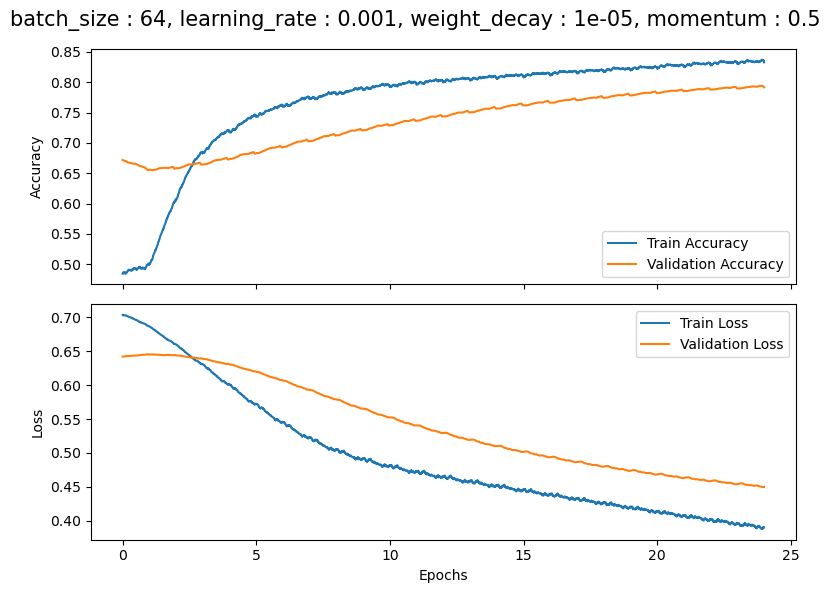

Train accuracy:  84.0
Validation accuracy:  80.5



Combination 36 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.5



Epoch: 1/96, Train loss:  0.696, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s]
Epoch: 1/96, Val loss:  0.685, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 175.02it/s]


Epoch: 2/96, Train loss:  0.687, Train accuracy:  48.6%: 100%|██████████| 36/36 [00:00<00:00, 109.56it/s]
Epoch: 2/96, Val loss:  0.678, Val accuracy:  50.9%: 100%|██████████| 4/4 [00:00<00:00, 177.36it/s]


Epoch: 3/96, Train loss:  0.680, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 106.50it/s]
Epoch: 3/96, Val loss:  0.671, Val accuracy:  50.8%: 100%|██████████| 4/4 [00:00<00:00, 173.67it/s]


Epoch: 4/96, Train loss:  0.673, Train accuracy:  50.9%: 100%|██████████| 36/36 [00:00<00:00, 107.71it/s]
Epoch: 4/96, Val loss:  0.664, Val accuracy:  55.9%: 100%|██████████| 4/4 [00:00<00:00, 183.76it/s]


Epoch: 5/96, Train loss:  0.665, Train accuracy:  56.8%: 100%|██████████| 36/36 [00:00<00:00, 108.06it/s]
Epoch: 5/96, Val loss:  0.657, Val accuracy:  59.4%: 100%|██████████| 4/4 [00:00<00:00, 155.76it/s]


Epoch: 6/96, Train loss:  0.657, Train accuracy:  61.2%: 100%|██████████| 36/36 [00:00<00:00, 108.62it/s]
Epoch: 6/96, Val loss:  0.650, Val accuracy:  63.1%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 7/96, Train loss:  0.650, Train accuracy:  64.1%: 100%|██████████| 36/36 [00:00<00:00, 107.81it/s]
Epoch: 7/96, Val loss:  0.643, Val accuracy:  66.2%: 100%|██████████| 4/4 [00:00<00:00, 184.74it/s]


Epoch: 8/96, Train loss:  0.642, Train accuracy:  66.2%: 100%|██████████| 36/36 [00:00<00:00, 109.46it/s]
Epoch: 8/96, Val loss:  0.636, Val accuracy:  67.4%: 100%|██████████| 4/4 [00:00<00:00, 169.28it/s]


Epoch: 9/96, Train loss:  0.635, Train accuracy:  67.6%: 100%|██████████| 36/36 [00:00<00:00, 109.98it/s]
Epoch: 9/96, Val loss:  0.629, Val accuracy:  68.7%: 100%|██████████| 4/4 [00:00<00:00, 181.65it/s]


Epoch: 10/96, Train loss:  0.627, Train accuracy:  68.9%: 100%|██████████| 36/36 [00:00<00:00, 107.88it/s]
Epoch: 10/96, Val loss:  0.622, Val accuracy:  69.4%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 11/96, Train loss:  0.619, Train accuracy:  69.9%: 100%|██████████| 36/36 [00:00<00:00, 106.53it/s]
Epoch: 11/96, Val loss:  0.615, Val accuracy:  69.7%: 100%|██████████| 4/4 [00:00<00:00, 166.53it/s]


Epoch: 12/96, Train loss:  0.612, Train accuracy:  70.4%: 100%|██████████| 36/36 [00:00<00:00, 88.86it/s]
Epoch: 12/96, Val loss:  0.608, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 168.60it/s]


Epoch: 13/96, Train loss:  0.604, Train accuracy:  70.9%: 100%|██████████| 36/36 [00:00<00:00, 107.65it/s]
Epoch: 13/96, Val loss:  0.601, Val accuracy:  70.6%: 100%|██████████| 4/4 [00:00<00:00, 181.61it/s]


Epoch: 14/96, Train loss:  0.596, Train accuracy:  71.3%: 100%|██████████| 36/36 [00:00<00:00, 107.29it/s]
Epoch: 14/96, Val loss:  0.594, Val accuracy:  71.0%: 100%|██████████| 4/4 [00:00<00:00, 176.92it/s]


Epoch: 15/96, Train loss:  0.589, Train accuracy:  72.0%: 100%|██████████| 36/36 [00:00<00:00, 106.47it/s]
Epoch: 15/96, Val loss:  0.587, Val accuracy:  71.8%: 100%|██████████| 4/4 [00:00<00:00, 175.45it/s]


Epoch: 16/96, Train loss:  0.582, Train accuracy:  72.5%: 100%|██████████| 36/36 [00:00<00:00, 111.40it/s]
Epoch: 16/96, Val loss:  0.581, Val accuracy:  72.3%: 100%|██████████| 4/4 [00:00<00:00, 182.22it/s]


Epoch: 17/96, Train loss:  0.574, Train accuracy:  73.0%: 100%|██████████| 36/36 [00:00<00:00, 107.96it/s]
Epoch: 17/96, Val loss:  0.574, Val accuracy:  72.7%: 100%|██████████| 4/4 [00:00<00:00, 159.60it/s]


Epoch: 18/96, Train loss:  0.567, Train accuracy:  73.5%: 100%|██████████| 36/36 [00:00<00:00, 109.47it/s]
Epoch: 18/96, Val loss:  0.567, Val accuracy:  72.8%: 100%|██████████| 4/4 [00:00<00:00, 181.42it/s]


Epoch: 19/96, Train loss:  0.560, Train accuracy:  73.8%: 100%|██████████| 36/36 [00:00<00:00, 106.72it/s]
Epoch: 19/96, Val loss:  0.560, Val accuracy:  73.5%: 100%|██████████| 4/4 [00:00<00:00, 153.08it/s]


Epoch: 20/96, Train loss:  0.553, Train accuracy:  74.3%: 100%|██████████| 36/36 [00:00<00:00, 105.46it/s]
Epoch: 20/96, Val loss:  0.554, Val accuracy:  74.0%: 100%|██████████| 4/4 [00:00<00:00, 166.12it/s]


Epoch: 21/96, Train loss:  0.547, Train accuracy:  74.7%: 100%|██████████| 36/36 [00:00<00:00, 107.97it/s]
Epoch: 21/96, Val loss:  0.547, Val accuracy:  74.1%: 100%|██████████| 4/4 [00:00<00:00, 163.46it/s]


Epoch: 22/96, Train loss:  0.540, Train accuracy:  75.1%: 100%|██████████| 36/36 [00:00<00:00, 108.90it/s]
Epoch: 22/96, Val loss:  0.541, Val accuracy:  74.9%: 100%|██████████| 4/4 [00:00<00:00, 191.03it/s]


Epoch: 23/96, Train loss:  0.534, Train accuracy:  75.4%: 100%|██████████| 36/36 [00:00<00:00, 106.67it/s]
Epoch: 23/96, Val loss:  0.534, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 173.39it/s]


Epoch: 24/96, Train loss:  0.528, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 108.77it/s]
Epoch: 24/96, Val loss:  0.528, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 166.44it/s]


Epoch: 25/96, Train loss:  0.522, Train accuracy:  75.9%: 100%|██████████| 36/36 [00:00<00:00, 108.21it/s]
Epoch: 25/96, Val loss:  0.523, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 171.86it/s]


Epoch: 26/96, Train loss:  0.517, Train accuracy:  76.1%: 100%|██████████| 36/36 [00:00<00:00, 109.18it/s]
Epoch: 26/96, Val loss:  0.518, Val accuracy:  75.5%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 27/96, Train loss:  0.512, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 104.31it/s]
Epoch: 27/96, Val loss:  0.513, Val accuracy:  75.7%: 100%|██████████| 4/4 [00:00<00:00, 169.36it/s]


Epoch: 28/96, Train loss:  0.508, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 109.43it/s]
Epoch: 28/96, Val loss:  0.508, Val accuracy:  76.3%: 100%|██████████| 4/4 [00:00<00:00, 173.46it/s]


Epoch: 29/96, Train loss:  0.504, Train accuracy:  76.6%: 100%|██████████| 36/36 [00:00<00:00, 109.45it/s]
Epoch: 29/96, Val loss:  0.504, Val accuracy:  76.5%: 100%|██████████| 4/4 [00:00<00:00, 173.52it/s]


Epoch: 30/96, Train loss:  0.500, Train accuracy:  76.8%: 100%|██████████| 36/36 [00:00<00:00, 104.64it/s]
Epoch: 30/96, Val loss:  0.500, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 31/96, Train loss:  0.496, Train accuracy:  77.0%: 100%|██████████| 36/36 [00:00<00:00, 106.53it/s]
Epoch: 31/96, Val loss:  0.497, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 167.60it/s]


Epoch: 32/96, Train loss:  0.493, Train accuracy:  77.2%: 100%|██████████| 36/36 [00:00<00:00, 106.37it/s]
Epoch: 32/96, Val loss:  0.493, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 158.80it/s]


Epoch: 33/96, Train loss:  0.490, Train accuracy:  77.4%: 100%|██████████| 36/36 [00:00<00:00, 108.21it/s]
Epoch: 33/96, Val loss:  0.490, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 180.63it/s]


Epoch: 34/96, Train loss:  0.487, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 105.13it/s]
Epoch: 34/96, Val loss:  0.488, Val accuracy:  77.0%: 100%|██████████| 4/4 [00:00<00:00, 176.91it/s]


Epoch: 35/96, Train loss:  0.484, Train accuracy:  77.8%: 100%|██████████| 36/36 [00:00<00:00, 109.06it/s]
Epoch: 35/96, Val loss:  0.485, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 159.38it/s]


Epoch: 36/96, Train loss:  0.482, Train accuracy:  77.9%: 100%|██████████| 36/36 [00:00<00:00, 106.62it/s]
Epoch: 36/96, Val loss:  0.483, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 176.58it/s]


Epoch: 37/96, Train loss:  0.479, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 106.91it/s]
Epoch: 37/96, Val loss:  0.480, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 173.26it/s]


Epoch: 38/96, Train loss:  0.477, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 88.31it/s]
Epoch: 38/96, Val loss:  0.478, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 173.48it/s]


Epoch: 39/96, Train loss:  0.475, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 107.18it/s]
Epoch: 39/96, Val loss:  0.476, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 169.24it/s]


Epoch: 40/96, Train loss:  0.473, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 105.83it/s]
Epoch: 40/96, Val loss:  0.474, Val accuracy:  77.2%: 100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch: 41/96, Train loss:  0.471, Train accuracy:  78.3%: 100%|██████████| 36/36 [00:00<00:00, 107.57it/s]
Epoch: 41/96, Val loss:  0.473, Val accuracy:  77.4%: 100%|██████████| 4/4 [00:00<00:00, 177.77it/s]


Epoch: 42/96, Train loss:  0.469, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 104.97it/s]
Epoch: 42/96, Val loss:  0.471, Val accuracy:  77.7%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 43/96, Train loss:  0.467, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 109.17it/s]
Epoch: 43/96, Val loss:  0.469, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 159.64it/s]


Epoch: 44/96, Train loss:  0.465, Train accuracy:  78.7%: 100%|██████████| 36/36 [00:00<00:00, 105.82it/s]
Epoch: 44/96, Val loss:  0.468, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 172.50it/s]


Epoch: 45/96, Train loss:  0.463, Train accuracy:  78.8%: 100%|██████████| 36/36 [00:00<00:00, 106.17it/s]
Epoch: 45/96, Val loss:  0.466, Val accuracy:  78.2%: 100%|██████████| 4/4 [00:00<00:00, 185.05it/s]


Epoch: 46/96, Train loss:  0.461, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 105.34it/s]
Epoch: 46/96, Val loss:  0.465, Val accuracy:  78.3%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 47/96, Train loss:  0.460, Train accuracy:  78.9%: 100%|██████████| 36/36 [00:00<00:00, 111.08it/s]
Epoch: 47/96, Val loss:  0.463, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 166.25it/s]


Epoch: 48/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 107.96it/s]
Epoch: 48/96, Val loss:  0.462, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 173.55it/s]


Epoch: 49/96, Train loss:  0.456, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 105.74it/s]
Epoch: 49/96, Val loss:  0.461, Val accuracy:  79.0%: 100%|██████████| 4/4 [00:00<00:00, 181.99it/s]


Epoch: 50/96, Train loss:  0.454, Train accuracy:  79.1%: 100%|██████████| 36/36 [00:00<00:00, 109.30it/s]
Epoch: 50/96, Val loss:  0.460, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 156.76it/s]


Epoch: 51/96, Train loss:  0.452, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 108.71it/s]
Epoch: 51/96, Val loss:  0.458, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 172.47it/s]


Epoch: 52/96, Train loss:  0.451, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 108.13it/s]
Epoch: 52/96, Val loss:  0.457, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 185.50it/s]


Epoch: 53/96, Train loss:  0.449, Train accuracy:  79.2%: 100%|██████████| 36/36 [00:00<00:00, 100.35it/s]
Epoch: 53/96, Val loss:  0.456, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 181.06it/s]


Epoch: 54/96, Train loss:  0.447, Train accuracy:  79.4%: 100%|██████████| 36/36 [00:00<00:00, 109.42it/s]
Epoch: 54/96, Val loss:  0.455, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 169.46it/s]


Epoch: 55/96, Train loss:  0.445, Train accuracy:  79.4%: 100%|██████████| 36/36 [00:00<00:00, 106.19it/s]
Epoch: 55/96, Val loss:  0.454, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 159.46it/s]


Epoch: 56/96, Train loss:  0.444, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 105.48it/s]
Epoch: 56/96, Val loss:  0.453, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 182.97it/s]


Epoch: 57/96, Train loss:  0.442, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 105.41it/s]
Epoch: 57/96, Val loss:  0.452, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 132.85it/s]


Epoch: 58/96, Train loss:  0.440, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 108.67it/s]
Epoch: 58/96, Val loss:  0.451, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 169.67it/s]


Epoch: 59/96, Train loss:  0.438, Train accuracy:  79.8%: 100%|██████████| 36/36 [00:00<00:00, 109.12it/s]
Epoch: 59/96, Val loss:  0.450, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 156.35it/s]


Epoch: 60/96, Train loss:  0.437, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 101.91it/s]
Epoch: 60/96, Val loss:  0.449, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s]


Epoch: 61/96, Train loss:  0.435, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 107.27it/s]
Epoch: 61/96, Val loss:  0.448, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 172.87it/s]


Epoch: 62/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 108.87it/s]
Epoch: 62/96, Val loss:  0.447, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 174.45it/s]


Epoch: 63/96, Train loss:  0.431, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 105.65it/s]
Epoch: 63/96, Val loss:  0.446, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 170.89it/s]


Epoch: 64/96, Train loss:  0.430, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 89.01it/s] 
Epoch: 64/96, Val loss:  0.445, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 178.43it/s]


Epoch: 65/96, Train loss:  0.428, Train accuracy:  80.1%: 100%|██████████| 36/36 [00:00<00:00, 106.25it/s]
Epoch: 65/96, Val loss:  0.444, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 177.07it/s]


Epoch: 66/96, Train loss:  0.426, Train accuracy:  80.2%: 100%|██████████| 36/36 [00:00<00:00, 106.21it/s]
Epoch: 66/96, Val loss:  0.443, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 153.40it/s]


Epoch: 67/96, Train loss:  0.424, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 106.77it/s]
Epoch: 67/96, Val loss:  0.442, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 68/96, Train loss:  0.423, Train accuracy:  80.4%: 100%|██████████| 36/36 [00:00<00:00, 104.48it/s]
Epoch: 68/96, Val loss:  0.441, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 183.16it/s]


Epoch: 69/96, Train loss:  0.421, Train accuracy:  80.5%: 100%|██████████| 36/36 [00:00<00:00, 106.15it/s]
Epoch: 69/96, Val loss:  0.440, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 166.29it/s]


Epoch: 70/96, Train loss:  0.419, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 105.35it/s]
Epoch: 70/96, Val loss:  0.440, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 164.55it/s]


Epoch: 71/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 105.28it/s]
Epoch: 71/96, Val loss:  0.439, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s]


Epoch: 72/96, Train loss:  0.416, Train accuracy:  80.7%: 100%|██████████| 36/36 [00:00<00:00, 104.22it/s]
Epoch: 72/96, Val loss:  0.438, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 159.56it/s]


Epoch: 73/96, Train loss:  0.414, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 107.55it/s]
Epoch: 73/96, Val loss:  0.437, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 166.17it/s]


Epoch: 74/96, Train loss:  0.412, Train accuracy:  80.8%: 100%|██████████| 36/36 [00:00<00:00, 105.68it/s]
Epoch: 74/96, Val loss:  0.437, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 168.66it/s]


Epoch: 75/96, Train loss:  0.411, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 105.95it/s]
Epoch: 75/96, Val loss:  0.436, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 181.68it/s]


Epoch: 76/96, Train loss:  0.409, Train accuracy:  81.0%: 100%|██████████| 36/36 [00:00<00:00, 104.63it/s]
Epoch: 76/96, Val loss:  0.435, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.12it/s]


Epoch: 77/96, Train loss:  0.407, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 109.53it/s]
Epoch: 77/96, Val loss:  0.435, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 162.62it/s]


Epoch: 78/96, Train loss:  0.406, Train accuracy:  81.1%: 100%|██████████| 36/36 [00:00<00:00, 106.89it/s]
Epoch: 78/96, Val loss:  0.434, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 189.57it/s]


Epoch: 79/96, Train loss:  0.404, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 104.95it/s]
Epoch: 79/96, Val loss:  0.433, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 176.82it/s]


Epoch: 80/96, Train loss:  0.402, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 104.37it/s]
Epoch: 80/96, Val loss:  0.432, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 175.50it/s]


Epoch: 81/96, Train loss:  0.401, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 108.29it/s]
Epoch: 81/96, Val loss:  0.432, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 162.45it/s]


Epoch: 82/96, Train loss:  0.399, Train accuracy:  81.3%: 100%|██████████| 36/36 [00:00<00:00, 105.44it/s]
Epoch: 82/96, Val loss:  0.431, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 83/96, Train loss:  0.398, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 105.12it/s]
Epoch: 83/96, Val loss:  0.431, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 84/96, Train loss:  0.396, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 106.32it/s]
Epoch: 84/96, Val loss:  0.430, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 156.14it/s]


Epoch: 85/96, Train loss:  0.394, Train accuracy:  81.6%: 100%|██████████| 36/36 [00:00<00:00, 110.97it/s]
Epoch: 85/96, Val loss:  0.429, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 86/96, Train loss:  0.393, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 107.26it/s]
Epoch: 86/96, Val loss:  0.429, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 87/96, Train loss:  0.391, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 107.84it/s]
Epoch: 87/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 173.26it/s]


Epoch: 88/96, Train loss:  0.390, Train accuracy:  81.7%: 100%|██████████| 36/36 [00:00<00:00, 108.18it/s]
Epoch: 88/96, Val loss:  0.428, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 159.30it/s]


Epoch: 89/96, Train loss:  0.388, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 109.15it/s]
Epoch: 89/96, Val loss:  0.427, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 180.11it/s]


Epoch: 90/96, Train loss:  0.386, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 107.65it/s]
Epoch: 90/96, Val loss:  0.426, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 43.02it/s]


Epoch: 91/96, Train loss:  0.385, Train accuracy:  82.0%: 100%|██████████| 36/36 [00:00<00:00, 105.71it/s]
Epoch: 91/96, Val loss:  0.426, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 181.79it/s]


Epoch: 92/96, Train loss:  0.383, Train accuracy:  82.1%: 100%|██████████| 36/36 [00:00<00:00, 109.58it/s]
Epoch: 92/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 147.40it/s]


Epoch: 93/96, Train loss:  0.382, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 106.53it/s]
Epoch: 93/96, Val loss:  0.425, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 180.72it/s]


Epoch: 94/96, Train loss:  0.380, Train accuracy:  82.3%: 100%|██████████| 36/36 [00:00<00:00, 107.42it/s]
Epoch: 94/96, Val loss:  0.424, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 175.23it/s]


Epoch: 95/96, Train loss:  0.379, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 102.05it/s]
Epoch: 95/96, Val loss:  0.424, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 168.94it/s]


Epoch: 96/96, Train loss:  0.377, Train accuracy:  82.4%: 100%|██████████| 36/36 [00:00<00:00, 110.70it/s]
Epoch: 96/96, Val loss:  0.423, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 165.97it/s]


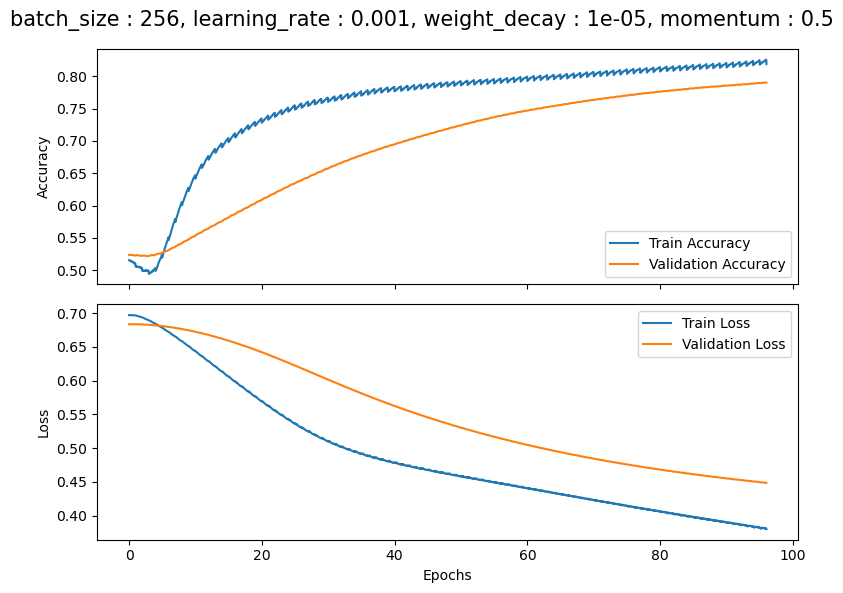

Train accuracy:  82.5
Validation accuracy:  81.0



Combination 37 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.9



Epoch: 1/6, Train loss:  0.475, Train accuracy:  78.9%: 100%|██████████| 563/563 [00:05<00:00, 105.75it/s]
Epoch: 1/6, Val loss:  0.426, Val accuracy:  81.7%: 100%|██████████| 63/63 [00:00<00:00, 391.39it/s]


Epoch: 2/6, Train loss:  0.399, Train accuracy:  83.3%: 100%|██████████| 563/563 [00:08<00:00, 62.90it/s]
Epoch: 2/6, Val loss:  0.406, Val accuracy:  82.4%: 100%|██████████| 63/63 [00:00<00:00, 331.69it/s]


Epoch: 3/6, Train loss:  0.356, Train accuracy:  85.6%: 100%|██████████| 563/563 [00:08<00:00, 64.40it/s]
Epoch: 3/6, Val loss:  0.405, Val accuracy:  82.7%: 100%|██████████| 63/63 [00:00<00:00, 307.50it/s]


Epoch: 4/6, Train loss:  0.322, Train accuracy:  86.8%: 100%|██████████| 563/563 [00:08<00:00, 64.08it/s]
Epoch: 4/6, Val loss:  0.438, Val accuracy:  83.3%: 100%|██████████| 63/63 [00:00<00:00, 302.85it/s]


Epoch: 5/6, Train loss:  0.290, Train accuracy:  88.6%: 100%|██████████| 563/563 [00:08<00:00, 68.31it/s]
Epoch: 5/6, Val loss:  0.424, Val accuracy:  82.1%: 100%|██████████| 63/63 [00:00<00:00, 355.06it/s]


Epoch: 6/6, Train loss:  0.269, Train accuracy:  89.3%: 100%|██████████| 563/563 [00:08<00:00, 65.97it/s]
Epoch: 6/6, Val loss:  0.446, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 345.99it/s]


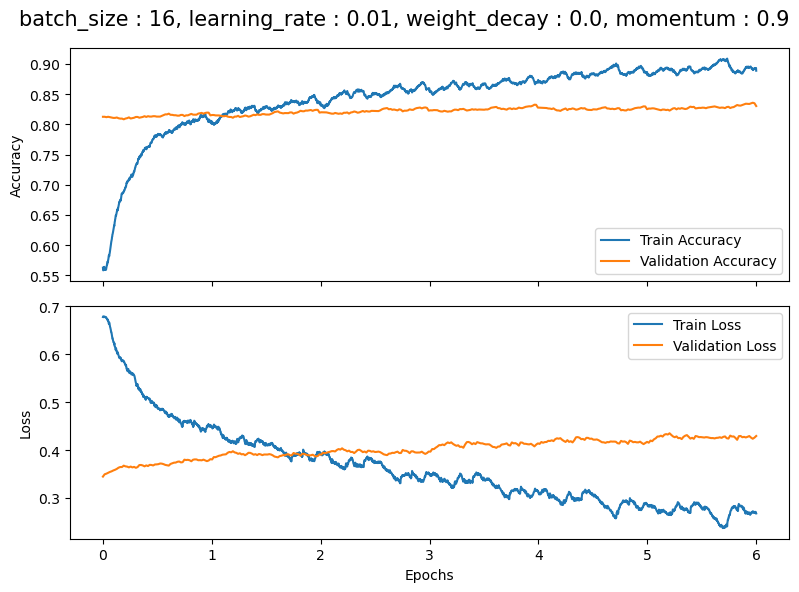

Train accuracy:  89.1
Validation accuracy:  83.6



Combination 38 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.9



Epoch: 1/24, Train loss:  0.505, Train accuracy:  75.9%: 100%|██████████| 141/141 [00:00<00:00, 187.90it/s]
Epoch: 1/24, Val loss:  0.443, Val accuracy:  78.7%: 100%|██████████| 16/16 [00:00<00:00, 425.25it/s]


Epoch: 2/24, Train loss:  0.405, Train accuracy:  82.9%: 100%|██████████| 141/141 [00:01<00:00, 139.59it/s]
Epoch: 2/24, Val loss:  0.395, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 148.20it/s]


Epoch: 3/24, Train loss:  0.358, Train accuracy:  85.2%: 100%|██████████| 141/141 [00:01<00:00, 137.10it/s]
Epoch: 3/24, Val loss:  0.387, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 415.77it/s]


Epoch: 4/24, Train loss:  0.323, Train accuracy:  86.6%: 100%|██████████| 141/141 [00:01<00:00, 138.38it/s]
Epoch: 4/24, Val loss:  0.389, Val accuracy:  83.8%: 100%|██████████| 16/16 [00:00<00:00, 341.65it/s]


Epoch: 5/24, Train loss:  0.293, Train accuracy:  88.2%: 100%|██████████| 141/141 [00:01<00:00, 140.50it/s]
Epoch: 5/24, Val loss:  0.411, Val accuracy:  83.8%: 100%|██████████| 16/16 [00:00<00:00, 415.27it/s]


Epoch: 6/24, Train loss:  0.264, Train accuracy:  89.8%: 100%|██████████| 141/141 [00:00<00:00, 144.96it/s]
Epoch: 6/24, Val loss:  0.409, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 430.41it/s]


Epoch: 7/24, Train loss:  0.237, Train accuracy:  91.1%: 100%|██████████| 141/141 [00:00<00:00, 158.20it/s]
Epoch: 7/24, Val loss:  0.423, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 408.87it/s]


Epoch: 8/24, Train loss:  0.209, Train accuracy:  92.0%: 100%|██████████| 141/141 [00:01<00:00, 138.27it/s]
Epoch: 8/24, Val loss:  0.475, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 387.35it/s]


Epoch: 9/24, Train loss:  0.179, Train accuracy:  93.4%: 100%|██████████| 141/141 [00:00<00:00, 142.36it/s]
Epoch: 9/24, Val loss:  0.590, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 408.97it/s]


Epoch: 10/24, Train loss:  0.165, Train accuracy:  93.7%: 100%|██████████| 141/141 [00:00<00:00, 148.38it/s]
Epoch: 10/24, Val loss:  0.602, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 398.57it/s]


Epoch: 11/24, Train loss:  0.176, Train accuracy:  93.3%: 100%|██████████| 141/141 [00:01<00:00, 139.26it/s]
Epoch: 11/24, Val loss:  0.518, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 332.16it/s]


Epoch: 12/24, Train loss:  0.184, Train accuracy:  92.5%: 100%|██████████| 141/141 [00:01<00:00, 134.72it/s]
Epoch: 12/24, Val loss:  0.451, Val accuracy:  83.1%: 100%|██████████| 16/16 [00:00<00:00, 393.45it/s]


Epoch: 13/24, Train loss:  0.153, Train accuracy:  93.7%: 100%|██████████| 141/141 [00:01<00:00, 137.82it/s]
Epoch: 13/24, Val loss:  0.514, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 403.71it/s]


Epoch: 14/24, Train loss:  0.125, Train accuracy:  95.0%: 100%|██████████| 141/141 [00:01<00:00, 138.96it/s]
Epoch: 14/24, Val loss:  0.638, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 398.05it/s]


Epoch: 15/24, Train loss:  0.124, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:01<00:00, 137.05it/s]
Epoch: 15/24, Val loss:  0.609, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 400.88it/s]


Epoch: 16/24, Train loss:  0.110, Train accuracy:  95.5%: 100%|██████████| 141/141 [00:00<00:00, 151.81it/s]
Epoch: 16/24, Val loss:  0.709, Val accuracy:  81.0%: 100%|██████████| 16/16 [00:00<00:00, 425.67it/s]


Epoch: 17/24, Train loss:  0.103, Train accuracy:  95.9%: 100%|██████████| 141/141 [00:00<00:00, 149.37it/s]
Epoch: 17/24, Val loss:  0.696, Val accuracy:  82.5%: 100%|██████████| 16/16 [00:00<00:00, 408.43it/s]


Epoch: 18/24, Train loss:  0.094, Train accuracy:  96.1%: 100%|██████████| 141/141 [00:00<00:00, 160.99it/s]
Epoch: 18/24, Val loss:  0.761, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 422.13it/s]


Epoch: 19/24, Train loss:  0.086, Train accuracy:  96.4%: 100%|██████████| 141/141 [00:00<00:00, 146.00it/s]
Epoch: 19/24, Val loss:  0.792, Val accuracy:  81.2%: 100%|██████████| 16/16 [00:00<00:00, 396.79it/s]


Epoch: 20/24, Train loss:  0.079, Train accuracy:  96.9%: 100%|██████████| 141/141 [00:00<00:00, 143.21it/s]
Epoch: 20/24, Val loss:  0.910, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 442.42it/s]


Epoch: 21/24, Train loss:  0.075, Train accuracy:  96.9%: 100%|██████████| 141/141 [00:01<00:00, 140.80it/s]
Epoch: 21/24, Val loss:  0.885, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 396.30it/s]


Epoch: 22/24, Train loss:  0.079, Train accuracy:  96.7%: 100%|██████████| 141/141 [00:00<00:00, 142.73it/s]
Epoch: 22/24, Val loss:  0.822, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 408.91it/s]


Epoch: 23/24, Train loss:  0.075, Train accuracy:  96.8%: 100%|██████████| 141/141 [00:01<00:00, 139.84it/s]
Epoch: 23/24, Val loss:  0.758, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 409.30it/s]


Epoch: 24/24, Train loss:  0.067, Train accuracy:  97.3%: 100%|██████████| 141/141 [00:01<00:00, 140.12it/s]
Epoch: 24/24, Val loss:  0.892, Val accuracy:  83.3%: 100%|██████████| 16/16 [00:00<00:00, 419.30it/s]


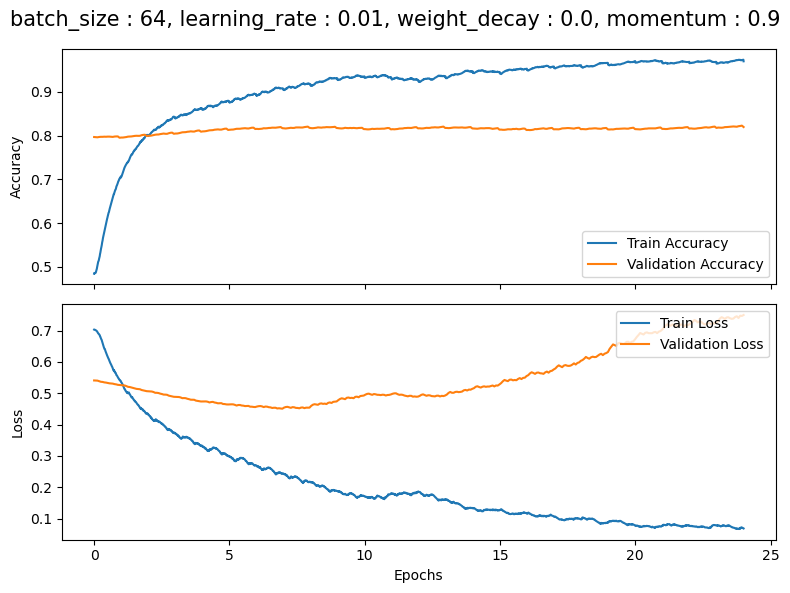

Train accuracy:  95.5
Validation accuracy:  83.3



Combination 39 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.0, momentum : 0.9



Epoch: 1/96, Train loss:  0.618, Train accuracy:  64.5%: 100%|██████████| 36/36 [00:00<00:00, 113.50it/s]
Epoch: 1/96, Val loss:  0.522, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 173.56it/s]


Epoch: 2/96, Train loss:  0.483, Train accuracy:  77.6%: 100%|██████████| 36/36 [00:00<00:00, 111.08it/s]
Epoch: 2/96, Val loss:  0.458, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 176.83it/s]


Epoch: 3/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 3/96, Val loss:  0.424, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 174.79it/s]


Epoch: 4/96, Train loss:  0.391, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 110.22it/s]
Epoch: 4/96, Val loss:  0.419, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 177.07it/s]


Epoch: 5/96, Train loss:  0.358, Train accuracy:  83.2%: 100%|██████████| 36/36 [00:00<00:00, 111.91it/s]
Epoch: 5/96, Val loss:  0.428, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 171.83it/s]


Epoch: 6/96, Train loss:  0.335, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 76.59it/s] 
Epoch: 6/96, Val loss:  0.408, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 147.78it/s]


Epoch: 7/96, Train loss:  0.309, Train accuracy:  85.2%: 100%|██████████| 36/36 [00:00<00:00, 106.47it/s]
Epoch: 7/96, Val loss:  0.431, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 174.59it/s]


Epoch: 8/96, Train loss:  0.294, Train accuracy:  86.2%: 100%|██████████| 36/36 [00:00<00:00, 104.61it/s]
Epoch: 8/96, Val loss:  0.405, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 171.28it/s]


Epoch: 9/96, Train loss:  0.274, Train accuracy:  87.0%: 100%|██████████| 36/36 [00:00<00:00, 111.68it/s]
Epoch: 9/96, Val loss:  0.373, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 10/96, Train loss:  0.239, Train accuracy:  88.8%: 100%|██████████| 36/36 [00:00<00:00, 111.92it/s]
Epoch: 10/96, Val loss:  0.382, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 185.32it/s]


Epoch: 11/96, Train loss:  0.198, Train accuracy:  90.6%: 100%|██████████| 36/36 [00:00<00:00, 116.02it/s]
Epoch: 11/96, Val loss:  0.379, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 183.48it/s]


Epoch: 12/96, Train loss:  0.171, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 110.37it/s]
Epoch: 12/96, Val loss:  0.400, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 177.17it/s]


Epoch: 13/96, Train loss:  0.136, Train accuracy:  93.5%: 100%|██████████| 36/36 [00:00<00:00, 115.03it/s]
Epoch: 13/96, Val loss:  0.441, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.38it/s]


Epoch: 14/96, Train loss:  0.121, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 93.98it/s] 
Epoch: 14/96, Val loss:  0.473, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 180.13it/s]


Epoch: 15/96, Train loss:  0.122, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 116.21it/s]
Epoch: 15/96, Val loss:  0.515, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 189.88it/s]


Epoch: 16/96, Train loss:  0.175, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 113.20it/s]
Epoch: 16/96, Val loss:  0.534, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 180.75it/s]


Epoch: 17/96, Train loss:  0.164, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 116.36it/s]
Epoch: 17/96, Val loss:  0.483, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 177.22it/s]


Epoch: 18/96, Train loss:  0.115, Train accuracy:  93.6%: 100%|██████████| 36/36 [00:00<00:00, 111.20it/s]
Epoch: 18/96, Val loss:  0.609, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 177.12it/s]


Epoch: 19/96, Train loss:  0.129, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 116.15it/s]
Epoch: 19/96, Val loss:  0.751, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 185.32it/s]


Epoch: 20/96, Train loss:  0.162, Train accuracy:  91.8%: 100%|██████████| 36/36 [00:00<00:00, 107.52it/s]
Epoch: 20/96, Val loss:  0.841, Val accuracy:  73.5%: 100%|██████████| 4/4 [00:00<00:00, 173.25it/s]


Epoch: 21/96, Train loss:  0.193, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 113.10it/s]
Epoch: 21/96, Val loss:  0.489, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.21it/s]


Epoch: 22/96, Train loss:  0.158, Train accuracy:  91.6%: 100%|██████████| 36/36 [00:00<00:00, 117.27it/s]
Epoch: 22/96, Val loss:  0.492, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 189.76it/s]


Epoch: 23/96, Train loss:  0.116, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 113.16it/s]
Epoch: 23/96, Val loss:  0.562, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 185.31it/s]


Epoch: 24/96, Train loss:  0.118, Train accuracy:  93.5%: 100%|██████████| 36/36 [00:00<00:00, 115.69it/s]
Epoch: 24/96, Val loss:  0.560, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 189.79it/s]


Epoch: 25/96, Train loss:  0.087, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 114.14it/s]
Epoch: 25/96, Val loss:  0.696, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 185.03it/s]


Epoch: 26/96, Train loss:  0.114, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 116.17it/s]
Epoch: 26/96, Val loss:  0.571, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 177.08it/s]


Epoch: 27/96, Train loss:  0.095, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 112.59it/s]
Epoch: 27/96, Val loss:  0.524, Val accuracy:  85.0%: 100%|██████████| 4/4 [00:00<00:00, 176.69it/s]


Epoch: 28/96, Train loss:  0.083, Train accuracy:  94.6%: 100%|██████████| 36/36 [00:00<00:00, 116.03it/s]
Epoch: 28/96, Val loss:  0.635, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 186.64it/s]


Epoch: 29/96, Train loss:  0.068, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 117.08it/s]
Epoch: 29/96, Val loss:  0.717, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 156.05it/s]


Epoch: 30/96, Train loss:  0.069, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 115.37it/s]
Epoch: 30/96, Val loss:  0.722, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 181.44it/s]


Epoch: 31/96, Train loss:  0.064, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 117.09it/s]
Epoch: 31/96, Val loss:  0.747, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 186.86it/s]


Epoch: 32/96, Train loss:  0.060, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 113.21it/s]
Epoch: 32/96, Val loss:  0.677, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 176.95it/s]


Epoch: 33/96, Train loss:  0.063, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 113.83it/s]
Epoch: 33/96, Val loss:  0.849, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 194.78it/s]


Epoch: 34/96, Train loss:  0.118, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 114.48it/s]
Epoch: 34/96, Val loss:  0.676, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 173.27it/s]


Epoch: 35/96, Train loss:  0.086, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 114.49it/s]
Epoch: 35/96, Val loss:  0.671, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 162.60it/s]


Epoch: 36/96, Train loss:  0.062, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 114.36it/s]
Epoch: 36/96, Val loss:  0.667, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 176.81it/s]


Epoch: 37/96, Train loss:  0.047, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 115.97it/s]
Epoch: 37/96, Val loss:  0.692, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 177.08it/s]


Epoch: 38/96, Train loss:  0.040, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 112.44it/s]
Epoch: 38/96, Val loss:  0.770, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 149.52it/s]


Epoch: 39/96, Train loss:  0.040, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 115.65it/s]
Epoch: 39/96, Val loss:  0.768, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 40/96, Train loss:  0.037, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 114.12it/s]
Epoch: 40/96, Val loss:  0.835, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 45.91it/s]


Epoch: 41/96, Train loss:  0.043, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 110.96it/s]
Epoch: 41/96, Val loss:  0.855, Val accuracy:  82.0%: 100%|██████████| 4/4 [00:00<00:00, 185.02it/s]


Epoch: 42/96, Train loss:  0.045, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 114.23it/s]
Epoch: 42/96, Val loss:  1.191, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 43/96, Train loss:  0.080, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 112.64it/s]
Epoch: 43/96, Val loss:  0.906, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 176.04it/s]


Epoch: 44/96, Train loss:  0.068, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 115.74it/s]
Epoch: 44/96, Val loss:  0.788, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 185.24it/s]


Epoch: 45/96, Train loss:  0.059, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 115.19it/s]
Epoch: 45/96, Val loss:  0.785, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 192.37it/s]


Epoch: 46/96, Train loss:  0.070, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 115.02it/s]
Epoch: 46/96, Val loss:  0.694, Val accuracy:  84.9%: 100%|██████████| 4/4 [00:00<00:00, 185.25it/s]


Epoch: 47/96, Train loss:  0.078, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 112.38it/s]
Epoch: 47/96, Val loss:  0.766, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 185.03it/s]


Epoch: 48/96, Train loss:  0.034, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 116.69it/s]
Epoch: 48/96, Val loss:  0.709, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 189.72it/s]


Epoch: 49/96, Train loss:  0.021, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 114.27it/s]
Epoch: 49/96, Val loss:  0.788, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 180.42it/s]


Epoch: 50/96, Train loss:  0.017, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 114.78it/s]
Epoch: 50/96, Val loss:  0.875, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 185.27it/s]


Epoch: 51/96, Train loss:  0.015, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 111.22it/s]
Epoch: 51/96, Val loss:  0.891, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 180.88it/s]


Epoch: 52/96, Train loss:  0.014, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 116.37it/s]
Epoch: 52/96, Val loss:  0.885, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 53/96, Train loss:  0.012, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 110.76it/s]
Epoch: 53/96, Val loss:  0.924, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 189.97it/s]


Epoch: 54/96, Train loss:  0.010, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 117.50it/s]
Epoch: 54/96, Val loss:  1.039, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 185.24it/s]


Epoch: 55/96, Train loss:  0.012, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 112.71it/s]
Epoch: 55/96, Val loss:  0.996, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 177.17it/s]


Epoch: 56/96, Train loss:  0.011, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 112.79it/s]
Epoch: 56/96, Val loss:  1.090, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 172.69it/s]


Epoch: 57/96, Train loss:  0.011, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 113.06it/s]
Epoch: 57/96, Val loss:  1.136, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 183.98it/s]


Epoch: 58/96, Train loss:  0.012, Train accuracy:  97.2%: 100%|██████████| 36/36 [00:00<00:00, 116.90it/s]
Epoch: 58/96, Val loss:  0.969, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 183.01it/s]


Epoch: 59/96, Train loss:  0.011, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 113.59it/s]
Epoch: 59/96, Val loss:  0.959, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 174.44it/s]


Epoch: 60/96, Train loss:  0.007, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 116.80it/s]
Epoch: 60/96, Val loss:  1.024, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.67it/s]


Epoch: 61/96, Train loss:  0.020, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 115.89it/s]
Epoch: 61/96, Val loss:  0.984, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 184.63it/s]


Epoch: 62/96, Train loss:  0.012, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 112.86it/s]
Epoch: 62/96, Val loss:  1.076, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 189.71it/s]


Epoch: 63/96, Train loss:  0.010, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 115.01it/s]
Epoch: 63/96, Val loss:  1.083, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 64/96, Train loss:  0.009, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 113.59it/s]
Epoch: 64/96, Val loss:  0.980, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 181.42it/s]


Epoch: 65/96, Train loss:  0.014, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 113.86it/s]
Epoch: 65/96, Val loss:  1.037, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 185.35it/s]


Epoch: 66/96, Train loss:  0.006, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 111.67it/s]
Epoch: 66/96, Val loss:  1.085, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 185.30it/s]


Epoch: 67/96, Train loss:  0.005, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 95.60it/s]
Epoch: 67/96, Val loss:  1.129, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 185.10it/s]


Epoch: 68/96, Train loss:  0.004, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 112.60it/s]
Epoch: 68/96, Val loss:  1.122, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 69/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.91it/s]
Epoch: 69/96, Val loss:  1.138, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 189.51it/s]


Epoch: 70/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 114.64it/s]
Epoch: 70/96, Val loss:  1.151, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 162.26it/s]


Epoch: 71/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.69it/s]
Epoch: 71/96, Val loss:  1.149, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 185.46it/s]


Epoch: 72/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 116.09it/s]
Epoch: 72/96, Val loss:  1.152, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 185.13it/s]


Epoch: 73/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 114.02it/s]
Epoch: 73/96, Val loss:  1.180, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 173.61it/s]


Epoch: 74/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.99it/s]
Epoch: 74/96, Val loss:  1.183, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 182.42it/s]


Epoch: 75/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 108.88it/s]
Epoch: 75/96, Val loss:  1.188, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 76/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 115.43it/s]
Epoch: 76/96, Val loss:  1.202, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.38it/s]


Epoch: 77/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 114.42it/s]
Epoch: 77/96, Val loss:  1.205, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 78/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 116.43it/s]
Epoch: 78/96, Val loss:  1.224, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.94it/s]


Epoch: 79/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.89it/s]
Epoch: 79/96, Val loss:  1.218, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 185.58it/s]


Epoch: 80/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.58it/s]
Epoch: 80/96, Val loss:  1.236, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 185.17it/s]


Epoch: 81/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.45it/s]
Epoch: 81/96, Val loss:  1.249, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 82/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.82it/s]
Epoch: 82/96, Val loss:  1.242, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 187.92it/s]


Epoch: 83/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 83/96, Val loss:  1.204, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 173.48it/s]


Epoch: 84/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.51it/s]
Epoch: 84/96, Val loss:  1.220, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 85/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 110.69it/s]
Epoch: 85/96, Val loss:  1.259, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 86/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 116.50it/s]
Epoch: 86/96, Val loss:  1.287, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 87/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.47it/s]
Epoch: 87/96, Val loss:  1.320, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.32it/s]


Epoch: 88/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.21it/s]
Epoch: 88/96, Val loss:  1.321, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 89/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 89/96, Val loss:  1.279, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 90/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.20it/s]
Epoch: 90/96, Val loss:  1.291, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 91/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 112.63it/s]
Epoch: 91/96, Val loss:  1.348, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 185.09it/s]


Epoch: 92/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 116.53it/s]
Epoch: 92/96, Val loss:  1.351, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 93/96, Train loss:  0.003, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 93.98it/s] 
Epoch: 93/96, Val loss:  1.282, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 94/96, Train loss:  0.005, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 116.16it/s]
Epoch: 94/96, Val loss:  1.225, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 95/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.81it/s]
Epoch: 95/96, Val loss:  1.271, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 189.72it/s]


Epoch: 96/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 115.38it/s]
Epoch: 96/96, Val loss:  1.286, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


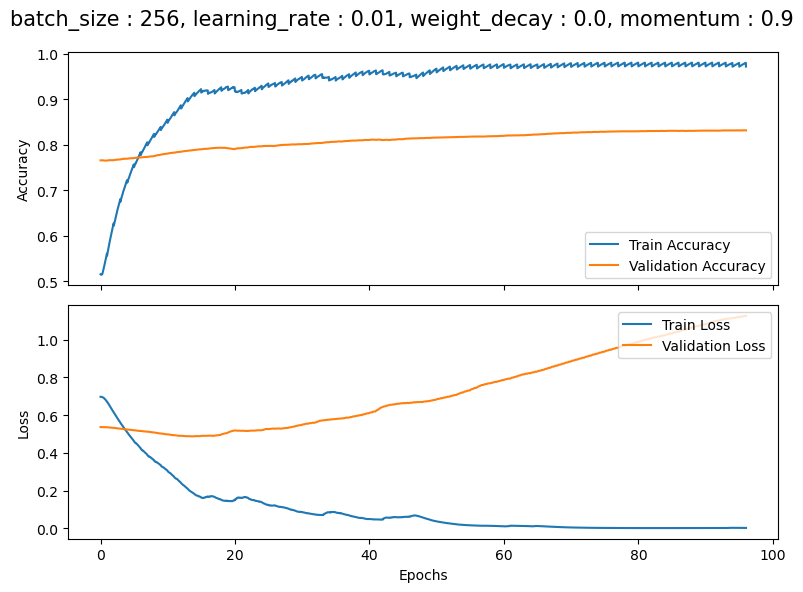

Train accuracy:  97.4
Validation accuracy:  83.2



Combination 40 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.9



Epoch: 1/6, Train loss:  0.526, Train accuracy:  75.3%: 100%|██████████| 563/563 [00:04<00:00, 113.61it/s]
Epoch: 1/6, Val loss:  0.445, Val accuracy:  81.1%: 100%|██████████| 63/63 [00:00<00:00, 416.63it/s]


Epoch: 2/6, Train loss:  0.421, Train accuracy:  81.9%: 100%|██████████| 563/563 [00:08<00:00, 69.25it/s]
Epoch: 2/6, Val loss:  0.417, Val accuracy:  82.3%: 100%|██████████| 63/63 [00:00<00:00, 307.19it/s]


Epoch: 3/6, Train loss:  0.374, Train accuracy:  84.3%: 100%|██████████| 563/563 [00:08<00:00, 66.20it/s]
Epoch: 3/6, Val loss:  0.406, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 295.24it/s]


Epoch: 4/6, Train loss:  0.337, Train accuracy:  86.3%: 100%|██████████| 563/563 [00:09<00:00, 59.74it/s]
Epoch: 4/6, Val loss:  0.398, Val accuracy:  83.7%: 100%|██████████| 63/63 [00:00<00:00, 310.02it/s]


Epoch: 5/6, Train loss:  0.305, Train accuracy:  88.1%: 100%|██████████| 563/563 [00:09<00:00, 60.21it/s]
Epoch: 5/6, Val loss:  0.398, Val accuracy:  83.8%: 100%|██████████| 63/63 [00:00<00:00, 350.77it/s]


Epoch: 6/6, Train loss:  0.273, Train accuracy:  89.6%: 100%|██████████| 563/563 [00:08<00:00, 63.54it/s]
Epoch: 6/6, Val loss:  0.400, Val accuracy:  83.9%: 100%|██████████| 63/63 [00:00<00:00, 324.54it/s]


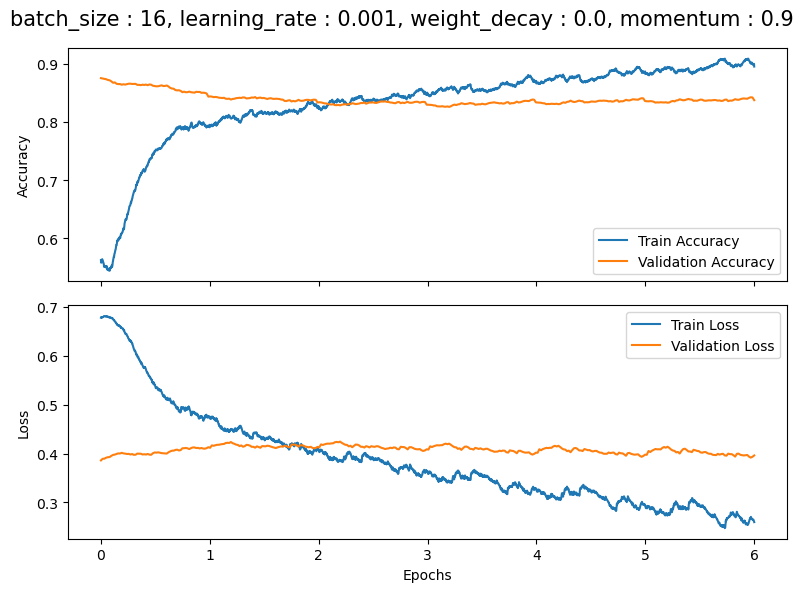

Train accuracy:  91.2
Validation accuracy:  83.9



Combination 41 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.9



Epoch: 1/24, Train loss:  0.638, Train accuracy:  64.0%: 100%|██████████| 141/141 [00:00<00:00, 196.99it/s]
Epoch: 1/24, Val loss:  0.576, Val accuracy:  72.6%: 100%|██████████| 16/16 [00:00<00:00, 437.14it/s]


Epoch: 2/24, Train loss:  0.519, Train accuracy:  77.3%: 100%|██████████| 141/141 [00:01<00:00, 137.17it/s]
Epoch: 2/24, Val loss:  0.485, Val accuracy:  76.7%: 100%|██████████| 16/16 [00:00<00:00, 408.97it/s]


Epoch: 3/24, Train loss:  0.469, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:01<00:00, 135.99it/s]
Epoch: 3/24, Val loss:  0.457, Val accuracy:  79.0%: 100%|██████████| 16/16 [00:00<00:00, 413.84it/s]


Epoch: 4/24, Train loss:  0.440, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:01<00:00, 129.55it/s]
Epoch: 4/24, Val loss:  0.440, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 419.54it/s]


Epoch: 5/24, Train loss:  0.414, Train accuracy:  82.4%: 100%|██████████| 141/141 [00:01<00:00, 131.71it/s]
Epoch: 5/24, Val loss:  0.433, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 425.46it/s]


Epoch: 6/24, Train loss:  0.392, Train accuracy:  83.1%: 100%|██████████| 141/141 [00:00<00:00, 150.75it/s]
Epoch: 6/24, Val loss:  0.430, Val accuracy:  80.0%: 100%|██████████| 16/16 [00:00<00:00, 392.26it/s]


Epoch: 7/24, Train loss:  0.372, Train accuracy:  84.3%: 100%|██████████| 141/141 [00:01<00:00, 139.92it/s]
Epoch: 7/24, Val loss:  0.423, Val accuracy:  80.8%: 100%|██████████| 16/16 [00:00<00:00, 425.05it/s]


Epoch: 8/24, Train loss:  0.351, Train accuracy:  85.4%: 100%|██████████| 141/141 [00:00<00:00, 154.37it/s]
Epoch: 8/24, Val loss:  0.411, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 430.92it/s]


Epoch: 9/24, Train loss:  0.332, Train accuracy:  86.5%: 100%|██████████| 141/141 [00:01<00:00, 139.28it/s]
Epoch: 9/24, Val loss:  0.404, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 430.88it/s]


Epoch: 10/24, Train loss:  0.312, Train accuracy:  87.5%: 100%|██████████| 141/141 [00:00<00:00, 155.88it/s]
Epoch: 10/24, Val loss:  0.402, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 431.17it/s]


Epoch: 11/24, Train loss:  0.291, Train accuracy:  88.6%: 100%|██████████| 141/141 [00:00<00:00, 145.27it/s]
Epoch: 11/24, Val loss:  0.406, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 430.92it/s]


Epoch: 12/24, Train loss:  0.271, Train accuracy:  89.5%: 100%|██████████| 141/141 [00:00<00:00, 149.48it/s]
Epoch: 12/24, Val loss:  0.407, Val accuracy:  81.7%: 100%|██████████| 16/16 [00:00<00:00, 430.95it/s]


Epoch: 13/24, Train loss:  0.251, Train accuracy:  90.6%: 100%|██████████| 141/141 [00:01<00:00, 136.10it/s]
Epoch: 13/24, Val loss:  0.396, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 413.58it/s]


Epoch: 14/24, Train loss:  0.229, Train accuracy:  91.7%: 100%|██████████| 141/141 [00:00<00:00, 146.56it/s]
Epoch: 14/24, Val loss:  0.388, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 424.82it/s]


Epoch: 15/24, Train loss:  0.208, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:00<00:00, 143.97it/s]
Epoch: 15/24, Val loss:  0.389, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 418.58it/s]


Epoch: 16/24, Train loss:  0.187, Train accuracy:  93.6%: 100%|██████████| 141/141 [00:01<00:00, 140.64it/s]
Epoch: 16/24, Val loss:  0.395, Val accuracy:  83.8%: 100%|██████████| 16/16 [00:00<00:00, 146.21it/s]


Epoch: 17/24, Train loss:  0.168, Train accuracy:  94.6%: 100%|██████████| 141/141 [00:00<00:00, 154.18it/s]
Epoch: 17/24, Val loss:  0.401, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 428.07it/s]


Epoch: 18/24, Train loss:  0.151, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:00<00:00, 155.24it/s]
Epoch: 18/24, Val loss:  0.411, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 408.96it/s]


Epoch: 19/24, Train loss:  0.136, Train accuracy:  95.8%: 100%|██████████| 141/141 [00:00<00:00, 150.72it/s]
Epoch: 19/24, Val loss:  0.422, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 419.65it/s]


Epoch: 20/24, Train loss:  0.123, Train accuracy:  96.3%: 100%|██████████| 141/141 [00:01<00:00, 132.02it/s]
Epoch: 20/24, Val loss:  0.437, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 418.14it/s]


Epoch: 21/24, Train loss:  0.110, Train accuracy:  96.8%: 100%|██████████| 141/141 [00:01<00:00, 136.87it/s]
Epoch: 21/24, Val loss:  0.465, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 396.86it/s]


Epoch: 22/24, Train loss:  0.101, Train accuracy:  97.1%: 100%|██████████| 141/141 [00:00<00:00, 150.72it/s]
Epoch: 22/24, Val loss:  0.502, Val accuracy:  81.3%: 100%|██████████| 16/16 [00:00<00:00, 350.77it/s]


Epoch: 23/24, Train loss:  0.095, Train accuracy:  97.1%: 100%|██████████| 141/141 [00:00<00:00, 143.48it/s]
Epoch: 23/24, Val loss:  0.578, Val accuracy:  80.0%: 100%|██████████| 16/16 [00:00<00:00, 419.69it/s]


Epoch: 24/24, Train loss:  0.108, Train accuracy:  96.4%: 100%|██████████| 141/141 [00:00<00:00, 166.69it/s]
Epoch: 24/24, Val loss:  0.554, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 430.21it/s]


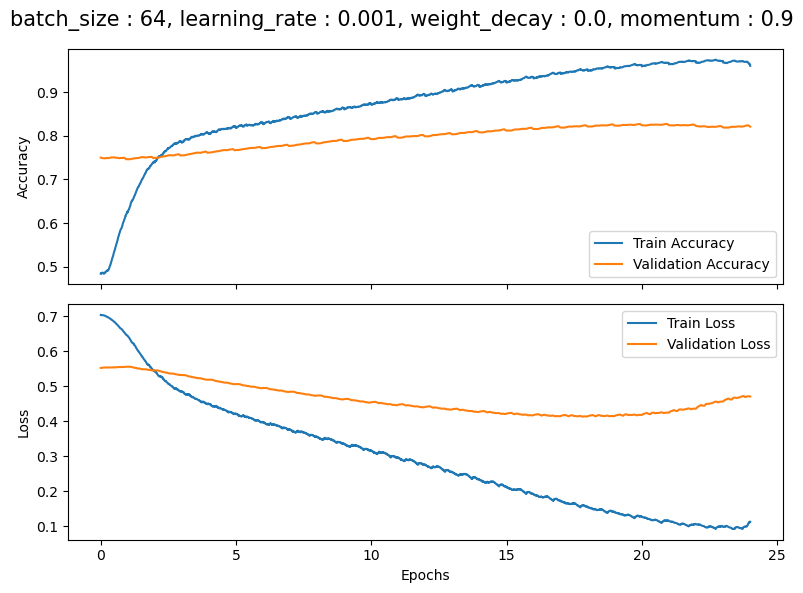

Train accuracy:  95.5
Validation accuracy:  83.2



Combination 42 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.0, momentum : 0.9



Epoch: 1/96, Train loss:  0.687, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 117.31it/s]
Epoch: 1/96, Val loss:  0.666, Val accuracy:  53.5%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 2/96, Train loss:  0.655, Train accuracy:  61.1%: 100%|██████████| 36/36 [00:00<00:00, 114.85it/s]
Epoch: 2/96, Val loss:  0.635, Val accuracy:  67.6%: 100%|██████████| 4/4 [00:00<00:00, 177.22it/s]


Epoch: 3/96, Train loss:  0.620, Train accuracy:  69.4%: 100%|██████████| 36/36 [00:00<00:00, 111.16it/s]
Epoch: 3/96, Val loss:  0.603, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 185.06it/s]


Epoch: 4/96, Train loss:  0.586, Train accuracy:  71.8%: 100%|██████████| 36/36 [00:00<00:00, 117.17it/s]
Epoch: 4/96, Val loss:  0.571, Val accuracy:  72.5%: 100%|██████████| 4/4 [00:00<00:00, 176.51it/s]


Epoch: 5/96, Train loss:  0.553, Train accuracy:  73.9%: 100%|██████████| 36/36 [00:00<00:00, 115.99it/s]
Epoch: 5/96, Val loss:  0.541, Val accuracy:  74.3%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 6/96, Train loss:  0.524, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 114.06it/s]
Epoch: 6/96, Val loss:  0.514, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 183.53it/s]


Epoch: 7/96, Train loss:  0.502, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 116.49it/s]
Epoch: 7/96, Val loss:  0.495, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 169.13it/s]


Epoch: 8/96, Train loss:  0.487, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 111.72it/s]
Epoch: 8/96, Val loss:  0.482, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 180.84it/s]


Epoch: 9/96, Train loss:  0.476, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 114.52it/s]
Epoch: 9/96, Val loss:  0.473, Val accuracy:  77.9%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 10/96, Train loss:  0.467, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 110.21it/s]
Epoch: 10/96, Val loss:  0.466, Val accuracy:  78.5%: 100%|██████████| 4/4 [00:00<00:00, 175.08it/s]


Epoch: 11/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 114.89it/s]
Epoch: 11/96, Val loss:  0.460, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 181.43it/s]


Epoch: 12/96, Train loss:  0.450, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 114.17it/s]
Epoch: 12/96, Val loss:  0.455, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 13/96, Train loss:  0.442, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 115.30it/s]
Epoch: 13/96, Val loss:  0.451, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 181.60it/s]


Epoch: 14/96, Train loss:  0.433, Train accuracy:  79.9%: 100%|██████████| 36/36 [00:00<00:00, 116.49it/s]
Epoch: 14/96, Val loss:  0.447, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 184.88it/s]


Epoch: 15/96, Train loss:  0.425, Train accuracy:  80.3%: 100%|██████████| 36/36 [00:00<00:00, 114.69it/s]
Epoch: 15/96, Val loss:  0.443, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch: 16/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 116.89it/s]
Epoch: 16/96, Val loss:  0.440, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 189.94it/s]


Epoch: 17/96, Train loss:  0.409, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 94.20it/s]
Epoch: 17/96, Val loss:  0.437, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 190.22it/s]


Epoch: 18/96, Train loss:  0.402, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 116.48it/s]
Epoch: 18/96, Val loss:  0.434, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 19/96, Train loss:  0.394, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 114.11it/s]
Epoch: 19/96, Val loss:  0.431, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 194.93it/s]


Epoch: 20/96, Train loss:  0.387, Train accuracy:  81.9%: 100%|██████████| 36/36 [00:00<00:00, 114.24it/s]
Epoch: 20/96, Val loss:  0.428, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 189.60it/s]


Epoch: 21/96, Train loss:  0.380, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 21/96, Val loss:  0.425, Val accuracy:  80.6%: 100%|██████████| 4/4 [00:00<00:00, 181.71it/s]


Epoch: 22/96, Train loss:  0.373, Train accuracy:  82.6%: 100%|██████████| 36/36 [00:00<00:00, 115.63it/s]
Epoch: 22/96, Val loss:  0.422, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch: 23/96, Train loss:  0.365, Train accuracy:  83.0%: 100%|██████████| 36/36 [00:00<00:00, 113.99it/s]
Epoch: 23/96, Val loss:  0.420, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch: 24/96, Train loss:  0.358, Train accuracy:  83.5%: 100%|██████████| 36/36 [00:00<00:00, 116.68it/s]
Epoch: 24/96, Val loss:  0.417, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 190.01it/s]


Epoch: 25/96, Train loss:  0.351, Train accuracy:  83.8%: 100%|██████████| 36/36 [00:00<00:00, 112.04it/s]
Epoch: 25/96, Val loss:  0.415, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 190.12it/s]


Epoch: 26/96, Train loss:  0.344, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 115.03it/s]
Epoch: 26/96, Val loss:  0.413, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]


Epoch: 27/96, Train loss:  0.337, Train accuracy:  84.3%: 100%|██████████| 36/36 [00:00<00:00, 113.93it/s]
Epoch: 27/96, Val loss:  0.411, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch: 28/96, Train loss:  0.330, Train accuracy:  84.6%: 100%|██████████| 36/36 [00:00<00:00, 111.42it/s]
Epoch: 28/96, Val loss:  0.409, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 29/96, Train loss:  0.323, Train accuracy:  85.0%: 100%|██████████| 36/36 [00:00<00:00, 115.24it/s]
Epoch: 29/96, Val loss:  0.407, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 185.28it/s]


Epoch: 30/96, Train loss:  0.316, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 113.07it/s]
Epoch: 30/96, Val loss:  0.406, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


Epoch: 31/96, Train loss:  0.309, Train accuracy:  85.6%: 100%|██████████| 36/36 [00:00<00:00, 114.45it/s]
Epoch: 31/96, Val loss:  0.404, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 184.62it/s]


Epoch: 32/96, Train loss:  0.302, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 111.93it/s]
Epoch: 32/96, Val loss:  0.403, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 189.77it/s]


Epoch: 33/96, Train loss:  0.295, Train accuracy:  86.2%: 100%|██████████| 36/36 [00:00<00:00, 114.58it/s]
Epoch: 33/96, Val loss:  0.401, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 176.99it/s]


Epoch: 34/96, Train loss:  0.288, Train accuracy:  86.7%: 100%|██████████| 36/36 [00:00<00:00, 112.42it/s]
Epoch: 34/96, Val loss:  0.399, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 179.55it/s]


Epoch: 35/96, Train loss:  0.280, Train accuracy:  87.2%: 100%|██████████| 36/36 [00:00<00:00, 114.71it/s]
Epoch: 35/96, Val loss:  0.396, Val accuracy:  81.9%: 100%|██████████| 4/4 [00:00<00:00, 181.21it/s]


Epoch: 36/96, Train loss:  0.273, Train accuracy:  87.5%: 100%|██████████| 36/36 [00:00<00:00, 116.39it/s]
Epoch: 36/96, Val loss:  0.392, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 178.01it/s]


Epoch: 37/96, Train loss:  0.265, Train accuracy:  88.0%: 100%|██████████| 36/36 [00:00<00:00, 110.67it/s]
Epoch: 37/96, Val loss:  0.390, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 177.18it/s]


Epoch: 38/96, Train loss:  0.257, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 116.15it/s]
Epoch: 38/96, Val loss:  0.387, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 189.91it/s]


Epoch: 39/96, Train loss:  0.249, Train accuracy:  88.7%: 100%|██████████| 36/36 [00:00<00:00, 113.36it/s]
Epoch: 39/96, Val loss:  0.386, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 136.96it/s]


Epoch: 40/96, Train loss:  0.242, Train accuracy:  89.1%: 100%|██████████| 36/36 [00:00<00:00, 113.51it/s]
Epoch: 40/96, Val loss:  0.384, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.15it/s]


Epoch: 41/96, Train loss:  0.234, Train accuracy:  89.6%: 100%|██████████| 36/36 [00:00<00:00, 116.62it/s]
Epoch: 41/96, Val loss:  0.383, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.23it/s]


Epoch: 42/96, Train loss:  0.226, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 113.94it/s]
Epoch: 42/96, Val loss:  0.383, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 43/96, Train loss:  0.219, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 94.94it/s] 
Epoch: 43/96, Val loss:  0.383, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 190.11it/s]


Epoch: 44/96, Train loss:  0.211, Train accuracy:  90.7%: 100%|██████████| 36/36 [00:00<00:00, 115.07it/s]
Epoch: 44/96, Val loss:  0.383, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch: 45/96, Train loss:  0.203, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 114.81it/s]
Epoch: 45/96, Val loss:  0.383, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 46/96, Train loss:  0.195, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 111.70it/s]
Epoch: 46/96, Val loss:  0.383, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 184.98it/s]


Epoch: 47/96, Train loss:  0.188, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 114.84it/s]
Epoch: 47/96, Val loss:  0.384, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s]


Epoch: 48/96, Train loss:  0.180, Train accuracy:  92.1%: 100%|██████████| 36/36 [00:00<00:00, 115.39it/s]
Epoch: 48/96, Val loss:  0.385, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 177.29it/s]


Epoch: 49/96, Train loss:  0.172, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 114.02it/s]
Epoch: 49/96, Val loss:  0.387, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 158.60it/s]


Epoch: 50/96, Train loss:  0.164, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 112.09it/s]
Epoch: 50/96, Val loss:  0.388, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 51/96, Train loss:  0.157, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 112.20it/s]
Epoch: 51/96, Val loss:  0.390, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 185.36it/s]


Epoch: 52/96, Train loss:  0.149, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 114.46it/s]
Epoch: 52/96, Val loss:  0.393, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 172.27it/s]


Epoch: 53/96, Train loss:  0.142, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 115.01it/s]
Epoch: 53/96, Val loss:  0.395, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 156.43it/s]


Epoch: 54/96, Train loss:  0.135, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 109.91it/s]
Epoch: 54/96, Val loss:  0.398, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 55/96, Train loss:  0.128, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 116.55it/s]
Epoch: 55/96, Val loss:  0.401, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 56/96, Train loss:  0.121, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 112.52it/s]
Epoch: 56/96, Val loss:  0.404, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 185.05it/s]


Epoch: 57/96, Train loss:  0.115, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 116.20it/s]
Epoch: 57/96, Val loss:  0.407, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 181.03it/s]


Epoch: 58/96, Train loss:  0.108, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 115.44it/s]
Epoch: 58/96, Val loss:  0.411, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 59/96, Train loss:  0.102, Train accuracy:  95.4%: 100%|██████████| 36/36 [00:00<00:00, 113.87it/s]
Epoch: 59/96, Val loss:  0.416, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 185.53it/s]


Epoch: 60/96, Train loss:  0.097, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 114.58it/s]
Epoch: 60/96, Val loss:  0.421, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 186.03it/s]


Epoch: 61/96, Train loss:  0.091, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 112.51it/s]
Epoch: 61/96, Val loss:  0.426, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 176.09it/s]


Epoch: 62/96, Train loss:  0.086, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 115.83it/s]
Epoch: 62/96, Val loss:  0.432, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 190.03it/s]


Epoch: 63/96, Train loss:  0.081, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 116.49it/s]
Epoch: 63/96, Val loss:  0.438, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s]


Epoch: 64/96, Train loss:  0.076, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 109.22it/s]
Epoch: 64/96, Val loss:  0.445, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 185.31it/s]


Epoch: 65/96, Train loss:  0.072, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 116.21it/s]
Epoch: 65/96, Val loss:  0.451, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 191.15it/s]


Epoch: 66/96, Train loss:  0.068, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 113.66it/s]
Epoch: 66/96, Val loss:  0.459, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 174.96it/s]


Epoch: 67/96, Train loss:  0.064, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 114.47it/s]
Epoch: 67/96, Val loss:  0.468, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 68/96, Train loss:  0.061, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 112.30it/s]
Epoch: 68/96, Val loss:  0.476, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 69/96, Train loss:  0.057, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 93.02it/s] 
Epoch: 69/96, Val loss:  0.485, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 177.35it/s]


Epoch: 70/96, Train loss:  0.055, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 115.72it/s]
Epoch: 70/96, Val loss:  0.493, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 189.52it/s]


Epoch: 71/96, Train loss:  0.052, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.62it/s]
Epoch: 71/96, Val loss:  0.503, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 183.50it/s]


Epoch: 72/96, Train loss:  0.050, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 117.45it/s]
Epoch: 72/96, Val loss:  0.511, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 188.40it/s]


Epoch: 73/96, Train loss:  0.049, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 117.08it/s]
Epoch: 73/96, Val loss:  0.521, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 187.69it/s]


Epoch: 74/96, Train loss:  0.047, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.25it/s]
Epoch: 74/96, Val loss:  0.527, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 189.49it/s]


Epoch: 75/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 116.45it/s]
Epoch: 75/96, Val loss:  0.535, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 76/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 115.02it/s]
Epoch: 76/96, Val loss:  0.543, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 173.59it/s]


Epoch: 77/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 115.01it/s]
Epoch: 77/96, Val loss:  0.550, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 175.34it/s]


Epoch: 78/96, Train loss:  0.045, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 116.54it/s]
Epoch: 78/96, Val loss:  0.550, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch: 79/96, Train loss:  0.046, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 113.44it/s]
Epoch: 79/96, Val loss:  0.547, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 180.31it/s]


Epoch: 80/96, Train loss:  0.046, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 115.59it/s]
Epoch: 80/96, Val loss:  0.547, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 177.12it/s]


Epoch: 81/96, Train loss:  0.047, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 112.18it/s]
Epoch: 81/96, Val loss:  0.547, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 82/96, Train loss:  0.050, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 111.52it/s]
Epoch: 82/96, Val loss:  0.553, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 185.16it/s]


Epoch: 83/96, Train loss:  0.052, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 111.92it/s]
Epoch: 83/96, Val loss:  0.573, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 173.58it/s]


Epoch: 84/96, Train loss:  0.057, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 116.53it/s]
Epoch: 84/96, Val loss:  0.600, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 184.35it/s]


Epoch: 85/96, Train loss:  0.081, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 116.93it/s]
Epoch: 85/96, Val loss:  0.731, Val accuracy:  78.0%: 100%|██████████| 4/4 [00:00<00:00, 166.29it/s]


Epoch: 86/96, Train loss:  0.086, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 113.79it/s]
Epoch: 86/96, Val loss:  0.641, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 178.31it/s]


Epoch: 87/96, Train loss:  0.113, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 115.13it/s]
Epoch: 87/96, Val loss:  0.698, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s]


Epoch: 88/96, Train loss:  0.119, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 113.60it/s]
Epoch: 88/96, Val loss:  0.923, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 185.62it/s]


Epoch: 89/96, Train loss:  0.157, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 114.40it/s]
Epoch: 89/96, Val loss:  0.647, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 180.40it/s]


Epoch: 90/96, Train loss:  0.109, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 112.77it/s]
Epoch: 90/96, Val loss:  1.074, Val accuracy:  74.7%: 100%|██████████| 4/4 [00:00<00:00, 194.17it/s]


Epoch: 91/96, Train loss:  0.166, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 116.69it/s]
Epoch: 91/96, Val loss:  0.835, Val accuracy:  77.8%: 100%|██████████| 4/4 [00:00<00:00, 188.41it/s]


Epoch: 92/96, Train loss:  0.146, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 115.06it/s]
Epoch: 92/96, Val loss:  1.107, Val accuracy:  73.5%: 100%|██████████| 4/4 [00:00<00:00, 159.79it/s]


Epoch: 93/96, Train loss:  0.237, Train accuracy:  90.2%: 100%|██████████| 36/36 [00:00<00:00, 116.38it/s]
Epoch: 93/96, Val loss:  1.721, Val accuracy:  65.2%: 100%|██████████| 4/4 [00:00<00:00, 184.98it/s]


Epoch: 94/96, Train loss:  0.397, Train accuracy:  87.3%: 100%|██████████| 36/36 [00:00<00:00, 117.68it/s]
Epoch: 94/96, Val loss:  0.586, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 192.42it/s]


Epoch: 95/96, Train loss:  0.104, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 114.07it/s]
Epoch: 95/96, Val loss:  0.491, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 96/96, Train loss:  0.053, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 95.68it/s] 
Epoch: 96/96, Val loss:  0.494, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 177.32it/s]


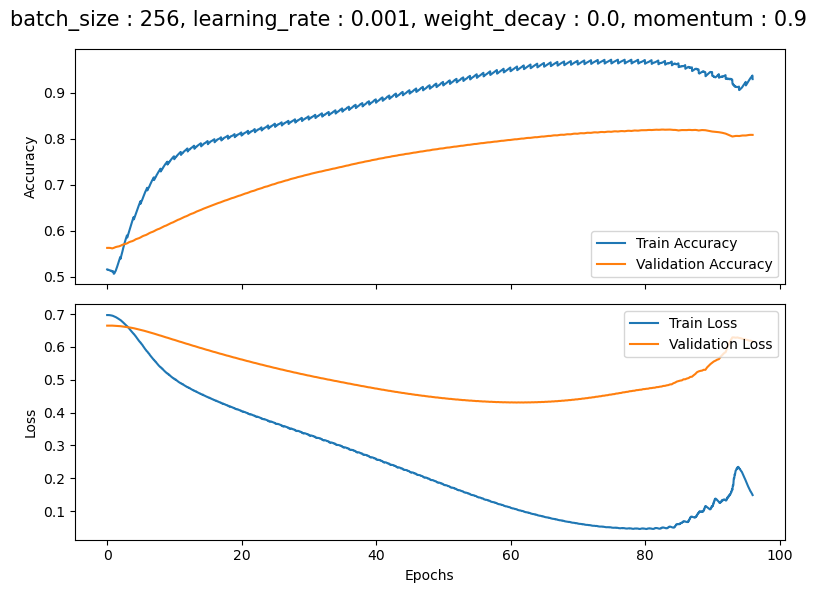

Train accuracy:  96.5
Validation accuracy:  84.0



Combination 43 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.9



Epoch: 1/6, Train loss:  0.474, Train accuracy:  79.2%: 100%|██████████| 563/563 [00:05<00:00, 97.62it/s] 
Epoch: 1/6, Val loss:  0.440, Val accuracy:  80.8%: 100%|██████████| 63/63 [00:00<00:00, 409.34it/s]


Epoch: 2/6, Train loss:  0.402, Train accuracy:  83.5%: 100%|██████████| 563/563 [00:09<00:00, 58.11it/s]
Epoch: 2/6, Val loss:  0.410, Val accuracy:  82.4%: 100%|██████████| 63/63 [00:00<00:00, 323.70it/s]


Epoch: 3/6, Train loss:  0.365, Train accuracy:  85.0%: 100%|██████████| 563/563 [00:09<00:00, 60.86it/s]
Epoch: 3/6, Val loss:  0.423, Val accuracy:  83.2%: 100%|██████████| 63/63 [00:00<00:00, 333.87it/s]


Epoch: 4/6, Train loss:  0.332, Train accuracy:  86.8%: 100%|██████████| 563/563 [00:08<00:00, 65.04it/s]
Epoch: 4/6, Val loss:  0.438, Val accuracy:  83.0%: 100%|██████████| 63/63 [00:00<00:00, 389.55it/s]


Epoch: 5/6, Train loss:  0.306, Train accuracy:  87.8%: 100%|██████████| 563/563 [00:08<00:00, 66.81it/s]
Epoch: 5/6, Val loss:  0.471, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 364.69it/s]


Epoch: 6/6, Train loss:  0.286, Train accuracy:  88.7%: 100%|██████████| 563/563 [00:08<00:00, 63.30it/s]
Epoch: 6/6, Val loss:  0.447, Val accuracy:  83.2%: 100%|██████████| 63/63 [00:00<00:00, 306.85it/s]


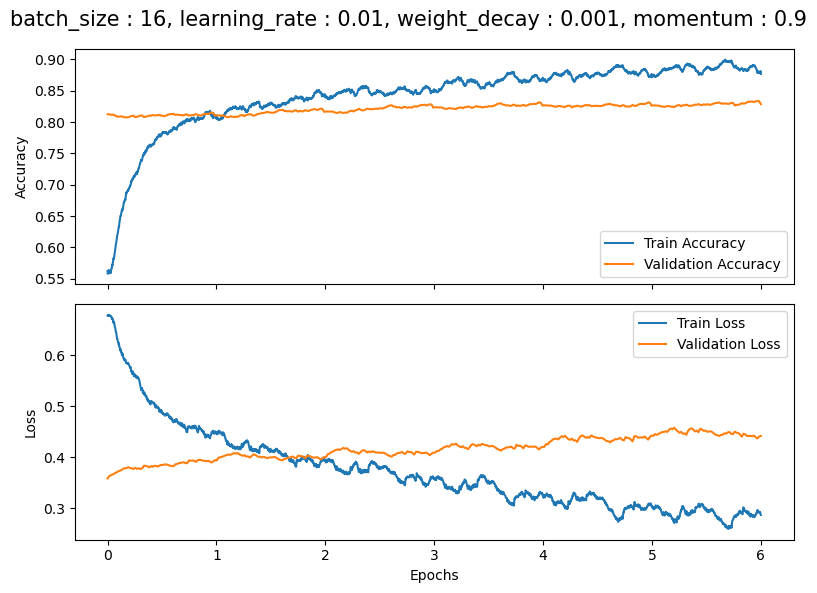

Train accuracy:  89.5
Validation accuracy:  83.2



Combination 44 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.9



Epoch: 1/24, Train loss:  0.505, Train accuracy:  75.8%: 100%|██████████| 141/141 [00:00<00:00, 196.80it/s]
Epoch: 1/24, Val loss:  0.446, Val accuracy:  78.8%: 100%|██████████| 16/16 [00:00<00:00, 461.62it/s]


Epoch: 2/24, Train loss:  0.407, Train accuracy:  82.8%: 100%|██████████| 141/141 [00:00<00:00, 147.91it/s]
Epoch: 2/24, Val loss:  0.396, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 424.33it/s]


Epoch: 3/24, Train loss:  0.358, Train accuracy:  85.2%: 100%|██████████| 141/141 [00:00<00:00, 144.61it/s]
Epoch: 3/24, Val loss:  0.388, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 413.90it/s]


Epoch: 4/24, Train loss:  0.325, Train accuracy:  86.6%: 100%|██████████| 141/141 [00:01<00:00, 140.58it/s]
Epoch: 4/24, Val loss:  0.399, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 433.54it/s]


Epoch: 5/24, Train loss:  0.294, Train accuracy:  88.2%: 100%|██████████| 141/141 [00:00<00:00, 155.64it/s]
Epoch: 5/24, Val loss:  0.415, Val accuracy:  82.5%: 100%|██████████| 16/16 [00:00<00:00, 423.66it/s]


Epoch: 6/24, Train loss:  0.265, Train accuracy:  89.6%: 100%|██████████| 141/141 [00:01<00:00, 140.14it/s]
Epoch: 6/24, Val loss:  0.415, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 414.39it/s]


Epoch: 7/24, Train loss:  0.236, Train accuracy:  91.1%: 100%|██████████| 141/141 [00:00<00:00, 143.88it/s]
Epoch: 7/24, Val loss:  0.435, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 431.59it/s]


Epoch: 8/24, Train loss:  0.223, Train accuracy:  91.5%: 100%|██████████| 141/141 [00:00<00:00, 142.64it/s]
Epoch: 8/24, Val loss:  0.453, Val accuracy:  81.3%: 100%|██████████| 16/16 [00:00<00:00, 416.86it/s]


Epoch: 9/24, Train loss:  0.200, Train accuracy:  92.4%: 100%|██████████| 141/141 [00:00<00:00, 150.69it/s]
Epoch: 9/24, Val loss:  0.504, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 415.83it/s]


Epoch: 10/24, Train loss:  0.197, Train accuracy:  92.2%: 100%|██████████| 141/141 [00:00<00:00, 149.23it/s]
Epoch: 10/24, Val loss:  0.430, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 430.97it/s]


Epoch: 11/24, Train loss:  0.167, Train accuracy:  93.6%: 100%|██████████| 141/141 [00:00<00:00, 144.47it/s]
Epoch: 11/24, Val loss:  0.496, Val accuracy:  82.8%: 100%|██████████| 16/16 [00:00<00:00, 336.41it/s]


Epoch: 12/24, Train loss:  0.158, Train accuracy:  93.8%: 100%|██████████| 141/141 [00:00<00:00, 154.06it/s]
Epoch: 12/24, Val loss:  0.501, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 370.55it/s]


Epoch: 13/24, Train loss:  0.163, Train accuracy:  93.5%: 100%|██████████| 141/141 [00:00<00:00, 156.47it/s]
Epoch: 13/24, Val loss:  0.646, Val accuracy:  76.5%: 100%|██████████| 16/16 [00:00<00:00, 424.60it/s]


Epoch: 14/24, Train loss:  0.141, Train accuracy:  94.4%: 100%|██████████| 141/141 [00:00<00:00, 147.24it/s]
Epoch: 14/24, Val loss:  0.537, Val accuracy:  80.0%: 100%|██████████| 16/16 [00:00<00:00, 413.88it/s]


Epoch: 15/24, Train loss:  0.118, Train accuracy:  95.5%: 100%|██████████| 141/141 [00:00<00:00, 155.63it/s]
Epoch: 15/24, Val loss:  0.528, Val accuracy:  81.7%: 100%|██████████| 16/16 [00:00<00:00, 421.43it/s]


Epoch: 16/24, Train loss:  0.110, Train accuracy:  95.9%: 100%|██████████| 141/141 [00:00<00:00, 147.59it/s]
Epoch: 16/24, Val loss:  0.606, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 431.76it/s]


Epoch: 17/24, Train loss:  0.123, Train accuracy:  94.9%: 100%|██████████| 141/141 [00:00<00:00, 154.46it/s]
Epoch: 17/24, Val loss:  0.513, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 413.93it/s]


Epoch: 18/24, Train loss:  0.119, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:01<00:00, 131.47it/s]
Epoch: 18/24, Val loss:  0.513, Val accuracy:  81.5%: 100%|██████████| 16/16 [00:00<00:00, 418.63it/s]


Epoch: 19/24, Train loss:  0.117, Train accuracy:  95.2%: 100%|██████████| 141/141 [00:01<00:00, 125.34it/s]
Epoch: 19/24, Val loss:  0.534, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 398.61it/s]


Epoch: 20/24, Train loss:  0.109, Train accuracy:  95.7%: 100%|██████████| 141/141 [00:01<00:00, 132.76it/s]
Epoch: 20/24, Val loss:  0.562, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 408.95it/s]


Epoch: 21/24, Train loss:  0.098, Train accuracy:  95.9%: 100%|██████████| 141/141 [00:01<00:00, 133.09it/s]
Epoch: 21/24, Val loss:  0.635, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 410.42it/s]


Epoch: 22/24, Train loss:  0.090, Train accuracy:  96.5%: 100%|██████████| 141/141 [00:00<00:00, 143.98it/s]
Epoch: 22/24, Val loss:  0.650, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 438.76it/s]


Epoch: 23/24, Train loss:  0.072, Train accuracy:  97.1%: 100%|██████████| 141/141 [00:00<00:00, 142.21it/s]
Epoch: 23/24, Val loss:  0.658, Val accuracy:  83.8%: 100%|██████████| 16/16 [00:00<00:00, 425.69it/s]


Epoch: 24/24, Train loss:  0.067, Train accuracy:  97.2%: 100%|██████████| 141/141 [00:00<00:00, 144.96it/s]
Epoch: 24/24, Val loss:  0.768, Val accuracy:  82.3%: 100%|██████████| 16/16 [00:00<00:00, 419.24it/s]


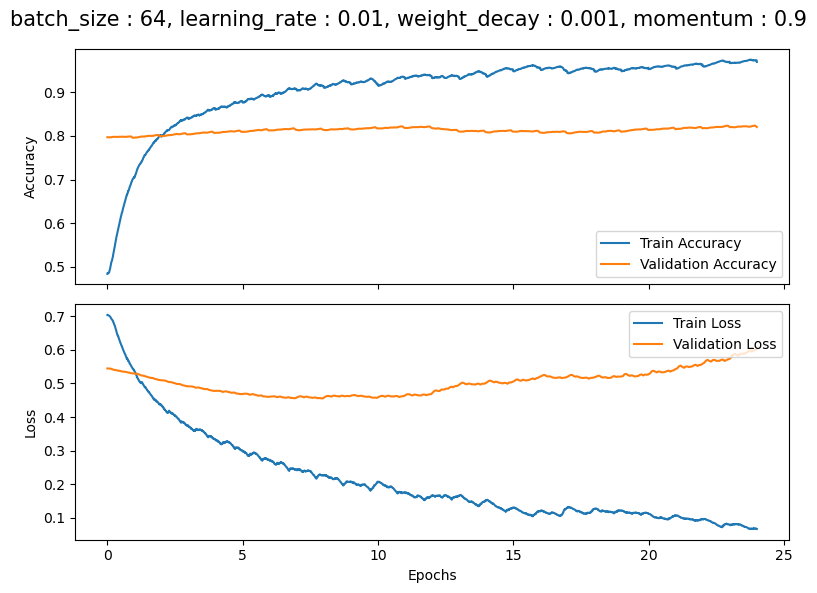

Train accuracy:  95.8
Validation accuracy:  82.3



Combination 45 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 0.001, momentum : 0.9



Epoch: 1/96, Train loss:  0.618, Train accuracy:  64.5%: 100%|██████████| 36/36 [00:00<00:00, 114.07it/s]
Epoch: 1/96, Val loss:  0.522, Val accuracy:  74.6%: 100%|██████████| 4/4 [00:00<00:00, 189.96it/s]


Epoch: 2/96, Train loss:  0.484, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 113.99it/s]
Epoch: 2/96, Val loss:  0.459, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 185.35it/s]


Epoch: 3/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 112.45it/s]
Epoch: 3/96, Val loss:  0.425, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 166.28it/s]


Epoch: 4/96, Train loss:  0.391, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 110.97it/s]
Epoch: 4/96, Val loss:  0.421, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 177.23it/s]


Epoch: 5/96, Train loss:  0.359, Train accuracy:  83.1%: 100%|██████████| 36/36 [00:00<00:00, 113.58it/s]
Epoch: 5/96, Val loss:  0.432, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 177.05it/s]


Epoch: 6/96, Train loss:  0.338, Train accuracy:  83.9%: 100%|██████████| 36/36 [00:00<00:00, 106.49it/s]
Epoch: 6/96, Val loss:  0.407, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 180.60it/s]


Epoch: 7/96, Train loss:  0.310, Train accuracy:  85.4%: 100%|██████████| 36/36 [00:00<00:00, 115.15it/s]
Epoch: 7/96, Val loss:  0.432, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 171.08it/s]


Epoch: 8/96, Train loss:  0.297, Train accuracy:  86.0%: 100%|██████████| 36/36 [00:00<00:00, 110.82it/s]
Epoch: 8/96, Val loss:  0.420, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 189.77it/s]


Epoch: 9/96, Train loss:  0.281, Train accuracy:  86.9%: 100%|██████████| 36/36 [00:00<00:00, 113.37it/s]
Epoch: 9/96, Val loss:  0.381, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 10/96, Train loss:  0.245, Train accuracy:  88.5%: 100%|██████████| 36/36 [00:00<00:00, 115.60it/s]
Epoch: 10/96, Val loss:  0.398, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 183.81it/s]


Epoch: 11/96, Train loss:  0.204, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 111.25it/s]
Epoch: 11/96, Val loss:  0.385, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 190.24it/s]


Epoch: 12/96, Train loss:  0.179, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 112.61it/s]
Epoch: 12/96, Val loss:  0.404, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 173.43it/s]


Epoch: 13/96, Train loss:  0.146, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 110.39it/s]
Epoch: 13/96, Val loss:  0.429, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 176.84it/s]


Epoch: 14/96, Train loss:  0.121, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 113.40it/s]
Epoch: 14/96, Val loss:  0.501, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 181.53it/s]


Epoch: 15/96, Train loss:  0.105, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 113.57it/s]
Epoch: 15/96, Val loss:  0.500, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 144.69it/s]


Epoch: 16/96, Train loss:  0.116, Train accuracy:  93.8%: 100%|██████████| 36/36 [00:00<00:00, 110.62it/s]
Epoch: 16/96, Val loss:  0.706, Val accuracy:  79.1%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 17/96, Train loss:  0.153, Train accuracy:  91.8%: 100%|██████████| 36/36 [00:00<00:00, 110.15it/s]
Epoch: 17/96, Val loss:  0.584, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 185.51it/s]


Epoch: 18/96, Train loss:  0.208, Train accuracy:  89.8%: 100%|██████████| 36/36 [00:00<00:00, 113.95it/s]
Epoch: 18/96, Val loss:  0.452, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 191.52it/s]


Epoch: 19/96, Train loss:  0.129, Train accuracy:  92.9%: 100%|██████████| 36/36 [00:00<00:00, 111.22it/s]
Epoch: 19/96, Val loss:  0.609, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 181.39it/s]


Epoch: 20/96, Train loss:  0.121, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 114.12it/s]
Epoch: 20/96, Val loss:  0.585, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 189.93it/s]


Epoch: 21/96, Train loss:  0.156, Train accuracy:  92.0%: 100%|██████████| 36/36 [00:00<00:00, 113.75it/s]
Epoch: 21/96, Val loss:  0.642, Val accuracy:  77.1%: 100%|██████████| 4/4 [00:00<00:00, 184.92it/s]


Epoch: 22/96, Train loss:  0.183, Train accuracy:  90.6%: 100%|██████████| 36/36 [00:00<00:00, 111.33it/s]
Epoch: 22/96, Val loss:  0.458, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 177.50it/s]


Epoch: 23/96, Train loss:  0.168, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 108.33it/s]
Epoch: 23/96, Val loss:  0.491, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 189.62it/s]


Epoch: 24/96, Train loss:  0.122, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 111.35it/s]
Epoch: 24/96, Val loss:  0.483, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 190.27it/s]


Epoch: 25/96, Train loss:  0.088, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 93.43it/s] 
Epoch: 25/96, Val loss:  0.535, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 173.34it/s]


Epoch: 26/96, Train loss:  0.075, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 112.51it/s]
Epoch: 26/96, Val loss:  0.563, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 173.56it/s]


Epoch: 27/96, Train loss:  0.069, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 114.59it/s]
Epoch: 27/96, Val loss:  0.588, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.32it/s]


Epoch: 28/96, Train loss:  0.061, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 113.32it/s]
Epoch: 28/96, Val loss:  0.733, Val accuracy:  80.3%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 29/96, Train loss:  0.078, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 110.34it/s]
Epoch: 29/96, Val loss:  0.624, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 181.21it/s]


Epoch: 30/96, Train loss:  0.074, Train accuracy:  94.9%: 100%|██████████| 36/36 [00:00<00:00, 114.68it/s]
Epoch: 30/96, Val loss:  0.678, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 31/96, Train loss:  0.099, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 111.12it/s]
Epoch: 31/96, Val loss:  0.707, Val accuracy:  79.9%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 32/96, Train loss:  0.076, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 114.43it/s]
Epoch: 32/96, Val loss:  0.684, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 181.42it/s]


Epoch: 33/96, Train loss:  0.076, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 114.16it/s]
Epoch: 33/96, Val loss:  0.590, Val accuracy:  81.9%: 100%|██████████| 4/4 [00:00<00:00, 168.30it/s]


Epoch: 34/96, Train loss:  0.059, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 111.32it/s]
Epoch: 34/96, Val loss:  0.699, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s]


Epoch: 35/96, Train loss:  0.055, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 111.46it/s]
Epoch: 35/96, Val loss:  0.645, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 36/96, Train loss:  0.030, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 111.50it/s]
Epoch: 36/96, Val loss:  0.778, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 37/96, Train loss:  0.026, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 37/96, Val loss:  0.720, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 185.01it/s]


Epoch: 38/96, Train loss:  0.042, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 113.28it/s]
Epoch: 38/96, Val loss:  0.660, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 159.92it/s]


Epoch: 39/96, Train loss:  0.031, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 111.38it/s]
Epoch: 39/96, Val loss:  1.138, Val accuracy:  77.6%: 100%|██████████| 4/4 [00:00<00:00, 184.75it/s]


Epoch: 40/96, Train loss:  0.068, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s]
Epoch: 40/96, Val loss:  0.657, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 183.29it/s]


Epoch: 41/96, Train loss:  0.028, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 110.92it/s]
Epoch: 41/96, Val loss:  0.764, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 180.56it/s]


Epoch: 42/96, Train loss:  0.022, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 112.25it/s]
Epoch: 42/96, Val loss:  0.783, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 173.72it/s]


Epoch: 43/96, Train loss:  0.047, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 112.00it/s]
Epoch: 43/96, Val loss:  0.689, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 176.84it/s]


Epoch: 44/96, Train loss:  0.031, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 114.01it/s]
Epoch: 44/96, Val loss:  0.703, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 180.32it/s]


Epoch: 45/96, Train loss:  0.028, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 114.15it/s]
Epoch: 45/96, Val loss:  0.854, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 189.74it/s]


Epoch: 46/96, Train loss:  0.041, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 111.68it/s]
Epoch: 46/96, Val loss:  0.791, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 176.96it/s]


Epoch: 47/96, Train loss:  0.039, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 116.41it/s]
Epoch: 47/96, Val loss:  0.721, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 190.23it/s]


Epoch: 48/96, Train loss:  0.042, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 109.86it/s]
Epoch: 48/96, Val loss:  0.850, Val accuracy:  80.2%: 100%|██████████| 4/4 [00:00<00:00, 177.48it/s]


Epoch: 49/96, Train loss:  0.027, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 115.28it/s]
Epoch: 49/96, Val loss:  0.758, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 184.98it/s]


Epoch: 50/96, Train loss:  0.018, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 111.58it/s]
Epoch: 50/96, Val loss:  0.839, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 190.08it/s]


Epoch: 51/96, Train loss:  0.020, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 113.60it/s]
Epoch: 51/96, Val loss:  0.905, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 191.11it/s]


Epoch: 52/96, Train loss:  0.024, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 91.59it/s]
Epoch: 52/96, Val loss:  0.784, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 169.56it/s]


Epoch: 53/96, Train loss:  0.027, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 113.44it/s]
Epoch: 53/96, Val loss:  0.813, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 189.86it/s]


Epoch: 54/96, Train loss:  0.028, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 115.62it/s]
Epoch: 54/96, Val loss:  0.844, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 194.42it/s]


Epoch: 55/96, Train loss:  0.026, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.78it/s]
Epoch: 55/96, Val loss:  0.789, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 186.20it/s]


Epoch: 56/96, Train loss:  0.021, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 110.82it/s]
Epoch: 56/96, Val loss:  0.972, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 171.13it/s]


Epoch: 57/96, Train loss:  0.041, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 112.27it/s]
Epoch: 57/96, Val loss:  0.894, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 189.87it/s]


Epoch: 58/96, Train loss:  0.028, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.94it/s]
Epoch: 58/96, Val loss:  0.836, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 180.00it/s]


Epoch: 59/96, Train loss:  0.042, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 111.57it/s]
Epoch: 59/96, Val loss:  0.863, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 176.21it/s]


Epoch: 60/96, Train loss:  0.032, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 113.09it/s]
Epoch: 60/96, Val loss:  1.014, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 190.27it/s]


Epoch: 61/96, Train loss:  0.031, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 109.76it/s]
Epoch: 61/96, Val loss:  1.038, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


Epoch: 62/96, Train loss:  0.028, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 112.02it/s]
Epoch: 62/96, Val loss:  0.857, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 182.82it/s]


Epoch: 63/96, Train loss:  0.022, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 114.63it/s]
Epoch: 63/96, Val loss:  1.217, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


Epoch: 64/96, Train loss:  0.030, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 110.69it/s]
Epoch: 64/96, Val loss:  1.022, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 161.11it/s]


Epoch: 65/96, Train loss:  0.041, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 114.34it/s]
Epoch: 65/96, Val loss:  0.907, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 181.39it/s]


Epoch: 66/96, Train loss:  0.025, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 111.45it/s]
Epoch: 66/96, Val loss:  0.971, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 177.08it/s]


Epoch: 67/96, Train loss:  0.026, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.02it/s]
Epoch: 67/96, Val loss:  1.066, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 185.23it/s]


Epoch: 68/96, Train loss:  0.038, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 111.41it/s]
Epoch: 68/96, Val loss:  0.921, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 189.88it/s]


Epoch: 69/96, Train loss:  0.031, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 113.68it/s]
Epoch: 69/96, Val loss:  0.865, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 194.11it/s]


Epoch: 70/96, Train loss:  0.031, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 114.13it/s]
Epoch: 70/96, Val loss:  0.976, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 71/96, Train loss:  0.030, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 113.43it/s]
Epoch: 71/96, Val loss:  0.856, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 189.65it/s]


Epoch: 72/96, Train loss:  0.036, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 72/96, Val loss:  0.837, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 181.16it/s]


Epoch: 73/96, Train loss:  0.026, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 111.40it/s]
Epoch: 73/96, Val loss:  0.843, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 74/96, Train loss:  0.026, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.10it/s]
Epoch: 74/96, Val loss:  0.932, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 190.00it/s]


Epoch: 75/96, Train loss:  0.026, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 114.71it/s]
Epoch: 75/96, Val loss:  1.048, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 145.18it/s]


Epoch: 76/96, Train loss:  0.040, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 114.42it/s]
Epoch: 76/96, Val loss:  0.759, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 187.94it/s]


Epoch: 77/96, Train loss:  0.026, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 114.01it/s]
Epoch: 77/96, Val loss:  0.872, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 183.62it/s]


Epoch: 78/96, Train loss:  0.030, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 89.94it/s] 
Epoch: 78/96, Val loss:  0.830, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 185.17it/s]


Epoch: 79/96, Train loss:  0.020, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 113.70it/s]
Epoch: 79/96, Val loss:  0.843, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 176.53it/s]


Epoch: 80/96, Train loss:  0.012, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 113.58it/s]
Epoch: 80/96, Val loss:  0.851, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 181.21it/s]


Epoch: 81/96, Train loss:  0.013, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 110.71it/s]
Epoch: 81/96, Val loss:  0.905, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 189.59it/s]


Epoch: 82/96, Train loss:  0.009, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 114.02it/s]
Epoch: 82/96, Val loss:  0.983, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch: 83/96, Train loss:  0.007, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 110.70it/s]
Epoch: 83/96, Val loss:  0.944, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 177.39it/s]


Epoch: 84/96, Train loss:  0.008, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 112.99it/s]
Epoch: 84/96, Val loss:  0.959, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 189.86it/s]


Epoch: 85/96, Train loss:  0.008, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 107.99it/s]
Epoch: 85/96, Val loss:  0.980, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 185.23it/s]


Epoch: 86/96, Train loss:  0.007, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 113.81it/s]
Epoch: 86/96, Val loss:  0.961, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 194.44it/s]


Epoch: 87/96, Train loss:  0.007, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 114.35it/s]
Epoch: 87/96, Val loss:  0.952, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 88/96, Train loss:  0.007, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 108.39it/s]
Epoch: 88/96, Val loss:  0.913, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 89/96, Train loss:  0.008, Train accuracy:  97.4%: 100%|██████████| 36/36 [00:00<00:00, 113.45it/s]
Epoch: 89/96, Val loss:  0.917, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 176.99it/s]


Epoch: 90/96, Train loss:  0.006, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 109.28it/s]
Epoch: 90/96, Val loss:  0.914, Val accuracy:  85.3%: 100%|██████████| 4/4 [00:00<00:00, 184.91it/s]


Epoch: 91/96, Train loss:  0.004, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.15it/s]
Epoch: 91/96, Val loss:  0.948, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 189.86it/s]


Epoch: 92/96, Train loss:  0.004, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.18it/s]
Epoch: 92/96, Val loss:  0.931, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 181.25it/s]


Epoch: 93/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.35it/s]
Epoch: 93/96, Val loss:  0.936, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 189.97it/s]


Epoch: 94/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.07it/s]
Epoch: 94/96, Val loss:  0.940, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 193.98it/s]


Epoch: 95/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.38it/s]
Epoch: 95/96, Val loss:  0.935, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 192.56it/s]


Epoch: 96/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 114.39it/s]
Epoch: 96/96, Val loss:  0.931, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


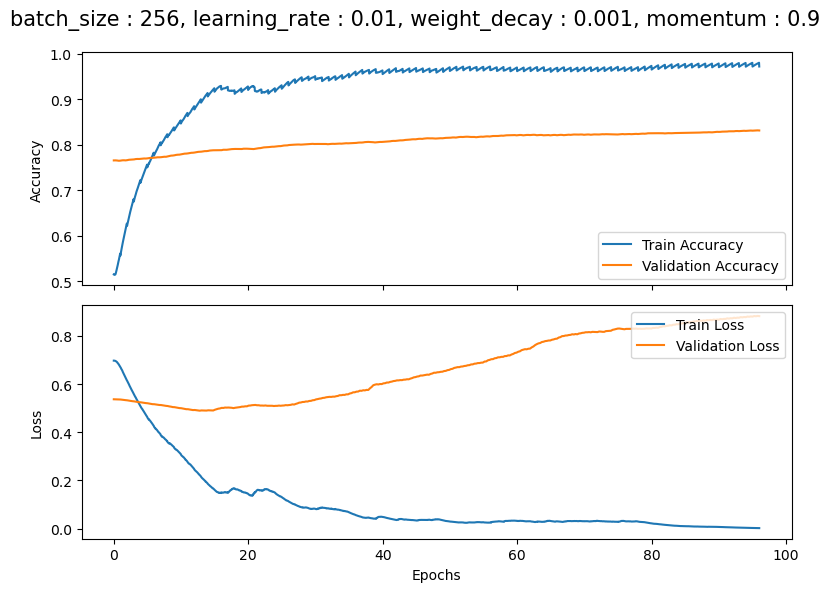

Train accuracy:  97.6
Validation accuracy:  84.2



Combination 46 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.9



Epoch: 1/6, Train loss:  0.526, Train accuracy:  75.3%: 100%|██████████| 563/563 [00:05<00:00, 109.96it/s]
Epoch: 1/6, Val loss:  0.445, Val accuracy:  81.0%: 100%|██████████| 63/63 [00:00<00:00, 388.94it/s]


Epoch: 2/6, Train loss:  0.421, Train accuracy:  82.0%: 100%|██████████| 563/563 [00:08<00:00, 68.60it/s]
Epoch: 2/6, Val loss:  0.417, Val accuracy:  82.5%: 100%|██████████| 63/63 [00:00<00:00, 401.75it/s]


Epoch: 3/6, Train loss:  0.376, Train accuracy:  84.3%: 100%|██████████| 563/563 [00:07<00:00, 73.55it/s]
Epoch: 3/6, Val loss:  0.406, Val accuracy:  82.7%: 100%|██████████| 63/63 [00:00<00:00, 349.88it/s]


Epoch: 4/6, Train loss:  0.338, Train accuracy:  86.1%: 100%|██████████| 563/563 [00:07<00:00, 70.75it/s]
Epoch: 4/6, Val loss:  0.401, Val accuracy:  83.0%: 100%|██████████| 63/63 [00:00<00:00, 393.84it/s]


Epoch: 5/6, Train loss:  0.305, Train accuracy:  88.0%: 100%|██████████| 563/563 [00:07<00:00, 74.33it/s]
Epoch: 5/6, Val loss:  0.407, Val accuracy:  82.8%: 100%|██████████| 63/63 [00:00<00:00, 376.60it/s]


Epoch: 6/6, Train loss:  0.273, Train accuracy:  89.5%: 100%|██████████| 563/563 [00:07<00:00, 71.85it/s]
Epoch: 6/6, Val loss:  0.413, Val accuracy:  83.1%: 100%|██████████| 63/63 [00:00<00:00, 377.93it/s]


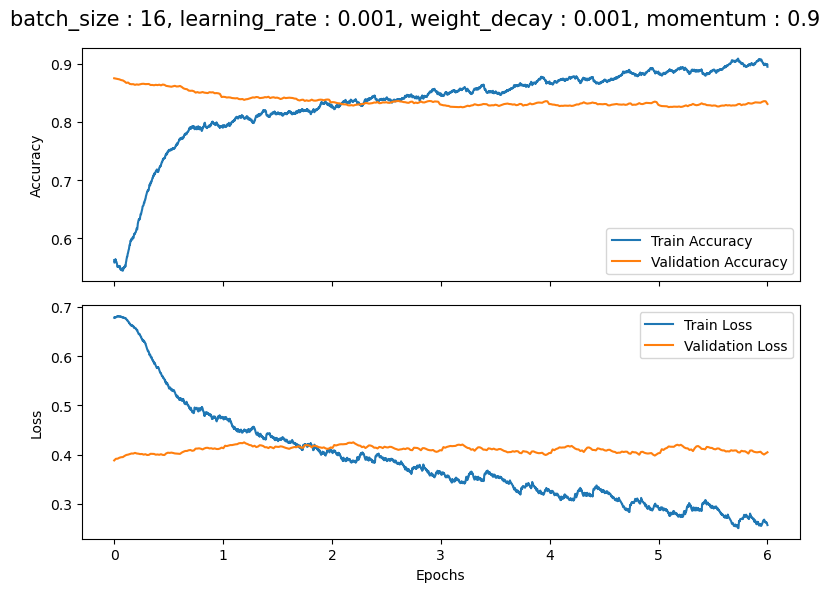

Train accuracy:  90.9
Validation accuracy:  83.1



Combination 47 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.9



Epoch: 1/24, Train loss:  0.638, Train accuracy:  64.0%: 100%|██████████| 141/141 [00:00<00:00, 184.18it/s]
Epoch: 1/24, Val loss:  0.576, Val accuracy:  72.6%: 100%|██████████| 16/16 [00:00<00:00, 425.21it/s]


Epoch: 2/24, Train loss:  0.519, Train accuracy:  77.2%: 100%|██████████| 141/141 [00:00<00:00, 143.00it/s]
Epoch: 2/24, Val loss:  0.486, Val accuracy:  76.8%: 100%|██████████| 16/16 [00:00<00:00, 408.56it/s]


Epoch: 3/24, Train loss:  0.469, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:01<00:00, 138.69it/s]
Epoch: 3/24, Val loss:  0.457, Val accuracy:  79.1%: 100%|██████████| 16/16 [00:00<00:00, 419.26it/s]


Epoch: 4/24, Train loss:  0.441, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:00<00:00, 141.04it/s]
Epoch: 4/24, Val loss:  0.441, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 409.01it/s]


Epoch: 5/24, Train loss:  0.415, Train accuracy:  82.3%: 100%|██████████| 141/141 [00:00<00:00, 147.91it/s]
Epoch: 5/24, Val loss:  0.434, Val accuracy:  79.8%: 100%|██████████| 16/16 [00:00<00:00, 409.62it/s]


Epoch: 6/24, Train loss:  0.393, Train accuracy:  83.1%: 100%|██████████| 141/141 [00:00<00:00, 155.50it/s]
Epoch: 6/24, Val loss:  0.430, Val accuracy:  80.2%: 100%|██████████| 16/16 [00:00<00:00, 409.59it/s]


Epoch: 7/24, Train loss:  0.373, Train accuracy:  84.2%: 100%|██████████| 141/141 [00:00<00:00, 145.31it/s]
Epoch: 7/24, Val loss:  0.424, Val accuracy:  80.8%: 100%|██████████| 16/16 [00:00<00:00, 419.39it/s]


Epoch: 8/24, Train loss:  0.353, Train accuracy:  85.4%: 100%|██████████| 141/141 [00:00<00:00, 143.59it/s]
Epoch: 8/24, Val loss:  0.413, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 436.96it/s]


Epoch: 9/24, Train loss:  0.333, Train accuracy:  86.4%: 100%|██████████| 141/141 [00:00<00:00, 146.35it/s]
Epoch: 9/24, Val loss:  0.405, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 420.64it/s]


Epoch: 10/24, Train loss:  0.315, Train accuracy:  87.4%: 100%|██████████| 141/141 [00:01<00:00, 136.37it/s]
Epoch: 10/24, Val loss:  0.402, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 408.16it/s]


Epoch: 11/24, Train loss:  0.294, Train accuracy:  88.5%: 100%|██████████| 141/141 [00:01<00:00, 127.87it/s]
Epoch: 11/24, Val loss:  0.406, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 413.77it/s]


Epoch: 12/24, Train loss:  0.274, Train accuracy:  89.4%: 100%|██████████| 141/141 [00:01<00:00, 132.07it/s]
Epoch: 12/24, Val loss:  0.407, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 403.51it/s]


Epoch: 13/24, Train loss:  0.253, Train accuracy:  90.4%: 100%|██████████| 141/141 [00:01<00:00, 131.79it/s]
Epoch: 13/24, Val loss:  0.397, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 406.27it/s]


Epoch: 14/24, Train loss:  0.233, Train accuracy:  91.5%: 100%|██████████| 141/141 [00:00<00:00, 148.02it/s]
Epoch: 14/24, Val loss:  0.390, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 435.94it/s]


Epoch: 15/24, Train loss:  0.212, Train accuracy:  92.5%: 100%|██████████| 141/141 [00:00<00:00, 143.09it/s]
Epoch: 15/24, Val loss:  0.389, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 422.32it/s]


Epoch: 16/24, Train loss:  0.192, Train accuracy:  93.5%: 100%|██████████| 141/141 [00:00<00:00, 147.65it/s]
Epoch: 16/24, Val loss:  0.395, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 421.18it/s]


Epoch: 17/24, Train loss:  0.172, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:00<00:00, 142.09it/s]
Epoch: 17/24, Val loss:  0.401, Val accuracy:  84.3%: 100%|██████████| 16/16 [00:00<00:00, 430.94it/s]


Epoch: 18/24, Train loss:  0.153, Train accuracy:  95.2%: 100%|██████████| 141/141 [00:00<00:00, 144.03it/s]
Epoch: 18/24, Val loss:  0.406, Val accuracy:  84.1%: 100%|██████████| 16/16 [00:00<00:00, 414.04it/s]


Epoch: 19/24, Train loss:  0.138, Train accuracy:  95.8%: 100%|██████████| 141/141 [00:01<00:00, 133.16it/s]
Epoch: 19/24, Val loss:  0.421, Val accuracy:  83.8%: 100%|██████████| 16/16 [00:00<00:00, 424.75it/s]


Epoch: 20/24, Train loss:  0.123, Train accuracy:  96.3%: 100%|██████████| 141/141 [00:00<00:00, 144.89it/s]
Epoch: 20/24, Val loss:  0.437, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 435.31it/s]


Epoch: 21/24, Train loss:  0.114, Train accuracy:  96.6%: 100%|██████████| 141/141 [00:00<00:00, 150.26it/s]
Epoch: 21/24, Val loss:  0.465, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 437.11it/s]


Epoch: 22/24, Train loss:  0.109, Train accuracy:  96.6%: 100%|██████████| 141/141 [00:00<00:00, 145.17it/s]
Epoch: 22/24, Val loss:  0.484, Val accuracy:  83.6%: 100%|██████████| 16/16 [00:00<00:00, 435.77it/s]


Epoch: 23/24, Train loss:  0.112, Train accuracy:  96.5%: 100%|██████████| 141/141 [00:00<00:00, 143.36it/s]
Epoch: 23/24, Val loss:  0.505, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 393.95it/s]


Epoch: 24/24, Train loss:  0.140, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:00<00:00, 147.54it/s]
Epoch: 24/24, Val loss:  0.546, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 402.98it/s]


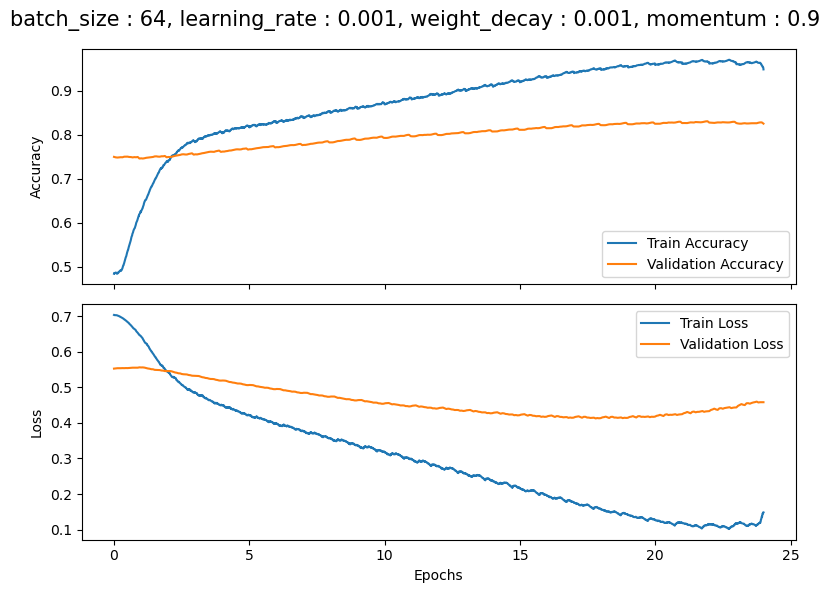

Train accuracy:  95.2
Validation accuracy:  81.8



Combination 48 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 0.001, momentum : 0.9



Epoch: 1/96, Train loss:  0.687, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 115.09it/s]
Epoch: 1/96, Val loss:  0.666, Val accuracy:  53.5%: 100%|██████████| 4/4 [00:00<00:00, 169.31it/s]


Epoch: 2/96, Train loss:  0.655, Train accuracy:  61.1%: 100%|██████████| 36/36 [00:00<00:00, 114.33it/s]
Epoch: 2/96, Val loss:  0.635, Val accuracy:  67.6%: 100%|██████████| 4/4 [00:00<00:00, 175.00it/s]


Epoch: 3/96, Train loss:  0.621, Train accuracy:  69.4%: 100%|██████████| 36/36 [00:00<00:00, 114.81it/s]
Epoch: 3/96, Val loss:  0.603, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 180.39it/s]


Epoch: 4/96, Train loss:  0.586, Train accuracy:  71.8%: 100%|██████████| 36/36 [00:00<00:00, 111.94it/s]
Epoch: 4/96, Val loss:  0.572, Val accuracy:  72.5%: 100%|██████████| 4/4 [00:00<00:00, 189.92it/s]


Epoch: 5/96, Train loss:  0.553, Train accuracy:  73.9%: 100%|██████████| 36/36 [00:00<00:00, 92.84it/s] 
Epoch: 5/96, Val loss:  0.541, Val accuracy:  74.2%: 100%|██████████| 4/4 [00:00<00:00, 190.03it/s]


Epoch: 6/96, Train loss:  0.524, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 111.63it/s]
Epoch: 6/96, Val loss:  0.514, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 159.65it/s]


Epoch: 7/96, Train loss:  0.502, Train accuracy:  76.5%: 100%|██████████| 36/36 [00:00<00:00, 108.80it/s]
Epoch: 7/96, Val loss:  0.495, Val accuracy:  76.7%: 100%|██████████| 4/4 [00:00<00:00, 181.16it/s]


Epoch: 8/96, Train loss:  0.487, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 112.50it/s]
Epoch: 8/96, Val loss:  0.483, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 176.90it/s]


Epoch: 9/96, Train loss:  0.476, Train accuracy:  78.1%: 100%|██████████| 36/36 [00:00<00:00, 113.59it/s]
Epoch: 9/96, Val loss:  0.474, Val accuracy:  77.9%: 100%|██████████| 4/4 [00:00<00:00, 189.92it/s]


Epoch: 10/96, Train loss:  0.467, Train accuracy:  78.5%: 100%|██████████| 36/36 [00:00<00:00, 114.46it/s]
Epoch: 10/96, Val loss:  0.467, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 11/96, Train loss:  0.459, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 110.88it/s]
Epoch: 11/96, Val loss:  0.461, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 181.25it/s]


Epoch: 12/96, Train loss:  0.450, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 112.71it/s]
Epoch: 12/96, Val loss:  0.456, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 13/96, Train loss:  0.442, Train accuracy:  79.5%: 100%|██████████| 36/36 [00:00<00:00, 112.04it/s]
Epoch: 13/96, Val loss:  0.451, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 199.61it/s]


Epoch: 14/96, Train loss:  0.434, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 115.22it/s]
Epoch: 14/96, Val loss:  0.447, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 185.27it/s]


Epoch: 15/96, Train loss:  0.426, Train accuracy:  80.2%: 100%|██████████| 36/36 [00:00<00:00, 111.20it/s]
Epoch: 15/96, Val loss:  0.443, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 190.19it/s]


Epoch: 16/96, Train loss:  0.418, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 114.03it/s]
Epoch: 16/96, Val loss:  0.440, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 189.96it/s]


Epoch: 17/96, Train loss:  0.410, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 110.74it/s]
Epoch: 17/96, Val loss:  0.438, Val accuracy:  79.4%: 100%|██████████| 4/4 [00:00<00:00, 189.82it/s]


Epoch: 18/96, Train loss:  0.403, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 112.64it/s]
Epoch: 18/96, Val loss:  0.435, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 177.33it/s]


Epoch: 19/96, Train loss:  0.395, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 114.57it/s]
Epoch: 19/96, Val loss:  0.432, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 163.02it/s]


Epoch: 20/96, Train loss:  0.388, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 110.44it/s]
Epoch: 20/96, Val loss:  0.429, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 186.42it/s]


Epoch: 21/96, Train loss:  0.381, Train accuracy:  82.1%: 100%|██████████| 36/36 [00:00<00:00, 112.82it/s]
Epoch: 21/96, Val loss:  0.426, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.60it/s]


Epoch: 22/96, Train loss:  0.374, Train accuracy:  82.6%: 100%|██████████| 36/36 [00:00<00:00, 111.78it/s]
Epoch: 22/96, Val loss:  0.423, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 23/96, Train loss:  0.367, Train accuracy:  82.9%: 100%|██████████| 36/36 [00:00<00:00, 108.70it/s]
Epoch: 23/96, Val loss:  0.420, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 169.48it/s]


Epoch: 24/96, Train loss:  0.360, Train accuracy:  83.4%: 100%|██████████| 36/36 [00:00<00:00, 108.60it/s]
Epoch: 24/96, Val loss:  0.418, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 189.78it/s]


Epoch: 25/96, Train loss:  0.353, Train accuracy:  83.8%: 100%|██████████| 36/36 [00:00<00:00, 112.57it/s]
Epoch: 25/96, Val loss:  0.415, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s]


Epoch: 26/96, Train loss:  0.346, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 110.73it/s]
Epoch: 26/96, Val loss:  0.413, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 27/96, Train loss:  0.339, Train accuracy:  84.3%: 100%|██████████| 36/36 [00:00<00:00, 113.17it/s]
Epoch: 27/96, Val loss:  0.411, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 181.23it/s]


Epoch: 28/96, Train loss:  0.332, Train accuracy:  84.5%: 100%|██████████| 36/36 [00:00<00:00, 112.03it/s]
Epoch: 28/96, Val loss:  0.409, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 173.63it/s]


Epoch: 29/96, Train loss:  0.325, Train accuracy:  84.9%: 100%|██████████| 36/36 [00:00<00:00, 113.14it/s]
Epoch: 29/96, Val loss:  0.407, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 183.09it/s]


Epoch: 30/96, Train loss:  0.318, Train accuracy:  85.2%: 100%|██████████| 36/36 [00:00<00:00, 113.59it/s]
Epoch: 30/96, Val loss:  0.406, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 31/96, Train loss:  0.311, Train accuracy:  85.5%: 100%|██████████| 36/36 [00:00<00:00, 109.84it/s]
Epoch: 31/96, Val loss:  0.404, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 176.99it/s]


Epoch: 32/96, Train loss:  0.304, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 93.31it/s]
Epoch: 32/96, Val loss:  0.402, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 181.16it/s]


Epoch: 33/96, Train loss:  0.297, Train accuracy:  86.1%: 100%|██████████| 36/36 [00:00<00:00, 112.07it/s]
Epoch: 33/96, Val loss:  0.401, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 189.91it/s]


Epoch: 34/96, Train loss:  0.290, Train accuracy:  86.5%: 100%|██████████| 36/36 [00:00<00:00, 113.83it/s]
Epoch: 34/96, Val loss:  0.399, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 185.11it/s]


Epoch: 35/96, Train loss:  0.282, Train accuracy:  87.0%: 100%|██████████| 36/36 [00:00<00:00, 111.99it/s]
Epoch: 35/96, Val loss:  0.396, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 190.04it/s]


Epoch: 36/96, Train loss:  0.275, Train accuracy:  87.4%: 100%|██████████| 36/36 [00:00<00:00, 109.96it/s]
Epoch: 36/96, Val loss:  0.392, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 177.12it/s]


Epoch: 37/96, Train loss:  0.267, Train accuracy:  87.9%: 100%|██████████| 36/36 [00:00<00:00, 111.90it/s]
Epoch: 37/96, Val loss:  0.389, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.15it/s]


Epoch: 38/96, Train loss:  0.260, Train accuracy:  88.1%: 100%|██████████| 36/36 [00:00<00:00, 109.90it/s]
Epoch: 38/96, Val loss:  0.387, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 190.00it/s]


Epoch: 39/96, Train loss:  0.252, Train accuracy:  88.6%: 100%|██████████| 36/36 [00:00<00:00, 108.08it/s]
Epoch: 39/96, Val loss:  0.385, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 190.29it/s]


Epoch: 40/96, Train loss:  0.244, Train accuracy:  89.0%: 100%|██████████| 36/36 [00:00<00:00, 113.28it/s]
Epoch: 40/96, Val loss:  0.384, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.05it/s]


Epoch: 41/96, Train loss:  0.237, Train accuracy:  89.5%: 100%|██████████| 36/36 [00:00<00:00, 109.16it/s]
Epoch: 41/96, Val loss:  0.383, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 176.97it/s]


Epoch: 42/96, Train loss:  0.229, Train accuracy:  89.9%: 100%|██████████| 36/36 [00:00<00:00, 113.16it/s]
Epoch: 42/96, Val loss:  0.382, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 185.22it/s]


Epoch: 43/96, Train loss:  0.222, Train accuracy:  90.3%: 100%|██████████| 36/36 [00:00<00:00, 110.97it/s]
Epoch: 43/96, Val loss:  0.381, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 44/96, Train loss:  0.214, Train accuracy:  90.5%: 100%|██████████| 36/36 [00:00<00:00, 113.65it/s]
Epoch: 44/96, Val loss:  0.381, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 194.10it/s]


Epoch: 45/96, Train loss:  0.207, Train accuracy:  90.8%: 100%|██████████| 36/36 [00:00<00:00, 111.60it/s]
Epoch: 45/96, Val loss:  0.382, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 46/96, Train loss:  0.199, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 114.47it/s]
Epoch: 46/96, Val loss:  0.382, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 189.72it/s]


Epoch: 47/96, Train loss:  0.191, Train accuracy:  91.5%: 100%|██████████| 36/36 [00:00<00:00, 113.14it/s]
Epoch: 47/96, Val loss:  0.382, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 158.65it/s]


Epoch: 48/96, Train loss:  0.184, Train accuracy:  91.9%: 100%|██████████| 36/36 [00:00<00:00, 112.26it/s]
Epoch: 48/96, Val loss:  0.383, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.08it/s]


Epoch: 49/96, Train loss:  0.176, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 113.83it/s]
Epoch: 49/96, Val loss:  0.384, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 169.69it/s]


Epoch: 50/96, Train loss:  0.168, Train accuracy:  92.6%: 100%|██████████| 36/36 [00:00<00:00, 111.48it/s]
Epoch: 50/96, Val loss:  0.385, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 185.22it/s]


Epoch: 51/96, Train loss:  0.161, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 113.90it/s]
Epoch: 51/96, Val loss:  0.387, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 180.79it/s]


Epoch: 52/96, Train loss:  0.154, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 109.91it/s]
Epoch: 52/96, Val loss:  0.389, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 168.28it/s]


Epoch: 53/96, Train loss:  0.146, Train accuracy:  93.6%: 100%|██████████| 36/36 [00:00<00:00, 112.88it/s]
Epoch: 53/96, Val loss:  0.391, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 180.71it/s]


Epoch: 54/96, Train loss:  0.139, Train accuracy:  93.9%: 100%|██████████| 36/36 [00:00<00:00, 112.86it/s]
Epoch: 54/96, Val loss:  0.394, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 173.54it/s]


Epoch: 55/96, Train loss:  0.132, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 104.70it/s]
Epoch: 55/96, Val loss:  0.397, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 176.61it/s]


Epoch: 56/96, Train loss:  0.125, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 115.58it/s]
Epoch: 56/96, Val loss:  0.400, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch: 57/96, Train loss:  0.119, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 111.95it/s]
Epoch: 57/96, Val loss:  0.403, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 177.34it/s]


Epoch: 58/96, Train loss:  0.112, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 93.76it/s] 
Epoch: 58/96, Val loss:  0.407, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 59/96, Train loss:  0.106, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 110.80it/s]
Epoch: 59/96, Val loss:  0.410, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 60/96, Train loss:  0.101, Train accuracy:  95.6%: 100%|██████████| 36/36 [00:00<00:00, 112.18it/s]
Epoch: 60/96, Val loss:  0.415, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 177.02it/s]


Epoch: 61/96, Train loss:  0.095, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 61/96, Val loss:  0.420, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 190.32it/s]


Epoch: 62/96, Train loss:  0.090, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 112.07it/s]
Epoch: 62/96, Val loss:  0.424, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 180.92it/s]


Epoch: 63/96, Train loss:  0.085, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 113.74it/s]
Epoch: 63/96, Val loss:  0.430, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 64/96, Train loss:  0.080, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 111.35it/s]
Epoch: 64/96, Val loss:  0.436, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 173.61it/s]


Epoch: 65/96, Train loss:  0.075, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 114.24it/s]
Epoch: 65/96, Val loss:  0.441, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.70it/s]


Epoch: 66/96, Train loss:  0.071, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 112.55it/s]
Epoch: 66/96, Val loss:  0.448, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.15it/s]


Epoch: 67/96, Train loss:  0.067, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 109.17it/s]
Epoch: 67/96, Val loss:  0.454, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 184.92it/s]


Epoch: 68/96, Train loss:  0.063, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 115.02it/s]
Epoch: 68/96, Val loss:  0.461, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 173.76it/s]


Epoch: 69/96, Train loss:  0.060, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 112.82it/s]
Epoch: 69/96, Val loss:  0.467, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 176.20it/s]


Epoch: 70/96, Train loss:  0.057, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 109.08it/s]
Epoch: 70/96, Val loss:  0.474, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 178.10it/s]


Epoch: 71/96, Train loss:  0.054, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.35it/s]
Epoch: 71/96, Val loss:  0.480, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 190.22it/s]


Epoch: 72/96, Train loss:  0.052, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 111.08it/s]
Epoch: 72/96, Val loss:  0.485, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 174.93it/s]


Epoch: 73/96, Train loss:  0.050, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 115.51it/s]
Epoch: 73/96, Val loss:  0.491, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 186.02it/s]


Epoch: 74/96, Train loss:  0.048, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 74/96, Val loss:  0.495, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 189.91it/s]


Epoch: 75/96, Train loss:  0.047, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.43it/s]
Epoch: 75/96, Val loss:  0.500, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 185.00it/s]


Epoch: 76/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 111.45it/s]
Epoch: 76/96, Val loss:  0.504, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 176.88it/s]


Epoch: 77/96, Train loss:  0.045, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.81it/s]
Epoch: 77/96, Val loss:  0.507, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 176.49it/s]


Epoch: 78/96, Train loss:  0.044, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 109.86it/s]
Epoch: 78/96, Val loss:  0.512, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 176.84it/s]


Epoch: 79/96, Train loss:  0.044, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.62it/s]
Epoch: 79/96, Val loss:  0.518, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 177.02it/s]


Epoch: 80/96, Train loss:  0.044, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.66it/s]
Epoch: 80/96, Val loss:  0.523, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 177.88it/s]


Epoch: 81/96, Train loss:  0.045, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 109.97it/s]
Epoch: 81/96, Val loss:  0.531, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 167.88it/s]


Epoch: 82/96, Train loss:  0.046, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 112.75it/s]
Epoch: 82/96, Val loss:  0.541, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 181.03it/s]


Epoch: 83/96, Train loss:  0.047, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 110.59it/s]
Epoch: 83/96, Val loss:  0.553, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 189.71it/s]


Epoch: 84/96, Train loss:  0.048, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 114.36it/s]
Epoch: 84/96, Val loss:  0.566, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 85/96, Train loss:  0.049, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 88.19it/s]
Epoch: 85/96, Val loss:  0.588, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 166.27it/s]


Epoch: 86/96, Train loss:  0.051, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 112.40it/s]
Epoch: 86/96, Val loss:  0.617, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 199.40it/s]


Epoch: 87/96, Train loss:  0.054, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 113.07it/s]
Epoch: 87/96, Val loss:  0.624, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 189.83it/s]


Epoch: 88/96, Train loss:  0.056, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 110.94it/s]
Epoch: 88/96, Val loss:  0.672, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 89/96, Train loss:  0.061, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 113.41it/s]
Epoch: 89/96, Val loss:  0.692, Val accuracy:  80.1%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 90/96, Train loss:  0.063, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 110.54it/s]
Epoch: 90/96, Val loss:  0.801, Val accuracy:  78.4%: 100%|██████████| 4/4 [00:00<00:00, 194.83it/s]


Epoch: 91/96, Train loss:  0.073, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 114.47it/s]
Epoch: 91/96, Val loss:  0.785, Val accuracy:  78.9%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 92/96, Train loss:  0.085, Train accuracy:  95.1%: 100%|██████████| 36/36 [00:00<00:00, 110.62it/s]
Epoch: 92/96, Val loss:  0.860, Val accuracy:  78.4%: 100%|██████████| 4/4 [00:00<00:00, 190.08it/s]


Epoch: 93/96, Train loss:  0.098, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 113.62it/s]
Epoch: 93/96, Val loss:  0.890, Val accuracy:  78.1%: 100%|██████████| 4/4 [00:00<00:00, 185.55it/s]


Epoch: 94/96, Train loss:  0.110, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 112.66it/s]
Epoch: 94/96, Val loss:  1.407, Val accuracy:  71.2%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 95/96, Train loss:  0.137, Train accuracy:  93.3%: 100%|██████████| 36/36 [00:00<00:00, 110.29it/s]
Epoch: 95/96, Val loss:  1.076, Val accuracy:  74.6%: 100%|██████████| 4/4 [00:00<00:00, 181.07it/s]


Epoch: 96/96, Train loss:  0.187, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 113.64it/s]
Epoch: 96/96, Val loss:  1.155, Val accuracy:  73.2%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


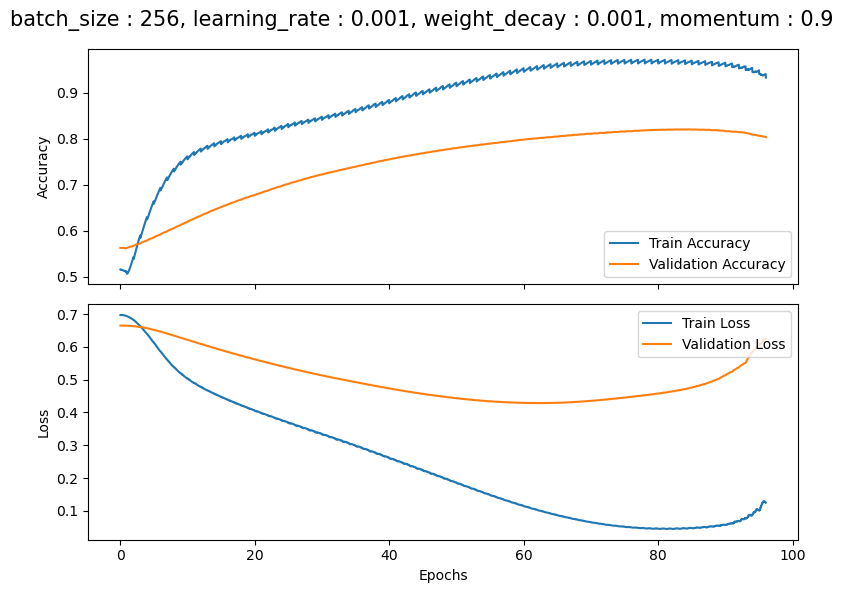

Train accuracy:  83.7
Validation accuracy:  73.2



Combination 49 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/6, Train loss:  0.473, Train accuracy:  79.0%: 100%|██████████| 563/563 [00:05<00:00, 105.24it/s]
Epoch: 1/6, Val loss:  0.432, Val accuracy:  81.2%: 100%|██████████| 63/63 [00:00<00:00, 483.37it/s]


Epoch: 2/6, Train loss:  0.399, Train accuracy:  83.7%: 100%|██████████| 563/563 [00:08<00:00, 70.22it/s]
Epoch: 2/6, Val loss:  0.412, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 319.13it/s]


Epoch: 3/6, Train loss:  0.357, Train accuracy:  85.3%: 100%|██████████| 563/563 [00:08<00:00, 68.23it/s]
Epoch: 3/6, Val loss:  0.423, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 328.03it/s]


Epoch: 4/6, Train loss:  0.321, Train accuracy:  86.9%: 100%|██████████| 563/563 [00:08<00:00, 66.36it/s]
Epoch: 4/6, Val loss:  0.448, Val accuracy:  82.8%: 100%|██████████| 63/63 [00:00<00:00, 339.72it/s]


Epoch: 5/6, Train loss:  0.291, Train accuracy:  88.3%: 100%|██████████| 563/563 [00:08<00:00, 64.15it/s]
Epoch: 5/6, Val loss:  0.441, Val accuracy:  84.1%: 100%|██████████| 63/63 [00:00<00:00, 394.49it/s]


Epoch: 6/6, Train loss:  0.266, Train accuracy:  89.4%: 100%|██████████| 563/563 [00:08<00:00, 62.79it/s]
Epoch: 6/6, Val loss:  0.459, Val accuracy:  82.8%: 100%|██████████| 63/63 [00:00<00:00, 346.19it/s]


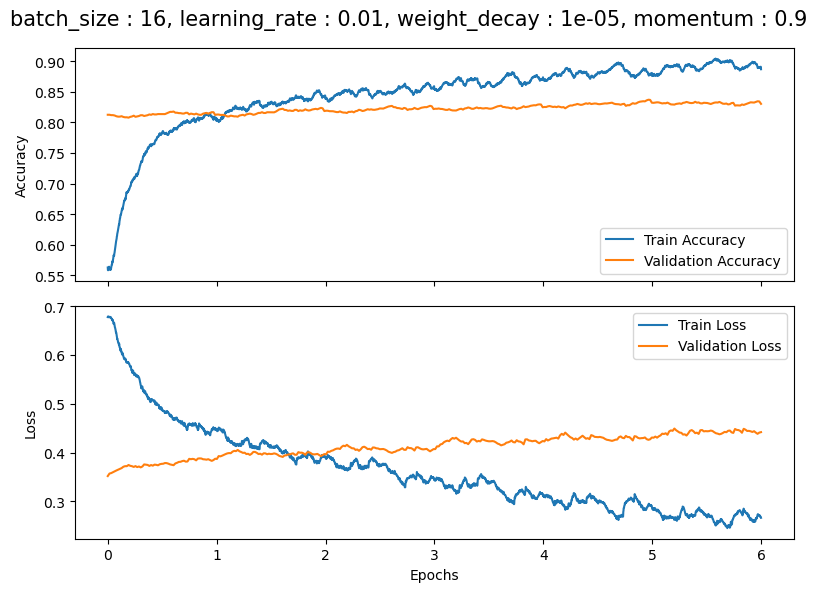

Train accuracy:  90.0
Validation accuracy:  82.8



Combination 50 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/24, Train loss:  0.505, Train accuracy:  75.9%: 100%|██████████| 141/141 [00:00<00:00, 187.45it/s]
Epoch: 1/24, Val loss:  0.446, Val accuracy:  78.5%: 100%|██████████| 16/16 [00:00<00:00, 425.36it/s]


Epoch: 2/24, Train loss:  0.405, Train accuracy:  82.9%: 100%|██████████| 141/141 [00:00<00:00, 141.54it/s]
Epoch: 2/24, Val loss:  0.395, Val accuracy:  82.1%: 100%|██████████| 16/16 [00:00<00:00, 436.29it/s]


Epoch: 3/24, Train loss:  0.358, Train accuracy:  85.2%: 100%|██████████| 141/141 [00:01<00:00, 134.92it/s]
Epoch: 3/24, Val loss:  0.387, Val accuracy:  83.2%: 100%|██████████| 16/16 [00:00<00:00, 425.10it/s]


Epoch: 4/24, Train loss:  0.325, Train accuracy:  86.6%: 100%|██████████| 141/141 [00:01<00:00, 137.58it/s]
Epoch: 4/24, Val loss:  0.393, Val accuracy:  83.1%: 100%|██████████| 16/16 [00:00<00:00, 408.89it/s]


Epoch: 5/24, Train loss:  0.292, Train accuracy:  88.2%: 100%|██████████| 141/141 [00:00<00:00, 154.27it/s]
Epoch: 5/24, Val loss:  0.411, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 422.24it/s]


Epoch: 6/24, Train loss:  0.251, Train accuracy:  90.2%: 100%|██████████| 141/141 [00:00<00:00, 142.19it/s]
Epoch: 6/24, Val loss:  0.444, Val accuracy:  84.1%: 100%|██████████| 16/16 [00:00<00:00, 432.67it/s]


Epoch: 7/24, Train loss:  0.218, Train accuracy:  91.6%: 100%|██████████| 141/141 [00:01<00:00, 139.61it/s]
Epoch: 7/24, Val loss:  0.426, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 409.73it/s]


Epoch: 8/24, Train loss:  0.201, Train accuracy:  92.4%: 100%|██████████| 141/141 [00:00<00:00, 142.20it/s]
Epoch: 8/24, Val loss:  0.490, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 419.33it/s]


Epoch: 9/24, Train loss:  0.200, Train accuracy:  92.1%: 100%|██████████| 141/141 [00:01<00:00, 136.51it/s]
Epoch: 9/24, Val loss:  0.432, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 421.47it/s]


Epoch: 10/24, Train loss:  0.191, Train accuracy:  92.4%: 100%|██████████| 141/141 [00:00<00:00, 143.27it/s]
Epoch: 10/24, Val loss:  0.431, Val accuracy:  84.0%: 100%|██████████| 16/16 [00:00<00:00, 423.34it/s]


Epoch: 11/24, Train loss:  0.167, Train accuracy:  93.3%: 100%|██████████| 141/141 [00:00<00:00, 143.27it/s]
Epoch: 11/24, Val loss:  0.503, Val accuracy:  82.9%: 100%|██████████| 16/16 [00:00<00:00, 423.36it/s]


Epoch: 12/24, Train loss:  0.141, Train accuracy:  94.7%: 100%|██████████| 141/141 [00:00<00:00, 145.38it/s]
Epoch: 12/24, Val loss:  0.571, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 410.88it/s]


Epoch: 13/24, Train loss:  0.120, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:01<00:00, 140.34it/s]
Epoch: 13/24, Val loss:  0.722, Val accuracy:  80.3%: 100%|██████████| 16/16 [00:00<00:00, 430.34it/s]


Epoch: 14/24, Train loss:  0.115, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:01<00:00, 138.42it/s]
Epoch: 14/24, Val loss:  0.655, Val accuracy:  79.5%: 100%|██████████| 16/16 [00:00<00:00, 419.44it/s]


Epoch: 15/24, Train loss:  0.127, Train accuracy:  94.9%: 100%|██████████| 141/141 [00:00<00:00, 146.53it/s]
Epoch: 15/24, Val loss:  0.547, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 430.62it/s]


Epoch: 16/24, Train loss:  0.118, Train accuracy:  95.2%: 100%|██████████| 141/141 [00:00<00:00, 146.48it/s]
Epoch: 16/24, Val loss:  0.606, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 409.77it/s]


Epoch: 17/24, Train loss:  0.135, Train accuracy:  94.5%: 100%|██████████| 141/141 [00:00<00:00, 145.28it/s]
Epoch: 17/24, Val loss:  0.566, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 412.59it/s]


Epoch: 18/24, Train loss:  0.114, Train accuracy:  95.4%: 100%|██████████| 141/141 [00:00<00:00, 146.91it/s]
Epoch: 18/24, Val loss:  0.608, Val accuracy:  81.6%: 100%|██████████| 16/16 [00:00<00:00, 424.40it/s]


Epoch: 19/24, Train loss:  0.082, Train accuracy:  96.6%: 100%|██████████| 141/141 [00:01<00:00, 130.00it/s]
Epoch: 19/24, Val loss:  0.811, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 403.43it/s]


Epoch: 20/24, Train loss:  0.089, Train accuracy:  96.2%: 100%|██████████| 141/141 [00:01<00:00, 132.90it/s]
Epoch: 20/24, Val loss:  0.787, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 403.62it/s]


Epoch: 21/24, Train loss:  0.076, Train accuracy:  96.7%: 100%|██████████| 141/141 [00:01<00:00, 126.15it/s]
Epoch: 21/24, Val loss:  0.863, Val accuracy:  82.6%: 100%|██████████| 16/16 [00:00<00:00, 398.55it/s]


Epoch: 22/24, Train loss:  0.084, Train accuracy:  96.6%: 100%|██████████| 141/141 [00:01<00:00, 135.20it/s]
Epoch: 22/24, Val loss:  0.677, Val accuracy:  83.4%: 100%|██████████| 16/16 [00:00<00:00, 429.94it/s]


Epoch: 23/24, Train loss:  0.062, Train accuracy:  97.2%: 100%|██████████| 141/141 [00:01<00:00, 136.62it/s]
Epoch: 23/24, Val loss:  0.842, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 403.45it/s]


Epoch: 24/24, Train loss:  0.060, Train accuracy:  97.7%: 100%|██████████| 141/141 [00:01<00:00, 136.67it/s]
Epoch: 24/24, Val loss:  0.791, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 404.35it/s]


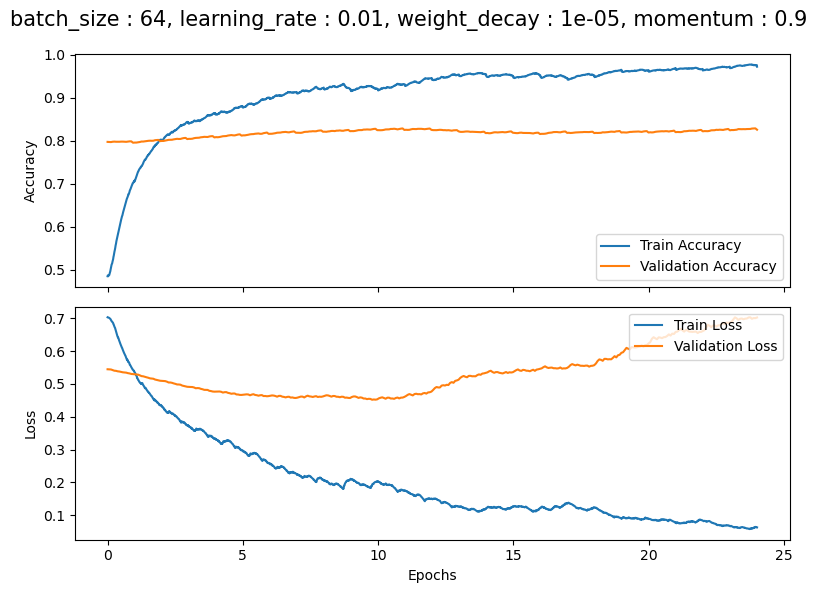

Train accuracy:  96.1
Validation accuracy:  83.5



Combination 51 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.01, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/96, Train loss:  0.618, Train accuracy:  64.5%: 100%|██████████| 36/36 [00:00<00:00, 112.65it/s]
Epoch: 1/96, Val loss:  0.522, Val accuracy:  75.0%: 100%|██████████| 4/4 [00:00<00:00, 182.97it/s]


Epoch: 2/96, Train loss:  0.483, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 112.87it/s]
Epoch: 2/96, Val loss:  0.459, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 189.50it/s]


Epoch: 3/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 111.78it/s]
Epoch: 3/96, Val loss:  0.424, Val accuracy:  80.7%: 100%|██████████| 4/4 [00:00<00:00, 176.09it/s]


Epoch: 4/96, Train loss:  0.391, Train accuracy:  81.5%: 100%|██████████| 36/36 [00:00<00:00, 112.47it/s]
Epoch: 4/96, Val loss:  0.419, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 5/96, Train loss:  0.358, Train accuracy:  83.3%: 100%|██████████| 36/36 [00:00<00:00, 104.59it/s]
Epoch: 5/96, Val loss:  0.432, Val accuracy:  79.8%: 100%|██████████| 4/4 [00:00<00:00, 183.18it/s]


Epoch: 6/96, Train loss:  0.336, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 112.30it/s]
Epoch: 6/96, Val loss:  0.409, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 190.21it/s]


Epoch: 7/96, Train loss:  0.309, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 112.52it/s]
Epoch: 7/96, Val loss:  0.429, Val accuracy:  80.4%: 100%|██████████| 4/4 [00:00<00:00, 169.44it/s]


Epoch: 8/96, Train loss:  0.292, Train accuracy:  86.1%: 100%|██████████| 36/36 [00:00<00:00, 110.51it/s]
Epoch: 8/96, Val loss:  0.424, Val accuracy:  80.8%: 100%|██████████| 4/4 [00:00<00:00, 184.74it/s]


Epoch: 9/96, Train loss:  0.278, Train accuracy:  86.8%: 100%|██████████| 36/36 [00:00<00:00, 113.21it/s]
Epoch: 9/96, Val loss:  0.390, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 41.93it/s]


Epoch: 10/96, Train loss:  0.248, Train accuracy:  88.3%: 100%|██████████| 36/36 [00:00<00:00, 110.94it/s]
Epoch: 10/96, Val loss:  0.381, Val accuracy:  85.0%: 100%|██████████| 4/4 [00:00<00:00, 181.13it/s]


Epoch: 11/96, Train loss:  0.216, Train accuracy:  89.9%: 100%|██████████| 36/36 [00:00<00:00, 111.97it/s]
Epoch: 11/96, Val loss:  0.388, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 173.43it/s]


Epoch: 12/96, Train loss:  0.172, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 108.26it/s]
Epoch: 12/96, Val loss:  0.387, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s]


Epoch: 13/96, Train loss:  0.148, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 114.10it/s]
Epoch: 13/96, Val loss:  0.406, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 189.88it/s]


Epoch: 14/96, Train loss:  0.126, Train accuracy:  93.6%: 100%|██████████| 36/36 [00:00<00:00, 110.90it/s]
Epoch: 14/96, Val loss:  0.463, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 192.18it/s]


Epoch: 15/96, Train loss:  0.124, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 112.74it/s]
Epoch: 15/96, Val loss:  0.647, Val accuracy:  78.7%: 100%|██████████| 4/4 [00:00<00:00, 181.56it/s]


Epoch: 16/96, Train loss:  0.151, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 110.48it/s]
Epoch: 16/96, Val loss:  0.493, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 17/96, Train loss:  0.160, Train accuracy:  91.9%: 100%|██████████| 36/36 [00:00<00:00, 113.08it/s]
Epoch: 17/96, Val loss:  0.497, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 185.34it/s]


Epoch: 18/96, Train loss:  0.127, Train accuracy:  93.1%: 100%|██████████| 36/36 [00:00<00:00, 114.05it/s]
Epoch: 18/96, Val loss:  0.524, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 178.58it/s]


Epoch: 19/96, Train loss:  0.163, Train accuracy:  91.6%: 100%|██████████| 36/36 [00:00<00:00, 108.16it/s]
Epoch: 19/96, Val loss:  0.767, Val accuracy:  74.4%: 100%|██████████| 4/4 [00:00<00:00, 180.99it/s]


Epoch: 20/96, Train loss:  0.165, Train accuracy:  91.1%: 100%|██████████| 36/36 [00:00<00:00, 108.18it/s]
Epoch: 20/96, Val loss:  0.532, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 181.17it/s]


Epoch: 21/96, Train loss:  0.173, Train accuracy:  90.8%: 100%|██████████| 36/36 [00:00<00:00, 107.55it/s]
Epoch: 21/96, Val loss:  0.465, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 22/96, Train loss:  0.156, Train accuracy:  91.6%: 100%|██████████| 36/36 [00:00<00:00, 111.16it/s]
Epoch: 22/96, Val loss:  0.451, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 23/96, Train loss:  0.138, Train accuracy:  92.3%: 100%|██████████| 36/36 [00:00<00:00, 111.41it/s]
Epoch: 23/96, Val loss:  0.537, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 189.78it/s]


Epoch: 24/96, Train loss:  0.096, Train accuracy:  94.3%: 100%|██████████| 36/36 [00:00<00:00, 112.65it/s]
Epoch: 24/96, Val loss:  0.644, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 25/96, Train loss:  0.119, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 111.18it/s]
Epoch: 25/96, Val loss:  0.546, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 173.35it/s]


Epoch: 26/96, Train loss:  0.111, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 111.32it/s]
Epoch: 26/96, Val loss:  0.502, Val accuracy:  85.4%: 100%|██████████| 4/4 [00:00<00:00, 189.97it/s]


Epoch: 27/96, Train loss:  0.090, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 112.75it/s]
Epoch: 27/96, Val loss:  0.569, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 189.59it/s]


Epoch: 28/96, Train loss:  0.080, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 110.89it/s]
Epoch: 28/96, Val loss:  0.599, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 180.37it/s]


Epoch: 29/96, Train loss:  0.077, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 113.31it/s]
Epoch: 29/96, Val loss:  0.640, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 184.83it/s]


Epoch: 30/96, Train loss:  0.082, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 112.16it/s]
Epoch: 30/96, Val loss:  0.689, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 31/96, Train loss:  0.089, Train accuracy:  94.2%: 100%|██████████| 36/36 [00:00<00:00, 112.05it/s]
Epoch: 31/96, Val loss:  0.575, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 176.94it/s]


Epoch: 32/96, Train loss:  0.081, Train accuracy:  94.6%: 100%|██████████| 36/36 [00:00<00:00, 110.48it/s]
Epoch: 32/96, Val loss:  0.617, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 159.87it/s]


Epoch: 33/96, Train loss:  0.055, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 112.32it/s]
Epoch: 33/96, Val loss:  0.592, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 165.91it/s]


Epoch: 34/96, Train loss:  0.038, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 111.97it/s]
Epoch: 34/96, Val loss:  0.665, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 189.90it/s]


Epoch: 35/96, Train loss:  0.032, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 105.48it/s]
Epoch: 35/96, Val loss:  0.761, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 189.91it/s]


Epoch: 36/96, Train loss:  0.041, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 93.45it/s]
Epoch: 36/96, Val loss:  0.809, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s]


Epoch: 37/96, Train loss:  0.045, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 109.61it/s]
Epoch: 37/96, Val loss:  0.887, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


Epoch: 38/96, Train loss:  0.055, Train accuracy:  95.6%: 100%|██████████| 36/36 [00:00<00:00, 112.70it/s]
Epoch: 38/96, Val loss:  0.649, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 181.32it/s]


Epoch: 39/96, Train loss:  0.047, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 110.11it/s]
Epoch: 39/96, Val loss:  0.667, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 186.26it/s]


Epoch: 40/96, Train loss:  0.038, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 113.66it/s]
Epoch: 40/96, Val loss:  0.744, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 190.02it/s]


Epoch: 41/96, Train loss:  0.035, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 111.05it/s]
Epoch: 41/96, Val loss:  0.932, Val accuracy:  82.3%: 100%|██████████| 4/4 [00:00<00:00, 173.44it/s]


Epoch: 42/96, Train loss:  0.049, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 113.01it/s]
Epoch: 42/96, Val loss:  0.983, Val accuracy:  81.7%: 100%|██████████| 4/4 [00:00<00:00, 181.16it/s]


Epoch: 43/96, Train loss:  0.056, Train accuracy:  95.6%: 100%|██████████| 36/36 [00:00<00:00, 109.44it/s]
Epoch: 43/96, Val loss:  0.819, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 44/96, Train loss:  0.052, Train accuracy:  95.8%: 100%|██████████| 36/36 [00:00<00:00, 112.93it/s]
Epoch: 44/96, Val loss:  0.855, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 176.96it/s]


Epoch: 45/96, Train loss:  0.070, Train accuracy:  94.8%: 100%|██████████| 36/36 [00:00<00:00, 110.42it/s]
Epoch: 45/96, Val loss:  0.917, Val accuracy:  82.4%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 46/96, Train loss:  0.081, Train accuracy:  94.6%: 100%|██████████| 36/36 [00:00<00:00, 111.89it/s]
Epoch: 46/96, Val loss:  0.669, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 181.04it/s]


Epoch: 47/96, Train loss:  0.078, Train accuracy:  94.5%: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s]
Epoch: 47/96, Val loss:  0.760, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 185.18it/s]


Epoch: 48/96, Train loss:  0.037, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 110.67it/s]
Epoch: 48/96, Val loss:  0.696, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 185.11it/s]


Epoch: 49/96, Train loss:  0.020, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 110.98it/s]
Epoch: 49/96, Val loss:  0.746, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 181.87it/s]


Epoch: 50/96, Train loss:  0.020, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 109.93it/s]
Epoch: 50/96, Val loss:  0.882, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 185.27it/s]


Epoch: 51/96, Train loss:  0.023, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 110.74it/s]
Epoch: 51/96, Val loss:  0.872, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 173.92it/s]


Epoch: 52/96, Train loss:  0.020, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 112.76it/s]
Epoch: 52/96, Val loss:  0.928, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 185.56it/s]


Epoch: 53/96, Train loss:  0.024, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.73it/s]
Epoch: 53/96, Val loss:  0.879, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 167.93it/s]


Epoch: 54/96, Train loss:  0.024, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 110.11it/s]
Epoch: 54/96, Val loss:  0.982, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 184.79it/s]


Epoch: 55/96, Train loss:  0.018, Train accuracy:  97.0%: 100%|██████████| 36/36 [00:00<00:00, 113.95it/s]
Epoch: 55/96, Val loss:  0.872, Val accuracy:  84.6%: 100%|██████████| 4/4 [00:00<00:00, 173.44it/s]


Epoch: 56/96, Train loss:  0.015, Train accuracy:  97.1%: 100%|██████████| 36/36 [00:00<00:00, 108.85it/s]
Epoch: 56/96, Val loss:  0.883, Val accuracy:  84.2%: 100%|██████████| 4/4 [00:00<00:00, 164.74it/s]


Epoch: 57/96, Train loss:  0.007, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 114.30it/s]
Epoch: 57/96, Val loss:  1.006, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 185.90it/s]


Epoch: 58/96, Train loss:  0.007, Train accuracy:  97.3%: 100%|██████████| 36/36 [00:00<00:00, 111.90it/s]
Epoch: 58/96, Val loss:  0.935, Val accuracy:  84.3%: 100%|██████████| 4/4 [00:00<00:00, 161.34it/s]


Epoch: 59/96, Train loss:  0.006, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 111.71it/s]
Epoch: 59/96, Val loss:  0.990, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 169.54it/s]


Epoch: 60/96, Train loss:  0.005, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 107.72it/s]
Epoch: 60/96, Val loss:  0.991, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 177.29it/s]


Epoch: 61/96, Train loss:  0.005, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 112.54it/s]
Epoch: 61/96, Val loss:  1.013, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 181.60it/s]


Epoch: 62/96, Train loss:  0.004, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 92.73it/s] 
Epoch: 62/96, Val loss:  1.023, Val accuracy:  85.3%: 100%|██████████| 4/4 [00:00<00:00, 181.47it/s]


Epoch: 63/96, Train loss:  0.004, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.27it/s]
Epoch: 63/96, Val loss:  1.045, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 179.60it/s]


Epoch: 64/96, Train loss:  0.005, Train accuracy:  97.5%: 100%|██████████| 36/36 [00:00<00:00, 112.71it/s]
Epoch: 64/96, Val loss:  1.027, Val accuracy:  85.0%: 100%|██████████| 4/4 [00:00<00:00, 185.05it/s]


Epoch: 65/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 105.77it/s]
Epoch: 65/96, Val loss:  1.045, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 176.91it/s]


Epoch: 66/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.48it/s]
Epoch: 66/96, Val loss:  1.053, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 184.33it/s]


Epoch: 67/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.87it/s]
Epoch: 67/96, Val loss:  1.065, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 181.24it/s]


Epoch: 68/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.82it/s]
Epoch: 68/96, Val loss:  1.080, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 182.13it/s]


Epoch: 69/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.44it/s]
Epoch: 69/96, Val loss:  1.088, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 180.60it/s]


Epoch: 70/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 107.80it/s]
Epoch: 70/96, Val loss:  1.085, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 174.49it/s]


Epoch: 71/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 111.74it/s]
Epoch: 71/96, Val loss:  1.099, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 179.60it/s]


Epoch: 72/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 109.85it/s]
Epoch: 72/96, Val loss:  1.099, Val accuracy:  85.0%: 100%|██████████| 4/4 [00:00<00:00, 178.18it/s]


Epoch: 73/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.13it/s]
Epoch: 73/96, Val loss:  1.113, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 74/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.68it/s]
Epoch: 74/96, Val loss:  1.113, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 169.52it/s]


Epoch: 75/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.39it/s]
Epoch: 75/96, Val loss:  1.112, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 76/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.58it/s]
Epoch: 76/96, Val loss:  1.119, Val accuracy:  84.9%: 100%|██████████| 4/4 [00:00<00:00, 187.76it/s]


Epoch: 77/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.79it/s]
Epoch: 77/96, Val loss:  1.106, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 177.29it/s]


Epoch: 78/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 112.80it/s]
Epoch: 78/96, Val loss:  1.134, Val accuracy:  85.2%: 100%|██████████| 4/4 [00:00<00:00, 181.48it/s]


Epoch: 79/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.72it/s]
Epoch: 79/96, Val loss:  1.111, Val accuracy:  85.4%: 100%|██████████| 4/4 [00:00<00:00, 185.33it/s]


Epoch: 80/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 108.39it/s]
Epoch: 80/96, Val loss:  1.136, Val accuracy:  85.4%: 100%|██████████| 4/4 [00:00<00:00, 173.49it/s]


Epoch: 81/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 111.99it/s]
Epoch: 81/96, Val loss:  1.143, Val accuracy:  85.1%: 100%|██████████| 4/4 [00:00<00:00, 181.63it/s]


Epoch: 82/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.13it/s]
Epoch: 82/96, Val loss:  1.169, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 173.30it/s]


Epoch: 83/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 110.94it/s]
Epoch: 83/96, Val loss:  1.186, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 189.75it/s]


Epoch: 84/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 113.21it/s]
Epoch: 84/96, Val loss:  1.191, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 187.49it/s]


Epoch: 85/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 112.99it/s]
Epoch: 85/96, Val loss:  1.188, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 181.21it/s]


Epoch: 86/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.42it/s]
Epoch: 86/96, Val loss:  1.190, Val accuracy:  85.3%: 100%|██████████| 4/4 [00:00<00:00, 183.98it/s]


Epoch: 87/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 113.46it/s]
Epoch: 87/96, Val loss:  1.188, Val accuracy:  84.5%: 100%|██████████| 4/4 [00:00<00:00, 186.32it/s]


Epoch: 88/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.57it/s]
Epoch: 88/96, Val loss:  1.204, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 89/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 91.50it/s]
Epoch: 89/96, Val loss:  1.191, Val accuracy:  84.8%: 100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch: 90/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 110.47it/s]
Epoch: 90/96, Val loss:  1.225, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 175.21it/s]


Epoch: 91/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 111.95it/s]
Epoch: 91/96, Val loss:  1.238, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch: 92/96, Train loss:  0.001, Train accuracy:  97.7%: 100%|██████████| 36/36 [00:00<00:00, 112.12it/s]
Epoch: 92/96, Val loss:  1.263, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 180.44it/s]


Epoch: 93/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 109.75it/s]
Epoch: 93/96, Val loss:  1.229, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 177.17it/s]


Epoch: 94/96, Train loss:  0.001, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 110.64it/s]
Epoch: 94/96, Val loss:  1.232, Val accuracy:  84.4%: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s]


Epoch: 95/96, Train loss:  0.002, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 108.38it/s]
Epoch: 95/96, Val loss:  1.269, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.38it/s]


Epoch: 96/96, Train loss:  0.003, Train accuracy:  97.6%: 100%|██████████| 36/36 [00:00<00:00, 111.90it/s]
Epoch: 96/96, Val loss:  1.245, Val accuracy:  84.7%: 100%|██████████| 4/4 [00:00<00:00, 181.30it/s]


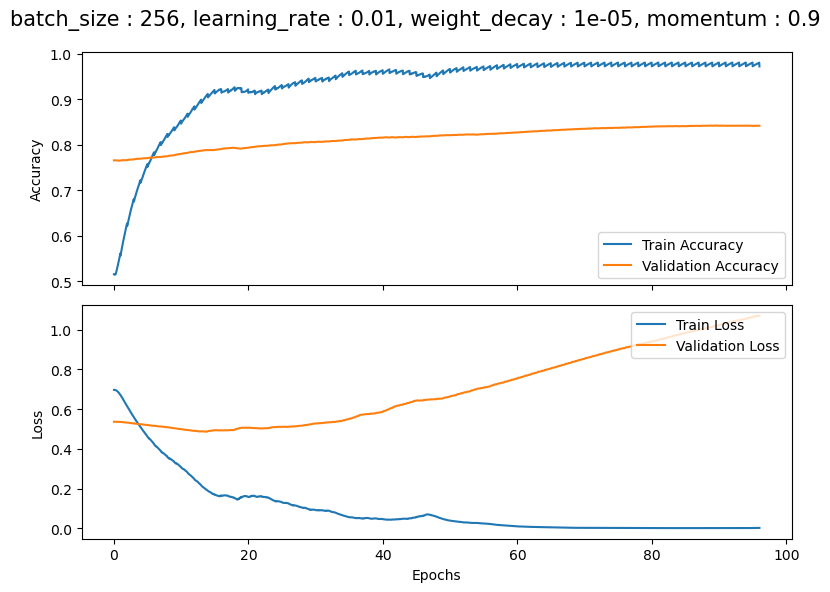

Train accuracy:  97.6
Validation accuracy:  84.7



Combination 52 / 54
Hyperparameters: batch_size : 16, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/6, Train loss:  0.526, Train accuracy:  75.3%: 100%|██████████| 563/563 [00:05<00:00, 101.08it/s]
Epoch: 1/6, Val loss:  0.444, Val accuracy:  81.0%: 100%|██████████| 63/63 [00:00<00:00, 403.54it/s]


Epoch: 2/6, Train loss:  0.420, Train accuracy:  82.0%: 100%|██████████| 563/563 [00:09<00:00, 59.19it/s]
Epoch: 2/6, Val loss:  0.417, Val accuracy:  82.6%: 100%|██████████| 63/63 [00:00<00:00, 353.23it/s]


Epoch: 3/6, Train loss:  0.374, Train accuracy:  84.3%: 100%|██████████| 563/563 [00:09<00:00, 58.12it/s]
Epoch: 3/6, Val loss:  0.406, Val accuracy:  82.9%: 100%|██████████| 63/63 [00:00<00:00, 323.38it/s]


Epoch: 4/6, Train loss:  0.337, Train accuracy:  86.3%: 100%|██████████| 563/563 [00:09<00:00, 58.01it/s]
Epoch: 4/6, Val loss:  0.397, Val accuracy:  83.6%: 100%|██████████| 63/63 [00:00<00:00, 311.73it/s]


Epoch: 5/6, Train loss:  0.303, Train accuracy:  88.1%: 100%|██████████| 563/563 [00:09<00:00, 58.83it/s]
Epoch: 5/6, Val loss:  0.401, Val accuracy:  83.3%: 100%|██████████| 63/63 [00:00<00:00, 293.22it/s]


Epoch: 6/6, Train loss:  0.270, Train accuracy:  89.7%: 100%|██████████| 563/563 [00:08<00:00, 63.99it/s]
Epoch: 6/6, Val loss:  0.410, Val accuracy:  83.9%: 100%|██████████| 63/63 [00:00<00:00, 352.34it/s]


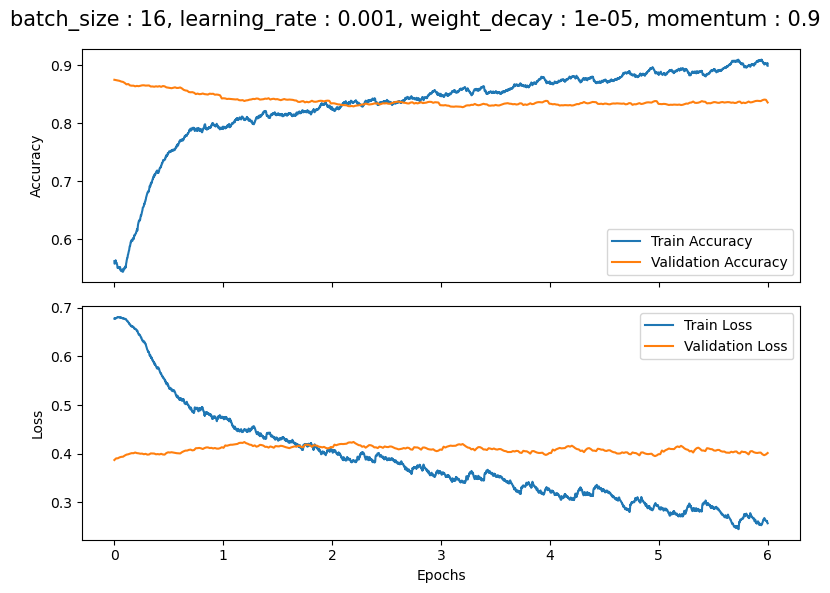

Train accuracy:  91.0
Validation accuracy:  83.9



Combination 53 / 54
Hyperparameters: batch_size : 64, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/24, Train loss:  0.638, Train accuracy:  64.0%: 100%|██████████| 141/141 [00:00<00:00, 183.40it/s]
Epoch: 1/24, Val loss:  0.576, Val accuracy:  72.6%: 100%|██████████| 16/16 [00:00<00:00, 440.98it/s]


Epoch: 2/24, Train loss:  0.519, Train accuracy:  77.3%: 100%|██████████| 141/141 [00:00<00:00, 155.37it/s]
Epoch: 2/24, Val loss:  0.485, Val accuracy:  76.7%: 100%|██████████| 16/16 [00:00<00:00, 423.81it/s]


Epoch: 3/24, Train loss:  0.469, Train accuracy:  80.0%: 100%|██████████| 141/141 [00:00<00:00, 146.94it/s]
Epoch: 3/24, Val loss:  0.456, Val accuracy:  79.1%: 100%|██████████| 16/16 [00:00<00:00, 431.85it/s]


Epoch: 4/24, Train loss:  0.440, Train accuracy:  81.2%: 100%|██████████| 141/141 [00:00<00:00, 146.61it/s]
Epoch: 4/24, Val loss:  0.440, Val accuracy:  79.9%: 100%|██████████| 16/16 [00:00<00:00, 420.22it/s]


Epoch: 5/24, Train loss:  0.414, Train accuracy:  82.4%: 100%|██████████| 141/141 [00:00<00:00, 141.01it/s]
Epoch: 5/24, Val loss:  0.433, Val accuracy:  80.1%: 100%|██████████| 16/16 [00:00<00:00, 413.15it/s]


Epoch: 6/24, Train loss:  0.392, Train accuracy:  83.1%: 100%|██████████| 141/141 [00:00<00:00, 144.65it/s]
Epoch: 6/24, Val loss:  0.429, Val accuracy:  80.1%: 100%|██████████| 16/16 [00:00<00:00, 419.33it/s]


Epoch: 7/24, Train loss:  0.372, Train accuracy:  84.3%: 100%|██████████| 141/141 [00:00<00:00, 142.01it/s]
Epoch: 7/24, Val loss:  0.423, Val accuracy:  80.7%: 100%|██████████| 16/16 [00:00<00:00, 419.44it/s]


Epoch: 8/24, Train loss:  0.351, Train accuracy:  85.5%: 100%|██████████| 141/141 [00:01<00:00, 135.60it/s]
Epoch: 8/24, Val loss:  0.411, Val accuracy:  81.9%: 100%|██████████| 16/16 [00:00<00:00, 419.68it/s]


Epoch: 9/24, Train loss:  0.332, Train accuracy:  86.4%: 100%|██████████| 141/141 [00:00<00:00, 145.57it/s]
Epoch: 9/24, Val loss:  0.404, Val accuracy:  82.2%: 100%|██████████| 16/16 [00:00<00:00, 430.64it/s]


Epoch: 10/24, Train loss:  0.312, Train accuracy:  87.5%: 100%|██████████| 141/141 [00:00<00:00, 155.15it/s]
Epoch: 10/24, Val loss:  0.402, Val accuracy:  82.0%: 100%|██████████| 16/16 [00:00<00:00, 424.56it/s]


Epoch: 11/24, Train loss:  0.291, Train accuracy:  88.5%: 100%|██████████| 141/141 [00:00<00:00, 154.86it/s]
Epoch: 11/24, Val loss:  0.405, Val accuracy:  81.8%: 100%|██████████| 16/16 [00:00<00:00, 430.51it/s]


Epoch: 12/24, Train loss:  0.271, Train accuracy:  89.5%: 100%|██████████| 141/141 [00:00<00:00, 148.16it/s]
Epoch: 12/24, Val loss:  0.405, Val accuracy:  81.7%: 100%|██████████| 16/16 [00:00<00:00, 412.50it/s]


Epoch: 13/24, Train loss:  0.250, Train accuracy:  90.7%: 100%|██████████| 141/141 [00:00<00:00, 148.21it/s]
Epoch: 13/24, Val loss:  0.394, Val accuracy:  82.7%: 100%|██████████| 16/16 [00:00<00:00, 412.14it/s]


Epoch: 14/24, Train loss:  0.230, Train accuracy:  91.6%: 100%|██████████| 141/141 [00:01<00:00, 133.13it/s]
Epoch: 14/24, Val loss:  0.388, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 409.03it/s]


Epoch: 15/24, Train loss:  0.208, Train accuracy:  92.7%: 100%|██████████| 141/141 [00:01<00:00, 134.42it/s]
Epoch: 15/24, Val loss:  0.390, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 408.91it/s]


Epoch: 16/24, Train loss:  0.188, Train accuracy:  93.6%: 100%|██████████| 141/141 [00:00<00:00, 147.19it/s]
Epoch: 16/24, Val loss:  0.395, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 433.14it/s]


Epoch: 17/24, Train loss:  0.167, Train accuracy:  94.7%: 100%|██████████| 141/141 [00:01<00:00, 140.07it/s]
Epoch: 17/24, Val loss:  0.403, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 418.84it/s]


Epoch: 18/24, Train loss:  0.149, Train accuracy:  95.3%: 100%|██████████| 141/141 [00:00<00:00, 150.88it/s]
Epoch: 18/24, Val loss:  0.410, Val accuracy:  83.9%: 100%|██████████| 16/16 [00:00<00:00, 425.72it/s]


Epoch: 19/24, Train loss:  0.131, Train accuracy:  96.0%: 100%|██████████| 141/141 [00:00<00:00, 154.79it/s]
Epoch: 19/24, Val loss:  0.423, Val accuracy:  83.7%: 100%|██████████| 16/16 [00:00<00:00, 424.49it/s]


Epoch: 20/24, Train loss:  0.117, Train accuracy:  96.6%: 100%|██████████| 141/141 [00:00<00:00, 162.83it/s]
Epoch: 20/24, Val loss:  0.441, Val accuracy:  83.0%: 100%|██████████| 16/16 [00:00<00:00, 431.40it/s]


Epoch: 21/24, Train loss:  0.105, Train accuracy:  96.9%: 100%|██████████| 141/141 [00:00<00:00, 156.69it/s]
Epoch: 21/24, Val loss:  0.469, Val accuracy:  83.4%: 100%|██████████| 16/16 [00:00<00:00, 411.18it/s]


Epoch: 22/24, Train loss:  0.098, Train accuracy:  97.0%: 100%|██████████| 141/141 [00:00<00:00, 151.98it/s]
Epoch: 22/24, Val loss:  0.506, Val accuracy:  83.5%: 100%|██████████| 16/16 [00:00<00:00, 425.23it/s]


Epoch: 23/24, Train loss:  0.095, Train accuracy:  97.0%: 100%|██████████| 141/141 [00:00<00:00, 150.89it/s]
Epoch: 23/24, Val loss:  0.516, Val accuracy:  82.4%: 100%|██████████| 16/16 [00:00<00:00, 424.12it/s]


Epoch: 24/24, Train loss:  0.102, Train accuracy:  96.5%: 100%|██████████| 141/141 [00:00<00:00, 147.19it/s]
Epoch: 24/24, Val loss:  0.607, Val accuracy:  81.1%: 100%|██████████| 16/16 [00:00<00:00, 431.04it/s]


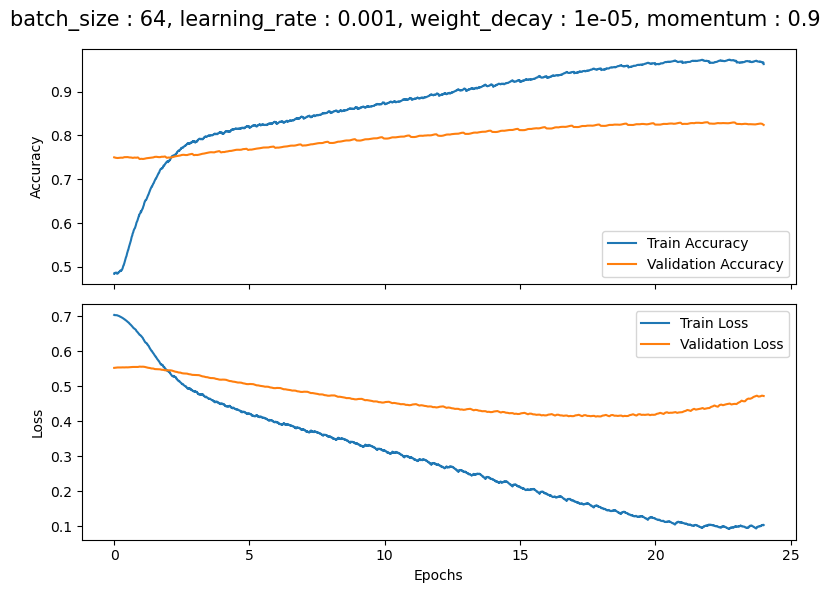

Train accuracy:  93.8
Validation accuracy:  81.1



Combination 54 / 54
Hyperparameters: batch_size : 256, learning_rate : 0.001, weight_decay : 1e-05, momentum : 0.9



Epoch: 1/96, Train loss:  0.687, Train accuracy:  48.7%: 100%|██████████| 36/36 [00:00<00:00, 109.37it/s]
Epoch: 1/96, Val loss:  0.666, Val accuracy:  53.5%: 100%|██████████| 4/4 [00:00<00:00, 181.23it/s]


Epoch: 2/96, Train loss:  0.655, Train accuracy:  61.1%: 100%|██████████| 36/36 [00:00<00:00, 115.08it/s]
Epoch: 2/96, Val loss:  0.635, Val accuracy:  67.6%: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s]


Epoch: 3/96, Train loss:  0.620, Train accuracy:  69.4%: 100%|██████████| 36/36 [00:00<00:00, 112.71it/s]
Epoch: 3/96, Val loss:  0.603, Val accuracy:  70.3%: 100%|██████████| 4/4 [00:00<00:00, 169.49it/s]


Epoch: 4/96, Train loss:  0.586, Train accuracy:  71.8%: 100%|██████████| 36/36 [00:00<00:00, 115.49it/s]
Epoch: 4/96, Val loss:  0.571, Val accuracy:  72.5%: 100%|██████████| 4/4 [00:00<00:00, 189.95it/s]


Epoch: 5/96, Train loss:  0.553, Train accuracy:  73.9%: 100%|██████████| 36/36 [00:00<00:00, 112.73it/s]
Epoch: 5/96, Val loss:  0.541, Val accuracy:  74.3%: 100%|██████████| 4/4 [00:00<00:00, 180.31it/s]


Epoch: 6/96, Train loss:  0.524, Train accuracy:  75.7%: 100%|██████████| 36/36 [00:00<00:00, 113.74it/s]
Epoch: 6/96, Val loss:  0.514, Val accuracy:  75.4%: 100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch: 7/96, Train loss:  0.502, Train accuracy:  76.4%: 100%|██████████| 36/36 [00:00<00:00, 115.64it/s]
Epoch: 7/96, Val loss:  0.495, Val accuracy:  76.8%: 100%|██████████| 4/4 [00:00<00:00, 176.89it/s]


Epoch: 8/96, Train loss:  0.487, Train accuracy:  77.5%: 100%|██████████| 36/36 [00:00<00:00, 110.46it/s]
Epoch: 8/96, Val loss:  0.482, Val accuracy:  76.9%: 100%|██████████| 4/4 [00:00<00:00, 188.72it/s]


Epoch: 9/96, Train loss:  0.476, Train accuracy:  78.2%: 100%|██████████| 36/36 [00:00<00:00, 114.74it/s]
Epoch: 9/96, Val loss:  0.473, Val accuracy:  77.9%: 100%|██████████| 4/4 [00:00<00:00, 190.01it/s]


Epoch: 10/96, Train loss:  0.467, Train accuracy:  78.6%: 100%|██████████| 36/36 [00:00<00:00, 114.60it/s]
Epoch: 10/96, Val loss:  0.466, Val accuracy:  78.6%: 100%|██████████| 4/4 [00:00<00:00, 185.24it/s]


Epoch: 11/96, Train loss:  0.458, Train accuracy:  79.0%: 100%|██████████| 36/36 [00:00<00:00, 113.63it/s]
Epoch: 11/96, Val loss:  0.460, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 185.55it/s]


Epoch: 12/96, Train loss:  0.450, Train accuracy:  79.3%: 100%|██████████| 36/36 [00:00<00:00, 112.88it/s]
Epoch: 12/96, Val loss:  0.455, Val accuracy:  79.2%: 100%|██████████| 4/4 [00:00<00:00, 136.23it/s]


Epoch: 13/96, Train loss:  0.442, Train accuracy:  79.6%: 100%|██████████| 36/36 [00:00<00:00, 111.76it/s]
Epoch: 13/96, Val loss:  0.451, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 181.41it/s]


Epoch: 14/96, Train loss:  0.433, Train accuracy:  80.0%: 100%|██████████| 36/36 [00:00<00:00, 94.60it/s] 
Epoch: 14/96, Val loss:  0.447, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 199.31it/s]


Epoch: 15/96, Train loss:  0.425, Train accuracy:  80.2%: 100%|██████████| 36/36 [00:00<00:00, 105.68it/s]
Epoch: 15/96, Val loss:  0.443, Val accuracy:  79.7%: 100%|██████████| 4/4 [00:00<00:00, 185.65it/s]


Epoch: 16/96, Train loss:  0.417, Train accuracy:  80.6%: 100%|██████████| 36/36 [00:00<00:00, 114.40it/s]
Epoch: 16/96, Val loss:  0.440, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 185.59it/s]


Epoch: 17/96, Train loss:  0.409, Train accuracy:  80.9%: 100%|██████████| 36/36 [00:00<00:00, 110.53it/s]
Epoch: 17/96, Val loss:  0.437, Val accuracy:  79.3%: 100%|██████████| 4/4 [00:00<00:00, 185.32it/s]


Epoch: 18/96, Train loss:  0.402, Train accuracy:  81.2%: 100%|██████████| 36/36 [00:00<00:00, 112.75it/s]
Epoch: 18/96, Val loss:  0.434, Val accuracy:  79.5%: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch: 19/96, Train loss:  0.394, Train accuracy:  81.4%: 100%|██████████| 36/36 [00:00<00:00, 114.64it/s]
Epoch: 19/96, Val loss:  0.431, Val accuracy:  79.6%: 100%|██████████| 4/4 [00:00<00:00, 181.22it/s]


Epoch: 20/96, Train loss:  0.387, Train accuracy:  81.8%: 100%|██████████| 36/36 [00:00<00:00, 111.52it/s]
Epoch: 20/96, Val loss:  0.428, Val accuracy:  80.0%: 100%|██████████| 4/4 [00:00<00:00, 185.64it/s]


Epoch: 21/96, Train loss:  0.380, Train accuracy:  82.2%: 100%|██████████| 36/36 [00:00<00:00, 113.98it/s]
Epoch: 21/96, Val loss:  0.425, Val accuracy:  80.5%: 100%|██████████| 4/4 [00:00<00:00, 181.15it/s]


Epoch: 22/96, Train loss:  0.373, Train accuracy:  82.6%: 100%|██████████| 36/36 [00:00<00:00, 111.16it/s]
Epoch: 22/96, Val loss:  0.422, Val accuracy:  80.9%: 100%|██████████| 4/4 [00:00<00:00, 181.46it/s]


Epoch: 23/96, Train loss:  0.365, Train accuracy:  83.0%: 100%|██████████| 36/36 [00:00<00:00, 114.72it/s]
Epoch: 23/96, Val loss:  0.420, Val accuracy:  81.0%: 100%|██████████| 4/4 [00:00<00:00, 194.36it/s]


Epoch: 24/96, Train loss:  0.358, Train accuracy:  83.5%: 100%|██████████| 36/36 [00:00<00:00, 114.15it/s]
Epoch: 24/96, Val loss:  0.418, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 173.36it/s]


Epoch: 25/96, Train loss:  0.351, Train accuracy:  83.8%: 100%|██████████| 36/36 [00:00<00:00, 109.99it/s]
Epoch: 25/96, Val loss:  0.415, Val accuracy:  81.6%: 100%|██████████| 4/4 [00:00<00:00, 173.43it/s]


Epoch: 26/96, Train loss:  0.344, Train accuracy:  84.0%: 100%|██████████| 36/36 [00:00<00:00, 113.63it/s]
Epoch: 26/96, Val loss:  0.413, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 153.37it/s]


Epoch: 27/96, Train loss:  0.337, Train accuracy:  84.4%: 100%|██████████| 36/36 [00:00<00:00, 112.06it/s]
Epoch: 27/96, Val loss:  0.411, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 189.81it/s]


Epoch: 28/96, Train loss:  0.330, Train accuracy:  84.6%: 100%|██████████| 36/36 [00:00<00:00, 114.29it/s]
Epoch: 28/96, Val loss:  0.409, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 181.32it/s]


Epoch: 29/96, Train loss:  0.323, Train accuracy:  85.0%: 100%|██████████| 36/36 [00:00<00:00, 109.78it/s]
Epoch: 29/96, Val loss:  0.407, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 180.30it/s]


Epoch: 30/96, Train loss:  0.316, Train accuracy:  85.3%: 100%|██████████| 36/36 [00:00<00:00, 111.13it/s]
Epoch: 30/96, Val loss:  0.405, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 177.01it/s]


Epoch: 31/96, Train loss:  0.309, Train accuracy:  85.6%: 100%|██████████| 36/36 [00:00<00:00, 115.45it/s]
Epoch: 31/96, Val loss:  0.404, Val accuracy:  81.3%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 32/96, Train loss:  0.302, Train accuracy:  85.9%: 100%|██████████| 36/36 [00:00<00:00, 109.98it/s]
Epoch: 32/96, Val loss:  0.402, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 33/96, Train loss:  0.295, Train accuracy:  86.2%: 100%|██████████| 36/36 [00:00<00:00, 115.20it/s]
Epoch: 33/96, Val loss:  0.401, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 178.10it/s]


Epoch: 34/96, Train loss:  0.288, Train accuracy:  86.7%: 100%|██████████| 36/36 [00:00<00:00, 114.36it/s]
Epoch: 34/96, Val loss:  0.398, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 185.67it/s]


Epoch: 35/96, Train loss:  0.280, Train accuracy:  87.2%: 100%|██████████| 36/36 [00:00<00:00, 110.49it/s]
Epoch: 35/96, Val loss:  0.395, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 190.05it/s]


Epoch: 36/96, Train loss:  0.272, Train accuracy:  87.5%: 100%|██████████| 36/36 [00:00<00:00, 113.32it/s]
Epoch: 36/96, Val loss:  0.392, Val accuracy:  82.1%: 100%|██████████| 4/4 [00:00<00:00, 169.55it/s]


Epoch: 37/96, Train loss:  0.265, Train accuracy:  88.0%: 100%|██████████| 36/36 [00:00<00:00, 111.51it/s]
Epoch: 37/96, Val loss:  0.389, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 180.74it/s]


Epoch: 38/96, Train loss:  0.257, Train accuracy:  88.2%: 100%|██████████| 36/36 [00:00<00:00, 113.27it/s]
Epoch: 38/96, Val loss:  0.387, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 190.19it/s]


Epoch: 39/96, Train loss:  0.249, Train accuracy:  88.7%: 100%|██████████| 36/36 [00:00<00:00, 110.94it/s]
Epoch: 39/96, Val loss:  0.385, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 173.21it/s]


Epoch: 40/96, Train loss:  0.241, Train accuracy:  89.1%: 100%|██████████| 36/36 [00:00<00:00, 112.50it/s]
Epoch: 40/96, Val loss:  0.384, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 195.44it/s]


Epoch: 41/96, Train loss:  0.234, Train accuracy:  89.5%: 100%|██████████| 36/36 [00:00<00:00, 92.67it/s]
Epoch: 41/96, Val loss:  0.383, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 173.40it/s]


Epoch: 42/96, Train loss:  0.226, Train accuracy:  90.0%: 100%|██████████| 36/36 [00:00<00:00, 110.78it/s]
Epoch: 42/96, Val loss:  0.383, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 43/96, Train loss:  0.219, Train accuracy:  90.4%: 100%|██████████| 36/36 [00:00<00:00, 109.63it/s]
Epoch: 43/96, Val loss:  0.382, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 177.04it/s]


Epoch: 44/96, Train loss:  0.211, Train accuracy:  90.7%: 100%|██████████| 36/36 [00:00<00:00, 107.97it/s]
Epoch: 44/96, Val loss:  0.383, Val accuracy:  82.7%: 100%|██████████| 4/4 [00:00<00:00, 176.88it/s]


Epoch: 45/96, Train loss:  0.203, Train accuracy:  91.0%: 100%|██████████| 36/36 [00:00<00:00, 112.49it/s]
Epoch: 45/96, Val loss:  0.383, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 181.31it/s]


Epoch: 46/96, Train loss:  0.195, Train accuracy:  91.4%: 100%|██████████| 36/36 [00:00<00:00, 111.92it/s]
Epoch: 46/96, Val loss:  0.384, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 147.97it/s]


Epoch: 47/96, Train loss:  0.188, Train accuracy:  91.7%: 100%|██████████| 36/36 [00:00<00:00, 112.50it/s]
Epoch: 47/96, Val loss:  0.384, Val accuracy:  82.9%: 100%|██████████| 4/4 [00:00<00:00, 185.23it/s]


Epoch: 48/96, Train loss:  0.180, Train accuracy:  92.1%: 100%|██████████| 36/36 [00:00<00:00, 113.91it/s]
Epoch: 48/96, Val loss:  0.385, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 185.51it/s]


Epoch: 49/96, Train loss:  0.172, Train accuracy:  92.4%: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s]
Epoch: 49/96, Val loss:  0.387, Val accuracy:  83.0%: 100%|██████████| 4/4 [00:00<00:00, 175.64it/s]


Epoch: 50/96, Train loss:  0.164, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 113.38it/s]
Epoch: 50/96, Val loss:  0.388, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 185.18it/s]


Epoch: 51/96, Train loss:  0.157, Train accuracy:  93.0%: 100%|██████████| 36/36 [00:00<00:00, 111.93it/s]
Epoch: 51/96, Val loss:  0.390, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 162.85it/s]


Epoch: 52/96, Train loss:  0.149, Train accuracy:  93.4%: 100%|██████████| 36/36 [00:00<00:00, 113.09it/s]
Epoch: 52/96, Val loss:  0.392, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 189.96it/s]


Epoch: 53/96, Train loss:  0.142, Train accuracy:  93.7%: 100%|██████████| 36/36 [00:00<00:00, 114.17it/s]
Epoch: 53/96, Val loss:  0.395, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 179.21it/s]


Epoch: 54/96, Train loss:  0.135, Train accuracy:  94.1%: 100%|██████████| 36/36 [00:00<00:00, 108.08it/s]
Epoch: 54/96, Val loss:  0.398, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 184.56it/s]


Epoch: 55/96, Train loss:  0.128, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 112.45it/s]
Epoch: 55/96, Val loss:  0.401, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 181.44it/s]


Epoch: 56/96, Train loss:  0.121, Train accuracy:  94.7%: 100%|██████████| 36/36 [00:00<00:00, 110.64it/s]
Epoch: 56/96, Val loss:  0.404, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 189.89it/s]


Epoch: 57/96, Train loss:  0.115, Train accuracy:  95.0%: 100%|██████████| 36/36 [00:00<00:00, 110.25it/s]
Epoch: 57/96, Val loss:  0.407, Val accuracy:  83.2%: 100%|██████████| 4/4 [00:00<00:00, 177.07it/s]


Epoch: 58/96, Train loss:  0.108, Train accuracy:  95.2%: 100%|██████████| 36/36 [00:00<00:00, 109.01it/s]
Epoch: 58/96, Val loss:  0.412, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 194.19it/s]


Epoch: 59/96, Train loss:  0.102, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 113.54it/s]
Epoch: 59/96, Val loss:  0.416, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 60/96, Train loss:  0.097, Train accuracy:  95.7%: 100%|██████████| 36/36 [00:00<00:00, 112.68it/s]
Epoch: 60/96, Val loss:  0.420, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 181.20it/s]


Epoch: 61/96, Train loss:  0.091, Train accuracy:  95.9%: 100%|██████████| 36/36 [00:00<00:00, 109.43it/s]
Epoch: 61/96, Val loss:  0.425, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.26it/s]


Epoch: 62/96, Train loss:  0.086, Train accuracy:  96.1%: 100%|██████████| 36/36 [00:00<00:00, 113.27it/s]
Epoch: 62/96, Val loss:  0.431, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 189.73it/s]


Epoch: 63/96, Train loss:  0.081, Train accuracy:  96.2%: 100%|██████████| 36/36 [00:00<00:00, 109.71it/s]
Epoch: 63/96, Val loss:  0.437, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s]


Epoch: 64/96, Train loss:  0.076, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 112.50it/s]
Epoch: 64/96, Val loss:  0.443, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 178.60it/s]


Epoch: 65/96, Train loss:  0.072, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 114.34it/s]
Epoch: 65/96, Val loss:  0.449, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 166.59it/s]


Epoch: 66/96, Train loss:  0.068, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 110.68it/s]
Epoch: 66/96, Val loss:  0.456, Val accuracy:  84.0%: 100%|██████████| 4/4 [00:00<00:00, 183.56it/s]


Epoch: 67/96, Train loss:  0.064, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 93.24it/s] 
Epoch: 67/96, Val loss:  0.464, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 175.03it/s]


Epoch: 68/96, Train loss:  0.060, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 110.55it/s]
Epoch: 68/96, Val loss:  0.472, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 181.50it/s]


Epoch: 69/96, Train loss:  0.057, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 113.49it/s]
Epoch: 69/96, Val loss:  0.478, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 173.56it/s]


Epoch: 70/96, Train loss:  0.054, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 111.63it/s]
Epoch: 70/96, Val loss:  0.486, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 184.74it/s]


Epoch: 71/96, Train loss:  0.052, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 110.25it/s]
Epoch: 71/96, Val loss:  0.493, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 189.93it/s]


Epoch: 72/96, Train loss:  0.050, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 109.34it/s]
Epoch: 72/96, Val loss:  0.499, Val accuracy:  83.6%: 100%|██████████| 4/4 [00:00<00:00, 183.55it/s]


Epoch: 73/96, Train loss:  0.048, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.06it/s]
Epoch: 73/96, Val loss:  0.505, Val accuracy:  83.7%: 100%|██████████| 4/4 [00:00<00:00, 181.69it/s]


Epoch: 74/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 111.81it/s]
Epoch: 74/96, Val loss:  0.511, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s]


Epoch: 75/96, Train loss:  0.046, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.87it/s]
Epoch: 75/96, Val loss:  0.516, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.19it/s]


Epoch: 76/96, Train loss:  0.045, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 112.17it/s]
Epoch: 76/96, Val loss:  0.521, Val accuracy:  83.8%: 100%|██████████| 4/4 [00:00<00:00, 169.16it/s]


Epoch: 77/96, Train loss:  0.044, Train accuracy:  96.9%: 100%|██████████| 36/36 [00:00<00:00, 114.43it/s]
Epoch: 77/96, Val loss:  0.520, Val accuracy:  83.5%: 100%|██████████| 4/4 [00:00<00:00, 182.55it/s]


Epoch: 78/96, Train loss:  0.044, Train accuracy:  96.8%: 100%|██████████| 36/36 [00:00<00:00, 113.04it/s]
Epoch: 78/96, Val loss:  0.525, Val accuracy:  83.4%: 100%|██████████| 4/4 [00:00<00:00, 189.76it/s]


Epoch: 79/96, Train loss:  0.044, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 113.47it/s]
Epoch: 79/96, Val loss:  0.528, Val accuracy:  83.3%: 100%|██████████| 4/4 [00:00<00:00, 188.52it/s]


Epoch: 80/96, Train loss:  0.045, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 113.74it/s]
Epoch: 80/96, Val loss:  0.536, Val accuracy:  83.1%: 100%|██████████| 4/4 [00:00<00:00, 185.12it/s]


Epoch: 81/96, Train loss:  0.046, Train accuracy:  96.7%: 100%|██████████| 36/36 [00:00<00:00, 111.44it/s]
Epoch: 81/96, Val loss:  0.546, Val accuracy:  82.8%: 100%|██████████| 4/4 [00:00<00:00, 190.19it/s]


Epoch: 82/96, Train loss:  0.048, Train accuracy:  96.6%: 100%|██████████| 36/36 [00:00<00:00, 113.57it/s]
Epoch: 82/96, Val loss:  0.560, Val accuracy:  82.2%: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s]


Epoch: 83/96, Train loss:  0.050, Train accuracy:  96.4%: 100%|██████████| 36/36 [00:00<00:00, 112.14it/s]
Epoch: 83/96, Val loss:  0.581, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 185.21it/s]


Epoch: 84/96, Train loss:  0.054, Train accuracy:  96.3%: 100%|██████████| 36/36 [00:00<00:00, 113.36it/s]
Epoch: 84/96, Val loss:  0.601, Val accuracy:  81.5%: 100%|██████████| 4/4 [00:00<00:00, 192.74it/s]


Epoch: 85/96, Train loss:  0.061, Train accuracy:  96.0%: 100%|██████████| 36/36 [00:00<00:00, 108.83it/s]
Epoch: 85/96, Val loss:  0.606, Val accuracy:  81.8%: 100%|██████████| 4/4 [00:00<00:00, 162.86it/s]


Epoch: 86/96, Train loss:  0.075, Train accuracy:  95.3%: 100%|██████████| 36/36 [00:00<00:00, 111.33it/s]
Epoch: 86/96, Val loss:  0.721, Val accuracy:  82.5%: 100%|██████████| 4/4 [00:00<00:00, 190.25it/s]


Epoch: 87/96, Train loss:  0.105, Train accuracy:  94.4%: 100%|██████████| 36/36 [00:00<00:00, 110.24it/s]
Epoch: 87/96, Val loss:  0.909, Val accuracy:  81.1%: 100%|██████████| 4/4 [00:00<00:00, 187.27it/s]


Epoch: 88/96, Train loss:  0.129, Train accuracy:  93.5%: 100%|██████████| 36/36 [00:00<00:00, 114.47it/s]
Epoch: 88/96, Val loss:  0.767, Val accuracy:  81.4%: 100%|██████████| 4/4 [00:00<00:00, 169.00it/s]


Epoch: 89/96, Train loss:  0.073, Train accuracy:  95.5%: 100%|██████████| 36/36 [00:00<00:00, 112.13it/s]
Epoch: 89/96, Val loss:  1.009, Val accuracy:  75.3%: 100%|██████████| 4/4 [00:00<00:00, 178.83it/s]


Epoch: 90/96, Train loss:  0.160, Train accuracy:  92.8%: 100%|██████████| 36/36 [00:00<00:00, 111.42it/s]
Epoch: 90/96, Val loss:  1.043, Val accuracy:  74.5%: 100%|██████████| 4/4 [00:00<00:00, 186.35it/s]


Epoch: 91/96, Train loss:  0.204, Train accuracy:  91.6%: 100%|██████████| 36/36 [00:00<00:00, 114.31it/s]
Epoch: 91/96, Val loss:  0.622, Val accuracy:  81.2%: 100%|██████████| 4/4 [00:00<00:00, 181.64it/s]


Epoch: 92/96, Train loss:  0.129, Train accuracy:  93.6%: 100%|██████████| 36/36 [00:00<00:00, 107.60it/s]
Epoch: 92/96, Val loss:  1.183, Val accuracy:  72.6%: 100%|██████████| 4/4 [00:00<00:00, 182.33it/s]


Epoch: 93/96, Train loss:  0.207, Train accuracy:  91.2%: 100%|██████████| 36/36 [00:00<00:00, 114.18it/s]
Epoch: 93/96, Val loss:  1.406, Val accuracy:  69.3%: 100%|██████████| 4/4 [00:00<00:00, 185.49it/s]


Epoch: 94/96, Train loss:  0.374, Train accuracy:  87.6%: 100%|██████████| 36/36 [00:00<00:00, 90.99it/s] 
Epoch: 94/96, Val loss:  0.587, Val accuracy:  82.6%: 100%|██████████| 4/4 [00:00<00:00, 185.27it/s]


Epoch: 95/96, Train loss:  0.139, Train accuracy:  93.2%: 100%|██████████| 36/36 [00:00<00:00, 114.73it/s]
Epoch: 95/96, Val loss:  0.500, Val accuracy:  83.9%: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch: 96/96, Train loss:  0.052, Train accuracy:  96.5%: 100%|██████████| 36/36 [00:00<00:00, 112.49it/s]
Epoch: 96/96, Val loss:  0.507, Val accuracy:  84.1%: 100%|██████████| 4/4 [00:00<00:00, 173.38it/s]


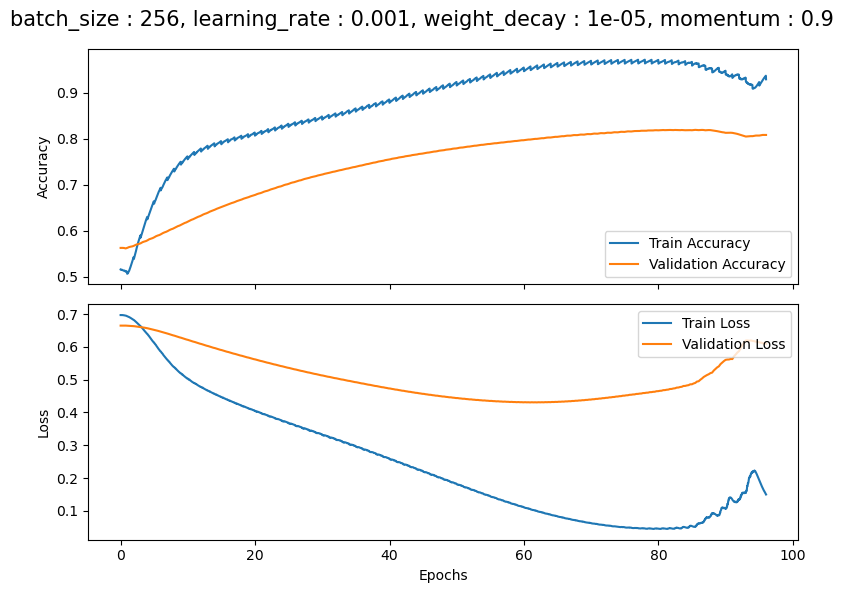

Train accuracy:  96.2
Validation accuracy:  84.1





In [28]:
n_epochs_lowest_batch_size = 6
figsize = (8, 6)

hyperparameter_space = {"batch_size" : [16, 64, 256], "learning_rate" : [0.01, 0.001], "weight_decay" : [0.0, 1e-3, 1e-5], "momentum" : [0.0, 0.5, 0.9]}

hyperparameter_grid = grid_search(**hyperparameter_space)
n_hyperparameter_combinations = len(hyperparameter_grid)

best_model = None
best_train_logs = None
best_hyperparameters = None

best_val_accuracy = 0.0

for i, hyperparameters in enumerate(hyperparameter_grid):
    #Print progress and current hyperparameters
    hyperparameter_str = ', '.join([f'{parameter_name} : {parameter}' for parameter_name, parameter in hyperparameters.items()])
    print(f"Combination {i+1} / {n_hyperparameter_combinations}")
    print(f"Hyperparameters: {hyperparameter_str}\n")

    n_epochs = floor(n_epochs_lowest_batch_size * hyperparameters["batch_size"] / min(hyperparameter_space["batch_size"]))

    train_loader = DataLoader(cifar2_train, hyperparameters["batch_size"], shuffle=False)
    val_loader = DataLoader(cifar2_val, hyperparameters["batch_size"], shuffle=False)

    T.manual_seed(seed)
    model = MyMLP(*model_architecture).to(device)
    #Train model with current hyperparameters
    best_state_dict, train_logs = train_manual_update(n_epochs,
                                                      hyperparameters["learning_rate"], 
                                                      hyperparameters["weight_decay"], 
                                                      hyperparameters["momentum"], 
                                                      model,
                                                      criterion, 
                                                      train_loader, 
                                                      val_loader)

    plot_train_log(n_epochs, train_logs, figsize=figsize, title=hyperparameter_str, title_fontsize=15)

    #Load the model parameters that performed best on validation data
    model.load_state_dict(best_state_dict)
    
    train_accuracy = get_accuracy(model, train_loader)
    val_accuracy = get_accuracy(model, val_loader)

    print(f"Train accuracy: {100 * train_accuracy : 0.1f}\nValidation accuracy: {100 * val_accuracy : 0.1f}\n\n\n")

    #If current model is better then previous best, update it
    if(val_accuracy > best_val_accuracy):
        best_val_accuracy = val_accuracy
        best_model = model
        best_train_logs = train_logs
        best_hyperparameters = hyperparameters

In [49]:
#Calculates confusion matrix for a given model on a dataset
def get_confusion_matrix(model : Module, data_loader : DataLoader) -> T.Tensor:
    training = model.training

    predicted_bird_right = 0
    predicted_bird_wrong = 0
    predicted_airplane_right = 0
    predicted_airplane_wrong = 0

    if(training == True):
        model.eval()

    for X, y in data_loader:
        X = X.to(device, dtype)
        y = y.to(device)

        with T.no_grad():
            y_pred = T.argmax(model(X), dim=-1)

        right_mask = y_pred == y

        predicted_bird_mask = y_pred == 1
        predicted_airplane_mask = y_pred == 0

        predicted_bird_right += (right_mask & predicted_bird_mask).count_nonzero().cpu().item()
        predicted_bird_wrong += (~right_mask & predicted_bird_mask).count_nonzero().cpu().item()
        predicted_airplane_right += (right_mask & predicted_airplane_mask).count_nonzero().cpu().item()
        predicted_airplane_wrong += (~right_mask & predicted_airplane_mask).count_nonzero().cpu().item()

    if(training == True):
        model.train()

    return predicted_bird_right, predicted_bird_wrong, predicted_airplane_right, predicted_airplane_wrong

In [50]:
#Print the confision matrix
def print_confusion_matrix(confusion_matrix : Tuple[int, int, int, int]):
    predicted_bird_right, predicted_bird_wrong, predicted_airplane_right, predicted_airplane_wrong = confusion_matrix
    
    print("                           Test Confusion Matrix")
    print(" " * 16 + "-" * 47)
    print(f"                |   Predicted Airplane   |   Predicted Bird   |")
    print("-" * 63)
    print(f"| True Airplane |          {predicted_airplane_right}           |         {predicted_bird_wrong}        |")
    print("-" * 63)
    print(f"| True Bird     |          {predicted_airplane_wrong}           |         {predicted_bird_right}        |")
    print("-" * 63)

In [51]:
#Evaluation
test_batch_size = 256
test_loader = DataLoader(cifar2_test, test_batch_size, shuffle=False)

test_accuracy = get_accuracy(best_model, test_loader)
confusion_matrix = get_confusion_matrix(best_model, test_loader)

print(f"Best Model Test Accuracy: {100 * test_accuracy : 0.1f}%\n\n")
print_confusion_matrix(confusion_matrix)

Best Model Test Accuracy:  82.3%


                           Test Confusion Matrix
                -----------------------------------------------
                |   Predicted Airplane   |   Predicted Bird   |
---------------------------------------------------------------
| True Airplane |          846           |         154        |
---------------------------------------------------------------
| True Bird     |          160           |         840        |
---------------------------------------------------------------
